In [1]:
from floortrans.loaders.augmentations import (RandomCropToSizeTorch,
                                              ResizePaddedTorch,
                                              Compose,
                                              DictToTensor,
                                              ColorJitterTorch,
                                              RandomRotations)
import torchvision
from torchvision.transforms import RandomChoice
from torch.utils import data
import torch.nn.functional as F
from torch.nn.functional import softmax
from tqdm import tqdm
from skimage import io
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from floortrans.loaders import FloorplanSVG
from floortrans.models import get_model
from floortrans.losses import UncertaintyLoss
from floortrans.metrics import get_px_acc, runningScore
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
import torch
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
import numpy as np
import pandas as pd
import logging
from tensorboardX import SummaryWriter
from floortrans.losses import UncertaintyLoss
from torchvision.transforms import ToPILImage
from IPython.display import Image

In [2]:
# Referencing work from
# https://github.com/ternaus/robot-surgery-segmentation/blob/master/models.py 

########################################################################################
# MODIFIED & REIMPLEMENTED BY Wisoo (Victor) Song, mail : victor_song@g.harvard.edu    # 
########################################################################################
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvBatchRelu(nn.Module):
    def __init__(self, in_: int, out: int, eps=1e-05, momentum=0.1, affine=True):
        super(ConvBatchRelu, self).__init__()
        self.conv = conv3x3(in_, out)
        self.batchnorm = nn.BatchNorm2d(num_features=out, eps=eps, momentum=momentum, affine=affine)
        #The main purpose of batch normalisation is not for dealing with overfitting 
        #but if you have small batches while training it can have regularization effect.
        #In the paper that it was introduced for dealing with covariate shift,
        #it was mentioned that it should be used before activation function.
        #Consequently, you can use it both in convolutional layers and dense layers,
        #after employing weights and before activation functions. 
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    """
    Decoder block 
    """

    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels
        #The main purpose of batch normalisation is not for dealing with overfitting 
        #but if you have small batches while training it can have regularization effect.
        #In the paper that it was introduced for dealing with covariat shift,
        #it was mentioned that it should be used before activation function.
        #Consequently, you can use it both in convolutional layers and dense layers,
        #after employing weights and before activation functions. 
        if is_deconv:
            self.block = nn.Sequential(
                #After every concatenation we again apply two consecutive regular convolutions
                #so that the model can learn to assemble a more precise output
                
                #ConvTranspose is a convolution and has trainable kernels while 
                #Upsample is a simple interpolation (bilinear, nearest etc.) 
                #This section of the if block should be used for this research.
                #Transpose is learning parameter while Up-sampling is no-learning parameters. 
                #Using Up-samling for faster inference or training because it does not require to update weight or compute gradient
                ConvBatchRelu(in_channels, middle_channels), # just 3x3 conv ==> Batch norm ==> relu
                ConvBatchRelu(middle_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                #After every concatenation we again apply two consecutive regular convolutions
                #so that the model can learn to assemble a more precise output
                ConvBatchRelu(in_channels, middle_channels),
                ConvBatchRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)## defined in __init__      
        

class ContourPredictNet(nn.Module):
    def __init__(self, num_classes=1, num_filters=[256,128,64,32,16], pretrained=False, freeze_encoder=True):
        """
         only contains Convolutional layers and does not contain any Dense layer 
         because of this, it can accept image of any size. (since FC layers require one to match up the input size w/ the number of neurons)
        :param num_classes: This should default to 1 because 0 = no center , 1 = center
        :param num_filters: 32 as the default
        :param pretrained:
            False - no pre-trained network used
            True - encoder pre-trained with VGG16
        """
        super().__init__()
        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features
        
        self.layer_count = 0
        if freeze_encoder:
            for child in self.encoder.children(): # .children() returns the generator for unet16's layers. 
                # Warning: .children() not only shows the layers involved in the actual forward() func,
                # but also shows all the instance varibles like self.encoder that are just defined as an
                # instance variable.
                # And children() is listed in the order the instance variables are defined in class. 
                for param in child.parameters():
                    param.requires_grad = False
        
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2) # Pool is  applied in the forward()

        

        self.relu = nn.ReLU(inplace=False)
        
        self.conv1 = nn.Sequential(self.encoder[0], #Conv2d (3, 64) (R,G,B) 3 channels, output channel 64
                                                    #Recall:   O = ((I - K + 2P) / S) + 1  ==> 3x3 kernel with pad=1 stride=1 keeps Input dim = Output dim
                                   
                                   self.relu,
                                   self.encoder[2], #Conv2d (64, 64)
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5], #Conv2d (64, 128)
                                   self.relu,
                                   self.encoder[7], #Conv2d (128, 128)
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],#Conv2d(128, 256
                                   self.relu,
                                   self.encoder[12],#Conv2d(256, 256
                                   self.relu,
                                   self.encoder[14],#Conv2d(256, 256,
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],#Conv2d(256, 512,
                                   self.relu,
                                   self.encoder[19],#Conv2d(512, 512
                                   self.relu,
                                   self.encoder[21],#Conv2d(512, 512,
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],#Conv2d(512, 512, 
                                   self.relu,
                                   self.encoder[26],#Conv2d(512, 512, 
                                   self.relu,
                                   self.encoder[28],#Conv2d(512, 512, 
                                   self.relu)

        #                        in_channels, mid_channels , out_channels
        #
        self.dec4 = DecoderBlock(512, 512, 512) # 256 # There is a deconv kernel 4x4, stride=2 pad 1 in the decoder and the rest is 3x3 conv

    # 

                                 #This number is because of the concatenation (center #filters + num_filters*8)
            
        """
        RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1.
        Got 28 and 14 in dimension 2 at /tmp/pip-req-build-4baxydiv/aten/src/TH/generic/THTensor.cpp:689
        """

        self.dec3 = DecoderBlock(512*2, 512, num_filters[0]) # 256
        self.dec2 = DecoderBlock(num_filters[0]*2, num_filters[0], num_filters[1]) # 128
        self.dec1 = DecoderBlock(num_filters[1]*2, num_filters[1], num_filters[2]) # 64
        self.batRelu = ConvBatchRelu(num_filters[2], num_filters[4])
        self.final = nn.Conv2d(num_filters[4], num_classes, kernel_size=1) # 16 channels ==> 1 channel, 

    def forward(self, x):
        print("x shape", x.shape) #x shape torch.Size([10, 3, 224, 224])

        conv1 = self.conv1(x) # conv1 torch.Size([10, 64, 224, 224])
        conv2 = self.conv2(self.pool(conv1)) # maxpool2d 2,2 ==> dimension becomes n/2, n/2. Channel # stays the same just after pool
        #conv2 shape  torch.Size([10, 128, 112, 112])
        #self.pool(conv2) shape == torch.Size([10, 128, 56, 56])
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3)) # recall that self.conv4 outputs 512 chan.
        center = self.conv5(self.pool(conv4)) # self.conv5 also outputs 512 chan. # conv5 [10 512, 14, 14]
        center_up = self.dec4(center)
#         center = self.center(conv5) # self.center output => num_filters * 8 chan(=256).
#                                                # but the dimensions of each chan. filter are half the size ==> quarter sized image as a whole
        
        #let's say that conv5's dimensions are w x w
        
        # center's dimensions are w/2 x w/2 because it's been maxpooled (2x2)
        # center has 256 chan.
                
        
        """
        To get better precise locations, at every step of the decoder we use skip connections
        by concatenating the output of the transposed
        convolution layers(reconstructed tensors) with the feature maps from the 
        Encoder at the same level:
        """
        
        """In Tensorflow you would use something like tf.image.resize_images
        to get the same height width dimensions as your feature maps in the expansive part
        and then use tf.concat to concatenate the feature maps along the channel axis 
        (typically the 4th axis in BHWC layout).
        https://stackoverflow.com/questions/53068877/u-net-copy-and-crop
        
        This probably means that in pytorch, we can't simply use torch.cat but should use
        
        """

        
#         print("center.shape", center.shape)
        
    
        #center.shape torch.Size([10, 256, 28, 28])
        #conv5 torch.Size([10, 512, 14, 14])
    
        dec3 = self.dec3(torch.cat([center_up, conv4], 1)) # 512 + 512 ==> 512 ==> 256
        dec2 = self.dec2(torch.cat([dec3, conv3], 1)) #  256+256 ==> 256 ==> 128
        dec1 = self.dec1(torch.cat([dec2, conv2], 1)) # 128 + 128 ==> 128 ==> 64
        
        act = self.batRelu(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(act), dim=1) # The goal output should have (imgsize, imgsize, numclasses) where numclasses vector adds up to probability 1.
        else:
            x_out = self.final(act)
        
        print("******xout size:", x_out.shape)

        return x_out

In [3]:
class ContourMaskDataset(Dataset):
    """
        phase: train / test
        transform: applies appropriate transformations to generate contourmap & perform data augmentation
        
        
    """
    def __init__(self, img_size=512, phase='train', transform_it=True, batch_size=4):
        self.root_path = '/n/pfister_lab2/Lab/wisoo/DS2-final/data/cubicasa5k/'
        self.transform = transform_it
        #This is annotation path
        self.ann_path = '{}.txt'.format(phase)
        aug = Compose([
            ResizePaddedTorch((0,0), data_format='dict', size=(img_size,img_size) ),
#             RandomRotations(format='cubi'),
            DictToTensor()
        ])
        self.normal_set = FloorplanSVG(self.root_path, self.ann_path, format='txt', augmentations=aug)
        self.dataloader = DataLoader(self.normal_set, batch_size=batch_size, num_workers=0) # this is torch.utils.data.DataLoader
        self.data_it = iter(self.dataloader)
        self.img_size = img_size
        self.num_images = len(self.data_it)
        self.batch_size = batch_size
#         self.batch_offset = 0
        
    def __len__(self):
        return self.num_images
    
    def alter_path_to_n(self, path):
        return '/n/'+'/'.join(path.split("/")[2:])
    
    
    def get_one_item(self, idx):
#         print(dir(self.normal_set))
        data = self.normal_set.__getitem__(idx)
        img = data["image"]
        label = data["label"]
        file = io.imread(img)
        io.imshow(file)
        
        #This is the one-lit center maps, one for each instance
            # First use the rescale
        
        
        
        return img, None, None
        
           
    def apply_transformation(self, image, center_map, rotation_range=30, collapse=True):
        rotate = T.RandomRotation(rotation_range)
        toT = T.ToTensor()
        
        image = Image.fromarray(image)
        ##### NOTE THAT TRANSFORM FUNCTIONS CAN ONLY BE APPLIED TO PIL IMAGE, but Dataloader requires tensor style.
        #### So have to go from (tensor / numpy ) ===> (PIL)  ===> (tensor / numpy)
        image = rotate(image)
        image = toT(image)
        
        if collapse:
                center_map = center_map.sum(0)
                center_map = center_map.squeeze() ## squeeze because (224,224,1 ) can't be converted by Image.fromarray()
        print(center_map.shape)
        center_map = Image.fromarray(center_map.astype(np.uint8))
        center_map = rotate(center_map)
        center_map = toT(center_map)
        
        print("center_map shape: ", center_map.shape)
        print("image shape: ", image.shape)
        
#         mask = Image.fromarray(mask)
#         mask = rotate(mask)
#         mask = toT(mask)

        
        
        return image, center_map
            
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            img_list = []   # should change to tensor for efficiency later
            center_map_list = []
            mask_stacked_list = [] 
            for index in idx:
                img, center_map_stacked, mask_stacked = self.get_one_item(index)
                img_list.append(img)  # should change to tensor for efficiency later
                center_map_list.append(center_map_stacked)
                mask_stacked_list.append(mask_stacked)
            
            if collapse_center_map:
                for ith, c_map in enumerate(center_map_list):
                    c_map = c_map.sum(0)
                    center_map_list[i] = c_map
            
            return img_list, torch.tensorcenter_map_stacked
                
#             result_dict = {'image': torch.tensor(img_list), 'center_map': center_map_stacked, 'mask': mask_stacked}
                    
        else:
            #idx is an int
            
            img, center_map_stacked, mask_stacked = self.get_one_item(idx)
            if self.transform:
                img, center_map_stacked = self.apply_transformation(img, center_map_stacked, self.collapse)
                
            
            
            return img, center_map_stacked
            
        

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    #Only needs __call__ because Won't be instantiating anyway
    def __call__(self, result_dict):
        image, center_map, mask = result_dict['image'], result_dict['center_map'], result_dict['mask']

        # swap color axis because
        # numpy image: B x H x W x C
        # torch image: B x C X H X W   ==> [stacks, 1, H, W]
        image = image.transpose((2, 0, 1))
        center_map_stacked = center_map.transpose((0,3,1,2))
        mask_stacked = mask.transpose((0,3,1,2))
        
        return {'image': Image.fromarray(image),
                'center_map': Image.fromarray(center_map_stacked),
                'mask': Image.fromarray(mask_stacked)
               }

class CollapseContourMap(object):
    def __call__(self, result_dict):
        # ToTensor ==> Collapse : [stacks, 1, H, W] ==> [1,1,H,W]
        # Collaps ==> ToTensor:   [stacks,H,W,1] ==> [1,H,W,1] ==> [1,1,H,W]
        # Compose Order doesn't matter.
        center_map = result_dict['center_map']
        result_dict['center_map'] = center_map.sum(0) # summing the stacks of center map along the Batch axis gives you one center map of all center points lit
        return result_dict
        

In [ ]:
ctmd = ContourMaskDataset(img_size=512, phase='train', transform_it=True)

# Official Training Block Below:

# TO DO:  DEFINE CRITERION (CROSS ENTROPY &  UNET)

In [6]:
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

In [54]:
icon_model = ContourPredictNet(
                            num_classes=len(icon_classes),
                            num_filters=[256,128,64,32,16],
                            pretrained=True,
                            freeze_encoder=False)

start_epoch = 0
end_epoch = 5
writer = SummaryWriter() #  Default is runs/CURRENT_DATETIME_HOSTNAME, which changes after each run. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
icon_model.cuda()
lr = 0.0005
optimizer = torch.optim.Adam(icon_model.parameters(), lr=lr)
# criterion = UncertaintyLoss(input_slice=input_slice)
criterion =  nn.CrossEntropyLoss()
lossess = []
for epoch in range(start_epoch, end_epoch):
    icon_model.train() # model.train() tells your model that you are training the model. 
    #So effectively layers like dropout, batchnorm etc. which behave differently
    #on the train and test procedures know what is going on and hence can behave accordingly.
    
    losses = pd.DataFrame()
    variances = pd.DataFrame()
    ss = pd.DataFrame()
        # Training
    for i, samples in tqdm(enumerate(ctmd.dataloader), total=len(ctmd.dataloader)):
        images = samples['image'].cuda(non_blocking=True)
        labels = samples['label'].cuda(non_blocking=True)
    #     image_1 = images[0]
    #     label_1 = labels[0]
        labels = labels[:,22,:,:]  # Icon segmentations at index 22
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        # one-hot encode labels
        outputs = icon_model(images)
        #Automatic one-hot encoding support by nn.CrossEntropyLoss
        #https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580
        loss = criterion(outputs, labels) # NOTE THAT nn.CrossEntropyLoss  automatically converts outputs to one-hot encoded form and compares to target label!
        print("printing loss ****", loss)
        lossess.append(loss.item())
#         losses = losses.append(pd.DataFrame(loss.item()), ignore_index=True)
#         variances = variances.append(criterion.get_var(), ignore_index=True)
#         ss = ss.append(criterion.get_s(), ignore_index=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = np.mean(lossess)
#     avg_loss = np.inf
    loss = losses.mean()
#     variance = variances.mean()
#     s = ss.mean()

    logging.info("Epoch [%d/%d] Loss: %.4f" % (epoch+1, end_epoch, avg_loss))

    writer.add_scalars('training/loss', loss, global_step=1+epoch)
#     writer.add_scalars('training/variance', variance, global_step=1+epoch)
#     writer.add_scalars('training/s', s, global_step=1+epoch)
    current_lr = {'base': optimizer.param_groups[0]['lr']}
    writer.add_scalars('training/lr', current_lr, global_step=1+epoch)

    


  0%|          | 0/1050 [00:00<?, ?it/s]/n/home09/vsong/.conda/envs/ivf_seg/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 1/1050 [00:07<2:16:43,  7.82s/it]

tensor(2.3580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 2/1050 [00:13<2:06:53,  7.26s/it]

tensor(2.3115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 3/1050 [00:18<1:51:15,  6.38s/it]

tensor(2.0130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 4/1050 [00:23<1:46:38,  6.12s/it]

tensor(2.9372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 5/1050 [00:28<1:38:33,  5.66s/it]

tensor(1.2886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 6/1050 [00:33<1:38:59,  5.69s/it]

tensor(1.4846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 7/1050 [00:37<1:29:07,  5.13s/it]

tensor(1.1343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 8/1050 [00:42<1:26:22,  4.97s/it]

tensor(0.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 9/1050 [00:46<1:24:21,  4.86s/it]

tensor(0.7385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 10/1050 [00:52<1:25:48,  4.95s/it]

tensor(0.6749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 11/1050 [00:59<1:36:45,  5.59s/it]

tensor(0.3405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 12/1050 [01:04<1:36:06,  5.56s/it]

tensor(0.3770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 13/1050 [01:08<1:27:41,  5.07s/it]

tensor(0.3324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 14/1050 [01:12<1:23:27,  4.83s/it]

tensor(0.2234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 15/1050 [01:18<1:29:20,  5.18s/it]

tensor(0.2423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 16/1050 [01:24<1:32:17,  5.36s/it]

tensor(0.2862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 17/1050 [01:29<1:31:31,  5.32s/it]

tensor(0.2142, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 18/1050 [01:34<1:28:44,  5.16s/it]

tensor(0.2038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 19/1050 [01:44<1:50:20,  6.42s/it]

tensor(0.1264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 20/1050 [01:49<1:45:49,  6.16s/it]

tensor(0.2167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 21/1050 [01:55<1:42:15,  5.96s/it]

tensor(0.2897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 22/1050 [02:00<1:36:40,  5.64s/it]

tensor(0.2505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 23/1050 [02:05<1:35:27,  5.58s/it]

tensor(0.2484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 24/1050 [02:10<1:30:16,  5.28s/it]

tensor(0.2354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 25/1050 [02:17<1:41:55,  5.97s/it]

tensor(0.1793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 26/1050 [02:21<1:32:05,  5.40s/it]

tensor(0.3218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 27/1050 [02:24<1:21:01,  4.75s/it]

tensor(0.2266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 28/1050 [02:29<1:22:18,  4.83s/it]

tensor(0.1996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 29/1050 [02:35<1:26:17,  5.07s/it]

tensor(0.2761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 30/1050 [02:39<1:22:20,  4.84s/it]

tensor(0.2197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 31/1050 [02:44<1:22:24,  4.85s/it]

tensor(0.1856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 32/1050 [02:50<1:25:09,  5.02s/it]

tensor(0.3174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 33/1050 [02:55<1:28:00,  5.19s/it]

tensor(0.2007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 34/1050 [02:59<1:18:20,  4.63s/it]

tensor(0.2381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 35/1050 [03:04<1:22:24,  4.87s/it]

tensor(0.2184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 36/1050 [03:09<1:21:26,  4.82s/it]

tensor(0.2266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 37/1050 [03:15<1:27:19,  5.17s/it]

tensor(0.1920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 38/1050 [03:19<1:21:34,  4.84s/it]

tensor(0.3036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 39/1050 [03:23<1:19:43,  4.73s/it]

tensor(0.1924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 40/1050 [03:28<1:21:27,  4.84s/it]

tensor(0.2502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 41/1050 [03:35<1:28:48,  5.28s/it]

tensor(0.1838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 42/1050 [03:39<1:23:26,  4.97s/it]

tensor(0.2219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 43/1050 [03:43<1:19:01,  4.71s/it]

tensor(0.1620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 44/1050 [03:48<1:18:38,  4.69s/it]

tensor(0.2596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 45/1050 [03:53<1:21:10,  4.85s/it]

tensor(0.1974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 46/1050 [04:02<1:42:01,  6.10s/it]

tensor(0.1549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 47/1050 [04:09<1:46:22,  6.36s/it]

tensor(0.1689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 48/1050 [04:14<1:40:24,  6.01s/it]

tensor(0.2046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 49/1050 [04:19<1:33:38,  5.61s/it]

tensor(0.2650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 50/1050 [04:23<1:26:36,  5.20s/it]

tensor(0.1738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 51/1050 [04:27<1:19:29,  4.77s/it]

tensor(0.2270, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 52/1050 [04:30<1:13:21,  4.41s/it]

tensor(0.2794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 53/1050 [04:36<1:19:22,  4.78s/it]

tensor(0.1868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 54/1050 [04:41<1:20:05,  4.83s/it]

tensor(0.2129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 55/1050 [04:47<1:25:03,  5.13s/it]

tensor(0.1689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 56/1050 [04:50<1:18:07,  4.72s/it]

tensor(0.2507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 57/1050 [04:56<1:20:42,  4.88s/it]

tensor(0.2403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 58/1050 [04:59<1:13:51,  4.47s/it]

tensor(0.2900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 59/1050 [05:03<1:08:40,  4.16s/it]

tensor(0.3341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 60/1050 [05:08<1:12:46,  4.41s/it]

tensor(0.2105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 61/1050 [05:12<1:10:56,  4.30s/it]

tensor(0.2098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 62/1050 [05:16<1:12:01,  4.37s/it]

tensor(0.3019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 63/1050 [05:20<1:08:41,  4.18s/it]

tensor(0.2329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 64/1050 [05:24<1:07:34,  4.11s/it]

tensor(0.2894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 65/1050 [05:30<1:15:18,  4.59s/it]

tensor(0.2281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 66/1050 [05:34<1:14:05,  4.52s/it]

tensor(0.2609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 67/1050 [05:37<1:08:01,  4.15s/it]

tensor(0.2342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 68/1050 [05:41<1:08:11,  4.17s/it]

tensor(0.2485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 69/1050 [05:46<1:09:44,  4.27s/it]

tensor(0.2663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 70/1050 [05:50<1:10:18,  4.30s/it]

tensor(0.2139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 71/1050 [05:55<1:13:04,  4.48s/it]

tensor(0.2644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 72/1050 [05:59<1:10:48,  4.34s/it]

tensor(0.2349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 73/1050 [06:05<1:15:13,  4.62s/it]

tensor(0.2106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 74/1050 [06:09<1:14:22,  4.57s/it]

tensor(0.2007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 75/1050 [06:13<1:12:00,  4.43s/it]

tensor(0.2420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 76/1050 [06:18<1:11:52,  4.43s/it]

tensor(0.2738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 77/1050 [06:23<1:15:39,  4.67s/it]

tensor(0.2576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 78/1050 [06:27<1:14:22,  4.59s/it]

tensor(0.2184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 79/1050 [06:32<1:16:19,  4.72s/it]

tensor(0.1753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 80/1050 [06:37<1:14:51,  4.63s/it]

tensor(0.2108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 81/1050 [06:41<1:15:06,  4.65s/it]

tensor(0.2312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 82/1050 [06:47<1:18:32,  4.87s/it]

tensor(0.2602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 83/1050 [06:51<1:15:40,  4.70s/it]

tensor(0.2623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 84/1050 [06:54<1:09:15,  4.30s/it]

tensor(0.2575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 85/1050 [06:59<1:10:23,  4.38s/it]

tensor(0.2313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 86/1050 [07:03<1:10:13,  4.37s/it]

tensor(0.2366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 87/1050 [07:08<1:09:57,  4.36s/it]

tensor(0.2624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 88/1050 [07:13<1:13:45,  4.60s/it]

tensor(0.1852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 89/1050 [07:16<1:08:15,  4.26s/it]

tensor(0.1935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 90/1050 [07:23<1:19:06,  4.94s/it]

tensor(0.1440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 91/1050 [07:27<1:17:37,  4.86s/it]

tensor(0.2271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 92/1050 [07:32<1:14:11,  4.65s/it]

tensor(0.2223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 93/1050 [07:37<1:16:41,  4.81s/it]

tensor(0.2814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 94/1050 [07:42<1:17:25,  4.86s/it]

tensor(0.1916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 95/1050 [07:46<1:15:06,  4.72s/it]

tensor(0.2380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 96/1050 [07:50<1:12:30,  4.56s/it]

tensor(0.2355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 97/1050 [07:54<1:09:25,  4.37s/it]

tensor(0.2433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 98/1050 [07:59<1:13:37,  4.64s/it]

tensor(0.1858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 99/1050 [08:04<1:13:07,  4.61s/it]

tensor(0.2118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 100/1050 [08:09<1:14:38,  4.71s/it]

tensor(0.1996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 101/1050 [08:14<1:16:08,  4.81s/it]

tensor(0.2949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 102/1050 [08:18<1:13:12,  4.63s/it]

tensor(0.2394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 103/1050 [08:24<1:19:43,  5.05s/it]

tensor(0.2081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 104/1050 [08:29<1:17:11,  4.90s/it]

tensor(0.2129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 105/1050 [08:33<1:14:30,  4.73s/it]

tensor(0.2930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 106/1050 [08:39<1:18:51,  5.01s/it]

tensor(0.1614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 107/1050 [08:44<1:21:47,  5.20s/it]

tensor(0.2137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 108/1050 [08:50<1:21:17,  5.18s/it]

tensor(0.2362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 109/1050 [08:56<1:25:29,  5.45s/it]

tensor(0.1752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 110/1050 [09:02<1:28:12,  5.63s/it]

tensor(0.2000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 111/1050 [09:06<1:20:56,  5.17s/it]

tensor(0.1957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 112/1050 [09:10<1:15:52,  4.85s/it]

tensor(0.2206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 113/1050 [09:14<1:11:06,  4.55s/it]

tensor(0.2448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 114/1050 [09:19<1:15:25,  4.84s/it]

tensor(0.2039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 115/1050 [09:22<1:07:07,  4.31s/it]

tensor(0.1739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 116/1050 [09:30<1:23:38,  5.37s/it]

tensor(0.2420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 117/1050 [09:34<1:17:29,  4.98s/it]

tensor(0.2234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 118/1050 [09:40<1:18:56,  5.08s/it]

tensor(0.1965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 119/1050 [09:44<1:13:48,  4.76s/it]

tensor(0.1394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 120/1050 [09:49<1:15:58,  4.90s/it]

tensor(0.2651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 121/1050 [09:53<1:13:53,  4.77s/it]

tensor(0.2984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 122/1050 [10:00<1:21:26,  5.27s/it]

tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 123/1050 [10:05<1:19:33,  5.15s/it]

tensor(0.1798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 124/1050 [10:09<1:14:53,  4.85s/it]

tensor(0.1631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 125/1050 [10:14<1:14:16,  4.82s/it]

tensor(0.2137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 126/1050 [10:18<1:12:11,  4.69s/it]

tensor(0.2367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 127/1050 [10:23<1:14:48,  4.86s/it]

tensor(0.1622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 128/1050 [10:27<1:08:50,  4.48s/it]

tensor(0.1888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 129/1050 [10:32<1:10:36,  4.60s/it]

tensor(0.2209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 130/1050 [10:36<1:10:29,  4.60s/it]

tensor(0.1937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 131/1050 [10:41<1:10:41,  4.62s/it]

tensor(0.1951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 132/1050 [10:46<1:10:58,  4.64s/it]

tensor(0.1983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 133/1050 [10:50<1:11:29,  4.68s/it]

tensor(0.2130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 134/1050 [10:55<1:10:58,  4.65s/it]

tensor(0.1613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 135/1050 [10:59<1:08:36,  4.50s/it]

tensor(0.1409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 136/1050 [11:02<1:03:19,  4.16s/it]

tensor(0.2014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 137/1050 [11:08<1:11:55,  4.73s/it]

tensor(0.2488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 138/1050 [11:21<1:48:15,  7.12s/it]

tensor(0.1287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 139/1050 [11:25<1:34:17,  6.21s/it]

tensor(0.1690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 140/1050 [11:31<1:30:29,  5.97s/it]

tensor(0.1440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 141/1050 [11:34<1:18:45,  5.20s/it]

tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 142/1050 [11:41<1:24:32,  5.59s/it]

tensor(0.2351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 143/1050 [11:45<1:17:32,  5.13s/it]

tensor(0.2796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 144/1050 [11:49<1:11:43,  4.75s/it]

tensor(0.1889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 145/1050 [11:53<1:12:09,  4.78s/it]

tensor(0.2656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 146/1050 [11:57<1:04:53,  4.31s/it]

tensor(0.3122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 147/1050 [12:02<1:09:14,  4.60s/it]

tensor(0.1591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 148/1050 [12:06<1:08:52,  4.58s/it]

tensor(0.2967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 149/1050 [12:14<1:21:17,  5.41s/it]

tensor(0.1729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 150/1050 [12:19<1:19:14,  5.28s/it]

tensor(0.2759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 151/1050 [12:23<1:14:17,  4.96s/it]

tensor(0.3250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 152/1050 [12:27<1:11:18,  4.76s/it]

tensor(0.1619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 153/1050 [12:32<1:12:43,  4.86s/it]

tensor(0.2672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 154/1050 [12:37<1:12:27,  4.85s/it]

tensor(0.2487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 155/1050 [12:45<1:25:36,  5.74s/it]

tensor(0.1635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 156/1050 [12:50<1:20:16,  5.39s/it]

tensor(0.1892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 157/1050 [12:53<1:13:00,  4.91s/it]

tensor(0.2263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 158/1050 [12:59<1:15:14,  5.06s/it]

tensor(0.1903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 159/1050 [13:05<1:18:21,  5.28s/it]

tensor(0.2361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 160/1050 [13:10<1:19:10,  5.34s/it]

tensor(0.2016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 161/1050 [13:17<1:26:01,  5.81s/it]

tensor(0.3014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 162/1050 [13:21<1:20:28,  5.44s/it]

tensor(0.2502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 163/1050 [13:26<1:17:55,  5.27s/it]

tensor(0.1989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 164/1050 [13:30<1:10:05,  4.75s/it]

tensor(0.2756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 165/1050 [13:35<1:13:28,  4.98s/it]

tensor(0.1725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 166/1050 [13:41<1:14:14,  5.04s/it]

tensor(0.2087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 167/1050 [13:45<1:09:45,  4.74s/it]

tensor(0.2509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 168/1050 [13:49<1:08:46,  4.68s/it]

tensor(0.2227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 169/1050 [13:53<1:06:42,  4.54s/it]

tensor(0.1655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 170/1050 [13:58<1:08:23,  4.66s/it]

tensor(0.2023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 171/1050 [14:05<1:18:29,  5.36s/it]

tensor(0.1433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 172/1050 [14:10<1:15:34,  5.16s/it]

tensor(0.1745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 173/1050 [14:17<1:23:49,  5.73s/it]

tensor(0.1681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 174/1050 [14:21<1:17:38,  5.32s/it]

tensor(0.2611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 175/1050 [14:27<1:20:11,  5.50s/it]

tensor(0.1633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 176/1050 [14:32<1:16:50,  5.28s/it]

tensor(0.2361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 177/1050 [14:40<1:26:16,  5.93s/it]

tensor(0.1672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 178/1050 [14:44<1:19:28,  5.47s/it]

tensor(0.2332, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 179/1050 [14:49<1:19:28,  5.47s/it]

tensor(0.1757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 180/1050 [14:54<1:13:27,  5.07s/it]

tensor(0.2677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 181/1050 [14:58<1:10:51,  4.89s/it]

tensor(0.1731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 182/1050 [15:03<1:11:07,  4.92s/it]

tensor(0.2205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 183/1050 [15:08<1:11:36,  4.96s/it]

tensor(0.2141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 184/1050 [15:11<1:04:20,  4.46s/it]

tensor(0.1679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 185/1050 [15:16<1:05:03,  4.51s/it]

tensor(0.2431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 186/1050 [15:21<1:06:46,  4.64s/it]

tensor(0.1872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 187/1050 [15:27<1:13:55,  5.14s/it]

tensor(0.1498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 188/1050 [15:31<1:09:27,  4.84s/it]

tensor(0.3097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 189/1050 [15:35<1:03:35,  4.43s/it]

tensor(0.2537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 190/1050 [15:40<1:04:56,  4.53s/it]

tensor(0.2209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 191/1050 [15:44<1:02:51,  4.39s/it]

tensor(0.2459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 192/1050 [15:47<59:28,  4.16s/it]  

tensor(0.1951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 193/1050 [15:54<1:10:38,  4.95s/it]

tensor(0.1623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 194/1050 [15:59<1:11:09,  4.99s/it]

tensor(0.1828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 195/1050 [16:04<1:11:44,  5.03s/it]

tensor(0.1456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 196/1050 [16:09<1:12:19,  5.08s/it]

tensor(0.2833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 197/1050 [16:14<1:11:38,  5.04s/it]

tensor(0.1624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 198/1050 [16:20<1:14:32,  5.25s/it]

tensor(0.1478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 199/1050 [16:26<1:16:27,  5.39s/it]

tensor(0.1717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 200/1050 [16:31<1:14:33,  5.26s/it]

tensor(0.1596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 201/1050 [16:35<1:09:55,  4.94s/it]

tensor(0.2163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 202/1050 [16:39<1:06:31,  4.71s/it]

tensor(0.1968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 203/1050 [16:44<1:05:22,  4.63s/it]

tensor(0.1782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 204/1050 [16:49<1:08:51,  4.88s/it]

tensor(0.1648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 205/1050 [16:54<1:07:33,  4.80s/it]

tensor(0.2657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 206/1050 [16:58<1:06:13,  4.71s/it]

tensor(0.2259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 207/1050 [17:02<1:03:23,  4.51s/it]

tensor(0.1969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 208/1050 [17:07<1:04:29,  4.60s/it]

tensor(0.2097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 209/1050 [17:13<1:09:58,  4.99s/it]

tensor(0.2234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 210/1050 [17:18<1:08:08,  4.87s/it]

tensor(0.2035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 211/1050 [17:22<1:04:53,  4.64s/it]

tensor(0.2247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 212/1050 [17:26<1:04:24,  4.61s/it]

tensor(0.1584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 213/1050 [17:30<1:01:32,  4.41s/it]

tensor(0.2336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 214/1050 [17:36<1:05:23,  4.69s/it]

tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 215/1050 [17:39<1:01:30,  4.42s/it]

tensor(0.2034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 216/1050 [17:44<1:00:58,  4.39s/it]

tensor(0.2366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 217/1050 [17:50<1:09:41,  5.02s/it]

tensor(0.1272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 218/1050 [17:54<1:05:04,  4.69s/it]

tensor(0.2467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 219/1050 [17:59<1:06:56,  4.83s/it]

tensor(0.1683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 220/1050 [18:03<1:03:40,  4.60s/it]

tensor(0.2289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 221/1050 [18:07<1:00:53,  4.41s/it]

tensor(0.2225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 222/1050 [18:12<1:04:10,  4.65s/it]

tensor(0.1772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 223/1050 [18:17<1:04:10,  4.66s/it]

tensor(0.1701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 224/1050 [18:23<1:07:22,  4.89s/it]

tensor(0.1576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 225/1050 [18:27<1:07:06,  4.88s/it]

tensor(0.2498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 226/1050 [18:33<1:09:43,  5.08s/it]

tensor(0.1944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 227/1050 [18:37<1:07:27,  4.92s/it]

tensor(0.2219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 228/1050 [18:42<1:04:28,  4.71s/it]

tensor(0.1790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 229/1050 [18:46<1:03:51,  4.67s/it]

tensor(0.2094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 230/1050 [18:50<1:01:36,  4.51s/it]

tensor(0.1949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 231/1050 [18:55<1:01:30,  4.51s/it]

tensor(0.1647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 232/1050 [19:01<1:06:13,  4.86s/it]

tensor(0.1945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 233/1050 [19:06<1:07:01,  4.92s/it]

tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 234/1050 [19:10<1:04:42,  4.76s/it]

tensor(0.2291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 235/1050 [19:14<1:01:12,  4.51s/it]

tensor(0.2079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 236/1050 [19:19<1:05:01,  4.79s/it]

tensor(0.1355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 237/1050 [19:24<1:03:36,  4.69s/it]

tensor(0.2068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 238/1050 [19:27<58:53,  4.35s/it]  

tensor(0.2371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 239/1050 [19:31<56:46,  4.20s/it]

tensor(0.2137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 240/1050 [19:36<59:32,  4.41s/it]

tensor(0.1958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 241/1050 [19:40<58:23,  4.33s/it]

tensor(0.2056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 242/1050 [19:51<1:22:09,  6.10s/it]

tensor(0.1486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 243/1050 [19:55<1:15:23,  5.61s/it]

tensor(0.2258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 244/1050 [20:03<1:26:50,  6.46s/it]

tensor(0.1666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 245/1050 [20:09<1:21:04,  6.04s/it]

tensor(0.1902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 246/1050 [20:13<1:16:20,  5.70s/it]

tensor(0.1289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 247/1050 [20:18<1:10:01,  5.23s/it]

tensor(0.1806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 248/1050 [20:23<1:09:13,  5.18s/it]

tensor(0.1684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 249/1050 [20:28<1:11:50,  5.38s/it]

tensor(0.1670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 250/1050 [20:33<1:07:04,  5.03s/it]

tensor(0.1922, device='cuda:0', grad_fn=<NllLoss2DBackward>)


/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/wisoo/DS2-final/floortrans/loaders/house.py:952: RuntimeWarning: divide by zero encountered in double_scalars
  res = res / float(i)


x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 251/1050 [20:37<1:04:18,  4.83s/it]

tensor(0.1472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 252/1050 [20:42<1:04:58,  4.89s/it]

tensor(0.1970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 253/1050 [20:47<1:06:15,  4.99s/it]

tensor(0.1639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 254/1050 [20:53<1:08:13,  5.14s/it]

tensor(0.2325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 255/1050 [20:58<1:06:49,  5.04s/it]

tensor(0.2492, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 256/1050 [21:02<1:05:00,  4.91s/it]

tensor(0.1819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 257/1050 [21:07<1:06:01,  5.00s/it]

tensor(0.2201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 258/1050 [21:12<1:03:14,  4.79s/it]

tensor(0.2272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 259/1050 [21:17<1:03:09,  4.79s/it]

tensor(0.1719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 260/1050 [21:21<1:00:02,  4.56s/it]

tensor(0.3191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 261/1050 [21:24<55:32,  4.22s/it]  

tensor(0.2526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 262/1050 [21:31<1:06:53,  5.09s/it]

tensor(0.1296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 263/1050 [21:35<1:03:54,  4.87s/it]

tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 264/1050 [21:39<59:32,  4.55s/it]  

tensor(0.2434, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 265/1050 [21:43<56:10,  4.29s/it]

tensor(0.1897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 266/1050 [21:46<50:50,  3.89s/it]

tensor(0.2522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 267/1050 [21:50<51:00,  3.91s/it]

tensor(0.1876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 268/1050 [21:55<57:44,  4.43s/it]

tensor(0.1827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 269/1050 [22:01<1:00:56,  4.68s/it]

tensor(0.1511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 270/1050 [22:05<57:22,  4.41s/it]  

tensor(0.1779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 271/1050 [22:10<1:01:01,  4.70s/it]

tensor(0.1300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 272/1050 [22:14<58:11,  4.49s/it]  

tensor(0.2505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 273/1050 [22:20<1:02:46,  4.85s/it]

tensor(0.1300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 274/1050 [22:25<1:06:27,  5.14s/it]

tensor(0.2099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 275/1050 [22:30<1:04:40,  5.01s/it]

tensor(0.1720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 276/1050 [22:34<1:02:05,  4.81s/it]

tensor(0.2104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 277/1050 [22:38<58:36,  4.55s/it]  

tensor(0.2098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 278/1050 [22:43<59:50,  4.65s/it]

tensor(0.2109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 279/1050 [22:48<1:01:30,  4.79s/it]

tensor(0.1308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 280/1050 [22:53<59:19,  4.62s/it]  

tensor(0.1603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 281/1050 [22:58<1:03:36,  4.96s/it]

tensor(0.1587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 282/1050 [23:04<1:05:58,  5.15s/it]

tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 283/1050 [23:08<1:00:27,  4.73s/it]

tensor(0.2130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 284/1050 [23:14<1:04:31,  5.05s/it]

tensor(0.1337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 285/1050 [23:18<1:01:43,  4.84s/it]

tensor(0.2643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 286/1050 [23:22<59:36,  4.68s/it]  

tensor(0.2624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 287/1050 [23:28<1:04:43,  5.09s/it]

tensor(0.1661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 288/1050 [23:33<1:02:57,  4.96s/it]

tensor(0.1909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 289/1050 [23:37<57:50,  4.56s/it]  

tensor(0.2486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 290/1050 [23:41<55:54,  4.41s/it]

tensor(0.1583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 291/1050 [23:46<59:32,  4.71s/it]

tensor(0.1643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 292/1050 [23:52<1:04:28,  5.10s/it]

tensor(0.2577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 293/1050 [23:57<1:05:37,  5.20s/it]

tensor(0.2487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 294/1050 [24:01<59:56,  4.76s/it]  

tensor(0.1747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 295/1050 [24:06<1:00:32,  4.81s/it]

tensor(0.1412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 296/1050 [24:10<56:24,  4.49s/it]  

tensor(0.2524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 297/1050 [24:14<53:14,  4.24s/it]

tensor(0.1884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 298/1050 [24:17<52:01,  4.15s/it]

tensor(0.2055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 299/1050 [24:21<51:15,  4.09s/it]

tensor(0.1701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 300/1050 [24:25<50:54,  4.07s/it]

tensor(0.1937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 301/1050 [24:31<55:51,  4.48s/it]

tensor(0.1731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 302/1050 [24:35<54:03,  4.34s/it]

tensor(0.2867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 303/1050 [24:41<59:10,  4.75s/it]

tensor(0.2197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 304/1050 [24:47<1:04:46,  5.21s/it]

tensor(0.1820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 305/1050 [24:53<1:06:54,  5.39s/it]

tensor(0.1863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 306/1050 [24:57<1:04:17,  5.19s/it]

tensor(0.1963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 307/1050 [25:02<1:00:26,  4.88s/it]

tensor(0.2251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 308/1050 [25:06<58:50,  4.76s/it]  

tensor(0.1993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 309/1050 [25:10<55:13,  4.47s/it]

tensor(0.1970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 310/1050 [25:14<55:02,  4.46s/it]

tensor(0.2144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 311/1050 [25:21<1:01:46,  5.02s/it]

tensor(0.1387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 312/1050 [25:26<1:01:47,  5.02s/it]

tensor(0.2147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 313/1050 [25:30<57:48,  4.71s/it]  

tensor(0.2154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 314/1050 [25:34<58:05,  4.74s/it]

tensor(0.1455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 315/1050 [25:41<1:05:00,  5.31s/it]

tensor(0.1645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 316/1050 [25:46<1:02:01,  5.07s/it]

tensor(0.2399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 317/1050 [25:51<1:02:37,  5.13s/it]

tensor(0.1836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 318/1050 [25:55<1:00:08,  4.93s/it]

tensor(0.2127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 319/1050 [26:00<59:48,  4.91s/it]  

tensor(0.2449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 320/1050 [26:05<57:54,  4.76s/it]

tensor(0.2259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 321/1050 [26:10<59:39,  4.91s/it]

tensor(0.1556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 322/1050 [26:14<57:08,  4.71s/it]

tensor(0.1588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 323/1050 [26:18<55:39,  4.59s/it]

tensor(0.2213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 324/1050 [26:23<56:25,  4.66s/it]

tensor(0.1917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 325/1050 [26:28<56:37,  4.69s/it]

tensor(0.2065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 326/1050 [26:33<59:05,  4.90s/it]

tensor(0.1606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 327/1050 [26:38<59:34,  4.94s/it]

tensor(0.1505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 328/1050 [26:43<59:16,  4.93s/it]

tensor(0.2160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 329/1050 [26:49<1:00:58,  5.07s/it]

tensor(0.2002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 330/1050 [26:52<55:53,  4.66s/it]  

tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 331/1050 [26:58<58:37,  4.89s/it]

tensor(0.1325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 332/1050 [27:03<59:34,  4.98s/it]

tensor(0.1508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 333/1050 [27:08<1:01:06,  5.11s/it]

tensor(0.1682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 334/1050 [27:12<57:14,  4.80s/it]  

tensor(0.1862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 335/1050 [27:17<56:08,  4.71s/it]

tensor(0.2018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 336/1050 [27:21<52:10,  4.38s/it]

tensor(0.1856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 337/1050 [27:27<57:52,  4.87s/it]

tensor(0.2084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 338/1050 [27:32<1:00:54,  5.13s/it]

tensor(0.1608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 339/1050 [27:37<59:00,  4.98s/it]  

tensor(0.1722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 340/1050 [27:41<55:54,  4.72s/it]

tensor(0.2017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 341/1050 [27:46<58:05,  4.92s/it]

tensor(0.2341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 342/1050 [27:51<57:43,  4.89s/it]

tensor(0.2284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 343/1050 [27:56<56:31,  4.80s/it]

tensor(0.2072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 344/1050 [28:02<1:00:57,  5.18s/it]

tensor(0.2251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 345/1050 [28:07<1:00:37,  5.16s/it]

tensor(0.1302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 346/1050 [28:13<1:03:52,  5.44s/it]

tensor(0.1926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 347/1050 [28:20<1:08:17,  5.83s/it]

tensor(0.1664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 348/1050 [28:26<1:08:26,  5.85s/it]

tensor(0.3006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 349/1050 [28:32<1:08:10,  5.84s/it]

tensor(0.1708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 350/1050 [28:35<1:01:08,  5.24s/it]

tensor(0.1468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 351/1050 [28:40<58:07,  4.99s/it]  

tensor(0.2275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 352/1050 [28:45<59:05,  5.08s/it]

tensor(0.2188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 353/1050 [28:49<55:17,  4.76s/it]

tensor(0.2322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 354/1050 [28:54<54:51,  4.73s/it]

tensor(0.1898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 355/1050 [28:58<51:58,  4.49s/it]

tensor(0.2154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 356/1050 [29:04<57:01,  4.93s/it]

tensor(0.1404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 357/1050 [29:08<54:52,  4.75s/it]

tensor(0.2366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 358/1050 [29:12<53:41,  4.66s/it]

tensor(0.2160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 359/1050 [29:17<52:37,  4.57s/it]

tensor(0.1494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 360/1050 [29:22<53:27,  4.65s/it]

tensor(0.2111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 361/1050 [29:26<51:55,  4.52s/it]

tensor(0.2103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 362/1050 [29:31<52:14,  4.56s/it]

tensor(0.2146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 363/1050 [29:36<53:36,  4.68s/it]

tensor(0.1854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 364/1050 [29:39<50:57,  4.46s/it]

tensor(0.1445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 365/1050 [29:44<49:40,  4.35s/it]

tensor(0.3676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 366/1050 [29:48<49:38,  4.35s/it]

tensor(0.1780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 367/1050 [29:56<1:01:04,  5.36s/it]

tensor(0.2679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 368/1050 [30:00<59:11,  5.21s/it]  

tensor(0.2154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 369/1050 [30:05<58:20,  5.14s/it]

tensor(0.2156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 370/1050 [30:10<55:55,  4.93s/it]

tensor(0.2263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 371/1050 [30:17<1:02:20,  5.51s/it]

tensor(0.2035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 372/1050 [30:24<1:06:30,  5.89s/it]

tensor(0.1578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 373/1050 [30:28<1:00:59,  5.41s/it]

tensor(0.2206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 374/1050 [30:33<59:17,  5.26s/it]  

tensor(0.2175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 375/1050 [30:37<56:27,  5.02s/it]

tensor(0.1399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 376/1050 [30:43<58:18,  5.19s/it]

tensor(0.2381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 377/1050 [30:49<1:01:48,  5.51s/it]

tensor(0.1617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 378/1050 [30:53<57:19,  5.12s/it]  

tensor(0.2198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 379/1050 [31:00<1:01:53,  5.53s/it]

tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 380/1050 [31:06<1:05:35,  5.87s/it]

tensor(0.1854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 381/1050 [31:16<1:16:31,  6.86s/it]

tensor(0.0986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 382/1050 [31:20<1:09:28,  6.24s/it]

tensor(0.2091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 383/1050 [31:24<59:13,  5.33s/it]  

tensor(0.1707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 384/1050 [31:27<53:49,  4.85s/it]

tensor(0.2000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 385/1050 [31:32<52:42,  4.76s/it]

tensor(0.1721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 386/1050 [31:35<48:34,  4.39s/it]

tensor(0.2321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 387/1050 [31:40<49:31,  4.48s/it]

tensor(0.2284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 388/1050 [31:44<48:27,  4.39s/it]

tensor(0.1433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 389/1050 [31:49<49:25,  4.49s/it]

tensor(0.2180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 390/1050 [31:55<54:08,  4.92s/it]

tensor(0.1766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 391/1050 [31:58<49:31,  4.51s/it]

tensor(0.1890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 392/1050 [32:02<46:40,  4.26s/it]

tensor(0.1773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 393/1050 [32:08<51:31,  4.71s/it]

tensor(0.1171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 394/1050 [32:13<52:36,  4.81s/it]

tensor(0.1969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 395/1050 [32:18<53:22,  4.89s/it]

tensor(0.1573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 396/1050 [32:21<48:15,  4.43s/it]

tensor(0.2277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 397/1050 [32:26<49:03,  4.51s/it]

tensor(0.1922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 398/1050 [32:31<49:07,  4.52s/it]

tensor(0.1968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 399/1050 [32:36<53:20,  4.92s/it]

tensor(0.2226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 400/1050 [32:42<54:16,  5.01s/it]

tensor(0.1436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 401/1050 [32:47<54:50,  5.07s/it]

tensor(0.1863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 402/1050 [32:53<57:30,  5.32s/it]

tensor(0.1321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 403/1050 [32:57<53:14,  4.94s/it]

tensor(0.2259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 404/1050 [33:02<53:17,  4.95s/it]

tensor(0.2031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 405/1050 [33:07<52:45,  4.91s/it]

tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 406/1050 [33:10<48:54,  4.56s/it]

tensor(0.1444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 407/1050 [33:14<46:52,  4.37s/it]

tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 408/1050 [33:19<47:13,  4.41s/it]

tensor(0.1153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 409/1050 [33:23<47:11,  4.42s/it]

tensor(0.1923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 410/1050 [33:28<48:21,  4.53s/it]

tensor(0.0911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 411/1050 [33:32<46:05,  4.33s/it]

tensor(0.1628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 412/1050 [33:36<43:50,  4.12s/it]

tensor(0.1799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 413/1050 [33:40<44:06,  4.16s/it]

tensor(0.1814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 414/1050 [33:44<43:52,  4.14s/it]

tensor(0.2447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 415/1050 [33:48<45:04,  4.26s/it]

tensor(0.2296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 416/1050 [33:53<46:47,  4.43s/it]

tensor(0.2219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 417/1050 [33:57<44:18,  4.20s/it]

tensor(0.2233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 418/1050 [34:01<43:10,  4.10s/it]

tensor(0.2106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 419/1050 [34:05<44:12,  4.20s/it]

tensor(0.2195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 420/1050 [34:13<55:56,  5.33s/it]

tensor(0.1512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 421/1050 [34:17<50:40,  4.83s/it]

tensor(0.1878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 422/1050 [34:21<49:25,  4.72s/it]

tensor(0.1835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 423/1050 [34:26<49:20,  4.72s/it]

tensor(0.0996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 424/1050 [34:30<47:59,  4.60s/it]

tensor(0.1487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 425/1050 [34:35<48:27,  4.65s/it]

tensor(0.2072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 426/1050 [34:40<48:11,  4.63s/it]

tensor(0.1848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 427/1050 [34:46<53:52,  5.19s/it]

tensor(0.1583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 428/1050 [34:50<49:50,  4.81s/it]

tensor(0.2017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 429/1050 [34:56<54:13,  5.24s/it]

tensor(0.1648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 430/1050 [35:01<53:01,  5.13s/it]

tensor(0.1566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 431/1050 [35:05<49:00,  4.75s/it]

tensor(0.2175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 432/1050 [35:08<44:13,  4.29s/it]

tensor(0.2519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 433/1050 [35:13<44:03,  4.28s/it]

tensor(0.2064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 434/1050 [35:16<42:46,  4.17s/it]

tensor(0.2100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 435/1050 [35:20<41:19,  4.03s/it]

tensor(0.1918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 436/1050 [35:29<55:15,  5.40s/it]

tensor(0.1409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 437/1050 [35:33<50:33,  4.95s/it]

tensor(0.1904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 438/1050 [35:36<45:28,  4.46s/it]

tensor(0.2456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 439/1050 [35:40<42:51,  4.21s/it]

tensor(0.1439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 440/1050 [35:46<49:05,  4.83s/it]

tensor(0.2344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 441/1050 [35:53<55:13,  5.44s/it]

tensor(0.1740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 442/1050 [35:58<54:08,  5.34s/it]

tensor(0.1621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 443/1050 [36:02<51:25,  5.08s/it]

tensor(0.2595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 444/1050 [36:07<50:45,  5.03s/it]

tensor(0.1639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 445/1050 [36:11<48:17,  4.79s/it]

tensor(0.2246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 446/1050 [36:15<45:41,  4.54s/it]

tensor(0.2669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 447/1050 [36:20<44:47,  4.46s/it]

tensor(0.1919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 448/1050 [36:25<45:47,  4.56s/it]

tensor(0.1754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 449/1050 [36:29<45:08,  4.51s/it]

tensor(0.1970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 450/1050 [36:33<44:23,  4.44s/it]

tensor(0.1716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 451/1050 [36:38<44:30,  4.46s/it]

tensor(0.2324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 452/1050 [36:42<43:03,  4.32s/it]

tensor(0.2018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 453/1050 [36:46<43:32,  4.38s/it]

tensor(0.1653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 454/1050 [36:49<39:59,  4.03s/it]

tensor(0.2114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 455/1050 [36:56<46:45,  4.71s/it]

tensor(0.1391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 456/1050 [37:00<44:07,  4.46s/it]

tensor(0.2610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 457/1050 [37:04<44:26,  4.50s/it]

tensor(0.1592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 458/1050 [37:09<44:27,  4.51s/it]

tensor(0.1464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 459/1050 [37:12<40:06,  4.07s/it]

tensor(0.2315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 460/1050 [37:17<42:54,  4.36s/it]

tensor(0.1991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 461/1050 [37:22<44:36,  4.54s/it]

tensor(0.1854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 462/1050 [37:25<41:44,  4.26s/it]

tensor(0.2217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 463/1050 [37:29<39:02,  3.99s/it]

tensor(0.1636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 464/1050 [37:33<40:37,  4.16s/it]

tensor(0.1413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 465/1050 [37:38<42:36,  4.37s/it]

tensor(0.2095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 466/1050 [37:43<45:16,  4.65s/it]

tensor(0.1585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 467/1050 [37:49<48:12,  4.96s/it]

tensor(0.1781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 468/1050 [37:54<47:22,  4.88s/it]

tensor(0.2022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 469/1050 [37:57<42:22,  4.38s/it]

tensor(0.2017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 470/1050 [38:00<37:23,  3.87s/it]

tensor(0.2419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 471/1050 [38:04<37:58,  3.94s/it]

tensor(0.1680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 472/1050 [38:08<38:24,  3.99s/it]

tensor(0.2259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 473/1050 [38:11<36:58,  3.85s/it]

tensor(0.1886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 474/1050 [38:17<42:25,  4.42s/it]

tensor(0.1447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 475/1050 [38:22<44:25,  4.64s/it]

tensor(0.1152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 476/1050 [38:27<44:28,  4.65s/it]

tensor(0.1503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 477/1050 [38:31<41:55,  4.39s/it]

tensor(0.2316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 478/1050 [38:34<37:44,  3.96s/it]

tensor(0.2192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 479/1050 [38:37<34:32,  3.63s/it]

tensor(0.2882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 480/1050 [38:40<33:28,  3.52s/it]

tensor(0.2497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 481/1050 [38:43<32:15,  3.40s/it]

tensor(0.1521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 482/1050 [38:46<31:28,  3.33s/it]

tensor(0.2872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 483/1050 [38:49<30:44,  3.25s/it]

tensor(0.1700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 484/1050 [38:52<30:27,  3.23s/it]

tensor(0.1537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 485/1050 [38:58<37:59,  4.03s/it]

tensor(0.2117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 486/1050 [39:02<37:19,  3.97s/it]

tensor(0.2833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 487/1050 [39:07<39:52,  4.25s/it]

tensor(0.1287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 488/1050 [39:14<46:35,  4.97s/it]

tensor(0.1507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 489/1050 [39:17<43:12,  4.62s/it]

tensor(0.1585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 490/1050 [39:23<46:10,  4.95s/it]

tensor(0.1953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 491/1050 [39:27<42:20,  4.54s/it]

tensor(0.1920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 492/1050 [39:30<38:35,  4.15s/it]

tensor(0.2892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 493/1050 [39:33<36:13,  3.90s/it]

tensor(0.2241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 494/1050 [39:37<36:20,  3.92s/it]

tensor(0.1480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 495/1050 [39:42<38:31,  4.16s/it]

tensor(0.1504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 496/1050 [39:48<44:36,  4.83s/it]

tensor(0.1636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 497/1050 [39:53<43:08,  4.68s/it]

tensor(0.1682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 498/1050 [39:58<43:24,  4.72s/it]

tensor(0.1624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 499/1050 [40:03<44:43,  4.87s/it]

tensor(0.1409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 500/1050 [40:06<39:25,  4.30s/it]

tensor(0.2005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 501/1050 [40:09<35:56,  3.93s/it]

tensor(0.1700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 502/1050 [40:13<35:37,  3.90s/it]

tensor(0.1737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 503/1050 [40:17<37:28,  4.11s/it]

tensor(0.2102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 504/1050 [40:23<42:13,  4.64s/it]

tensor(0.1974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 505/1050 [40:27<39:11,  4.31s/it]

tensor(0.1385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 506/1050 [40:31<40:18,  4.45s/it]

tensor(0.1649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 507/1050 [40:36<39:22,  4.35s/it]

tensor(0.1398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 508/1050 [40:40<40:18,  4.46s/it]

tensor(0.2222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 509/1050 [40:45<41:39,  4.62s/it]

tensor(0.2174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 510/1050 [40:49<39:26,  4.38s/it]

tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 511/1050 [40:54<40:34,  4.52s/it]

tensor(0.2682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 512/1050 [41:00<44:08,  4.92s/it]

tensor(0.1525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 513/1050 [41:04<42:07,  4.71s/it]

tensor(0.2062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 514/1050 [41:09<42:02,  4.71s/it]

tensor(0.1801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 515/1050 [41:14<42:42,  4.79s/it]

tensor(0.1143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 516/1050 [41:19<43:12,  4.85s/it]

tensor(0.1655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 517/1050 [41:24<43:11,  4.86s/it]

tensor(0.1687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 518/1050 [41:29<44:39,  5.04s/it]

tensor(0.1564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 519/1050 [41:35<45:51,  5.18s/it]

tensor(0.1308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 520/1050 [41:40<45:27,  5.15s/it]

tensor(0.1471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 521/1050 [41:44<44:31,  5.05s/it]

tensor(0.2063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 522/1050 [41:56<1:01:59,  7.04s/it]

tensor(0.1189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 523/1050 [42:01<56:22,  6.42s/it]  

tensor(0.1040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 524/1050 [42:06<51:22,  5.86s/it]

tensor(0.1035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 525/1050 [42:09<44:53,  5.13s/it]

tensor(0.1373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 526/1050 [42:17<51:08,  5.86s/it]

tensor(0.1250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 527/1050 [42:22<50:02,  5.74s/it]

tensor(0.1234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 528/1050 [42:27<47:34,  5.47s/it]

tensor(0.2183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 529/1050 [42:32<45:42,  5.26s/it]

tensor(0.1312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 530/1050 [42:36<43:42,  5.04s/it]

tensor(0.1666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 531/1050 [42:41<42:54,  4.96s/it]

tensor(0.1726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 532/1050 [42:45<39:16,  4.55s/it]

tensor(0.1643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 533/1050 [42:48<36:54,  4.28s/it]

tensor(0.1101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 534/1050 [42:53<37:37,  4.37s/it]

tensor(0.1594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 535/1050 [42:58<39:25,  4.59s/it]

tensor(0.1707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 536/1050 [43:02<38:45,  4.52s/it]

tensor(0.1244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 537/1050 [43:06<35:36,  4.16s/it]

tensor(0.2357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 538/1050 [43:10<35:02,  4.11s/it]

tensor(0.1244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 539/1050 [43:14<36:37,  4.30s/it]

tensor(0.1662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 540/1050 [43:19<37:56,  4.46s/it]

tensor(0.1654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 541/1050 [43:23<36:35,  4.31s/it]

tensor(0.2269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 542/1050 [43:27<36:08,  4.27s/it]

tensor(0.1846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 543/1050 [43:31<35:13,  4.17s/it]

tensor(0.2176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 544/1050 [43:36<37:14,  4.42s/it]

tensor(0.1645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 545/1050 [43:41<38:34,  4.58s/it]

tensor(0.1541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 546/1050 [43:47<42:30,  5.06s/it]

tensor(0.1676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 547/1050 [43:52<41:31,  4.95s/it]

tensor(0.1552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 548/1050 [43:57<41:15,  4.93s/it]

tensor(0.1466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 549/1050 [44:01<39:38,  4.75s/it]

tensor(0.2288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 550/1050 [44:05<36:21,  4.36s/it]

tensor(0.1884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 551/1050 [44:09<35:30,  4.27s/it]

tensor(0.1858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 552/1050 [44:12<32:23,  3.90s/it]

tensor(0.1750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 553/1050 [44:17<35:40,  4.31s/it]

tensor(0.2519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 554/1050 [44:23<38:14,  4.63s/it]

tensor(0.2384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 555/1050 [44:27<37:23,  4.53s/it]

tensor(0.1899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 556/1050 [44:32<39:43,  4.82s/it]

tensor(0.1306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 557/1050 [44:37<39:43,  4.84s/it]

tensor(0.2636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 558/1050 [44:51<1:01:27,  7.49s/it]

tensor(0.1126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 559/1050 [44:55<53:38,  6.55s/it]  

tensor(0.1293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 560/1050 [44:59<45:26,  5.56s/it]

tensor(0.2358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 561/1050 [45:03<43:55,  5.39s/it]

tensor(0.1575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 562/1050 [45:09<44:35,  5.48s/it]

tensor(0.1420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 563/1050 [45:13<40:31,  4.99s/it]

tensor(0.1603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 564/1050 [45:17<37:06,  4.58s/it]

tensor(0.1240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 565/1050 [45:21<36:36,  4.53s/it]

tensor(0.1743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 566/1050 [45:24<33:49,  4.19s/it]

tensor(0.1703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 567/1050 [45:28<32:42,  4.06s/it]

tensor(0.3007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 568/1050 [45:32<32:23,  4.03s/it]

tensor(0.1775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 569/1050 [45:38<36:06,  4.50s/it]

tensor(0.1764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 570/1050 [45:42<34:29,  4.31s/it]

tensor(0.2455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 571/1050 [45:46<33:46,  4.23s/it]

tensor(0.1528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 572/1050 [45:49<31:03,  3.90s/it]

tensor(0.2025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 573/1050 [45:54<35:03,  4.41s/it]

tensor(0.1373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 574/1050 [45:59<34:52,  4.40s/it]

tensor(0.2554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 575/1050 [46:03<33:53,  4.28s/it]

tensor(0.1800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 576/1050 [46:07<34:02,  4.31s/it]

tensor(0.1618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 577/1050 [46:11<31:52,  4.04s/it]

tensor(0.1893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 578/1050 [46:15<32:08,  4.08s/it]

tensor(0.1747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 579/1050 [46:19<32:43,  4.17s/it]

tensor(0.1229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 580/1050 [46:24<33:56,  4.33s/it]

tensor(0.2105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 581/1050 [46:30<37:25,  4.79s/it]

tensor(0.1443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 582/1050 [46:33<33:59,  4.36s/it]

tensor(0.2230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 583/1050 [46:38<35:45,  4.59s/it]

tensor(0.0969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 584/1050 [46:44<38:39,  4.98s/it]

tensor(0.1335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 585/1050 [46:48<36:39,  4.73s/it]

tensor(0.1901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 586/1050 [46:52<34:20,  4.44s/it]

tensor(0.2063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 587/1050 [46:58<37:01,  4.80s/it]

tensor(0.1635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 588/1050 [47:03<37:54,  4.92s/it]

tensor(0.0982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 589/1050 [47:07<35:34,  4.63s/it]

tensor(0.1497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 590/1050 [47:10<33:03,  4.31s/it]

tensor(0.2886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 591/1050 [47:14<32:16,  4.22s/it]

tensor(0.1408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 592/1050 [47:19<33:28,  4.38s/it]

tensor(0.1682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 593/1050 [47:23<32:18,  4.24s/it]

tensor(0.1350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 594/1050 [47:27<31:21,  4.13s/it]

tensor(0.1380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 595/1050 [47:31<31:34,  4.16s/it]

tensor(0.1299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 596/1050 [47:35<30:24,  4.02s/it]

tensor(0.2189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 597/1050 [47:38<28:59,  3.84s/it]

tensor(0.1634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 598/1050 [47:42<27:51,  3.70s/it]

tensor(0.2272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 599/1050 [47:45<27:00,  3.59s/it]

tensor(0.2989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 600/1050 [47:49<27:17,  3.64s/it]

tensor(0.1807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 601/1050 [47:53<29:09,  3.90s/it]

tensor(0.1840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 602/1050 [47:59<32:55,  4.41s/it]

tensor(0.1580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 603/1050 [48:02<31:01,  4.16s/it]

tensor(0.1512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 604/1050 [48:07<32:18,  4.35s/it]

tensor(0.1748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 605/1050 [48:12<33:43,  4.55s/it]

tensor(0.1609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 606/1050 [48:16<32:24,  4.38s/it]

tensor(0.1414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 607/1050 [48:20<31:50,  4.31s/it]

tensor(0.1723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 608/1050 [48:27<37:38,  5.11s/it]

tensor(0.1175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 609/1050 [48:32<36:20,  4.94s/it]

tensor(0.1241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 610/1050 [48:36<34:44,  4.74s/it]

tensor(0.1585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 611/1050 [48:41<35:48,  4.90s/it]

tensor(0.1595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 612/1050 [48:48<40:12,  5.51s/it]

tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 613/1050 [48:53<38:45,  5.32s/it]

tensor(0.1777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 614/1050 [48:57<36:18,  5.00s/it]

tensor(0.1271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 615/1050 [49:01<33:46,  4.66s/it]

tensor(0.1549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 616/1050 [49:05<31:27,  4.35s/it]

tensor(0.1935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 617/1050 [49:09<30:32,  4.23s/it]

tensor(0.2943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 618/1050 [49:13<30:16,  4.21s/it]

tensor(0.1514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 619/1050 [49:17<29:04,  4.05s/it]

tensor(0.1750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 620/1050 [49:20<27:34,  3.85s/it]

tensor(0.1889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 621/1050 [49:24<26:38,  3.73s/it]

tensor(0.1657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 622/1050 [49:27<26:24,  3.70s/it]

tensor(0.1464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 623/1050 [49:31<26:56,  3.79s/it]

tensor(0.2247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 624/1050 [49:35<27:29,  3.87s/it]

tensor(0.2692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 625/1050 [49:40<28:57,  4.09s/it]

tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 626/1050 [49:43<27:42,  3.92s/it]

tensor(0.1980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 627/1050 [49:50<33:37,  4.77s/it]

tensor(0.1904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 628/1050 [49:55<34:23,  4.89s/it]

tensor(0.2218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 629/1050 [49:59<30:52,  4.40s/it]

tensor(0.1532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 630/1050 [50:02<28:54,  4.13s/it]

tensor(0.1416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 631/1050 [50:07<30:20,  4.34s/it]

tensor(0.1896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 632/1050 [50:13<33:06,  4.75s/it]

tensor(0.2016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 633/1050 [50:17<31:50,  4.58s/it]

tensor(0.1724, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 634/1050 [50:21<31:03,  4.48s/it]

tensor(0.1910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 635/1050 [50:25<30:52,  4.46s/it]

tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 636/1050 [50:29<29:49,  4.32s/it]

tensor(0.2100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 637/1050 [50:34<29:40,  4.31s/it]

tensor(0.1976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 638/1050 [50:38<29:22,  4.28s/it]

tensor(0.1626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 639/1050 [50:42<29:41,  4.34s/it]

tensor(0.1526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 640/1050 [50:46<28:10,  4.12s/it]

tensor(0.2852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 641/1050 [50:51<30:50,  4.53s/it]

tensor(0.1583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 642/1050 [50:55<27:40,  4.07s/it]

tensor(0.1769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 643/1050 [50:58<26:42,  3.94s/it]

tensor(0.1715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 644/1050 [51:03<27:58,  4.13s/it]

tensor(0.1552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 645/1050 [51:07<27:28,  4.07s/it]

tensor(0.1982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 646/1050 [51:11<28:05,  4.17s/it]

tensor(0.2281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 647/1050 [51:16<29:21,  4.37s/it]

tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 648/1050 [51:20<28:37,  4.27s/it]

tensor(0.1955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 649/1050 [51:25<30:27,  4.56s/it]

tensor(0.1477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 650/1050 [51:30<30:00,  4.50s/it]

tensor(0.1344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 651/1050 [51:34<29:36,  4.45s/it]

tensor(0.1647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 652/1050 [51:38<28:56,  4.36s/it]

tensor(0.1212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 653/1050 [51:44<32:12,  4.87s/it]

tensor(0.1275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 654/1050 [51:48<29:56,  4.54s/it]

tensor(0.1609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 655/1050 [51:52<29:27,  4.47s/it]

tensor(0.1548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 656/1050 [51:57<30:34,  4.66s/it]

tensor(0.1856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 657/1050 [52:32<1:28:59, 13.59s/it]

tensor(0.1510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 658/1050 [52:35<1:09:29, 10.64s/it]

tensor(0.1480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 659/1050 [52:40<57:10,  8.77s/it]  

tensor(0.1665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 660/1050 [52:44<48:02,  7.39s/it]

tensor(0.1896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 661/1050 [52:48<42:09,  6.50s/it]

tensor(0.1267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 662/1050 [52:53<37:31,  5.80s/it]

tensor(0.1589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 663/1050 [52:57<34:56,  5.42s/it]

tensor(0.1351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 664/1050 [53:03<36:13,  5.63s/it]

tensor(0.1626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 665/1050 [53:09<36:01,  5.62s/it]

tensor(0.1261, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 666/1050 [53:13<33:25,  5.22s/it]

tensor(0.1907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 667/1050 [53:17<29:53,  4.68s/it]

tensor(0.1908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 668/1050 [53:23<32:52,  5.16s/it]

tensor(0.1833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 669/1050 [53:27<31:40,  4.99s/it]

tensor(0.1629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 670/1050 [53:32<31:01,  4.90s/it]

tensor(0.1361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 671/1050 [53:36<29:13,  4.63s/it]

tensor(0.1138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 672/1050 [53:41<29:17,  4.65s/it]

tensor(0.1664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 673/1050 [53:45<28:04,  4.47s/it]

tensor(0.1515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 674/1050 [53:50<29:25,  4.70s/it]

tensor(0.2033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 675/1050 [53:54<28:45,  4.60s/it]

tensor(0.1496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 676/1050 [53:58<26:28,  4.25s/it]

tensor(0.1568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 677/1050 [54:02<25:52,  4.16s/it]

tensor(0.1503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 678/1050 [54:06<25:23,  4.10s/it]

tensor(0.2140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 679/1050 [54:09<24:07,  3.90s/it]

tensor(0.1722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 680/1050 [54:14<25:34,  4.15s/it]

tensor(0.1480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 681/1050 [54:18<25:00,  4.07s/it]

tensor(0.1404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 682/1050 [54:23<26:33,  4.33s/it]

tensor(0.1350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 683/1050 [54:26<25:03,  4.10s/it]

tensor(0.1857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 684/1050 [54:31<26:27,  4.34s/it]

tensor(0.0982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 685/1050 [54:35<24:56,  4.10s/it]

tensor(0.1652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 686/1050 [54:40<26:28,  4.36s/it]

tensor(0.0847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 687/1050 [54:45<27:52,  4.61s/it]

tensor(0.1604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 688/1050 [54:49<26:27,  4.38s/it]

tensor(0.1706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 689/1050 [54:53<26:21,  4.38s/it]

tensor(0.1648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 690/1050 [54:57<25:22,  4.23s/it]

tensor(0.1636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 691/1050 [55:01<25:32,  4.27s/it]

tensor(0.1568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 692/1050 [55:06<25:50,  4.33s/it]

tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 693/1050 [55:11<27:35,  4.64s/it]

tensor(0.1351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 694/1050 [55:15<25:31,  4.30s/it]

tensor(0.1697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 695/1050 [55:19<25:01,  4.23s/it]

tensor(0.1906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 696/1050 [55:22<23:06,  3.92s/it]

tensor(0.1353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 697/1050 [55:27<25:17,  4.30s/it]

tensor(0.1556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 698/1050 [55:31<25:11,  4.30s/it]

tensor(0.1504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 699/1050 [55:36<25:54,  4.43s/it]

tensor(0.1610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 700/1050 [55:40<25:07,  4.31s/it]

tensor(0.1683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 701/1050 [55:44<24:46,  4.26s/it]

tensor(0.1635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 702/1050 [55:48<23:21,  4.03s/it]

tensor(0.1620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 703/1050 [55:52<23:41,  4.10s/it]

tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 704/1050 [55:58<26:03,  4.52s/it]

tensor(0.1594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 705/1050 [56:01<24:18,  4.23s/it]

tensor(0.1443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 706/1050 [56:05<24:19,  4.24s/it]

tensor(0.1380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 707/1050 [56:11<26:32,  4.64s/it]

tensor(0.1520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 708/1050 [56:15<24:57,  4.38s/it]

tensor(0.2142, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 709/1050 [56:18<23:38,  4.16s/it]

tensor(0.1799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 710/1050 [56:24<26:31,  4.68s/it]

tensor(0.1212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 711/1050 [56:28<24:04,  4.26s/it]

tensor(0.1888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 712/1050 [56:31<22:33,  4.00s/it]

tensor(0.1810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 713/1050 [56:35<22:11,  3.95s/it]

tensor(0.2042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 714/1050 [56:39<22:30,  4.02s/it]

tensor(0.1698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 715/1050 [56:43<21:55,  3.93s/it]

tensor(0.1965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 716/1050 [56:47<22:26,  4.03s/it]

tensor(0.1941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 717/1050 [56:51<22:36,  4.08s/it]

tensor(0.1513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 718/1050 [56:56<24:12,  4.37s/it]

tensor(0.1571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 719/1050 [57:01<24:48,  4.50s/it]

tensor(0.1906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 720/1050 [57:05<23:55,  4.35s/it]

tensor(0.1202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 721/1050 [57:10<25:32,  4.66s/it]

tensor(0.1220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 722/1050 [57:16<26:24,  4.83s/it]

tensor(0.1639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 723/1050 [57:19<23:45,  4.36s/it]

tensor(0.1419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 724/1050 [57:26<28:02,  5.16s/it]

tensor(0.1401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 725/1050 [57:31<26:59,  4.98s/it]

tensor(0.1128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 726/1050 [57:34<24:30,  4.54s/it]

tensor(0.1430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 727/1050 [57:38<22:49,  4.24s/it]

tensor(0.2059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 728/1050 [57:43<24:12,  4.51s/it]

tensor(0.1251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 729/1050 [57:47<23:38,  4.42s/it]

tensor(0.1974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 730/1050 [57:52<24:01,  4.51s/it]

tensor(0.1660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 731/1050 [58:00<30:19,  5.70s/it]

tensor(0.0893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 732/1050 [58:05<28:37,  5.40s/it]

tensor(0.1176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 733/1050 [58:10<27:58,  5.29s/it]

tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 734/1050 [58:14<25:24,  4.83s/it]

tensor(0.1924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 735/1050 [58:19<26:59,  5.14s/it]

tensor(0.1694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 736/1050 [58:25<27:07,  5.18s/it]

tensor(0.1471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 737/1050 [58:30<26:34,  5.10s/it]

tensor(0.2116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 738/1050 [58:34<25:56,  4.99s/it]

tensor(0.1452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 739/1050 [58:38<24:03,  4.64s/it]

tensor(0.1289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 740/1050 [58:42<22:20,  4.32s/it]

tensor(0.1784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 741/1050 [58:46<22:18,  4.33s/it]

tensor(0.1821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 742/1050 [58:50<20:58,  4.09s/it]

tensor(0.1104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 743/1050 [58:54<20:45,  4.06s/it]

tensor(0.1197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 744/1050 [58:58<20:36,  4.04s/it]

tensor(0.2417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 745/1050 [59:02<20:32,  4.04s/it]

tensor(0.1320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 746/1050 [59:06<21:04,  4.16s/it]

tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 747/1050 [59:10<20:04,  3.98s/it]

tensor(0.1691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 748/1050 [59:13<18:27,  3.67s/it]

tensor(0.2684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 749/1050 [59:16<18:05,  3.60s/it]

tensor(0.1842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 750/1050 [59:20<19:13,  3.85s/it]

tensor(0.1483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 751/1050 [59:25<19:50,  3.98s/it]

tensor(0.1914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 752/1050 [59:30<21:19,  4.29s/it]

tensor(0.1311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 753/1050 [59:34<21:05,  4.26s/it]

tensor(0.1520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 754/1050 [59:39<22:11,  4.50s/it]

tensor(0.1651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 755/1050 [59:44<22:08,  4.50s/it]

tensor(0.1696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 756/1050 [59:49<23:26,  4.79s/it]

tensor(0.0991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 757/1050 [59:53<21:32,  4.41s/it]

tensor(0.1462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 758/1050 [59:56<20:31,  4.22s/it]

tensor(0.1440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 759/1050 [1:00:01<21:37,  4.46s/it]

tensor(0.1470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 760/1050 [1:00:04<19:35,  4.05s/it]

tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 761/1050 [1:00:08<19:27,  4.04s/it]

tensor(0.2114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 762/1050 [1:00:13<19:49,  4.13s/it]

tensor(0.1787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 763/1050 [1:00:16<18:51,  3.94s/it]

tensor(0.1641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 764/1050 [1:00:20<18:09,  3.81s/it]

tensor(0.1327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 765/1050 [1:00:25<19:42,  4.15s/it]

tensor(0.1926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 766/1050 [1:00:30<20:32,  4.34s/it]

tensor(0.1576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 767/1050 [1:00:33<18:53,  4.00s/it]

tensor(0.1483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 768/1050 [1:00:37<19:42,  4.19s/it]

tensor(0.1751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 769/1050 [1:00:42<20:26,  4.37s/it]

tensor(0.1383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 770/1050 [1:00:47<20:35,  4.41s/it]

tensor(0.1574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 771/1050 [1:00:51<20:18,  4.37s/it]

tensor(0.1973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 772/1050 [1:00:56<20:52,  4.50s/it]

tensor(0.1943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 773/1050 [1:01:01<21:28,  4.65s/it]

tensor(0.1184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 774/1050 [1:01:05<21:22,  4.65s/it]

tensor(0.1397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 775/1050 [1:01:10<21:01,  4.59s/it]

tensor(0.2293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 776/1050 [1:01:17<23:48,  5.21s/it]

tensor(0.1537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 777/1050 [1:01:21<22:40,  4.98s/it]

tensor(0.1836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 778/1050 [1:01:25<21:12,  4.68s/it]

tensor(0.1948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 779/1050 [1:01:28<19:25,  4.30s/it]

tensor(0.1940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 780/1050 [1:01:32<18:14,  4.05s/it]

tensor(0.2104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 781/1050 [1:01:35<17:12,  3.84s/it]

tensor(0.1888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 782/1050 [1:01:39<16:50,  3.77s/it]

tensor(0.1716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 783/1050 [1:01:42<16:08,  3.63s/it]

tensor(0.1555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 784/1050 [1:01:47<17:14,  3.89s/it]

tensor(0.1764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 785/1050 [1:01:51<17:52,  4.05s/it]

tensor(0.1366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 786/1050 [1:01:56<18:37,  4.23s/it]

tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 787/1050 [1:02:00<19:12,  4.38s/it]

tensor(0.1557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 788/1050 [1:02:06<20:15,  4.64s/it]

tensor(0.1393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 789/1050 [1:02:12<22:34,  5.19s/it]

tensor(0.1264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 790/1050 [1:02:16<21:00,  4.85s/it]

tensor(0.1610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 791/1050 [1:02:22<21:45,  5.04s/it]

tensor(0.2031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 792/1050 [1:02:26<20:39,  4.80s/it]

tensor(0.1544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 793/1050 [1:02:31<21:07,  4.93s/it]

tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 794/1050 [1:02:36<20:42,  4.85s/it]

tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 795/1050 [1:02:42<22:11,  5.22s/it]

tensor(0.1122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 796/1050 [1:02:48<23:44,  5.61s/it]

tensor(0.1485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 797/1050 [1:02:52<21:00,  4.98s/it]

tensor(0.1627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 798/1050 [1:02:55<18:44,  4.46s/it]

tensor(0.1781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 799/1050 [1:02:59<17:40,  4.22s/it]

tensor(0.1511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 800/1050 [1:03:04<18:56,  4.54s/it]

tensor(0.1569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 801/1050 [1:03:08<17:36,  4.24s/it]

tensor(0.2149, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 802/1050 [1:03:13<18:19,  4.44s/it]

tensor(0.1444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 803/1050 [1:03:17<18:45,  4.56s/it]

tensor(0.1448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 804/1050 [1:03:22<18:57,  4.62s/it]

tensor(0.2363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 805/1050 [1:03:26<17:57,  4.40s/it]

tensor(0.1461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 806/1050 [1:03:30<17:17,  4.25s/it]

tensor(0.1960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 807/1050 [1:03:34<17:32,  4.33s/it]

tensor(0.1520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 808/1050 [1:03:38<16:59,  4.21s/it]

tensor(0.1317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 809/1050 [1:03:45<20:01,  4.99s/it]

tensor(0.1240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 810/1050 [1:03:49<18:24,  4.60s/it]

tensor(0.2309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 811/1050 [1:03:56<21:02,  5.28s/it]

tensor(0.1487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 812/1050 [1:03:59<18:22,  4.63s/it]

tensor(0.1217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 813/1050 [1:04:05<20:26,  5.17s/it]

tensor(0.1347, device='cuda:0', grad_fn=<NllLoss2DBackward>)


x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 814/1050 [1:04:11<20:24,  5.19s/it]

tensor(0.0959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 815/1050 [1:04:14<18:17,  4.67s/it]

tensor(0.1305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 816/1050 [1:04:20<19:59,  5.12s/it]

tensor(0.1276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 817/1050 [1:04:24<18:12,  4.69s/it]

tensor(0.1530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 818/1050 [1:04:30<19:33,  5.06s/it]

tensor(0.1261, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 819/1050 [1:04:34<18:24,  4.78s/it]

tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 820/1050 [1:04:38<17:13,  4.49s/it]

tensor(0.0984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 821/1050 [1:04:41<15:50,  4.15s/it]

tensor(0.1191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 822/1050 [1:04:45<15:46,  4.15s/it]

tensor(0.1107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 823/1050 [1:04:50<16:47,  4.44s/it]

tensor(0.1579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 824/1050 [1:04:54<15:22,  4.08s/it]

tensor(0.1221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 825/1050 [1:04:58<15:20,  4.09s/it]

tensor(0.1088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 826/1050 [1:05:04<17:37,  4.72s/it]

tensor(0.1981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 827/1050 [1:05:08<17:07,  4.61s/it]

tensor(0.1193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 828/1050 [1:05:14<18:41,  5.05s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 829/1050 [1:05:18<17:38,  4.79s/it]

tensor(0.1281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 830/1050 [1:05:25<19:36,  5.35s/it]

tensor(0.1087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 831/1050 [1:05:29<18:04,  4.95s/it]

tensor(0.1966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 832/1050 [1:05:34<17:44,  4.88s/it]

tensor(0.1260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 833/1050 [1:05:40<18:54,  5.23s/it]

tensor(0.1033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 834/1050 [1:05:43<16:35,  4.61s/it]

tensor(0.1525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 835/1050 [1:05:47<16:02,  4.48s/it]

tensor(0.0978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 836/1050 [1:05:53<17:30,  4.91s/it]

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 837/1050 [1:05:57<16:16,  4.58s/it]

tensor(0.1302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 838/1050 [1:06:02<16:17,  4.61s/it]

tensor(0.1388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 839/1050 [1:06:06<15:58,  4.54s/it]

tensor(0.1334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 840/1050 [1:06:10<15:01,  4.29s/it]

tensor(0.1341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 841/1050 [1:06:15<15:38,  4.49s/it]

tensor(0.1303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 842/1050 [1:06:19<15:30,  4.47s/it]

tensor(0.1038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 843/1050 [1:06:24<15:23,  4.46s/it]

tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 844/1050 [1:06:28<15:03,  4.38s/it]

tensor(0.1535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 845/1050 [1:06:31<14:03,  4.12s/it]

tensor(0.1514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 846/1050 [1:06:35<13:59,  4.12s/it]

tensor(0.0951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 847/1050 [1:06:39<13:44,  4.06s/it]

tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 848/1050 [1:06:43<13:26,  3.99s/it]

tensor(0.1099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 849/1050 [1:06:47<13:07,  3.92s/it]

tensor(0.1367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 850/1050 [1:06:51<12:47,  3.84s/it]

tensor(0.1000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 851/1050 [1:06:54<12:43,  3.84s/it]

tensor(0.1190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 852/1050 [1:06:59<13:22,  4.05s/it]

tensor(0.0859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 853/1050 [1:07:02<12:37,  3.85s/it]

tensor(0.1033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 854/1050 [1:07:06<12:38,  3.87s/it]

tensor(0.1104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 855/1050 [1:07:11<13:11,  4.06s/it]

tensor(0.1289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 856/1050 [1:07:14<12:24,  3.84s/it]

tensor(0.1041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 857/1050 [1:07:18<11:59,  3.73s/it]

tensor(0.1189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 858/1050 [1:07:21<12:02,  3.76s/it]

tensor(0.1002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 859/1050 [1:07:26<12:21,  3.88s/it]

tensor(0.0809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 860/1050 [1:07:30<12:54,  4.08s/it]

tensor(0.0932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 861/1050 [1:07:33<11:55,  3.78s/it]

tensor(0.1230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 862/1050 [1:07:38<12:38,  4.03s/it]

tensor(0.0832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 863/1050 [1:07:42<12:26,  3.99s/it]

tensor(0.1366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 864/1050 [1:07:46<12:35,  4.06s/it]

tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 865/1050 [1:07:49<11:47,  3.82s/it]

tensor(0.0670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 866/1050 [1:07:53<11:38,  3.80s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 867/1050 [1:07:56<11:14,  3.68s/it]

tensor(0.0748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 868/1050 [1:08:01<12:05,  3.99s/it]

tensor(0.1347, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 869/1050 [1:08:06<13:14,  4.39s/it]

tensor(0.1027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 870/1050 [1:08:10<12:42,  4.24s/it]

tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 871/1050 [1:08:14<12:22,  4.15s/it]

tensor(0.1064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 872/1050 [1:08:18<11:59,  4.04s/it]

tensor(0.1090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 873/1050 [1:08:21<11:19,  3.84s/it]

tensor(0.1167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 874/1050 [1:08:26<12:16,  4.18s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 875/1050 [1:08:30<11:41,  4.01s/it]

tensor(0.1073, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 876/1050 [1:08:33<10:56,  3.77s/it]

tensor(0.1060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 877/1050 [1:08:38<11:34,  4.02s/it]

tensor(0.0874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 878/1050 [1:08:42<11:41,  4.08s/it]

tensor(0.0958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 879/1050 [1:08:46<11:38,  4.08s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 880/1050 [1:08:50<11:36,  4.10s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 881/1050 [1:08:54<11:10,  3.97s/it]

tensor(0.1149, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 882/1050 [1:08:58<11:38,  4.16s/it]

tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 883/1050 [1:09:02<11:15,  4.05s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 884/1050 [1:09:07<11:43,  4.24s/it]

tensor(0.1051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 885/1050 [1:09:11<11:27,  4.17s/it]

tensor(0.1050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 886/1050 [1:09:15<10:58,  4.01s/it]

tensor(0.1181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 887/1050 [1:09:18<10:48,  3.98s/it]

tensor(0.1720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 888/1050 [1:09:22<10:16,  3.81s/it]

tensor(0.1184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 889/1050 [1:09:26<10:04,  3.76s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 890/1050 [1:09:30<10:44,  4.03s/it]

tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 891/1050 [1:09:35<11:25,  4.31s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 892/1050 [1:09:40<11:45,  4.47s/it]

tensor(0.1562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 893/1050 [1:09:45<11:45,  4.49s/it]

tensor(0.1167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 894/1050 [1:09:48<11:10,  4.30s/it]

tensor(0.1418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 895/1050 [1:09:52<10:55,  4.23s/it]

tensor(0.0945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 896/1050 [1:09:58<11:58,  4.67s/it]

tensor(0.1143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 897/1050 [1:10:02<11:06,  4.36s/it]

tensor(0.1011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 898/1050 [1:10:06<10:44,  4.24s/it]

tensor(0.0866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 899/1050 [1:10:11<11:27,  4.55s/it]

tensor(0.1431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 900/1050 [1:10:15<11:19,  4.53s/it]

tensor(0.1539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 901/1050 [1:10:19<10:25,  4.20s/it]

tensor(0.0936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 902/1050 [1:10:23<09:56,  4.03s/it]

tensor(0.1203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 903/1050 [1:10:28<10:38,  4.34s/it]

tensor(0.0919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 904/1050 [1:10:34<11:57,  4.91s/it]

tensor(0.1152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 905/1050 [1:10:38<11:31,  4.77s/it]

tensor(0.1065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 906/1050 [1:10:43<11:02,  4.60s/it]

tensor(0.1016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 907/1050 [1:10:47<10:39,  4.47s/it]

tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 908/1050 [1:10:50<09:44,  4.12s/it]

tensor(0.1077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 909/1050 [1:10:55<10:04,  4.29s/it]

tensor(0.0846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 910/1050 [1:11:01<11:12,  4.80s/it]

tensor(0.0899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 911/1050 [1:11:05<10:31,  4.55s/it]

tensor(0.1211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 912/1050 [1:11:10<10:57,  4.77s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 913/1050 [1:11:15<11:25,  5.00s/it]

tensor(0.1217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 914/1050 [1:11:19<10:25,  4.60s/it]

tensor(0.0878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 915/1050 [1:11:22<09:29,  4.22s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 916/1050 [1:11:27<09:39,  4.33s/it]

tensor(0.1213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 917/1050 [1:11:31<09:33,  4.31s/it]

tensor(0.1124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 918/1050 [1:11:36<09:26,  4.29s/it]

tensor(0.1129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 919/1050 [1:11:43<11:46,  5.39s/it]

tensor(0.1175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 920/1050 [1:11:48<11:12,  5.18s/it]

tensor(0.0867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 921/1050 [1:11:52<10:26,  4.86s/it]

tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 922/1050 [1:11:58<10:49,  5.08s/it]

tensor(0.0959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 923/1050 [1:12:02<10:19,  4.88s/it]

tensor(0.0800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 924/1050 [1:12:06<09:31,  4.54s/it]

tensor(0.1170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 925/1050 [1:12:09<08:45,  4.21s/it]

tensor(0.1110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 926/1050 [1:12:15<09:44,  4.72s/it]

tensor(0.1089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 927/1050 [1:12:21<10:32,  5.14s/it]

tensor(0.1174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 928/1050 [1:12:29<12:11,  6.00s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 929/1050 [1:12:33<10:34,  5.24s/it]

tensor(0.0916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 930/1050 [1:12:37<09:43,  4.86s/it]

tensor(0.1265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 931/1050 [1:12:40<08:49,  4.45s/it]

tensor(0.1052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 932/1050 [1:12:45<08:32,  4.35s/it]

tensor(0.1086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 933/1050 [1:12:48<07:54,  4.06s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 934/1050 [1:12:52<08:01,  4.15s/it]

tensor(0.0930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 935/1050 [1:12:56<07:39,  4.00s/it]

tensor(0.1272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 936/1050 [1:13:01<08:07,  4.27s/it]

tensor(0.0933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 937/1050 [1:13:05<07:45,  4.12s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 938/1050 [1:13:08<07:13,  3.87s/it]

tensor(0.1285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 939/1050 [1:13:13<07:44,  4.19s/it]

tensor(0.1438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 940/1050 [1:13:18<07:58,  4.35s/it]

tensor(0.1031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 941/1050 [1:13:22<08:10,  4.50s/it]

tensor(0.1011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 942/1050 [1:13:27<08:08,  4.52s/it]

tensor(0.0992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 943/1050 [1:13:31<07:34,  4.24s/it]

tensor(0.1180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 944/1050 [1:13:35<07:27,  4.22s/it]

tensor(0.0860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 945/1050 [1:13:38<07:05,  4.05s/it]

tensor(0.0748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 946/1050 [1:13:43<07:12,  4.16s/it]

tensor(0.0995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 947/1050 [1:13:47<07:05,  4.13s/it]

tensor(0.0727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 948/1050 [1:13:50<06:36,  3.89s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 949/1050 [1:14:00<09:34,  5.69s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 950/1050 [1:14:08<10:24,  6.24s/it]

tensor(0.1291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 951/1050 [1:14:11<09:02,  5.48s/it]

tensor(0.0780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 952/1050 [1:14:15<08:06,  4.96s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 953/1050 [1:14:20<07:52,  4.88s/it]

tensor(0.1236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 954/1050 [1:14:24<07:16,  4.55s/it]

tensor(0.1477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 955/1050 [1:14:28<07:01,  4.43s/it]

tensor(0.1090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 956/1050 [1:14:32<06:47,  4.33s/it]

tensor(0.0925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 957/1050 [1:14:38<07:36,  4.91s/it]

tensor(0.1426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 958/1050 [1:14:45<08:14,  5.38s/it]

tensor(0.1293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 959/1050 [1:14:50<08:09,  5.38s/it]

tensor(0.1324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 960/1050 [1:14:56<08:12,  5.48s/it]

tensor(0.0805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 961/1050 [1:15:00<07:42,  5.19s/it]

tensor(0.1006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 962/1050 [1:15:06<07:54,  5.39s/it]

tensor(0.1378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 963/1050 [1:15:14<08:58,  6.19s/it]

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 964/1050 [1:15:18<08:03,  5.63s/it]

tensor(0.1831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 965/1050 [1:15:22<07:08,  5.04s/it]

tensor(0.1173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 966/1050 [1:15:27<06:49,  4.88s/it]

tensor(0.1044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 967/1050 [1:15:30<06:20,  4.58s/it]

tensor(0.1235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 968/1050 [1:15:36<06:31,  4.78s/it]

tensor(0.1026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 969/1050 [1:15:44<07:43,  5.73s/it]

tensor(0.1260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 970/1050 [1:15:47<06:54,  5.18s/it]

tensor(0.1527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 971/1050 [1:15:52<06:21,  4.83s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 972/1050 [1:15:55<05:54,  4.55s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 973/1050 [1:15:59<05:35,  4.36s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 974/1050 [1:16:03<05:17,  4.18s/it]

tensor(0.0834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 975/1050 [1:16:06<04:56,  3.95s/it]

tensor(0.0720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 976/1050 [1:16:10<04:38,  3.77s/it]

tensor(0.0666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 977/1050 [1:16:15<05:12,  4.28s/it]

tensor(0.0810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 978/1050 [1:16:19<04:52,  4.06s/it]

tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 979/1050 [1:16:22<04:31,  3.83s/it]

tensor(0.0942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 980/1050 [1:16:26<04:27,  3.81s/it]

tensor(0.0665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 981/1050 [1:16:30<04:28,  3.88s/it]

tensor(0.0836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 982/1050 [1:16:34<04:23,  3.88s/it]

tensor(0.0775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 983/1050 [1:16:38<04:21,  3.90s/it]

tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 984/1050 [1:16:41<04:07,  3.75s/it]

tensor(0.1265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 985/1050 [1:16:45<04:08,  3.83s/it]

tensor(0.1075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 986/1050 [1:16:50<04:27,  4.18s/it]

tensor(0.0855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 987/1050 [1:16:54<04:19,  4.12s/it]

tensor(0.0794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 988/1050 [1:16:57<03:58,  3.85s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 989/1050 [1:17:02<04:04,  4.01s/it]

tensor(0.0659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 990/1050 [1:17:05<03:55,  3.92s/it]

tensor(0.0786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 991/1050 [1:17:09<03:41,  3.76s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 992/1050 [1:17:15<04:23,  4.54s/it]

tensor(0.0938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 993/1050 [1:17:22<04:56,  5.20s/it]

tensor(0.0797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 994/1050 [1:17:29<05:14,  5.62s/it]

tensor(0.0858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 995/1050 [1:17:32<04:34,  4.99s/it]

tensor(0.0999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 996/1050 [1:17:36<04:10,  4.64s/it]

tensor(0.1122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 997/1050 [1:17:39<03:46,  4.27s/it]

tensor(0.0894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 998/1050 [1:17:46<04:17,  4.95s/it]

tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 999/1050 [1:17:50<03:56,  4.65s/it]

tensor(0.1186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1000/1050 [1:17:53<03:33,  4.27s/it]

tensor(0.1566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1001/1050 [1:17:57<03:18,  4.05s/it]

tensor(0.0901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1002/1050 [1:18:02<03:27,  4.32s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1003/1050 [1:18:05<03:15,  4.15s/it]

tensor(0.1061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1004/1050 [1:18:09<02:59,  3.91s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1005/1050 [1:18:14<03:14,  4.32s/it]

tensor(0.0917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1006/1050 [1:18:19<03:22,  4.60s/it]

tensor(0.0529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1007/1050 [1:18:23<03:04,  4.29s/it]

tensor(0.0974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1008/1050 [1:18:26<02:49,  4.03s/it]

tensor(0.1226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1009/1050 [1:18:30<02:41,  3.94s/it]

tensor(0.1058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1010/1050 [1:18:34<02:41,  4.04s/it]

tensor(0.0972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1011/1050 [1:18:37<02:27,  3.79s/it]

tensor(0.1167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1012/1050 [1:18:42<02:29,  3.94s/it]

tensor(0.0653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1013/1050 [1:18:46<02:31,  4.10s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1014/1050 [1:18:51<02:33,  4.25s/it]

tensor(0.0657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1015/1050 [1:18:56<02:35,  4.45s/it]

tensor(0.0720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1016/1050 [1:18:59<02:18,  4.07s/it]

tensor(0.0756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1017/1050 [1:19:05<02:33,  4.64s/it]

tensor(0.0951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1018/1050 [1:19:09<02:22,  4.45s/it]

tensor(0.0970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1019/1050 [1:19:13<02:13,  4.32s/it]

tensor(0.0934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1020/1050 [1:19:17<02:02,  4.10s/it]

tensor(0.0645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1021/1050 [1:19:20<01:50,  3.81s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1022/1050 [1:19:25<01:56,  4.17s/it]

tensor(0.0979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1023/1050 [1:19:28<01:49,  4.05s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1024/1050 [1:19:33<01:49,  4.20s/it]

tensor(0.0627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1025/1050 [1:19:37<01:41,  4.04s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1026/1050 [1:19:41<01:36,  4.03s/it]

tensor(0.1638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1027/1050 [1:19:44<01:30,  3.94s/it]

tensor(0.1027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1028/1050 [1:19:48<01:23,  3.80s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1029/1050 [1:19:52<01:19,  3.79s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1030/1050 [1:19:55<01:13,  3.69s/it]

tensor(0.1073, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1031/1050 [1:19:59<01:11,  3.75s/it]

tensor(0.0838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1032/1050 [1:20:02<01:05,  3.67s/it]

tensor(0.1113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1033/1050 [1:20:06<01:00,  3.55s/it]

tensor(0.0823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1034/1050 [1:20:11<01:03,  3.97s/it]

tensor(0.0701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1035/1050 [1:20:15<01:01,  4.07s/it]

tensor(0.1300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1036/1050 [1:20:20<00:59,  4.24s/it]

tensor(0.1229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1037/1050 [1:20:25<00:59,  4.56s/it]

tensor(0.0946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1038/1050 [1:20:30<00:55,  4.62s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1039/1050 [1:20:34<00:51,  4.66s/it]

tensor(0.1177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1040/1050 [1:20:38<00:44,  4.46s/it]

tensor(0.0976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1041/1050 [1:20:43<00:39,  4.43s/it]

tensor(0.0812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1042/1050 [1:20:47<00:34,  4.27s/it]

tensor(0.0971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1043/1050 [1:20:52<00:32,  4.63s/it]

tensor(0.0819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1044/1050 [1:20:56<00:26,  4.39s/it]

tensor(0.0813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1045/1050 [1:21:00<00:20,  4.19s/it]

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1046/1050 [1:21:03<00:16,  4.06s/it]

tensor(0.0830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1047/1050 [1:21:08<00:12,  4.09s/it]

tensor(0.0700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1048/1050 [1:21:11<00:07,  3.99s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1049/1050 [1:21:15<00:03,  3.84s/it]

tensor(0.0791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|██████████| 1050/1050 [1:21:19<00:00,  4.65s/it]

  0%|          | 0/1050 [00:00<?, ?it/s]

tensor(0.1066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 1/1050 [00:07<2:18:18,  7.91s/it]

tensor(0.0989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 2/1050 [00:13<2:06:47,  7.26s/it]

tensor(0.1506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 3/1050 [00:17<1:50:44,  6.35s/it]

tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 4/1050 [00:23<1:45:50,  6.07s/it]

tensor(0.1773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 5/1050 [00:27<1:36:42,  5.55s/it]

tensor(0.1253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 6/1050 [00:33<1:36:27,  5.54s/it]

tensor(0.1457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 7/1050 [00:37<1:28:38,  5.10s/it]

tensor(0.1084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 8/1050 [00:41<1:26:02,  4.95s/it]

tensor(0.1653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 9/1050 [00:46<1:24:24,  4.87s/it]

tensor(0.1669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 10/1050 [00:51<1:24:45,  4.89s/it]

tensor(0.1920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 11/1050 [00:58<1:36:40,  5.58s/it]

tensor(0.1321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 12/1050 [01:03<1:35:08,  5.50s/it]

tensor(0.1231, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 13/1050 [01:08<1:27:32,  5.07s/it]

tensor(0.1283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 14/1050 [01:12<1:22:56,  4.80s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 15/1050 [01:18<1:30:14,  5.23s/it]

tensor(0.1369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 16/1050 [01:24<1:32:14,  5.35s/it]

tensor(0.1314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 17/1050 [01:29<1:30:47,  5.27s/it]

tensor(0.1064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 18/1050 [01:34<1:29:09,  5.18s/it]

tensor(0.1123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 19/1050 [01:43<1:49:22,  6.37s/it]

tensor(0.0827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 20/1050 [01:48<1:44:44,  6.10s/it]

tensor(0.1304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 21/1050 [01:54<1:41:52,  5.94s/it]

tensor(0.2051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 22/1050 [01:59<1:37:29,  5.69s/it]

tensor(0.1358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 23/1050 [02:04<1:34:52,  5.54s/it]

tensor(0.1362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 24/1050 [02:09<1:29:47,  5.25s/it]

tensor(0.1484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 25/1050 [02:16<1:40:16,  5.87s/it]

tensor(0.1225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 26/1050 [02:20<1:30:12,  5.29s/it]

tensor(0.1882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 27/1050 [02:23<1:20:21,  4.71s/it]

tensor(0.1166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 28/1050 [02:28<1:22:33,  4.85s/it]

tensor(0.1183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 29/1050 [02:34<1:26:19,  5.07s/it]

tensor(0.1256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 30/1050 [02:38<1:22:20,  4.84s/it]

tensor(0.1369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 31/1050 [02:43<1:21:41,  4.81s/it]

tensor(0.1219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 32/1050 [02:48<1:23:02,  4.89s/it]

tensor(0.2015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 33/1050 [02:54<1:26:41,  5.11s/it]

tensor(0.1391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 34/1050 [02:57<1:17:26,  4.57s/it]

tensor(0.1075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 35/1050 [03:02<1:21:28,  4.82s/it]

tensor(0.1471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 36/1050 [03:08<1:24:46,  5.02s/it]

tensor(0.1431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 37/1050 [03:15<1:32:29,  5.48s/it]

tensor(0.1168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 38/1050 [03:19<1:25:06,  5.05s/it]

tensor(0.1563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 39/1050 [03:23<1:20:59,  4.81s/it]

tensor(0.1089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 40/1050 [03:28<1:20:54,  4.81s/it]

tensor(0.1462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 41/1050 [03:40<1:59:45,  7.12s/it]

tensor(0.1009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 42/1050 [03:49<2:07:23,  7.58s/it]

tensor(0.1420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 43/1050 [03:56<2:07:39,  7.61s/it]

tensor(0.1031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 44/1050 [04:03<2:00:56,  7.21s/it]

tensor(0.1312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 45/1050 [04:08<1:50:24,  6.59s/it]

tensor(0.1028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 46/1050 [04:17<2:02:29,  7.32s/it]

tensor(0.0988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 47/1050 [04:24<2:01:28,  7.27s/it]

tensor(0.0993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 48/1050 [04:29<1:51:10,  6.66s/it]

tensor(0.1303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 49/1050 [04:34<1:40:37,  6.03s/it]

tensor(0.1731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 50/1050 [04:38<1:31:03,  5.46s/it]

tensor(0.1081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 51/1050 [04:44<1:34:07,  5.65s/it]

tensor(0.1245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 52/1050 [04:51<1:41:34,  6.11s/it]

tensor(0.1906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 53/1050 [05:00<1:53:37,  6.84s/it]

tensor(0.1215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 54/1050 [05:05<1:45:04,  6.33s/it]

tensor(0.1458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 55/1050 [05:11<1:41:46,  6.14s/it]

tensor(0.1201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 56/1050 [05:15<1:30:49,  5.48s/it]

tensor(0.1379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 57/1050 [05:20<1:28:36,  5.35s/it]

tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 58/1050 [05:23<1:19:32,  4.81s/it]

tensor(0.1888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 59/1050 [05:27<1:12:24,  4.38s/it]

tensor(0.1975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 60/1050 [05:32<1:15:13,  4.56s/it]

tensor(0.1305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 61/1050 [05:35<1:11:47,  4.36s/it]

tensor(0.1237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 62/1050 [05:40<1:12:03,  4.38s/it]

tensor(0.1849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 63/1050 [05:44<1:08:39,  4.17s/it]

tensor(0.1627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 64/1050 [05:47<1:07:11,  4.09s/it]

tensor(0.1633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 65/1050 [05:53<1:16:04,  4.63s/it]

tensor(0.1521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 66/1050 [05:58<1:14:28,  4.54s/it]

tensor(0.1454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 67/1050 [06:01<1:08:11,  4.16s/it]

tensor(0.1244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 68/1050 [06:05<1:07:14,  4.11s/it]

tensor(0.1565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 69/1050 [06:09<1:09:16,  4.24s/it]

tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 70/1050 [06:13<1:07:39,  4.14s/it]

tensor(0.1339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 71/1050 [06:18<1:11:36,  4.39s/it]

tensor(0.1581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 72/1050 [06:22<1:09:15,  4.25s/it]

tensor(0.1351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 73/1050 [06:28<1:15:37,  4.64s/it]

tensor(0.1396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 74/1050 [06:32<1:14:36,  4.59s/it]

tensor(0.1148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 75/1050 [06:36<1:12:21,  4.45s/it]

tensor(0.1483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 76/1050 [06:41<1:12:10,  4.45s/it]

tensor(0.1509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 77/1050 [06:46<1:15:17,  4.64s/it]

tensor(0.1388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 78/1050 [06:50<1:13:08,  4.51s/it]

tensor(0.1381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 79/1050 [06:55<1:16:30,  4.73s/it]

tensor(0.1102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 80/1050 [07:00<1:15:11,  4.65s/it]

tensor(0.1552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 81/1050 [07:05<1:15:43,  4.69s/it]

tensor(0.1657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 82/1050 [07:10<1:18:33,  4.87s/it]

tensor(0.1658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 83/1050 [07:14<1:15:33,  4.69s/it]

tensor(0.2068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 84/1050 [07:18<1:08:57,  4.28s/it]

tensor(0.1851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 85/1050 [07:22<1:09:26,  4.32s/it]

tensor(0.1371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 86/1050 [07:26<1:09:46,  4.34s/it]

tensor(0.1580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 87/1050 [07:31<1:10:31,  4.39s/it]

tensor(0.1587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 88/1050 [07:36<1:14:26,  4.64s/it]

tensor(0.1178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 89/1050 [07:40<1:08:56,  4.30s/it]

tensor(0.1131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 90/1050 [07:46<1:19:26,  4.97s/it]

tensor(0.1082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 91/1050 [07:51<1:17:00,  4.82s/it]

tensor(0.1503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 92/1050 [07:55<1:12:58,  4.57s/it]

tensor(0.1475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 93/1050 [08:00<1:15:32,  4.74s/it]

tensor(0.1848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 94/1050 [08:05<1:16:58,  4.83s/it]

tensor(0.1167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 95/1050 [08:09<1:14:37,  4.69s/it]

tensor(0.1380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 96/1050 [08:13<1:12:00,  4.53s/it]

tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 97/1050 [08:17<1:07:55,  4.28s/it]

tensor(0.1525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 98/1050 [08:22<1:13:37,  4.64s/it]

tensor(0.1044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 99/1050 [08:27<1:12:51,  4.60s/it]

tensor(0.1398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 100/1050 [08:32<1:14:39,  4.72s/it]

tensor(0.1356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 101/1050 [08:37<1:17:21,  4.89s/it]

tensor(0.1834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 102/1050 [08:41<1:14:10,  4.69s/it]

tensor(0.1313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 103/1050 [08:48<1:20:32,  5.10s/it]

tensor(0.1340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 104/1050 [08:52<1:16:37,  4.86s/it]

tensor(0.1212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 105/1050 [08:56<1:13:39,  4.68s/it]

tensor(0.1972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 106/1050 [09:02<1:17:14,  4.91s/it]

tensor(0.1081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 107/1050 [09:07<1:21:46,  5.20s/it]

tensor(0.1565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 108/1050 [09:13<1:22:07,  5.23s/it]

tensor(0.1489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 109/1050 [09:19<1:26:30,  5.52s/it]

tensor(0.1328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 110/1050 [09:25<1:28:17,  5.64s/it]

tensor(0.1014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 111/1050 [09:29<1:20:13,  5.13s/it]

tensor(0.1488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 112/1050 [09:33<1:15:55,  4.86s/it]

tensor(0.1470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 113/1050 [09:37<1:11:19,  4.57s/it]

tensor(0.1697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 114/1050 [09:42<1:15:33,  4.84s/it]

tensor(0.1322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 115/1050 [09:45<1:07:29,  4.33s/it]

tensor(0.1023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 116/1050 [09:53<1:24:09,  5.41s/it]

tensor(0.1601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 117/1050 [09:57<1:17:44,  5.00s/it]

tensor(0.1413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 118/1050 [10:03<1:18:41,  5.07s/it]

tensor(0.1408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 119/1050 [10:07<1:13:14,  4.72s/it]

tensor(0.0873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 120/1050 [10:12<1:16:17,  4.92s/it]

tensor(0.2092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 121/1050 [10:18<1:22:49,  5.35s/it]

tensor(0.1939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 122/1050 [10:28<1:44:15,  6.74s/it]

tensor(0.1281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 123/1050 [10:33<1:35:37,  6.19s/it]

tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 124/1050 [10:37<1:25:55,  5.57s/it]

tensor(0.0953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 125/1050 [10:42<1:21:38,  5.30s/it]

tensor(0.1408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 126/1050 [10:46<1:17:13,  5.02s/it]

tensor(0.1182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 127/1050 [10:52<1:18:07,  5.08s/it]

tensor(0.0971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 128/1050 [10:55<1:11:02,  4.62s/it]

tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 129/1050 [11:00<1:12:18,  4.71s/it]

tensor(0.1278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 130/1050 [11:05<1:12:24,  4.72s/it]

tensor(0.1313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 131/1050 [11:09<1:11:17,  4.65s/it]

tensor(0.1024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 132/1050 [11:14<1:10:29,  4.61s/it]

tensor(0.1407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 133/1050 [11:19<1:10:56,  4.64s/it]

tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 134/1050 [11:23<1:10:12,  4.60s/it]

tensor(0.1201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 135/1050 [11:27<1:08:19,  4.48s/it]

tensor(0.0925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 136/1050 [11:31<1:03:21,  4.16s/it]

tensor(0.1365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 137/1050 [11:37<1:12:05,  4.74s/it]

tensor(0.1571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 138/1050 [11:49<1:47:41,  7.09s/it]

tensor(0.0880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 139/1050 [11:53<1:33:29,  6.16s/it]

tensor(0.0994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 140/1050 [11:59<1:30:41,  5.98s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 141/1050 [12:03<1:20:02,  5.28s/it]

tensor(0.0928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 142/1050 [12:09<1:25:12,  5.63s/it]

tensor(0.1425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 143/1050 [12:13<1:17:57,  5.16s/it]

tensor(0.1596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 144/1050 [12:17<1:11:34,  4.74s/it]

tensor(0.1046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 145/1050 [12:22<1:11:51,  4.76s/it]

tensor(0.1654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 146/1050 [12:25<1:04:30,  4.28s/it]

tensor(0.2085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 147/1050 [12:30<1:09:12,  4.60s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 148/1050 [12:35<1:09:26,  4.62s/it]

tensor(0.1458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 149/1050 [12:42<1:20:12,  5.34s/it]

tensor(0.1253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 150/1050 [12:47<1:19:00,  5.27s/it]

tensor(0.1479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 151/1050 [12:51<1:12:44,  4.85s/it]

tensor(0.2475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 152/1050 [12:55<1:09:20,  4.63s/it]

tensor(0.0871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 153/1050 [13:00<1:10:28,  4.71s/it]

tensor(0.1462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 154/1050 [13:05<1:12:21,  4.85s/it]

tensor(0.1516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 155/1050 [13:13<1:25:52,  5.76s/it]

tensor(0.1086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 156/1050 [13:17<1:19:49,  5.36s/it]

tensor(0.1034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 157/1050 [13:21<1:13:08,  4.91s/it]

tensor(0.1311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 158/1050 [13:26<1:14:08,  4.99s/it]

tensor(0.1153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 159/1050 [13:32<1:16:15,  5.14s/it]

tensor(0.1383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 160/1050 [13:37<1:17:49,  5.25s/it]

tensor(0.1476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 161/1050 [13:44<1:25:04,  5.74s/it]

tensor(0.1955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 162/1050 [13:49<1:19:51,  5.40s/it]

tensor(0.1578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 163/1050 [13:54<1:17:29,  5.24s/it]

tensor(0.1051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 164/1050 [13:57<1:08:54,  4.67s/it]

tensor(0.1765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 165/1050 [14:02<1:12:26,  4.91s/it]

tensor(0.1459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 166/1050 [14:08<1:13:31,  4.99s/it]

tensor(0.1253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 167/1050 [14:12<1:09:35,  4.73s/it]

tensor(0.1477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 168/1050 [14:16<1:09:10,  4.71s/it]

tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 169/1050 [14:21<1:06:53,  4.56s/it]

tensor(0.1268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 170/1050 [14:25<1:08:11,  4.65s/it]

tensor(0.1325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 171/1050 [14:32<1:17:13,  5.27s/it]

tensor(0.0938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 172/1050 [14:37<1:14:10,  5.07s/it]

tensor(0.1051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 173/1050 [14:44<1:23:33,  5.72s/it]

tensor(0.1071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 174/1050 [14:49<1:19:19,  5.43s/it]

tensor(0.1810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 175/1050 [14:58<1:36:17,  6.60s/it]

tensor(0.1007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 176/1050 [15:04<1:31:32,  6.28s/it]

tensor(0.1344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 177/1050 [15:16<1:56:50,  8.03s/it]

tensor(0.1202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 178/1050 [15:24<1:57:27,  8.08s/it]

tensor(0.1368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 179/1050 [15:30<1:46:38,  7.35s/it]

tensor(0.0932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 180/1050 [15:34<1:33:36,  6.46s/it]

tensor(0.1534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 181/1050 [15:38<1:24:27,  5.83s/it]

tensor(0.1114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 182/1050 [15:45<1:27:42,  6.06s/it]

tensor(0.1214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 183/1050 [15:50<1:22:13,  5.69s/it]

tensor(0.1178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 184/1050 [15:53<1:12:05,  4.99s/it]

tensor(0.0957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 185/1050 [15:58<1:11:11,  4.94s/it]

tensor(0.1211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 186/1050 [16:03<1:11:21,  4.95s/it]

tensor(0.1161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 187/1050 [16:09<1:17:56,  5.42s/it]

tensor(0.1049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 188/1050 [16:13<1:12:00,  5.01s/it]

tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 189/1050 [16:19<1:11:59,  5.02s/it]

tensor(0.1834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 190/1050 [16:23<1:11:08,  4.96s/it]

tensor(0.1318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 191/1050 [16:27<1:07:26,  4.71s/it]

tensor(0.1631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 192/1050 [16:31<1:03:04,  4.41s/it]

tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 193/1050 [16:45<1:41:18,  7.09s/it]

tensor(0.1255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 194/1050 [16:51<1:40:21,  7.04s/it]

tensor(0.1091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 195/1050 [16:57<1:32:10,  6.47s/it]

tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 196/1050 [17:02<1:26:48,  6.10s/it]

tensor(0.1879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 197/1050 [17:07<1:22:22,  5.79s/it]

tensor(0.1195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 198/1050 [17:13<1:23:10,  5.86s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 199/1050 [17:18<1:21:52,  5.77s/it]

tensor(0.1014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 200/1050 [17:23<1:18:09,  5.52s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 201/1050 [17:28<1:12:21,  5.11s/it]

tensor(0.1384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 202/1050 [17:32<1:08:42,  4.86s/it]

tensor(0.0999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 203/1050 [17:36<1:07:04,  4.75s/it]

tensor(0.1066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 204/1050 [17:42<1:10:59,  5.03s/it]

tensor(0.1064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 205/1050 [17:47<1:09:01,  4.90s/it]

tensor(0.1644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 206/1050 [17:51<1:06:42,  4.74s/it]

tensor(0.1271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 207/1050 [17:55<1:03:30,  4.52s/it]

tensor(0.1123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 208/1050 [18:01<1:11:16,  5.08s/it]

tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 209/1050 [18:09<1:20:01,  5.71s/it]

tensor(0.1685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 210/1050 [18:15<1:21:40,  5.83s/it]

tensor(0.1293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 211/1050 [18:19<1:13:36,  5.26s/it]

tensor(0.1271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 212/1050 [18:24<1:12:12,  5.17s/it]

tensor(0.0796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 213/1050 [18:27<1:06:31,  4.77s/it]

tensor(0.1438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 214/1050 [18:34<1:15:05,  5.39s/it]

tensor(0.1346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 215/1050 [18:42<1:24:13,  6.05s/it]

tensor(0.1263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 216/1050 [18:47<1:18:18,  5.63s/it]

tensor(0.1285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 217/1050 [18:53<1:21:33,  5.87s/it]

tensor(0.0826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 218/1050 [18:57<1:13:17,  5.29s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 219/1050 [19:02<1:12:46,  5.25s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 220/1050 [19:06<1:07:31,  4.88s/it]

tensor(0.1108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 221/1050 [19:10<1:03:18,  4.58s/it]

tensor(0.0966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 222/1050 [19:15<1:06:23,  4.81s/it]

tensor(0.1044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 223/1050 [19:20<1:05:57,  4.78s/it]

tensor(0.0858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 224/1050 [19:25<1:08:46,  5.00s/it]

tensor(0.0999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 225/1050 [19:30<1:07:41,  4.92s/it]

tensor(0.1928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 226/1050 [19:35<1:08:55,  5.02s/it]

tensor(0.1268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 227/1050 [19:40<1:07:41,  4.93s/it]

tensor(0.1449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 228/1050 [19:44<1:04:10,  4.68s/it]

tensor(0.1370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 229/1050 [19:49<1:04:36,  4.72s/it]

tensor(0.1266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 230/1050 [19:53<1:01:20,  4.49s/it]

tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 231/1050 [19:58<1:02:15,  4.56s/it]

tensor(0.0988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 232/1050 [20:03<1:06:41,  4.89s/it]

tensor(0.1181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 233/1050 [20:08<1:06:18,  4.87s/it]

tensor(0.1173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 234/1050 [20:13<1:04:31,  4.74s/it]

tensor(0.1390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 235/1050 [20:17<1:01:07,  4.50s/it]

tensor(0.1195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 236/1050 [20:22<1:05:21,  4.82s/it]

tensor(0.0815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 237/1050 [20:27<1:04:51,  4.79s/it]

tensor(0.1216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 238/1050 [20:30<59:17,  4.38s/it]  

tensor(0.1323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 239/1050 [20:34<57:14,  4.23s/it]

tensor(0.1328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 240/1050 [20:39<1:01:08,  4.53s/it]

tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 241/1050 [20:44<59:47,  4.43s/it]  

tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 242/1050 [20:54<1:22:45,  6.15s/it]

tensor(0.0969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 243/1050 [20:58<1:15:45,  5.63s/it]

tensor(0.1403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 244/1050 [21:07<1:26:06,  6.41s/it]

tensor(0.1256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 245/1050 [21:12<1:22:40,  6.16s/it]

tensor(0.1285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 246/1050 [21:18<1:23:04,  6.20s/it]

tensor(0.0867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 247/1050 [21:23<1:15:50,  5.67s/it]

tensor(0.1116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 248/1050 [21:28<1:12:43,  5.44s/it]

tensor(0.1224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 249/1050 [21:34<1:14:14,  5.56s/it]

tensor(0.1064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 250/1050 [21:38<1:08:26,  5.13s/it]

tensor(0.1343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 251/1050 [21:42<1:05:18,  4.90s/it]

tensor(0.1236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 252/1050 [21:48<1:11:08,  5.35s/it]

tensor(0.1543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 253/1050 [21:54<1:10:30,  5.31s/it]

tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 254/1050 [22:02<1:22:44,  6.24s/it]

tensor(0.1619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 255/1050 [22:09<1:23:35,  6.31s/it]

tensor(0.1570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 256/1050 [22:17<1:33:31,  7.07s/it]

tensor(0.1283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 257/1050 [22:22<1:25:19,  6.46s/it]

tensor(0.1510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 258/1050 [22:27<1:16:55,  5.83s/it]

tensor(0.1517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 259/1050 [22:32<1:12:54,  5.53s/it]

tensor(0.1085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 260/1050 [22:36<1:06:57,  5.09s/it]

tensor(0.1929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 261/1050 [22:39<1:00:25,  4.59s/it]

tensor(0.1593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 262/1050 [22:46<1:10:21,  5.36s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 263/1050 [22:50<1:05:16,  4.98s/it]

tensor(0.1030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 264/1050 [22:54<59:24,  4.54s/it]  

tensor(0.1451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 265/1050 [22:58<56:44,  4.34s/it]

tensor(0.1071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 266/1050 [23:01<51:44,  3.96s/it]

tensor(0.1607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 267/1050 [23:05<51:32,  3.95s/it]

tensor(0.1087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 268/1050 [23:11<58:58,  4.53s/it]

tensor(0.1210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 269/1050 [23:16<1:01:57,  4.76s/it]

tensor(0.0931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 270/1050 [23:20<57:41,  4.44s/it]  

tensor(0.1015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 271/1050 [23:25<1:00:12,  4.64s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 272/1050 [23:29<57:06,  4.40s/it]  

tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 273/1050 [23:34<1:02:29,  4.83s/it]

tensor(0.0950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 274/1050 [23:40<1:05:48,  5.09s/it]

tensor(0.1293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 275/1050 [23:45<1:04:48,  5.02s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 276/1050 [23:49<1:02:08,  4.82s/it]

tensor(0.1337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 277/1050 [23:53<58:31,  4.54s/it]  

tensor(0.1341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 278/1050 [23:58<59:11,  4.60s/it]

tensor(0.1338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 279/1050 [24:03<1:00:40,  4.72s/it]

tensor(0.1053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 280/1050 [24:07<59:43,  4.65s/it]  

tensor(0.0933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 281/1050 [24:13<1:04:29,  5.03s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 282/1050 [24:19<1:06:37,  5.21s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 283/1050 [24:23<1:00:48,  4.76s/it]

tensor(0.1127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 284/1050 [24:28<1:04:54,  5.08s/it]

tensor(0.0786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 285/1050 [24:32<1:00:11,  4.72s/it]

tensor(0.1666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 286/1050 [24:37<58:30,  4.60s/it]  

tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 287/1050 [24:43<1:04:58,  5.11s/it]

tensor(0.1033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 288/1050 [24:48<1:03:24,  4.99s/it]

tensor(0.1166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 289/1050 [24:51<57:24,  4.53s/it]  

tensor(0.1645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 290/1050 [24:55<56:17,  4.44s/it]

tensor(0.1125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 291/1050 [25:01<59:57,  4.74s/it]

tensor(0.0930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 292/1050 [25:07<1:03:38,  5.04s/it]

tensor(0.1738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 293/1050 [25:12<1:04:53,  5.14s/it]

tensor(0.1491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 294/1050 [25:16<59:16,  4.70s/it]  

tensor(0.1017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 295/1050 [25:21<1:00:53,  4.84s/it]

tensor(0.0777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 296/1050 [25:25<56:52,  4.53s/it]  

tensor(0.1372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 297/1050 [25:28<53:39,  4.28s/it]

tensor(0.1092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 298/1050 [25:32<52:20,  4.18s/it]

tensor(0.1217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 299/1050 [25:36<50:45,  4.05s/it]

tensor(0.0914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 300/1050 [25:40<50:42,  4.06s/it]

tensor(0.0946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 301/1050 [25:45<54:43,  4.38s/it]

tensor(0.1145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 302/1050 [25:49<53:39,  4.30s/it]

tensor(0.1593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 303/1050 [25:55<58:54,  4.73s/it]

tensor(0.1220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 304/1050 [26:01<1:03:38,  5.12s/it]

tensor(0.1304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 305/1050 [26:07<1:07:05,  5.40s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 306/1050 [26:12<1:04:13,  5.18s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 307/1050 [26:16<59:40,  4.82s/it]  

tensor(0.1408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 308/1050 [26:20<57:45,  4.67s/it]

tensor(0.1219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 309/1050 [26:24<54:39,  4.43s/it]

tensor(0.1062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 310/1050 [26:28<54:52,  4.45s/it]

tensor(0.1260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 311/1050 [26:35<1:00:53,  4.94s/it]

tensor(0.0813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 312/1050 [26:40<1:01:39,  5.01s/it]

tensor(0.1413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 313/1050 [26:45<1:02:02,  5.05s/it]

tensor(0.1390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 314/1050 [26:49<59:24,  4.84s/it]  

tensor(0.0931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 315/1050 [26:56<1:06:50,  5.46s/it]

tensor(0.1122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 316/1050 [27:01<1:03:45,  5.21s/it]

tensor(0.1578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 317/1050 [27:06<1:03:57,  5.23s/it]

tensor(0.0978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 318/1050 [27:10<1:01:08,  5.01s/it]

tensor(0.1255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 319/1050 [27:15<1:00:57,  5.00s/it]

tensor(0.1290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 320/1050 [27:20<57:28,  4.72s/it]  

tensor(0.1358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 321/1050 [27:25<59:00,  4.86s/it]

tensor(0.1219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 322/1050 [27:29<56:15,  4.64s/it]

tensor(0.0912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 323/1050 [27:33<56:02,  4.62s/it]

tensor(0.1394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 324/1050 [27:38<56:08,  4.64s/it]

tensor(0.1205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 325/1050 [27:43<56:55,  4.71s/it]

tensor(0.1116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 326/1050 [27:48<59:19,  4.92s/it]

tensor(0.0999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 327/1050 [27:53<59:13,  4.92s/it]

tensor(0.0686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 328/1050 [27:58<59:47,  4.97s/it]

tensor(0.1117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 329/1050 [28:04<1:01:15,  5.10s/it]

tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 330/1050 [28:07<56:05,  4.67s/it]  

tensor(0.1049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 331/1050 [28:13<58:03,  4.84s/it]

tensor(0.0943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 332/1050 [28:18<1:00:01,  5.02s/it]

tensor(0.0972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 333/1050 [28:24<1:01:34,  5.15s/it]

tensor(0.0896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 334/1050 [28:27<56:57,  4.77s/it]  

tensor(0.1105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 335/1050 [28:32<56:46,  4.76s/it]

tensor(0.1037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 336/1050 [28:36<52:05,  4.38s/it]

tensor(0.1002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 337/1050 [28:42<58:27,  4.92s/it]

tensor(0.1224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 338/1050 [28:48<1:01:23,  5.17s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 339/1050 [28:52<58:22,  4.93s/it]  

tensor(0.0954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 340/1050 [28:56<55:53,  4.72s/it]

tensor(0.1485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 341/1050 [29:02<57:56,  4.90s/it]

tensor(0.1365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 342/1050 [29:07<58:17,  4.94s/it]

tensor(0.1397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 343/1050 [29:11<56:19,  4.78s/it]

tensor(0.1037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 344/1050 [29:17<1:00:54,  5.18s/it]

tensor(0.1374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 345/1050 [29:22<1:01:03,  5.20s/it]

tensor(0.0773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 346/1050 [29:28<1:04:03,  5.46s/it]

tensor(0.1319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 347/1050 [29:35<1:08:23,  5.84s/it]

tensor(0.1036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 348/1050 [29:41<1:09:13,  5.92s/it]

tensor(0.1954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 349/1050 [29:47<1:08:36,  5.87s/it]

tensor(0.0906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 350/1050 [29:51<1:01:00,  5.23s/it]

tensor(0.0813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 351/1050 [29:55<57:55,  4.97s/it]  

tensor(0.1863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 352/1050 [30:00<59:02,  5.08s/it]

tensor(0.1431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 353/1050 [30:05<55:53,  4.81s/it]

tensor(0.1570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 354/1050 [30:09<54:35,  4.71s/it]

tensor(0.1194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 355/1050 [30:13<52:22,  4.52s/it]

tensor(0.1231, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 356/1050 [30:19<56:02,  4.84s/it]

tensor(0.0926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 357/1050 [30:23<54:36,  4.73s/it]

tensor(0.1378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 358/1050 [30:28<52:55,  4.59s/it]

tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 359/1050 [30:32<52:35,  4.57s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 360/1050 [30:37<52:53,  4.60s/it]

tensor(0.1283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 361/1050 [30:41<52:21,  4.56s/it]

tensor(0.1203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 362/1050 [30:46<51:55,  4.53s/it]

tensor(0.1320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 363/1050 [30:55<1:07:25,  5.89s/it]

tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 364/1050 [30:59<1:00:39,  5.30s/it]

tensor(0.0779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 365/1050 [31:03<56:25,  4.94s/it]  

tensor(0.2310, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 366/1050 [31:07<54:18,  4.76s/it]

tensor(0.1043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 367/1050 [31:15<1:04:29,  5.67s/it]

tensor(0.2680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 368/1050 [31:20<1:04:15,  5.65s/it]

tensor(0.1646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 369/1050 [31:30<1:15:58,  6.69s/it]

tensor(0.1294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 370/1050 [31:34<1:08:07,  6.01s/it]

tensor(0.1669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 371/1050 [31:41<1:10:34,  6.24s/it]

tensor(0.1383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 372/1050 [31:48<1:12:29,  6.41s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 373/1050 [31:52<1:05:16,  5.79s/it]

tensor(0.1413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 374/1050 [31:57<1:01:44,  5.48s/it]

tensor(0.1323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 375/1050 [32:01<58:05,  5.16s/it]  

tensor(0.0814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 376/1050 [32:07<59:36,  5.31s/it]

tensor(0.1582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 377/1050 [32:14<1:06:34,  5.94s/it]

tensor(0.0908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 378/1050 [32:19<1:01:19,  5.48s/it]

tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 379/1050 [32:25<1:04:41,  5.78s/it]

tensor(0.1072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 380/1050 [32:31<1:05:42,  5.88s/it]

tensor(0.1100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 381/1050 [32:40<1:16:52,  6.89s/it]

tensor(0.0745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 382/1050 [32:45<1:09:08,  6.21s/it]

tensor(0.1367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 383/1050 [32:48<59:36,  5.36s/it]  

tensor(0.1187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 384/1050 [32:52<53:58,  4.86s/it]

tensor(0.1296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 385/1050 [32:57<52:29,  4.74s/it]

tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 386/1050 [33:00<47:46,  4.32s/it]

tensor(0.1557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 387/1050 [33:05<49:31,  4.48s/it]

tensor(0.1300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 388/1050 [33:09<48:40,  4.41s/it]

tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 389/1050 [33:14<49:49,  4.52s/it]

tensor(0.1477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 390/1050 [33:20<54:51,  4.99s/it]

tensor(0.1331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 391/1050 [33:23<50:07,  4.56s/it]

tensor(0.1292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 392/1050 [33:27<47:05,  4.29s/it]

tensor(0.1175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 393/1050 [33:33<51:37,  4.71s/it]

tensor(0.0698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 394/1050 [33:38<52:42,  4.82s/it]

tensor(0.1064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 395/1050 [33:43<53:40,  4.92s/it]

tensor(0.1068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 396/1050 [33:46<48:32,  4.45s/it]

tensor(0.1390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 397/1050 [33:51<49:18,  4.53s/it]

tensor(0.1193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 398/1050 [33:56<49:48,  4.58s/it]

tensor(0.1161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 399/1050 [34:01<53:10,  4.90s/it]

tensor(0.1720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 400/1050 [34:06<52:53,  4.88s/it]

tensor(0.0929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 401/1050 [34:11<53:40,  4.96s/it]

tensor(0.1433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 402/1050 [34:17<56:52,  5.27s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 403/1050 [34:21<52:58,  4.91s/it]

tensor(0.1406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 404/1050 [34:26<52:39,  4.89s/it]

tensor(0.1104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 405/1050 [34:31<52:26,  4.88s/it]

tensor(0.1061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 406/1050 [34:35<47:59,  4.47s/it]

tensor(0.0855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 407/1050 [34:39<46:33,  4.34s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 408/1050 [34:43<47:06,  4.40s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 409/1050 [34:48<47:39,  4.46s/it]

tensor(0.1289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 410/1050 [34:53<48:58,  4.59s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 411/1050 [34:57<46:12,  4.34s/it]

tensor(0.0856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 412/1050 [35:00<44:21,  4.17s/it]

tensor(0.1003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 413/1050 [35:04<43:38,  4.11s/it]

tensor(0.1162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 414/1050 [35:08<43:32,  4.11s/it]

tensor(0.1592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 415/1050 [35:13<44:13,  4.18s/it]

tensor(0.1590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 416/1050 [35:18<46:11,  4.37s/it]

tensor(0.1374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 417/1050 [35:21<43:14,  4.10s/it]

tensor(0.1409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 418/1050 [35:25<42:22,  4.02s/it]

tensor(0.1737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 419/1050 [35:29<44:16,  4.21s/it]

tensor(0.1147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 420/1050 [35:37<55:47,  5.31s/it]

tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 421/1050 [35:41<50:23,  4.81s/it]

tensor(0.1450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 422/1050 [35:45<48:38,  4.65s/it]

tensor(0.1080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 423/1050 [35:50<48:13,  4.61s/it]

tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 424/1050 [35:54<47:17,  4.53s/it]

tensor(0.0866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 425/1050 [35:59<47:38,  4.57s/it]

tensor(0.1358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 426/1050 [36:04<48:11,  4.63s/it]

tensor(0.1044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 427/1050 [36:10<54:19,  5.23s/it]

tensor(0.1100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 428/1050 [36:14<49:48,  4.80s/it]

tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 429/1050 [36:20<52:47,  5.10s/it]

tensor(0.1013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 430/1050 [36:25<52:08,  5.05s/it]

tensor(0.1065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 431/1050 [36:29<49:06,  4.76s/it]

tensor(0.1341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 432/1050 [36:34<49:49,  4.84s/it]

tensor(0.1386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 433/1050 [36:43<1:01:50,  6.01s/it]

tensor(0.1067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 434/1050 [36:46<55:05,  5.37s/it]  

tensor(0.1452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 435/1050 [36:50<49:44,  4.85s/it]

tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 436/1050 [36:59<1:01:26,  6.00s/it]

tensor(0.0948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 437/1050 [37:03<54:32,  5.34s/it]  

tensor(0.1092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 438/1050 [37:06<48:37,  4.77s/it]

tensor(0.1523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 439/1050 [37:10<45:37,  4.48s/it]

tensor(0.0986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 440/1050 [37:16<50:13,  4.94s/it]

tensor(0.1541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 441/1050 [37:23<55:36,  5.48s/it]

tensor(0.0941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 442/1050 [37:28<54:21,  5.37s/it]

tensor(0.0874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 443/1050 [37:32<51:20,  5.07s/it]

tensor(0.1870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 444/1050 [37:37<51:41,  5.12s/it]

tensor(0.1007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 445/1050 [37:41<48:44,  4.83s/it]

tensor(0.1295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 446/1050 [37:47<50:54,  5.06s/it]

tensor(0.1505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 447/1050 [37:51<48:33,  4.83s/it]

tensor(0.1271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 448/1050 [37:56<48:21,  4.82s/it]

tensor(0.1246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 449/1050 [38:00<45:50,  4.58s/it]

tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 450/1050 [38:04<42:33,  4.26s/it]

tensor(0.0993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 451/1050 [38:08<43:28,  4.35s/it]

tensor(0.1494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 452/1050 [38:13<43:04,  4.32s/it]

tensor(0.1325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 453/1050 [38:17<43:55,  4.41s/it]

tensor(0.0978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 454/1050 [38:20<40:20,  4.06s/it]

tensor(0.1524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 455/1050 [38:26<46:18,  4.67s/it]

tensor(0.0948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 456/1050 [38:30<43:06,  4.36s/it]

tensor(0.1671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 457/1050 [38:34<42:46,  4.33s/it]

tensor(0.1140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 458/1050 [38:39<42:58,  4.36s/it]

tensor(0.1074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 459/1050 [38:42<39:05,  3.97s/it]

tensor(0.1551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 460/1050 [38:47<42:44,  4.35s/it]

tensor(0.1295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 461/1050 [38:52<44:57,  4.58s/it]

tensor(0.1209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 462/1050 [38:56<42:13,  4.31s/it]

tensor(0.1552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 463/1050 [38:59<39:17,  4.02s/it]

tensor(0.0941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 464/1050 [39:04<40:26,  4.14s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 465/1050 [39:08<41:23,  4.25s/it]

tensor(0.1485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 466/1050 [39:13<44:11,  4.54s/it]

tensor(0.0980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 467/1050 [39:19<47:39,  4.90s/it]

tensor(0.1082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 468/1050 [39:24<47:03,  4.85s/it]

tensor(0.1466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 469/1050 [39:27<42:03,  4.34s/it]

tensor(0.1199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 470/1050 [39:30<37:08,  3.84s/it]

tensor(0.1721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 471/1050 [39:34<37:56,  3.93s/it]

tensor(0.0981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 472/1050 [39:38<38:22,  3.98s/it]

tensor(0.1560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 473/1050 [39:41<36:44,  3.82s/it]

tensor(0.1160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 474/1050 [39:47<42:22,  4.41s/it]

tensor(0.0901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 475/1050 [39:52<44:29,  4.64s/it]

tensor(0.0766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 476/1050 [39:59<48:56,  5.12s/it]

tensor(0.0960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 477/1050 [40:03<48:12,  5.05s/it]

tensor(0.1538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 478/1050 [40:06<42:03,  4.41s/it]

tensor(0.1418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 479/1050 [40:09<37:47,  3.97s/it]

tensor(0.1721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 480/1050 [40:13<35:40,  3.76s/it]

tensor(0.1278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 481/1050 [40:16<33:33,  3.54s/it]

tensor(0.0741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 482/1050 [40:19<32:27,  3.43s/it]

tensor(0.2127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 483/1050 [40:22<31:37,  3.35s/it]

tensor(0.0923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 484/1050 [40:25<31:08,  3.30s/it]

tensor(0.1110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 485/1050 [40:31<39:08,  4.16s/it]

tensor(0.2063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 486/1050 [40:35<38:23,  4.08s/it]

tensor(0.2128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 487/1050 [40:40<40:30,  4.32s/it]

tensor(0.0889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 488/1050 [40:47<46:37,  4.98s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 489/1050 [40:50<42:42,  4.57s/it]

tensor(0.1079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 490/1050 [40:56<45:31,  4.88s/it]

tensor(0.1781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 491/1050 [40:59<42:09,  4.52s/it]

tensor(0.1371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 492/1050 [41:03<38:40,  4.16s/it]

tensor(0.2159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 493/1050 [41:06<36:15,  3.91s/it]

tensor(0.1712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 494/1050 [41:10<36:36,  3.95s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 495/1050 [41:15<38:36,  4.17s/it]

tensor(0.0972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 496/1050 [41:21<43:58,  4.76s/it]

tensor(0.1083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 497/1050 [41:25<42:26,  4.60s/it]

tensor(0.1088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 498/1050 [41:30<42:55,  4.67s/it]

tensor(0.1169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 499/1050 [41:35<44:50,  4.88s/it]

tensor(0.1027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 500/1050 [41:38<39:26,  4.30s/it]

tensor(0.1706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 501/1050 [41:41<35:53,  3.92s/it]

tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 502/1050 [41:45<35:44,  3.91s/it]

tensor(0.0888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 503/1050 [41:50<37:42,  4.14s/it]

tensor(0.1721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 504/1050 [41:56<42:43,  4.69s/it]

tensor(0.1630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 505/1050 [41:59<39:28,  4.35s/it]

tensor(0.1246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 506/1050 [42:04<40:45,  4.50s/it]

tensor(0.1015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 507/1050 [42:09<39:51,  4.41s/it]

tensor(0.0883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 508/1050 [42:13<40:27,  4.48s/it]

tensor(0.1420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 509/1050 [42:18<41:47,  4.64s/it]

tensor(0.1509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 510/1050 [42:22<39:18,  4.37s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 511/1050 [42:27<40:28,  4.50s/it]

tensor(0.1872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 512/1050 [42:33<44:00,  4.91s/it]

tensor(0.1197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 513/1050 [42:37<42:13,  4.72s/it]

tensor(0.1869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 514/1050 [42:42<42:28,  4.76s/it]

tensor(0.0984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 515/1050 [42:47<43:00,  4.82s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 516/1050 [42:52<43:09,  4.85s/it]

tensor(0.0997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 517/1050 [42:56<42:10,  4.75s/it]

tensor(0.1119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 518/1050 [43:01<43:07,  4.86s/it]

tensor(0.1060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 519/1050 [43:07<44:16,  5.00s/it]

tensor(0.0882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 520/1050 [43:12<45:37,  5.16s/it]

tensor(0.0886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 521/1050 [43:19<48:50,  5.54s/it]

tensor(0.1057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 522/1050 [43:30<1:05:04,  7.40s/it]

tensor(0.0741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 523/1050 [43:35<57:54,  6.59s/it]  

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 524/1050 [43:39<50:51,  5.80s/it]

tensor(0.0742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 525/1050 [43:42<44:40,  5.11s/it]

tensor(0.0777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 526/1050 [43:50<50:49,  5.82s/it]

tensor(0.0830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 527/1050 [43:55<49:48,  5.71s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 528/1050 [44:00<47:49,  5.50s/it]

tensor(0.1339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 529/1050 [44:05<45:32,  5.25s/it]

tensor(0.0830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 530/1050 [44:09<43:18,  5.00s/it]

tensor(0.0987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 531/1050 [44:14<42:13,  4.88s/it]

tensor(0.1093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 532/1050 [44:18<39:13,  4.54s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 533/1050 [44:21<36:56,  4.29s/it]

tensor(0.0959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 534/1050 [44:26<37:34,  4.37s/it]

tensor(0.0991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 535/1050 [44:31<39:05,  4.55s/it]

tensor(0.1108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 536/1050 [44:35<38:45,  4.52s/it]

tensor(0.0729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 537/1050 [44:39<35:36,  4.16s/it]

tensor(0.1734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 538/1050 [44:43<35:15,  4.13s/it]

tensor(0.0899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 539/1050 [44:48<37:19,  4.38s/it]

tensor(0.1037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 540/1050 [44:53<39:38,  4.66s/it]

tensor(0.1093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 541/1050 [44:57<38:01,  4.48s/it]

tensor(0.1266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 542/1050 [45:01<37:08,  4.39s/it]

tensor(0.1274, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 543/1050 [45:05<35:55,  4.25s/it]

tensor(0.1423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 544/1050 [45:10<37:35,  4.46s/it]

tensor(0.0995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 545/1050 [45:15<38:19,  4.55s/it]

tensor(0.0841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 546/1050 [45:21<42:28,  5.06s/it]

tensor(0.1282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 547/1050 [45:26<42:25,  5.06s/it]

tensor(0.0976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 548/1050 [45:31<42:23,  5.07s/it]

tensor(0.1086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 549/1050 [45:36<40:39,  4.87s/it]

tensor(0.1453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 550/1050 [45:39<37:04,  4.45s/it]

tensor(0.1108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 551/1050 [45:43<35:40,  4.29s/it]

tensor(0.1352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 552/1050 [45:46<32:09,  3.87s/it]

tensor(0.1129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 553/1050 [45:51<35:15,  4.26s/it]

tensor(0.1598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 554/1050 [45:57<38:10,  4.62s/it]

tensor(0.1603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 555/1050 [46:01<37:56,  4.60s/it]

tensor(0.1458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 556/1050 [46:07<40:14,  4.89s/it]

tensor(0.0852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 557/1050 [46:12<40:25,  4.92s/it]

tensor(0.1526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 558/1050 [46:25<1:01:42,  7.52s/it]

tensor(0.0741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 559/1050 [46:30<54:14,  6.63s/it]  

tensor(0.0850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 560/1050 [46:33<46:08,  5.65s/it]

tensor(0.1795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 561/1050 [46:38<44:22,  5.44s/it]

tensor(0.1124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 562/1050 [46:44<45:13,  5.56s/it]

tensor(0.0777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 563/1050 [46:48<41:08,  5.07s/it]

tensor(0.1153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 564/1050 [46:52<37:38,  4.65s/it]

tensor(0.0902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 565/1050 [46:56<37:08,  4.59s/it]

tensor(0.1065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 566/1050 [47:00<34:12,  4.24s/it]

tensor(0.1109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 567/1050 [47:04<33:22,  4.15s/it]

tensor(0.1488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 568/1050 [47:08<33:51,  4.21s/it]

tensor(0.1040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 569/1050 [47:14<38:19,  4.78s/it]

tensor(0.0939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 570/1050 [47:18<36:44,  4.59s/it]

tensor(0.1985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 571/1050 [47:22<35:28,  4.44s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 572/1050 [47:26<32:37,  4.09s/it]

tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 573/1050 [47:32<37:38,  4.74s/it]

tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 574/1050 [47:37<38:02,  4.80s/it]

tensor(0.1435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 575/1050 [47:41<37:48,  4.78s/it]

tensor(0.1167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 576/1050 [47:46<38:01,  4.81s/it]

tensor(0.1208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 577/1050 [47:50<35:16,  4.47s/it]

tensor(0.0865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 578/1050 [47:54<34:57,  4.44s/it]

tensor(0.0956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 579/1050 [47:59<34:56,  4.45s/it]

tensor(0.0705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 580/1050 [48:04<36:01,  4.60s/it]

tensor(0.1160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 581/1050 [48:11<40:54,  5.23s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 582/1050 [48:14<37:45,  4.84s/it]

tensor(0.1425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 583/1050 [48:20<40:21,  5.18s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 584/1050 [48:27<43:23,  5.59s/it]

tensor(0.0761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 585/1050 [48:31<40:18,  5.20s/it]

tensor(0.1166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 586/1050 [48:35<37:16,  4.82s/it]

tensor(0.1058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 587/1050 [48:41<40:19,  5.23s/it]

tensor(0.1318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 588/1050 [48:49<46:37,  6.06s/it]

tensor(0.0594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 589/1050 [48:54<42:51,  5.58s/it]

tensor(0.0908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 590/1050 [48:58<39:04,  5.10s/it]

tensor(0.2447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 591/1050 [49:02<37:26,  4.89s/it]

tensor(0.0776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 592/1050 [49:07<37:31,  4.92s/it]

tensor(0.1030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 593/1050 [49:11<35:40,  4.68s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 594/1050 [49:15<34:26,  4.53s/it]

tensor(0.0778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 595/1050 [49:20<33:26,  4.41s/it]

tensor(0.0768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 596/1050 [49:24<32:14,  4.26s/it]

tensor(0.1114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 597/1050 [49:28<31:35,  4.18s/it]

tensor(0.0923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 598/1050 [49:31<30:33,  4.06s/it]

tensor(0.1253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 599/1050 [49:35<29:41,  3.95s/it]

tensor(0.2063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 600/1050 [49:39<29:27,  3.93s/it]

tensor(0.1103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 601/1050 [49:44<31:49,  4.25s/it]

tensor(0.1013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 602/1050 [49:50<36:07,  4.84s/it]

tensor(0.1017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 603/1050 [49:54<34:07,  4.58s/it]

tensor(0.0952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 604/1050 [49:59<35:35,  4.79s/it]

tensor(0.1011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 605/1050 [50:05<37:53,  5.11s/it]

tensor(0.0985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 606/1050 [50:10<36:07,  4.88s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 607/1050 [50:14<34:54,  4.73s/it]

tensor(0.1196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 608/1050 [50:22<41:37,  5.65s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 609/1050 [50:27<40:07,  5.46s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 610/1050 [50:31<38:19,  5.23s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 611/1050 [50:37<39:50,  5.44s/it]

tensor(0.0962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 612/1050 [50:45<44:18,  6.07s/it]

tensor(0.0929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 613/1050 [50:50<42:39,  5.86s/it]

tensor(0.1140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 614/1050 [50:55<39:48,  5.48s/it]

tensor(0.0716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 615/1050 [50:59<36:53,  5.09s/it]

tensor(0.0891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 616/1050 [51:03<34:22,  4.75s/it]

tensor(0.1202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 617/1050 [51:07<33:20,  4.62s/it]

tensor(0.1967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 618/1050 [51:12<33:32,  4.66s/it]

tensor(0.0881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 619/1050 [51:16<31:53,  4.44s/it]

tensor(0.1091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 620/1050 [51:19<29:30,  4.12s/it]

tensor(0.0950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 621/1050 [51:23<28:12,  3.95s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 622/1050 [51:27<27:38,  3.88s/it]

tensor(0.0797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 623/1050 [51:31<28:02,  3.94s/it]

tensor(0.1265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 624/1050 [51:35<28:50,  4.06s/it]

tensor(0.1702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 625/1050 [51:39<29:12,  4.12s/it]

tensor(0.0769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 626/1050 [51:43<27:16,  3.86s/it]

tensor(0.1269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 627/1050 [51:46<26:13,  3.72s/it]

tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 628/1050 [51:51<28:21,  4.03s/it]

tensor(0.1831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 629/1050 [51:57<32:08,  4.58s/it]

tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 630/1050 [52:01<32:12,  4.60s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 631/1050 [52:09<39:22,  5.64s/it]

tensor(0.1518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 632/1050 [52:15<39:25,  5.66s/it]

tensor(0.1629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 633/1050 [52:20<37:14,  5.36s/it]

tensor(0.0996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 634/1050 [52:24<35:08,  5.07s/it]

tensor(0.1334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 635/1050 [52:32<40:09,  5.81s/it]

tensor(0.1030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 636/1050 [52:37<38:46,  5.62s/it]

tensor(0.1776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 637/1050 [52:41<35:47,  5.20s/it]

tensor(0.1316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 638/1050 [52:45<33:51,  4.93s/it]

tensor(0.1030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 639/1050 [52:50<32:44,  4.78s/it]

tensor(0.0860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 640/1050 [52:53<30:08,  4.41s/it]

tensor(0.1705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 641/1050 [52:59<31:55,  4.68s/it]

tensor(0.1054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 642/1050 [53:02<28:27,  4.18s/it]

tensor(0.1224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 643/1050 [53:05<27:23,  4.04s/it]

tensor(0.1408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 644/1050 [53:10<28:42,  4.24s/it]

tensor(0.1083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 645/1050 [53:15<30:26,  4.51s/it]

tensor(0.1332, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 646/1050 [53:20<30:11,  4.48s/it]

tensor(0.1329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 647/1050 [53:28<38:24,  5.72s/it]

tensor(0.1220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 648/1050 [53:32<34:59,  5.22s/it]

tensor(0.1526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 649/1050 [53:37<34:54,  5.22s/it]

tensor(0.0897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 650/1050 [53:42<33:48,  5.07s/it]

tensor(0.0949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 651/1050 [53:47<32:28,  4.88s/it]

tensor(0.0860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 652/1050 [53:51<31:09,  4.70s/it]

tensor(0.0638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 653/1050 [53:57<34:07,  5.16s/it]

tensor(0.0821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 654/1050 [54:01<31:05,  4.71s/it]

tensor(0.0775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 655/1050 [54:05<29:56,  4.55s/it]

tensor(0.0927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 656/1050 [54:10<30:09,  4.59s/it]

tensor(0.1126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 657/1050 [54:49<1:37:35, 14.90s/it]

tensor(0.1028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 658/1050 [54:53<1:15:53, 11.62s/it]

tensor(0.0842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 659/1050 [54:57<1:02:01,  9.52s/it]

tensor(0.0970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 660/1050 [55:02<52:00,  8.00s/it]  

tensor(0.1168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 661/1050 [55:06<44:55,  6.93s/it]

tensor(0.0817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 662/1050 [55:10<39:04,  6.04s/it]

tensor(0.1133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 663/1050 [55:14<35:55,  5.57s/it]

tensor(0.0858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 664/1050 [55:20<36:22,  5.66s/it]

tensor(0.0996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 665/1050 [55:26<36:34,  5.70s/it]

tensor(0.0927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 666/1050 [55:31<34:08,  5.34s/it]

tensor(0.1393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 667/1050 [55:34<30:24,  4.76s/it]

tensor(0.1167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 668/1050 [55:40<33:06,  5.20s/it]

tensor(0.1068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 669/1050 [55:45<31:17,  4.93s/it]

tensor(0.1191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 670/1050 [55:49<30:39,  4.84s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 671/1050 [55:53<28:54,  4.58s/it]

tensor(0.0741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 672/1050 [55:58<29:13,  4.64s/it]

tensor(0.1103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 673/1050 [56:02<28:38,  4.56s/it]

tensor(0.0856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 674/1050 [56:08<30:13,  4.82s/it]

tensor(0.1112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 675/1050 [56:12<29:43,  4.76s/it]

tensor(0.0932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 676/1050 [56:16<27:17,  4.38s/it]

tensor(0.0912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 677/1050 [56:20<26:50,  4.32s/it]

tensor(0.0863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 678/1050 [56:24<25:53,  4.18s/it]

tensor(0.1502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 679/1050 [56:27<24:27,  3.96s/it]

tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 680/1050 [56:32<26:04,  4.23s/it]

tensor(0.1082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 681/1050 [56:36<25:35,  4.16s/it]

tensor(0.0917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 682/1050 [56:41<27:03,  4.41s/it]

tensor(0.1057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 683/1050 [56:45<25:38,  4.19s/it]

tensor(0.1324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 684/1050 [56:50<26:50,  4.40s/it]

tensor(0.0600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 685/1050 [56:53<25:08,  4.13s/it]

tensor(0.1114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 686/1050 [56:58<26:30,  4.37s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 687/1050 [57:03<27:53,  4.61s/it]

tensor(0.1122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 688/1050 [57:07<26:32,  4.40s/it]

tensor(0.1059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 689/1050 [57:12<26:23,  4.39s/it]

tensor(0.1031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 690/1050 [57:15<25:21,  4.23s/it]

tensor(0.0906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 691/1050 [57:20<25:22,  4.24s/it]

tensor(0.0846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 692/1050 [57:24<25:25,  4.26s/it]

tensor(0.1100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 693/1050 [57:29<27:08,  4.56s/it]

tensor(0.0897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 694/1050 [57:33<25:15,  4.26s/it]

tensor(0.0832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 695/1050 [57:37<25:07,  4.25s/it]

tensor(0.1196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 696/1050 [57:40<23:31,  3.99s/it]

tensor(0.0809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 697/1050 [57:46<25:45,  4.38s/it]

tensor(0.0813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 698/1050 [57:50<25:31,  4.35s/it]

tensor(0.0987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 699/1050 [57:55<26:07,  4.46s/it]

tensor(0.1026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 700/1050 [57:59<25:04,  4.30s/it]

tensor(0.1078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 701/1050 [58:03<24:20,  4.19s/it]

tensor(0.0883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 702/1050 [58:06<23:01,  3.97s/it]

tensor(0.0988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 703/1050 [58:10<23:40,  4.09s/it]

tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 704/1050 [58:16<26:18,  4.56s/it]

tensor(0.1074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 705/1050 [58:20<24:36,  4.28s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 706/1050 [58:24<24:34,  4.29s/it]

tensor(0.0967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 707/1050 [58:30<26:39,  4.66s/it]

tensor(0.0875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 708/1050 [58:33<24:39,  4.33s/it]

tensor(0.1309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 709/1050 [58:37<23:14,  4.09s/it]

tensor(0.0978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 710/1050 [58:43<26:34,  4.69s/it]

tensor(0.0807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 711/1050 [58:46<24:20,  4.31s/it]

tensor(0.0949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 712/1050 [58:50<23:01,  4.09s/it]

tensor(0.1111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 713/1050 [58:54<22:39,  4.03s/it]

tensor(0.1203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 714/1050 [58:58<22:57,  4.10s/it]

tensor(0.0922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 715/1050 [59:02<22:24,  4.01s/it]

tensor(0.1102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 716/1050 [59:06<22:44,  4.09s/it]

tensor(0.1227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 717/1050 [59:10<22:27,  4.05s/it]

tensor(0.0950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 718/1050 [59:15<23:56,  4.33s/it]

tensor(0.0922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 719/1050 [59:20<24:38,  4.47s/it]

tensor(0.0998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 720/1050 [59:24<23:50,  4.33s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 721/1050 [59:29<25:57,  4.74s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 722/1050 [59:35<26:53,  4.92s/it]

tensor(0.1016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 723/1050 [59:38<24:11,  4.44s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 724/1050 [59:52<38:49,  7.15s/it]

tensor(0.1096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 725/1050 [59:57<36:42,  6.78s/it]

tensor(0.0690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 726/1050 [1:00:01<31:19,  5.80s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 727/1050 [1:00:07<31:53,  5.93s/it]

tensor(0.1392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 728/1050 [1:00:17<38:34,  7.19s/it]

tensor(0.0795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 729/1050 [1:00:25<38:29,  7.20s/it]

tensor(0.1258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 730/1050 [1:00:29<34:31,  6.47s/it]

tensor(0.1078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 731/1050 [1:00:35<33:07,  6.23s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 732/1050 [1:00:40<31:01,  5.85s/it]

tensor(0.0668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 733/1050 [1:00:45<29:47,  5.64s/it]

tensor(0.0862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 734/1050 [1:00:49<26:42,  5.07s/it]

tensor(0.1145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 735/1050 [1:00:54<27:09,  5.17s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 736/1050 [1:00:58<24:45,  4.73s/it]

tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 737/1050 [1:01:01<22:46,  4.37s/it]

tensor(0.1641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 738/1050 [1:01:05<22:02,  4.24s/it]

tensor(0.0911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 739/1050 [1:01:09<21:40,  4.18s/it]

tensor(0.0886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 740/1050 [1:01:13<20:57,  4.06s/it]

tensor(0.1193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 741/1050 [1:01:18<21:36,  4.19s/it]

tensor(0.1266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 742/1050 [1:01:21<20:34,  4.01s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 743/1050 [1:01:25<20:26,  3.99s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 744/1050 [1:01:29<19:56,  3.91s/it]

tensor(0.1884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 745/1050 [1:01:33<19:54,  3.92s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 746/1050 [1:01:37<20:37,  4.07s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 747/1050 [1:01:41<19:48,  3.92s/it]

tensor(0.1259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 748/1050 [1:01:44<18:26,  3.66s/it]

tensor(0.1603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 749/1050 [1:01:48<18:10,  3.62s/it]

tensor(0.1200, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 750/1050 [1:01:52<19:21,  3.87s/it]

tensor(0.1001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 751/1050 [1:01:56<19:59,  4.01s/it]

tensor(0.1262, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 752/1050 [1:02:01<21:14,  4.28s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 753/1050 [1:02:05<20:59,  4.24s/it]

tensor(0.1037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 754/1050 [1:02:10<22:09,  4.49s/it]

tensor(0.1192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 755/1050 [1:02:15<22:05,  4.49s/it]

tensor(0.1179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 756/1050 [1:02:20<23:29,  4.80s/it]

tensor(0.0646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 757/1050 [1:02:24<21:37,  4.43s/it]

tensor(0.0945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 758/1050 [1:02:28<20:33,  4.23s/it]

tensor(0.0838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 759/1050 [1:02:33<21:24,  4.41s/it]

tensor(0.0851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 760/1050 [1:02:36<19:22,  4.01s/it]

tensor(0.0774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 761/1050 [1:02:40<19:11,  3.98s/it]

tensor(0.1312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 762/1050 [1:02:44<19:39,  4.09s/it]

tensor(0.1186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 763/1050 [1:02:48<18:56,  3.96s/it]

tensor(0.1062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 764/1050 [1:02:51<18:25,  3.87s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 765/1050 [1:02:56<19:52,  4.18s/it]

tensor(0.1334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 766/1050 [1:03:01<20:32,  4.34s/it]

tensor(0.0957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 767/1050 [1:03:04<18:53,  4.01s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 768/1050 [1:03:09<19:35,  4.17s/it]

tensor(0.0916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 769/1050 [1:03:13<20:21,  4.35s/it]

tensor(0.0747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 770/1050 [1:03:18<20:38,  4.42s/it]

tensor(0.1151, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 771/1050 [1:03:26<25:22,  5.46s/it]

tensor(0.1129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 772/1050 [1:03:35<31:04,  6.71s/it]

tensor(0.1281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 773/1050 [1:03:43<32:17,  6.99s/it]

tensor(0.0651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 774/1050 [1:03:48<28:56,  6.29s/it]

tensor(0.0955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 775/1050 [1:03:52<26:14,  5.72s/it]

tensor(0.2152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 776/1050 [1:03:59<27:37,  6.05s/it]

tensor(0.0904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 777/1050 [1:04:03<25:19,  5.57s/it]

tensor(0.1012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 778/1050 [1:04:08<23:16,  5.13s/it]

tensor(0.1229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 779/1050 [1:04:11<20:51,  4.62s/it]

tensor(0.1016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 780/1050 [1:04:14<19:11,  4.27s/it]

tensor(0.1230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 781/1050 [1:04:18<17:50,  3.98s/it]

tensor(0.0940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 782/1050 [1:04:21<17:11,  3.85s/it]

tensor(0.0820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 783/1050 [1:04:25<16:25,  3.69s/it]

tensor(0.0934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 784/1050 [1:04:29<17:26,  3.94s/it]

tensor(0.0948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 785/1050 [1:04:34<18:08,  4.11s/it]

tensor(0.0735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 786/1050 [1:04:38<18:55,  4.30s/it]

tensor(0.1011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 787/1050 [1:04:43<19:29,  4.45s/it]

tensor(0.1197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 788/1050 [1:04:48<20:06,  4.61s/it]

tensor(0.0994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 789/1050 [1:04:54<22:15,  5.12s/it]

tensor(0.0846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 790/1050 [1:04:58<20:44,  4.78s/it]

tensor(0.0959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 791/1050 [1:05:04<21:21,  4.95s/it]

tensor(0.1269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 792/1050 [1:05:08<20:19,  4.73s/it]

tensor(0.0916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 793/1050 [1:05:16<23:56,  5.59s/it]

tensor(0.0890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 794/1050 [1:05:20<22:30,  5.28s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 795/1050 [1:05:26<23:30,  5.53s/it]

tensor(0.0889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 796/1050 [1:05:33<24:47,  5.86s/it]

tensor(0.1105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 797/1050 [1:05:36<21:38,  5.13s/it]

tensor(0.1134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 798/1050 [1:05:40<19:11,  4.57s/it]

tensor(0.1353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 799/1050 [1:05:43<18:14,  4.36s/it]

tensor(0.1092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 800/1050 [1:05:49<19:34,  4.70s/it]

tensor(0.1052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 801/1050 [1:05:52<17:47,  4.29s/it]

tensor(0.1515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 802/1050 [1:05:57<18:22,  4.44s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 803/1050 [1:06:02<18:53,  4.59s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 804/1050 [1:06:07<19:00,  4.64s/it]

tensor(0.2120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 805/1050 [1:06:11<18:18,  4.48s/it]

tensor(0.1169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 806/1050 [1:06:18<21:31,  5.29s/it]

tensor(0.1147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 807/1050 [1:06:27<26:08,  6.45s/it]

tensor(0.0926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 808/1050 [1:06:34<26:36,  6.60s/it]

tensor(0.0784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 809/1050 [1:06:41<26:59,  6.72s/it]

tensor(0.0847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 810/1050 [1:06:45<23:18,  5.83s/it]

tensor(0.1700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 811/1050 [1:06:52<24:39,  6.19s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 812/1050 [1:06:55<20:47,  5.24s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 813/1050 [1:07:00<20:41,  5.24s/it]

tensor(0.0926, device='cuda:0', grad_fn=<NllLoss2DBackward>)


x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 814/1050 [1:07:05<20:30,  5.21s/it]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 815/1050 [1:07:09<18:19,  4.68s/it]

tensor(0.0957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 816/1050 [1:07:15<19:51,  5.09s/it]

tensor(0.0848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 817/1050 [1:07:19<18:05,  4.66s/it]

tensor(0.1013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 818/1050 [1:07:25<19:34,  5.06s/it]

tensor(0.0869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 819/1050 [1:07:29<18:28,  4.80s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 820/1050 [1:07:33<17:25,  4.55s/it]

tensor(0.0581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 821/1050 [1:07:36<15:58,  4.18s/it]

tensor(0.0816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 822/1050 [1:07:40<15:54,  4.19s/it]

tensor(0.0594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 823/1050 [1:07:45<16:52,  4.46s/it]

tensor(0.1029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 824/1050 [1:07:49<15:24,  4.09s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 825/1050 [1:07:53<15:22,  4.10s/it]

tensor(0.0689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 826/1050 [1:07:59<17:36,  4.72s/it]

tensor(0.1406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 827/1050 [1:08:03<17:20,  4.67s/it]

tensor(0.0696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 828/1050 [1:08:10<19:04,  5.16s/it]

tensor(0.0857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 829/1050 [1:08:14<18:01,  4.89s/it]

tensor(0.0659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 830/1050 [1:08:21<19:56,  5.44s/it]

tensor(0.0727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 831/1050 [1:08:25<18:17,  5.01s/it]

tensor(0.1223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 832/1050 [1:08:29<17:53,  4.92s/it]

tensor(0.0755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 833/1050 [1:08:35<18:54,  5.23s/it]

tensor(0.0652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 834/1050 [1:08:38<16:28,  4.57s/it]

tensor(0.0969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 835/1050 [1:08:43<15:57,  4.46s/it]

tensor(0.0643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 836/1050 [1:08:49<17:32,  4.92s/it]

tensor(0.0482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 837/1050 [1:08:52<16:22,  4.61s/it]

tensor(0.0771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 838/1050 [1:08:57<16:29,  4.67s/it]

tensor(0.0893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 839/1050 [1:09:02<16:08,  4.59s/it]

tensor(0.0917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 840/1050 [1:09:05<15:09,  4.33s/it]

tensor(0.0811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 841/1050 [1:09:10<15:40,  4.50s/it]

tensor(0.0685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 842/1050 [1:09:15<15:32,  4.48s/it]

tensor(0.0573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 843/1050 [1:09:19<15:28,  4.49s/it]

tensor(0.1334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 844/1050 [1:09:23<15:00,  4.37s/it]

tensor(0.1011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 845/1050 [1:09:27<14:02,  4.11s/it]

tensor(0.1141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 846/1050 [1:09:31<14:06,  4.15s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 847/1050 [1:09:35<13:51,  4.10s/it]

tensor(0.0856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 848/1050 [1:09:39<13:19,  3.96s/it]

tensor(0.0639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 849/1050 [1:09:42<13:08,  3.92s/it]

tensor(0.0827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 850/1050 [1:09:46<12:57,  3.89s/it]

tensor(0.0654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 851/1050 [1:09:50<13:00,  3.92s/it]

tensor(0.0910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 852/1050 [1:09:55<13:33,  4.11s/it]

tensor(0.0457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 853/1050 [1:09:58<12:43,  3.88s/it]

tensor(0.0589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 854/1050 [1:10:02<12:42,  3.89s/it]

tensor(0.0701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 855/1050 [1:10:07<13:09,  4.05s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 856/1050 [1:10:10<12:18,  3.81s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 857/1050 [1:10:13<11:49,  3.68s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 858/1050 [1:10:17<11:53,  3.72s/it]

tensor(0.0663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 859/1050 [1:10:21<12:22,  3.89s/it]

tensor(0.0578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 860/1050 [1:10:26<13:06,  4.14s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 861/1050 [1:10:29<12:09,  3.86s/it]

tensor(0.0760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 862/1050 [1:10:34<12:43,  4.06s/it]

tensor(0.0518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 863/1050 [1:10:38<12:33,  4.03s/it]

tensor(0.0915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 864/1050 [1:10:42<12:37,  4.07s/it]

tensor(0.0524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 865/1050 [1:10:47<13:34,  4.40s/it]

tensor(0.0407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 866/1050 [1:10:51<12:48,  4.18s/it]

tensor(0.0432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 867/1050 [1:10:54<12:04,  3.96s/it]

tensor(0.0399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 868/1050 [1:10:59<12:51,  4.24s/it]

tensor(0.1004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 869/1050 [1:11:05<13:57,  4.63s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 870/1050 [1:11:08<13:16,  4.42s/it]

tensor(0.0943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 871/1050 [1:11:12<12:50,  4.30s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 872/1050 [1:11:16<12:18,  4.15s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 873/1050 [1:11:20<11:25,  3.87s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 874/1050 [1:11:24<12:13,  4.17s/it]

tensor(0.0462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 875/1050 [1:11:28<11:39,  4.00s/it]

tensor(0.0715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 876/1050 [1:11:31<10:53,  3.75s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 877/1050 [1:11:36<11:33,  4.01s/it]

tensor(0.0657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 878/1050 [1:11:40<11:47,  4.11s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 879/1050 [1:11:44<11:47,  4.13s/it]

tensor(0.0421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 880/1050 [1:11:49<11:47,  4.16s/it]

tensor(0.0501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 881/1050 [1:11:52<11:18,  4.02s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 882/1050 [1:11:57<11:38,  4.16s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 883/1050 [1:12:00<11:16,  4.05s/it]

tensor(0.0605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 884/1050 [1:12:05<11:50,  4.28s/it]

tensor(0.0639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 885/1050 [1:12:09<11:36,  4.22s/it]

tensor(0.0696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 886/1050 [1:12:13<11:03,  4.05s/it]

tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 887/1050 [1:12:17<10:55,  4.02s/it]

tensor(0.1440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 888/1050 [1:12:20<10:22,  3.85s/it]

tensor(0.0800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 889/1050 [1:12:24<10:16,  3.83s/it]

tensor(0.0866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 890/1050 [1:12:29<10:43,  4.02s/it]

tensor(0.0930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 891/1050 [1:12:33<10:36,  4.00s/it]

tensor(0.0562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 892/1050 [1:12:38<11:24,  4.33s/it]

tensor(0.1134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 893/1050 [1:12:42<11:39,  4.45s/it]

tensor(0.0746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 894/1050 [1:12:46<11:08,  4.29s/it]

tensor(0.0835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 895/1050 [1:12:51<10:57,  4.24s/it]

tensor(0.0651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 896/1050 [1:12:56<11:57,  4.66s/it]

tensor(0.0745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 897/1050 [1:13:00<10:55,  4.28s/it]

tensor(0.0742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 898/1050 [1:13:04<10:35,  4.18s/it]

tensor(0.0661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 899/1050 [1:13:09<11:31,  4.58s/it]

tensor(0.0934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 900/1050 [1:13:14<11:42,  4.68s/it]

tensor(0.1179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 901/1050 [1:13:18<10:50,  4.37s/it]

tensor(0.0716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 902/1050 [1:13:21<10:15,  4.16s/it]

tensor(0.0801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 903/1050 [1:13:26<10:52,  4.44s/it]

tensor(0.0608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 904/1050 [1:13:32<11:49,  4.86s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 905/1050 [1:13:36<11:17,  4.67s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 906/1050 [1:13:41<10:50,  4.52s/it]

tensor(0.0560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 907/1050 [1:13:45<10:38,  4.47s/it]

tensor(0.0611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 908/1050 [1:13:49<09:56,  4.20s/it]

tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 909/1050 [1:13:53<10:23,  4.42s/it]

tensor(0.0618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 910/1050 [1:14:00<11:33,  4.95s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 911/1050 [1:14:03<10:39,  4.60s/it]

tensor(0.0904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 912/1050 [1:14:09<10:59,  4.78s/it]

tensor(0.0603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 913/1050 [1:14:14<11:22,  4.98s/it]

tensor(0.0805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 914/1050 [1:14:18<10:21,  4.57s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 915/1050 [1:14:21<09:30,  4.23s/it]

tensor(0.0357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 916/1050 [1:14:26<09:49,  4.40s/it]

tensor(0.0768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 917/1050 [1:14:30<09:44,  4.39s/it]

tensor(0.0755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 918/1050 [1:14:35<09:37,  4.38s/it]

tensor(0.0689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 919/1050 [1:14:42<11:51,  5.43s/it]

tensor(0.0973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 920/1050 [1:14:47<11:15,  5.20s/it]

tensor(0.0555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 921/1050 [1:14:51<10:29,  4.88s/it]

tensor(0.0927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 922/1050 [1:14:57<10:49,  5.08s/it]

tensor(0.0596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 923/1050 [1:15:01<10:24,  4.92s/it]

tensor(0.0510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 924/1050 [1:15:05<09:35,  4.57s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 925/1050 [1:15:08<08:43,  4.18s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 926/1050 [1:15:14<09:38,  4.66s/it]

tensor(0.0800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 927/1050 [1:15:20<10:29,  5.12s/it]

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 928/1050 [1:15:28<12:09,  5.98s/it]

tensor(0.0523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 929/1050 [1:15:32<10:36,  5.26s/it]

tensor(0.0585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 930/1050 [1:15:36<09:51,  4.93s/it]

tensor(0.0813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 931/1050 [1:15:40<08:58,  4.52s/it]

tensor(0.0722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 932/1050 [1:15:44<08:30,  4.33s/it]

tensor(0.0684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 933/1050 [1:15:47<07:48,  4.01s/it]

tensor(0.0619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 934/1050 [1:15:51<07:56,  4.10s/it]

tensor(0.0625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 935/1050 [1:15:55<07:36,  3.97s/it]

tensor(0.0965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 936/1050 [1:16:00<08:12,  4.32s/it]

tensor(0.0684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 937/1050 [1:16:04<07:51,  4.17s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 938/1050 [1:16:07<07:26,  3.98s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 939/1050 [1:16:12<08:01,  4.34s/it]

tensor(0.1223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 940/1050 [1:16:19<09:02,  4.93s/it]

tensor(0.0610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 941/1050 [1:16:23<08:49,  4.86s/it]

tensor(0.0668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 942/1050 [1:16:28<08:34,  4.76s/it]

tensor(0.0625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 943/1050 [1:16:32<07:50,  4.40s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 944/1050 [1:16:36<07:38,  4.33s/it]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 945/1050 [1:16:40<07:19,  4.19s/it]

tensor(0.0517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 946/1050 [1:16:44<07:34,  4.37s/it]

tensor(0.0698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 947/1050 [1:16:49<07:22,  4.30s/it]

tensor(0.0513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 948/1050 [1:16:52<06:43,  3.95s/it]

tensor(0.0555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 949/1050 [1:16:57<07:19,  4.35s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 950/1050 [1:17:04<08:49,  5.30s/it]

tensor(0.0911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 951/1050 [1:17:08<07:53,  4.78s/it]

tensor(0.0552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 952/1050 [1:17:12<07:23,  4.53s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 953/1050 [1:17:17<07:27,  4.61s/it]

tensor(0.0750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 954/1050 [1:17:21<06:59,  4.37s/it]

tensor(0.0925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 955/1050 [1:17:25<06:51,  4.33s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 956/1050 [1:17:29<06:39,  4.25s/it]

tensor(0.0605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 957/1050 [1:17:34<07:04,  4.56s/it]

tensor(0.0922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 958/1050 [1:17:38<06:30,  4.25s/it]

tensor(0.0709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 959/1050 [1:17:41<06:06,  4.03s/it]

tensor(0.0950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 960/1050 [1:17:47<06:46,  4.52s/it]

tensor(0.0458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 961/1050 [1:17:51<06:43,  4.54s/it]

tensor(0.0684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 962/1050 [1:17:55<06:08,  4.18s/it]

tensor(0.0916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 963/1050 [1:17:59<05:56,  4.10s/it]

tensor(0.0394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 964/1050 [1:18:03<05:49,  4.06s/it]

tensor(0.1317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 965/1050 [1:18:06<05:35,  3.95s/it]

tensor(0.0790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 966/1050 [1:18:11<05:44,  4.10s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 967/1050 [1:18:15<05:35,  4.04s/it]

tensor(0.1004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 968/1050 [1:18:18<05:16,  3.86s/it]

tensor(0.0616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 969/1050 [1:18:22<05:17,  3.92s/it]

tensor(0.0915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 970/1050 [1:18:26<04:59,  3.74s/it]

tensor(0.1046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 971/1050 [1:18:29<04:46,  3.62s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 972/1050 [1:18:32<04:41,  3.61s/it]

tensor(0.0600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 973/1050 [1:18:36<04:42,  3.67s/it]

tensor(0.0543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 974/1050 [1:18:40<04:38,  3.67s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 975/1050 [1:18:43<04:28,  3.57s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 976/1050 [1:18:47<04:20,  3.51s/it]

tensor(0.0462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 977/1050 [1:18:52<04:59,  4.10s/it]

tensor(0.0548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 978/1050 [1:18:56<04:46,  3.98s/it]

tensor(0.0703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 979/1050 [1:18:59<04:29,  3.80s/it]

tensor(0.0496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 980/1050 [1:19:03<04:27,  3.82s/it]

tensor(0.0422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 981/1050 [1:19:07<04:28,  3.89s/it]

tensor(0.0637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 982/1050 [1:19:11<04:21,  3.85s/it]

tensor(0.0392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 983/1050 [1:19:15<04:20,  3.89s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 984/1050 [1:19:18<04:06,  3.74s/it]

tensor(0.0780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 985/1050 [1:19:22<04:07,  3.81s/it]

tensor(0.0838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 986/1050 [1:19:27<04:25,  4.15s/it]

tensor(0.0451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 987/1050 [1:19:31<04:20,  4.14s/it]

tensor(0.0575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 988/1050 [1:19:35<04:02,  3.91s/it]

tensor(0.0442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 989/1050 [1:19:39<04:03,  3.99s/it]

tensor(0.0389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 990/1050 [1:19:42<03:50,  3.84s/it]

tensor(0.0447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 991/1050 [1:19:46<03:38,  3.71s/it]

tensor(0.0688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 992/1050 [1:19:52<04:22,  4.52s/it]

tensor(0.0713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 993/1050 [1:19:59<04:57,  5.21s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 994/1050 [1:20:06<05:16,  5.66s/it]

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 995/1050 [1:20:09<04:36,  5.02s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 996/1050 [1:20:13<04:09,  4.62s/it]

tensor(0.0793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 997/1050 [1:20:16<03:42,  4.20s/it]

tensor(0.0536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 998/1050 [1:20:23<04:13,  4.88s/it]

tensor(0.0598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 999/1050 [1:20:27<03:54,  4.60s/it]

tensor(0.0793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1000/1050 [1:20:30<03:32,  4.25s/it]

tensor(0.0962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1001/1050 [1:20:34<03:19,  4.06s/it]

tensor(0.0608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1002/1050 [1:20:39<03:33,  4.44s/it]

tensor(0.0521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1003/1050 [1:20:43<03:20,  4.27s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1004/1050 [1:20:46<03:04,  4.02s/it]

tensor(0.0417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1005/1050 [1:20:51<03:15,  4.34s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1006/1050 [1:20:57<03:22,  4.60s/it]

tensor(0.0352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1007/1050 [1:21:00<03:03,  4.27s/it]

tensor(0.0580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1008/1050 [1:21:04<02:49,  4.03s/it]

tensor(0.0774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1009/1050 [1:21:07<02:40,  3.90s/it]

tensor(0.0865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1010/1050 [1:21:11<02:41,  4.05s/it]

tensor(0.0609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1011/1050 [1:21:15<02:31,  3.88s/it]

tensor(0.0896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1012/1050 [1:21:19<02:34,  4.06s/it]

tensor(0.0371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1013/1050 [1:21:24<02:34,  4.18s/it]

tensor(0.0529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1014/1050 [1:21:28<02:33,  4.26s/it]

tensor(0.0510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1015/1050 [1:21:33<02:34,  4.43s/it]

tensor(0.0436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1016/1050 [1:21:36<02:17,  4.04s/it]

tensor(0.0371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1017/1050 [1:21:42<02:33,  4.66s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1018/1050 [1:21:49<02:46,  5.20s/it]

tensor(0.0571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1019/1050 [1:21:53<02:31,  4.89s/it]

tensor(0.0712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1020/1050 [1:21:57<02:14,  4.47s/it]

tensor(0.0391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1021/1050 [1:22:00<01:56,  4.02s/it]

tensor(0.0386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1022/1050 [1:22:04<01:59,  4.28s/it]

tensor(0.0659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1023/1050 [1:22:08<01:51,  4.13s/it]

tensor(0.0559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1024/1050 [1:22:13<01:50,  4.26s/it]

tensor(0.0447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1025/1050 [1:22:16<01:42,  4.08s/it]

tensor(0.0409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1026/1050 [1:22:20<01:37,  4.06s/it]

tensor(0.1104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1027/1050 [1:22:24<01:32,  4.01s/it]

tensor(0.0613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1028/1050 [1:22:28<01:23,  3.82s/it]

tensor(0.0508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1029/1050 [1:22:31<01:18,  3.76s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1030/1050 [1:22:35<01:12,  3.63s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1031/1050 [1:22:38<01:10,  3.70s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1032/1050 [1:22:42<01:05,  3.64s/it]

tensor(0.0775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1033/1050 [1:22:45<01:00,  3.54s/it]

tensor(0.0523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1034/1050 [1:22:50<01:03,  3.95s/it]

tensor(0.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1035/1050 [1:22:55<01:00,  4.06s/it]

tensor(0.0923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1036/1050 [1:22:59<00:59,  4.22s/it]

tensor(0.0880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1037/1050 [1:23:04<00:58,  4.49s/it]

tensor(0.0711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1038/1050 [1:23:09<00:54,  4.54s/it]

tensor(0.0690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1039/1050 [1:23:12<00:46,  4.23s/it]

tensor(0.0680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1040/1050 [1:23:16<00:41,  4.19s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1041/1050 [1:23:21<00:38,  4.32s/it]

tensor(0.0503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1042/1050 [1:23:25<00:34,  4.27s/it]

tensor(0.0666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1043/1050 [1:23:31<00:32,  4.65s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1044/1050 [1:23:35<00:26,  4.41s/it]

tensor(0.0458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1045/1050 [1:23:38<00:20,  4.15s/it]

tensor(0.0471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1046/1050 [1:23:42<00:15,  4.00s/it]

tensor(0.0466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1047/1050 [1:23:46<00:12,  4.03s/it]

tensor(0.0477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1048/1050 [1:23:50<00:07,  3.95s/it]

tensor(0.0453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1049/1050 [1:23:53<00:03,  3.82s/it]

tensor(0.0442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|██████████| 1050/1050 [1:23:58<00:00,  4.80s/it]

  0%|          | 0/1050 [00:00<?, ?it/s]

tensor(0.0771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 1/1050 [00:07<2:19:21,  7.97s/it]

tensor(0.0691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 2/1050 [00:13<2:06:24,  7.24s/it]

tensor(0.1110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 3/1050 [00:17<1:49:42,  6.29s/it]

tensor(0.1163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 4/1050 [00:23<1:45:28,  6.05s/it]

tensor(0.1164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 5/1050 [00:27<1:36:54,  5.56s/it]

tensor(0.0838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 6/1050 [00:33<1:38:06,  5.64s/it]

tensor(0.1062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 7/1050 [00:37<1:30:09,  5.19s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 8/1050 [00:42<1:27:25,  5.03s/it]

tensor(0.1244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 9/1050 [00:46<1:24:12,  4.85s/it]

tensor(0.1049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 10/1050 [00:51<1:24:31,  4.88s/it]

tensor(0.1422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 11/1050 [00:58<1:36:33,  5.58s/it]

tensor(0.1004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 12/1050 [01:04<1:35:14,  5.50s/it]

tensor(0.0823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 13/1050 [01:08<1:27:57,  5.09s/it]

tensor(0.0729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 14/1050 [01:12<1:23:02,  4.81s/it]

tensor(0.0695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 15/1050 [01:18<1:30:17,  5.23s/it]

tensor(0.1034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 16/1050 [01:23<1:31:14,  5.29s/it]

tensor(0.0924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 17/1050 [01:29<1:29:59,  5.23s/it]

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 18/1050 [01:34<1:29:01,  5.18s/it]

tensor(0.0810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 19/1050 [01:43<1:49:47,  6.39s/it]

tensor(0.0641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 20/1050 [01:48<1:45:14,  6.13s/it]

tensor(0.0910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 21/1050 [01:54<1:40:21,  5.85s/it]

tensor(0.1543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 22/1050 [01:59<1:35:51,  5.60s/it]

tensor(0.0958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 23/1050 [02:04<1:33:57,  5.49s/it]

tensor(0.0917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 24/1050 [02:09<1:30:12,  5.28s/it]

tensor(0.1140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 25/1050 [02:16<1:42:21,  5.99s/it]

tensor(0.0953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 26/1050 [02:20<1:32:07,  5.40s/it]

tensor(0.1291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 27/1050 [02:24<1:21:12,  4.76s/it]

tensor(0.0802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 28/1050 [02:28<1:21:52,  4.81s/it]

tensor(0.0788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 29/1050 [02:34<1:25:25,  5.02s/it]

tensor(0.0889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 30/1050 [02:38<1:21:30,  4.80s/it]

tensor(0.1090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 31/1050 [02:43<1:21:14,  4.78s/it]

tensor(0.0798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 32/1050 [02:48<1:24:17,  4.97s/it]

tensor(0.1476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 33/1050 [02:54<1:28:14,  5.21s/it]

tensor(0.1130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 34/1050 [02:57<1:17:54,  4.60s/it]

tensor(0.1028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 35/1050 [03:03<1:21:05,  4.79s/it]

tensor(0.1126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 36/1050 [03:07<1:19:59,  4.73s/it]

tensor(0.1062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 37/1050 [03:13<1:25:53,  5.09s/it]

tensor(0.0804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 38/1050 [03:20<1:32:44,  5.50s/it]

tensor(0.1154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 39/1050 [03:24<1:27:27,  5.19s/it]

tensor(0.0832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 40/1050 [03:29<1:25:55,  5.10s/it]

tensor(0.1084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 41/1050 [03:35<1:31:39,  5.45s/it]

tensor(0.0752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 42/1050 [03:39<1:24:50,  5.05s/it]

tensor(0.1180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 43/1050 [03:43<1:19:49,  4.76s/it]

tensor(0.0654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 44/1050 [03:48<1:18:55,  4.71s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 45/1050 [03:53<1:20:59,  4.84s/it]

tensor(0.0716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 46/1050 [04:02<1:41:25,  6.06s/it]

tensor(0.0727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 47/1050 [04:09<1:45:24,  6.31s/it]

tensor(0.0688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 48/1050 [04:14<1:39:48,  5.98s/it]

tensor(0.0847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 49/1050 [04:19<1:32:55,  5.57s/it]

tensor(0.1146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 50/1050 [04:23<1:25:51,  5.15s/it]

tensor(0.0749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 51/1050 [04:27<1:18:29,  4.71s/it]

tensor(0.0925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 52/1050 [04:30<1:11:33,  4.30s/it]

tensor(0.1752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 53/1050 [04:36<1:18:30,  4.72s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 54/1050 [04:40<1:18:50,  4.75s/it]

tensor(0.1254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 55/1050 [04:46<1:23:06,  5.01s/it]

tensor(0.1095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 56/1050 [04:50<1:17:54,  4.70s/it]

tensor(0.1036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 57/1050 [04:55<1:20:12,  4.85s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 58/1050 [04:59<1:13:52,  4.47s/it]

tensor(0.1371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 59/1050 [05:02<1:08:31,  4.15s/it]

tensor(0.1833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 60/1050 [05:07<1:12:30,  4.39s/it]

tensor(0.1084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 61/1050 [05:11<1:10:16,  4.26s/it]

tensor(0.0769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 62/1050 [05:16<1:11:01,  4.31s/it]

tensor(0.1148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 63/1050 [05:19<1:07:24,  4.10s/it]

tensor(0.1208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 64/1050 [05:23<1:06:08,  4.02s/it]

tensor(0.1269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 65/1050 [05:29<1:15:46,  4.62s/it]

tensor(0.1140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 66/1050 [05:33<1:14:45,  4.56s/it]

tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 67/1050 [05:37<1:08:43,  4.19s/it]

tensor(0.0847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 68/1050 [05:41<1:08:07,  4.16s/it]

tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 69/1050 [05:45<1:09:58,  4.28s/it]

tensor(0.1341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 70/1050 [05:50<1:09:02,  4.23s/it]

tensor(0.1208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 71/1050 [05:54<1:12:09,  4.42s/it]

tensor(0.1198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 72/1050 [05:58<1:10:13,  4.31s/it]

tensor(0.0946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 73/1050 [06:04<1:16:07,  4.68s/it]

tensor(0.0877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 74/1050 [06:08<1:14:52,  4.60s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 75/1050 [06:13<1:13:05,  4.50s/it]

tensor(0.1212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 76/1050 [06:17<1:13:07,  4.50s/it]

tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 77/1050 [06:22<1:16:12,  4.70s/it]

tensor(0.0966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 78/1050 [06:27<1:14:18,  4.59s/it]

tensor(0.1050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 79/1050 [06:32<1:17:16,  4.77s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 80/1050 [06:36<1:15:35,  4.68s/it]

tensor(0.1140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 81/1050 [06:41<1:15:35,  4.68s/it]

tensor(0.1184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 82/1050 [06:46<1:18:23,  4.86s/it]

tensor(0.1309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 83/1050 [06:51<1:15:20,  4.67s/it]

tensor(0.1479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 84/1050 [06:54<1:08:42,  4.27s/it]

tensor(0.1375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 85/1050 [06:58<1:09:32,  4.32s/it]

tensor(0.1017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 86/1050 [07:03<1:10:00,  4.36s/it]

tensor(0.1131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 87/1050 [07:07<1:10:59,  4.42s/it]

tensor(0.1131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 88/1050 [07:13<1:14:54,  4.67s/it]

tensor(0.0772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 89/1050 [07:16<1:09:03,  4.31s/it]

tensor(0.0737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 90/1050 [07:23<1:19:28,  4.97s/it]

tensor(0.0812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 91/1050 [07:27<1:17:39,  4.86s/it]

tensor(0.0971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 92/1050 [07:31<1:13:54,  4.63s/it]

tensor(0.0943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 93/1050 [07:36<1:16:49,  4.82s/it]

tensor(0.1283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 94/1050 [07:42<1:18:40,  4.94s/it]

tensor(0.0817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 95/1050 [07:46<1:16:18,  4.79s/it]

tensor(0.1013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 96/1050 [07:50<1:13:46,  4.64s/it]

tensor(0.1305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 97/1050 [07:54<1:09:22,  4.37s/it]

tensor(0.1064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 98/1050 [08:00<1:14:02,  4.67s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 99/1050 [08:04<1:12:38,  4.58s/it]

tensor(0.0936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 100/1050 [08:09<1:14:28,  4.70s/it]

tensor(0.1091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 101/1050 [08:14<1:16:48,  4.86s/it]

tensor(0.1255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 102/1050 [08:18<1:13:58,  4.68s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 103/1050 [08:25<1:21:03,  5.14s/it]

tensor(0.0939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 104/1050 [08:29<1:17:28,  4.91s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 105/1050 [08:33<1:15:02,  4.76s/it]

tensor(0.1634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 106/1050 [08:39<1:18:38,  5.00s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 107/1050 [08:45<1:25:43,  5.45s/it]

tensor(0.1310, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 108/1050 [08:52<1:32:41,  5.90s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 109/1050 [08:58<1:33:25,  5.96s/it]

tensor(0.1002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 110/1050 [09:05<1:33:34,  5.97s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 111/1050 [09:08<1:24:01,  5.37s/it]

tensor(0.0976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 112/1050 [09:13<1:19:10,  5.07s/it]

tensor(0.1355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 113/1050 [09:17<1:13:46,  4.72s/it]

tensor(0.1091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 114/1050 [09:22<1:17:32,  4.97s/it]

tensor(0.1024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 115/1050 [09:25<1:08:43,  4.41s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 116/1050 [09:33<1:24:27,  5.43s/it]

tensor(0.1168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 117/1050 [09:37<1:16:41,  4.93s/it]

tensor(0.1099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 118/1050 [09:42<1:17:20,  4.98s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 119/1050 [09:46<1:12:58,  4.70s/it]

tensor(0.0638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 120/1050 [09:51<1:15:51,  4.89s/it]

tensor(0.1602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 121/1050 [09:56<1:14:27,  4.81s/it]

tensor(0.1257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 122/1050 [10:03<1:22:37,  5.34s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 123/1050 [10:08<1:20:32,  5.21s/it]

tensor(0.0804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 124/1050 [10:12<1:15:05,  4.87s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 125/1050 [10:16<1:13:58,  4.80s/it]

tensor(0.0981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 126/1050 [10:21<1:11:50,  4.67s/it]

tensor(0.0729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 127/1050 [10:26<1:14:32,  4.85s/it]

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 128/1050 [10:30<1:08:55,  4.49s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 129/1050 [10:35<1:11:15,  4.64s/it]

tensor(0.0905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 130/1050 [10:39<1:12:26,  4.72s/it]

tensor(0.1000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 131/1050 [10:44<1:11:40,  4.68s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 132/1050 [10:49<1:10:50,  4.63s/it]

tensor(0.1164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 133/1050 [10:53<1:11:23,  4.67s/it]

tensor(0.1024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 134/1050 [10:58<1:10:12,  4.60s/it]

tensor(0.0914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 135/1050 [11:02<1:07:52,  4.45s/it]

tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 136/1050 [11:05<1:03:11,  4.15s/it]

tensor(0.1078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 137/1050 [11:11<1:12:08,  4.74s/it]

tensor(0.1163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 138/1050 [11:24<1:48:49,  7.16s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 139/1050 [11:28<1:34:25,  6.22s/it]

tensor(0.0793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 140/1050 [11:34<1:31:10,  6.01s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 141/1050 [11:37<1:20:24,  5.31s/it]

tensor(0.0627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 142/1050 [11:44<1:25:23,  5.64s/it]

tensor(0.1036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 143/1050 [11:48<1:17:46,  5.14s/it]

tensor(0.1139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 144/1050 [11:52<1:11:06,  4.71s/it]

tensor(0.0703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 145/1050 [11:57<1:12:17,  4.79s/it]

tensor(0.1099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 146/1050 [12:00<1:05:00,  4.31s/it]

tensor(0.1346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 147/1050 [12:05<1:10:11,  4.66s/it]

tensor(0.0664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 148/1050 [12:10<1:10:18,  4.68s/it]

tensor(0.1025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 149/1050 [12:17<1:21:23,  5.42s/it]

tensor(0.0886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 150/1050 [12:22<1:19:06,  5.27s/it]

tensor(0.1067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 151/1050 [12:26<1:12:59,  4.87s/it]

tensor(0.2150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 152/1050 [12:30<1:10:46,  4.73s/it]

tensor(0.0647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 153/1050 [12:35<1:12:06,  4.82s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 154/1050 [12:41<1:14:07,  4.96s/it]

tensor(0.0985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 155/1050 [12:49<1:28:00,  5.90s/it]

tensor(0.0895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 156/1050 [12:53<1:21:19,  5.46s/it]

tensor(0.0727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 157/1050 [12:57<1:14:05,  4.98s/it]

tensor(0.0993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 158/1050 [13:02<1:15:38,  5.09s/it]

tensor(0.0974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 159/1050 [13:08<1:18:24,  5.28s/it]

tensor(0.1035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 160/1050 [13:14<1:19:32,  5.36s/it]

tensor(0.1106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 161/1050 [13:21<1:26:55,  5.87s/it]

tensor(0.1429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 162/1050 [13:25<1:21:09,  5.48s/it]

tensor(0.1099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 163/1050 [13:30<1:18:15,  5.29s/it]

tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 164/1050 [13:33<1:09:19,  4.69s/it]

tensor(0.1516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 165/1050 [13:39<1:14:23,  5.04s/it]

tensor(0.0948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 166/1050 [13:45<1:15:12,  5.10s/it]

tensor(0.0901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 167/1050 [13:49<1:10:40,  4.80s/it]

tensor(0.1059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 168/1050 [13:53<1:09:49,  4.75s/it]

tensor(0.1262, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 169/1050 [13:57<1:07:20,  4.59s/it]

tensor(0.1007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 170/1050 [14:02<1:07:46,  4.62s/it]

tensor(0.1045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 171/1050 [14:09<1:17:20,  5.28s/it]

tensor(0.0685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 172/1050 [14:14<1:15:50,  5.18s/it]

tensor(0.0819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 173/1050 [14:24<1:37:25,  6.67s/it]

tensor(0.0893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 174/1050 [14:28<1:27:02,  5.96s/it]

tensor(0.1441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 175/1050 [14:35<1:27:42,  6.01s/it]

tensor(0.0824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 176/1050 [14:39<1:19:18,  5.44s/it]

tensor(0.0852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 177/1050 [14:46<1:28:17,  6.07s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 178/1050 [14:51<1:21:23,  5.60s/it]

tensor(0.0893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 179/1050 [14:56<1:21:24,  5.61s/it]

tensor(0.0685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 180/1050 [15:01<1:15:52,  5.23s/it]

tensor(0.1053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 181/1050 [15:05<1:12:17,  4.99s/it]

tensor(0.0838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 182/1050 [15:10<1:12:28,  5.01s/it]

tensor(0.0844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 183/1050 [15:15<1:11:14,  4.93s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 184/1050 [15:18<1:04:25,  4.46s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 185/1050 [15:23<1:06:04,  4.58s/it]

tensor(0.0803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 186/1050 [15:28<1:08:02,  4.73s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 187/1050 [15:35<1:15:44,  5.27s/it]

tensor(0.0746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 188/1050 [15:39<1:10:50,  4.93s/it]

tensor(0.0945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 189/1050 [15:42<1:04:11,  4.47s/it]

tensor(0.1541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 190/1050 [15:47<1:05:05,  4.54s/it]

tensor(0.0927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 191/1050 [15:51<1:03:16,  4.42s/it]

tensor(0.1377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 192/1050 [15:55<59:56,  4.19s/it]  

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 193/1050 [16:02<1:11:47,  5.03s/it]

tensor(0.0988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 194/1050 [16:07<1:11:17,  5.00s/it]

tensor(0.0813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 195/1050 [16:12<1:12:02,  5.06s/it]

tensor(0.0791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 196/1050 [16:17<1:13:09,  5.14s/it]

tensor(0.1389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 197/1050 [16:22<1:12:37,  5.11s/it]

tensor(0.0766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 198/1050 [16:28<1:16:46,  5.41s/it]

tensor(0.0705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 199/1050 [16:34<1:18:42,  5.55s/it]

tensor(0.0733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 200/1050 [16:39<1:16:18,  5.39s/it]

tensor(0.0773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 201/1050 [16:43<1:11:13,  5.03s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 202/1050 [16:48<1:07:25,  4.77s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 203/1050 [16:52<1:05:49,  4.66s/it]

tensor(0.0752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 204/1050 [16:58<1:10:22,  4.99s/it]

tensor(0.0838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 205/1050 [17:02<1:09:12,  4.91s/it]

tensor(0.1126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 206/1050 [17:07<1:07:48,  4.82s/it]

tensor(0.0956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 207/1050 [17:11<1:04:48,  4.61s/it]

tensor(0.0761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 208/1050 [17:16<1:05:54,  4.70s/it]

tensor(0.1155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 209/1050 [17:22<1:10:33,  5.03s/it]

tensor(0.1378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 210/1050 [17:27<1:08:36,  4.90s/it]

tensor(0.1049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 211/1050 [17:30<1:04:28,  4.61s/it]

tensor(0.0809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 212/1050 [17:35<1:05:13,  4.67s/it]

tensor(0.0620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 213/1050 [17:39<1:02:28,  4.48s/it]

tensor(0.1099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 214/1050 [17:45<1:07:47,  4.87s/it]

tensor(0.1084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 215/1050 [17:49<1:03:24,  4.56s/it]

tensor(0.1023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 216/1050 [17:53<1:01:55,  4.46s/it]

tensor(0.0992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 217/1050 [17:59<1:09:25,  5.00s/it]

tensor(0.0618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 218/1050 [18:03<1:04:58,  4.69s/it]

tensor(0.0925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 219/1050 [18:09<1:07:33,  4.88s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 220/1050 [18:13<1:03:48,  4.61s/it]

tensor(0.0787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 221/1050 [18:17<1:00:43,  4.39s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 222/1050 [18:22<1:04:50,  4.70s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 223/1050 [18:27<1:04:50,  4.70s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 224/1050 [18:32<1:07:38,  4.91s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 225/1050 [18:37<1:07:41,  4.92s/it]

tensor(0.1601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 226/1050 [18:43<1:10:35,  5.14s/it]

tensor(0.0954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 227/1050 [18:47<1:08:48,  5.02s/it]

tensor(0.1022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 228/1050 [18:51<1:04:48,  4.73s/it]

tensor(0.0982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 229/1050 [18:56<1:04:58,  4.75s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 230/1050 [19:00<1:01:31,  4.50s/it]

tensor(0.0803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 231/1050 [19:05<1:02:31,  4.58s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 232/1050 [19:11<1:07:26,  4.95s/it]

tensor(0.0845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 233/1050 [19:16<1:08:19,  5.02s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 234/1050 [19:21<1:06:40,  4.90s/it]

tensor(0.0994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 235/1050 [19:25<1:02:55,  4.63s/it]

tensor(0.0868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 236/1050 [19:30<1:06:24,  4.90s/it]

tensor(0.0558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 237/1050 [19:35<1:05:16,  4.82s/it]

tensor(0.0815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 238/1050 [19:38<59:18,  4.38s/it]  

tensor(0.0870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 239/1050 [19:42<57:08,  4.23s/it]

tensor(0.0853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 240/1050 [19:50<1:11:47,  5.32s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 241/1050 [19:54<1:07:48,  5.03s/it]

tensor(0.1033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 242/1050 [20:05<1:29:20,  6.63s/it]

tensor(0.0807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 243/1050 [20:09<1:19:56,  5.94s/it]

tensor(0.1120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 244/1050 [20:17<1:28:40,  6.60s/it]

tensor(0.0951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 245/1050 [20:22<1:24:02,  6.26s/it]

tensor(0.0941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 246/1050 [20:27<1:18:04,  5.83s/it]

tensor(0.0670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 247/1050 [20:32<1:12:40,  5.43s/it]

tensor(0.0869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 248/1050 [20:37<1:10:41,  5.29s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 249/1050 [20:43<1:13:33,  5.51s/it]

tensor(0.0774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 250/1050 [20:47<1:08:16,  5.12s/it]

tensor(0.1011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 251/1050 [20:51<1:05:07,  4.89s/it]

tensor(0.1269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 252/1050 [20:56<1:05:13,  4.90s/it]

tensor(0.1428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 253/1050 [21:02<1:06:29,  5.01s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 254/1050 [21:07<1:08:15,  5.14s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 255/1050 [21:12<1:06:36,  5.03s/it]

tensor(0.1245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 256/1050 [21:17<1:05:38,  4.96s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 257/1050 [21:22<1:06:20,  5.02s/it]

tensor(0.1162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 258/1050 [21:26<1:03:53,  4.84s/it]

tensor(0.1315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 259/1050 [21:31<1:03:45,  4.84s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 260/1050 [21:35<1:00:35,  4.60s/it]

tensor(0.1707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 261/1050 [21:38<55:55,  4.25s/it]  

tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 262/1050 [21:45<1:06:06,  5.03s/it]

tensor(0.0703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 263/1050 [21:50<1:02:54,  4.80s/it]

tensor(0.0868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 264/1050 [21:53<58:09,  4.44s/it]  

tensor(0.1177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 265/1050 [21:57<56:29,  4.32s/it]

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 266/1050 [22:00<51:44,  3.96s/it]

tensor(0.1379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 267/1050 [22:04<51:49,  3.97s/it]

tensor(0.0826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 268/1050 [22:10<59:42,  4.58s/it]

tensor(0.0959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 269/1050 [22:15<1:01:45,  4.74s/it]

tensor(0.0772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 270/1050 [22:19<57:07,  4.39s/it]  

tensor(0.0812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 271/1050 [22:24<1:00:42,  4.68s/it]

tensor(0.0571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 272/1050 [22:28<57:59,  4.47s/it]  

tensor(0.1446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 273/1050 [22:34<1:02:57,  4.86s/it]

tensor(0.0782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 274/1050 [22:40<1:06:39,  5.15s/it]

tensor(0.1090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 275/1050 [22:45<1:05:40,  5.08s/it]

tensor(0.1030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 276/1050 [22:49<1:02:53,  4.87s/it]

tensor(0.1161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 277/1050 [22:53<58:52,  4.57s/it]  

tensor(0.1086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 278/1050 [22:58<59:33,  4.63s/it]

tensor(0.0983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 279/1050 [23:03<1:01:13,  4.76s/it]

tensor(0.0885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 280/1050 [23:07<59:20,  4.62s/it]  

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 281/1050 [23:13<1:03:50,  4.98s/it]

tensor(0.0778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 282/1050 [23:18<1:05:03,  5.08s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 283/1050 [23:22<59:28,  4.65s/it]  

tensor(0.0911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 284/1050 [23:28<1:04:22,  5.04s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 285/1050 [23:32<1:01:21,  4.81s/it]

tensor(0.1347, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 286/1050 [23:37<1:00:12,  4.73s/it]

tensor(0.1357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 287/1050 [23:43<1:06:24,  5.22s/it]

tensor(0.0760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 288/1050 [23:48<1:04:23,  5.07s/it]

tensor(0.0893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 289/1050 [23:51<57:48,  4.56s/it]  

tensor(0.1388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 290/1050 [23:55<55:45,  4.40s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 291/1050 [24:01<59:00,  4.66s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 292/1050 [24:07<1:03:54,  5.06s/it]

tensor(0.1254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 293/1050 [24:12<1:06:09,  5.24s/it]

tensor(0.1053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 294/1050 [24:16<1:00:21,  4.79s/it]

tensor(0.0722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 295/1050 [24:21<1:02:02,  4.93s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 296/1050 [24:25<57:50,  4.60s/it]  

tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 297/1050 [24:29<53:47,  4.29s/it]

tensor(0.0704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 298/1050 [24:32<51:48,  4.13s/it]

tensor(0.0972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 299/1050 [24:36<50:12,  4.01s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 300/1050 [24:40<50:34,  4.05s/it]

tensor(0.0706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 301/1050 [24:46<55:38,  4.46s/it]

tensor(0.1003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 302/1050 [24:50<54:53,  4.40s/it]

tensor(0.1152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 303/1050 [24:56<1:00:17,  4.84s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 304/1050 [25:02<1:04:07,  5.16s/it]

tensor(0.1168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 305/1050 [25:08<1:06:56,  5.39s/it]

tensor(0.0697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 306/1050 [25:12<1:04:02,  5.16s/it]

tensor(0.0758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 307/1050 [25:19<1:08:19,  5.52s/it]

tensor(0.1103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 308/1050 [25:23<1:05:38,  5.31s/it]

tensor(0.1016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 309/1050 [25:27<1:00:12,  4.87s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 310/1050 [25:32<58:48,  4.77s/it]  

tensor(0.0870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 311/1050 [25:38<1:03:52,  5.19s/it]

tensor(0.0603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 312/1050 [25:43<1:04:14,  5.22s/it]

tensor(0.1057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 313/1050 [25:47<58:59,  4.80s/it]  

tensor(0.1087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 314/1050 [25:52<57:46,  4.71s/it]

tensor(0.0618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 315/1050 [25:58<1:05:38,  5.36s/it]

tensor(0.0781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 316/1050 [26:03<1:02:44,  5.13s/it]

tensor(0.1017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 317/1050 [26:08<1:02:46,  5.14s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 318/1050 [26:13<1:00:05,  4.93s/it]

tensor(0.0914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 319/1050 [26:18<1:00:22,  4.96s/it]

tensor(0.1139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 320/1050 [26:22<58:02,  4.77s/it]  

tensor(0.1138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 321/1050 [26:28<1:00:52,  5.01s/it]

tensor(0.0865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 322/1050 [26:32<58:06,  4.79s/it]  

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 323/1050 [26:36<57:00,  4.70s/it]

tensor(0.1113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 324/1050 [26:41<56:14,  4.65s/it]

tensor(0.0943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 325/1050 [26:46<56:30,  4.68s/it]

tensor(0.0790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 326/1050 [26:51<58:40,  4.86s/it]

tensor(0.0801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 327/1050 [26:56<58:54,  4.89s/it]

tensor(0.0517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 328/1050 [27:01<59:51,  4.97s/it]

tensor(0.0833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 329/1050 [27:07<1:02:00,  5.16s/it]

tensor(0.1119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 330/1050 [27:10<56:37,  4.72s/it]  

tensor(0.0758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 331/1050 [27:16<58:18,  4.87s/it]

tensor(0.0801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 332/1050 [27:21<59:51,  5.00s/it]

tensor(0.0821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 333/1050 [27:26<1:01:06,  5.11s/it]

tensor(0.0771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 334/1050 [27:30<56:34,  4.74s/it]  

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 335/1050 [27:35<56:29,  4.74s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 336/1050 [27:38<52:13,  4.39s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 337/1050 [27:44<58:11,  4.90s/it]

tensor(0.0896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 338/1050 [27:50<1:00:50,  5.13s/it]

tensor(0.0715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 339/1050 [27:54<57:58,  4.89s/it]  

tensor(0.0779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 340/1050 [27:59<55:32,  4.69s/it]

tensor(0.1115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 341/1050 [28:04<57:11,  4.84s/it]

tensor(0.1101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 342/1050 [28:09<58:15,  4.94s/it]

tensor(0.1001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 343/1050 [28:14<56:28,  4.79s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 344/1050 [28:19<1:00:06,  5.11s/it]

tensor(0.0985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 345/1050 [28:25<1:00:24,  5.14s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 346/1050 [28:31<1:03:34,  5.42s/it]

tensor(0.0935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 347/1050 [28:37<1:07:42,  5.78s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 348/1050 [28:43<1:08:56,  5.89s/it]

tensor(0.1518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 349/1050 [28:49<1:07:22,  5.77s/it]

tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 350/1050 [28:52<59:36,  5.11s/it]  

tensor(0.0541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 351/1050 [28:57<56:46,  4.87s/it]

tensor(0.1333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 352/1050 [29:02<58:21,  5.02s/it]

tensor(0.1135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 353/1050 [29:06<55:39,  4.79s/it]

tensor(0.1193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 354/1050 [29:11<54:26,  4.69s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 355/1050 [29:15<52:26,  4.53s/it]

tensor(0.1005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 356/1050 [29:21<56:25,  4.88s/it]

tensor(0.0768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 357/1050 [29:25<54:29,  4.72s/it]

tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 358/1050 [29:29<52:29,  4.55s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 359/1050 [29:34<51:57,  4.51s/it]

tensor(0.0679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 360/1050 [29:38<52:29,  4.56s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 361/1050 [29:43<52:03,  4.53s/it]

tensor(0.1029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 362/1050 [29:47<52:15,  4.56s/it]

tensor(0.0940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 363/1050 [29:52<53:57,  4.71s/it]

tensor(0.0771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 364/1050 [29:56<51:13,  4.48s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 365/1050 [30:01<49:58,  4.38s/it]

tensor(0.1930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 366/1050 [30:05<49:39,  4.36s/it]

tensor(0.0785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 367/1050 [30:13<1:00:49,  5.34s/it]

tensor(0.2556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 368/1050 [30:18<59:37,  5.25s/it]  

tensor(0.1336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 369/1050 [30:23<58:58,  5.20s/it]

tensor(0.0950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 370/1050 [30:27<55:47,  4.92s/it]

tensor(0.1233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 371/1050 [30:34<1:01:53,  5.47s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 372/1050 [30:41<1:06:37,  5.90s/it]

tensor(0.0930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 373/1050 [30:46<1:04:19,  5.70s/it]

tensor(0.1148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 374/1050 [30:53<1:07:47,  6.02s/it]

tensor(0.1036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 375/1050 [30:57<1:02:14,  5.53s/it]

tensor(0.0686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 376/1050 [31:02<1:01:17,  5.46s/it]

tensor(0.1265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 377/1050 [31:08<1:02:57,  5.61s/it]

tensor(0.0657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 378/1050 [31:12<58:16,  5.20s/it]  

tensor(0.1448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 379/1050 [31:19<1:02:38,  5.60s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 380/1050 [31:25<1:05:08,  5.83s/it]

tensor(0.0835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 381/1050 [31:34<1:15:35,  6.78s/it]

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 382/1050 [31:39<1:07:43,  6.08s/it]

tensor(0.1182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 383/1050 [31:42<58:24,  5.25s/it]  

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 384/1050 [31:46<53:11,  4.79s/it]

tensor(0.1188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 385/1050 [31:50<52:14,  4.71s/it]

tensor(0.0755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 386/1050 [31:54<48:29,  4.38s/it]

tensor(0.1341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 387/1050 [31:59<50:54,  4.61s/it]

tensor(0.1043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 388/1050 [32:03<49:56,  4.53s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 389/1050 [32:08<50:17,  4.56s/it]

tensor(0.1161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 390/1050 [32:14<54:56,  4.99s/it]

tensor(0.1135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 391/1050 [32:18<50:04,  4.56s/it]

tensor(0.0886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 392/1050 [32:21<46:49,  4.27s/it]

tensor(0.0805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 393/1050 [32:27<51:26,  4.70s/it]

tensor(0.0565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 394/1050 [32:32<52:37,  4.81s/it]

tensor(0.0835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 395/1050 [32:37<53:49,  4.93s/it]

tensor(0.0942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 396/1050 [32:41<48:33,  4.45s/it]

tensor(0.1062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 397/1050 [32:45<49:26,  4.54s/it]

tensor(0.0848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 398/1050 [32:50<49:59,  4.60s/it]

tensor(0.0854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 399/1050 [32:56<53:39,  4.95s/it]

tensor(0.1264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 400/1050 [33:01<53:59,  4.98s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 401/1050 [33:06<54:17,  5.02s/it]

tensor(0.1128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 402/1050 [33:12<56:30,  5.23s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 403/1050 [33:16<52:42,  4.89s/it]

tensor(0.1022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 404/1050 [33:21<52:34,  4.88s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 405/1050 [33:26<52:58,  4.93s/it]

tensor(0.0817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 406/1050 [33:29<48:37,  4.53s/it]

tensor(0.0715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 407/1050 [33:33<47:24,  4.42s/it]

tensor(0.0602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 408/1050 [33:38<47:49,  4.47s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 409/1050 [33:43<47:45,  4.47s/it]

tensor(0.1014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 410/1050 [33:47<47:58,  4.50s/it]

tensor(0.0451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 411/1050 [33:51<44:58,  4.22s/it]

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 412/1050 [33:54<43:28,  4.09s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 413/1050 [33:58<43:10,  4.07s/it]

tensor(0.0838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 414/1050 [34:03<43:50,  4.14s/it]

tensor(0.1282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 415/1050 [34:07<45:16,  4.28s/it]

tensor(0.1346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 416/1050 [34:12<47:23,  4.49s/it]

tensor(0.1055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 417/1050 [34:16<44:06,  4.18s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 418/1050 [34:19<42:15,  4.01s/it]

tensor(0.1311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 419/1050 [34:24<43:07,  4.10s/it]

tensor(0.0864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 420/1050 [34:31<54:27,  5.19s/it]

tensor(0.0788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 421/1050 [34:35<49:33,  4.73s/it]

tensor(0.1221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 422/1050 [34:39<48:27,  4.63s/it]

tensor(0.0808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 423/1050 [34:44<48:38,  4.65s/it]

tensor(0.0570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 424/1050 [34:49<47:55,  4.59s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 425/1050 [34:53<48:22,  4.64s/it]

tensor(0.0942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 426/1050 [34:58<48:08,  4.63s/it]

tensor(0.0871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 427/1050 [35:04<53:47,  5.18s/it]

tensor(0.0967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 428/1050 [35:08<49:34,  4.78s/it]

tensor(0.0853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 429/1050 [35:14<53:21,  5.16s/it]

tensor(0.0704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 430/1050 [35:19<52:28,  5.08s/it]

tensor(0.0931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 431/1050 [35:23<49:19,  4.78s/it]

tensor(0.1084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 432/1050 [35:26<43:51,  4.26s/it]

tensor(0.1086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 433/1050 [35:31<44:21,  4.31s/it]

tensor(0.0827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 434/1050 [35:35<42:26,  4.13s/it]

tensor(0.1112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 435/1050 [35:38<41:11,  4.02s/it]

tensor(0.0842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 436/1050 [35:47<56:10,  5.49s/it]

tensor(0.0774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 437/1050 [35:51<50:50,  4.98s/it]

tensor(0.0811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 438/1050 [35:54<45:59,  4.51s/it]

tensor(0.1306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 439/1050 [35:58<43:46,  4.30s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 440/1050 [36:04<48:54,  4.81s/it]

tensor(0.1208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 441/1050 [36:11<54:04,  5.33s/it]

tensor(0.0706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 442/1050 [36:18<58:35,  5.78s/it]

tensor(0.0733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 443/1050 [36:23<58:05,  5.74s/it]

tensor(0.2104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 444/1050 [36:29<56:44,  5.62s/it]

tensor(0.0861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 445/1050 [36:33<52:22,  5.19s/it]

tensor(0.1159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 446/1050 [36:37<48:16,  4.80s/it]

tensor(0.1266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 447/1050 [36:41<46:03,  4.58s/it]

tensor(0.1150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 448/1050 [36:46<46:43,  4.66s/it]

tensor(0.1041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 449/1050 [36:50<45:15,  4.52s/it]

tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 450/1050 [36:53<42:24,  4.24s/it]

tensor(0.0896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 451/1050 [36:58<43:41,  4.38s/it]

tensor(0.1276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 452/1050 [37:02<43:31,  4.37s/it]

tensor(0.1129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 453/1050 [37:07<44:20,  4.46s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 454/1050 [37:10<40:34,  4.09s/it]

tensor(0.1326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 455/1050 [37:16<46:06,  4.65s/it]

tensor(0.0870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 456/1050 [37:20<43:14,  4.37s/it]

tensor(0.1435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 457/1050 [37:24<43:27,  4.40s/it]

tensor(0.0967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 458/1050 [37:29<43:35,  4.42s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 459/1050 [37:32<39:32,  4.01s/it]

tensor(0.1374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 460/1050 [37:37<43:25,  4.42s/it]

tensor(0.1155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 461/1050 [37:42<45:38,  4.65s/it]

tensor(0.1014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 462/1050 [37:46<42:43,  4.36s/it]

tensor(0.1370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 463/1050 [37:49<38:55,  3.98s/it]

tensor(0.0742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 464/1050 [37:54<40:12,  4.12s/it]

tensor(0.0744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 465/1050 [37:58<41:46,  4.28s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 466/1050 [38:04<44:39,  4.59s/it]

tensor(0.0780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 467/1050 [38:10<48:20,  4.97s/it]

tensor(0.0810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 468/1050 [38:14<47:44,  4.92s/it]

tensor(0.1109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 469/1050 [38:18<42:43,  4.41s/it]

tensor(0.0854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 470/1050 [38:20<37:43,  3.90s/it]

tensor(0.1403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 471/1050 [38:24<38:11,  3.96s/it]

tensor(0.0816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 472/1050 [38:28<38:24,  3.99s/it]

tensor(0.1095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 473/1050 [38:32<36:58,  3.85s/it]

tensor(0.0650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 474/1050 [38:38<42:43,  4.45s/it]

tensor(0.0674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 475/1050 [38:43<44:40,  4.66s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 476/1050 [38:48<44:32,  4.66s/it]

tensor(0.0871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 477/1050 [38:51<41:54,  4.39s/it]

tensor(0.1421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 478/1050 [38:54<37:24,  3.92s/it]

tensor(0.1086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 479/1050 [38:57<34:04,  3.58s/it]

tensor(0.1242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 480/1050 [39:00<32:37,  3.43s/it]

tensor(0.1013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 481/1050 [39:03<31:32,  3.33s/it]

tensor(0.0596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 482/1050 [39:06<31:06,  3.29s/it]

tensor(0.2463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 483/1050 [39:09<30:38,  3.24s/it]

tensor(0.1071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 484/1050 [39:13<30:28,  3.23s/it]

tensor(0.0723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 485/1050 [39:19<38:31,  4.09s/it]

tensor(0.1603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 486/1050 [39:23<37:46,  4.02s/it]

tensor(0.1878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 487/1050 [39:27<40:00,  4.26s/it]

tensor(0.0955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 488/1050 [39:34<46:21,  4.95s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 489/1050 [39:38<42:56,  4.59s/it]

tensor(0.0902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 490/1050 [39:44<46:08,  4.94s/it]

tensor(0.1371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 491/1050 [39:47<42:31,  4.56s/it]

tensor(0.1251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 492/1050 [39:50<38:49,  4.17s/it]

tensor(0.1805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 493/1050 [39:54<36:23,  3.92s/it]

tensor(0.1334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 494/1050 [39:58<36:36,  3.95s/it]

tensor(0.0762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 495/1050 [40:02<38:23,  4.15s/it]

tensor(0.0873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 496/1050 [40:09<43:48,  4.74s/it]

tensor(0.0969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 497/1050 [40:13<42:20,  4.59s/it]

tensor(0.0862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 498/1050 [40:18<42:50,  4.66s/it]

tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 499/1050 [40:23<44:49,  4.88s/it]

tensor(0.0920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 500/1050 [40:26<39:38,  4.32s/it]

tensor(0.1093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 501/1050 [40:29<36:11,  3.95s/it]

tensor(0.0897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 502/1050 [40:33<35:59,  3.94s/it]

tensor(0.0691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 503/1050 [40:38<37:22,  4.10s/it]

tensor(0.1198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 504/1050 [40:43<41:53,  4.60s/it]

tensor(0.0921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 505/1050 [40:47<38:58,  4.29s/it]

tensor(0.0859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 506/1050 [40:52<40:24,  4.46s/it]

tensor(0.0764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 507/1050 [40:56<39:26,  4.36s/it]

tensor(0.0686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 508/1050 [41:01<40:15,  4.46s/it]

tensor(0.1089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 509/1050 [41:05<41:33,  4.61s/it]

tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 510/1050 [41:09<39:09,  4.35s/it]

tensor(0.0739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 511/1050 [41:14<39:50,  4.44s/it]

tensor(0.1729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 512/1050 [41:20<43:33,  4.86s/it]

tensor(0.1050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 513/1050 [41:24<41:55,  4.68s/it]

tensor(0.1566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 514/1050 [41:29<42:24,  4.75s/it]

tensor(0.0748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 515/1050 [41:34<43:04,  4.83s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 516/1050 [41:39<43:17,  4.86s/it]

tensor(0.0917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 517/1050 [41:44<43:03,  4.85s/it]

tensor(0.0903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 518/1050 [41:52<51:30,  5.81s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 519/1050 [41:57<50:37,  5.72s/it]

tensor(0.0706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 520/1050 [42:03<49:36,  5.62s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 521/1050 [42:08<47:39,  5.41s/it]

tensor(0.0867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 522/1050 [42:19<1:04:13,  7.30s/it]

tensor(0.0607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 523/1050 [42:24<57:01,  6.49s/it]  

tensor(0.0656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 524/1050 [42:28<50:15,  5.73s/it]

tensor(0.0658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 525/1050 [42:31<44:24,  5.08s/it]

tensor(0.0640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 526/1050 [42:39<51:17,  5.87s/it]

tensor(0.0656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 527/1050 [42:45<50:14,  5.76s/it]

tensor(0.0586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 528/1050 [42:50<47:56,  5.51s/it]

tensor(0.0920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 529/1050 [42:54<45:08,  5.20s/it]

tensor(0.0723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 530/1050 [42:58<43:03,  4.97s/it]

tensor(0.0797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 531/1050 [43:03<42:05,  4.87s/it]

tensor(0.0897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 532/1050 [43:07<39:14,  4.54s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 533/1050 [43:11<36:57,  4.29s/it]

tensor(0.0806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 534/1050 [43:15<37:36,  4.37s/it]

tensor(0.0845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 535/1050 [43:20<39:26,  4.59s/it]

tensor(0.0954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 536/1050 [43:25<38:46,  4.53s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 537/1050 [43:28<35:19,  4.13s/it]

tensor(0.1307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 538/1050 [43:32<34:44,  4.07s/it]

tensor(0.0754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 539/1050 [43:37<37:03,  4.35s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 540/1050 [43:42<39:05,  4.60s/it]

tensor(0.0807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 541/1050 [43:46<37:29,  4.42s/it]

tensor(0.0930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 542/1050 [43:50<36:42,  4.33s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 543/1050 [43:54<35:33,  4.21s/it]

tensor(0.0922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 544/1050 [43:59<37:19,  4.43s/it]

tensor(0.0861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 545/1050 [44:04<38:16,  4.55s/it]

tensor(0.0661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 546/1050 [44:10<42:36,  5.07s/it]

tensor(0.0938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 547/1050 [44:15<42:40,  5.09s/it]

tensor(0.0815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 548/1050 [44:20<42:27,  5.07s/it]

tensor(0.1001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 549/1050 [44:25<40:34,  4.86s/it]

tensor(0.1237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 550/1050 [44:28<37:07,  4.45s/it]

tensor(0.0915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 551/1050 [44:32<35:55,  4.32s/it]

tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 552/1050 [44:35<32:32,  3.92s/it]

tensor(0.0916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 553/1050 [44:40<35:18,  4.26s/it]

tensor(0.1214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 554/1050 [44:46<38:25,  4.65s/it]

tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 555/1050 [44:50<38:04,  4.62s/it]

tensor(0.1303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 556/1050 [44:56<40:05,  4.87s/it]

tensor(0.0760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 557/1050 [45:01<40:18,  4.91s/it]

tensor(0.1075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 558/1050 [45:14<1:01:14,  7.47s/it]

tensor(0.0684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 559/1050 [45:19<53:58,  6.59s/it]  

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 560/1050 [45:22<45:56,  5.62s/it]

tensor(0.1408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 561/1050 [45:27<44:30,  5.46s/it]

tensor(0.0987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 562/1050 [45:33<45:18,  5.57s/it]

tensor(0.0590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 563/1050 [45:37<41:12,  5.08s/it]

tensor(0.0939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 564/1050 [45:41<37:47,  4.67s/it]

tensor(0.0779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 565/1050 [45:45<37:09,  4.60s/it]

tensor(0.0812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 566/1050 [45:48<34:05,  4.23s/it]

tensor(0.0871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 567/1050 [45:52<33:10,  4.12s/it]

tensor(0.1054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 568/1050 [45:56<33:01,  4.11s/it]

tensor(0.0866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 569/1050 [46:02<36:35,  4.57s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 570/1050 [46:06<34:45,  4.35s/it]

tensor(0.1554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 571/1050 [46:10<34:09,  4.28s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 572/1050 [46:13<31:22,  3.94s/it]

tensor(0.0802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 573/1050 [46:19<35:26,  4.46s/it]

tensor(0.0767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 574/1050 [46:23<35:22,  4.46s/it]

tensor(0.1110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 575/1050 [46:27<34:22,  4.34s/it]

tensor(0.0934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 576/1050 [46:32<34:16,  4.34s/it]

tensor(0.1009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 577/1050 [46:35<32:04,  4.07s/it]

tensor(0.0589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 578/1050 [46:39<32:18,  4.11s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 579/1050 [46:44<32:45,  4.17s/it]

tensor(0.0657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 580/1050 [46:48<33:27,  4.27s/it]

tensor(0.0933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 581/1050 [46:54<37:45,  4.83s/it]

tensor(0.0741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 582/1050 [46:58<34:48,  4.46s/it]

tensor(0.1284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 583/1050 [47:03<36:49,  4.73s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 584/1050 [47:09<39:47,  5.12s/it]

tensor(0.0580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 585/1050 [47:13<37:34,  4.85s/it]

tensor(0.0973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 586/1050 [47:19<40:17,  5.21s/it]

tensor(0.0706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 587/1050 [47:25<41:43,  5.41s/it]

tensor(0.1153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 588/1050 [47:30<41:07,  5.34s/it]

tensor(0.0479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 589/1050 [47:35<38:14,  4.98s/it]

tensor(0.0750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 590/1050 [47:38<35:08,  4.58s/it]

tensor(0.1812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 591/1050 [47:42<33:50,  4.42s/it]

tensor(0.0536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 592/1050 [47:47<34:38,  4.54s/it]

tensor(0.0869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 593/1050 [47:51<33:19,  4.38s/it]

tensor(0.0551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 594/1050 [47:55<31:54,  4.20s/it]

tensor(0.0565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 595/1050 [47:59<30:52,  4.07s/it]

tensor(0.0588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 596/1050 [48:02<29:42,  3.93s/it]

tensor(0.0821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 597/1050 [48:06<29:10,  3.86s/it]

tensor(0.0737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 598/1050 [48:09<28:14,  3.75s/it]

tensor(0.0888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 599/1050 [48:13<27:19,  3.64s/it]

tensor(0.1639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 600/1050 [48:17<27:25,  3.66s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 601/1050 [48:21<29:17,  3.91s/it]

tensor(0.0802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 602/1050 [48:27<33:04,  4.43s/it]

tensor(0.0858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 603/1050 [48:30<31:11,  4.19s/it]

tensor(0.0739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 604/1050 [48:35<32:35,  4.39s/it]

tensor(0.0819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 605/1050 [48:41<34:43,  4.68s/it]

tensor(0.0763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 606/1050 [48:45<33:12,  4.49s/it]

tensor(0.0552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 607/1050 [48:49<32:18,  4.38s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 608/1050 [48:55<37:24,  5.08s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 609/1050 [49:00<36:15,  4.93s/it]

tensor(0.0473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 610/1050 [49:04<34:40,  4.73s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 611/1050 [49:10<35:58,  4.92s/it]

tensor(0.0960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 612/1050 [49:17<40:49,  5.59s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 613/1050 [49:22<39:31,  5.43s/it]

tensor(0.0911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 614/1050 [49:26<36:22,  5.00s/it]

tensor(0.0554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 615/1050 [49:30<33:24,  4.61s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 616/1050 [49:33<31:03,  4.29s/it]

tensor(0.0983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 617/1050 [49:37<30:07,  4.17s/it]

tensor(0.1547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 618/1050 [49:41<30:37,  4.25s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 619/1050 [49:45<29:41,  4.13s/it]

tensor(0.0848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 620/1050 [49:49<27:59,  3.90s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 621/1050 [49:52<26:53,  3.76s/it]

tensor(0.0552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 622/1050 [49:56<26:26,  3.71s/it]

tensor(0.0591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 623/1050 [50:00<26:54,  3.78s/it]

tensor(0.0917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 624/1050 [50:04<27:24,  3.86s/it]

tensor(0.1331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 625/1050 [50:08<28:12,  3.98s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 626/1050 [50:11<26:23,  3.73s/it]

tensor(0.0913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 627/1050 [50:14<25:35,  3.63s/it]

tensor(0.0797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 628/1050 [50:18<25:47,  3.67s/it]

tensor(0.1642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 629/1050 [50:21<24:42,  3.52s/it]

tensor(0.0856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 630/1050 [50:25<24:36,  3.52s/it]

tensor(0.0704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 631/1050 [50:30<27:19,  3.91s/it]

tensor(0.1198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 632/1050 [50:36<31:09,  4.47s/it]

tensor(0.1446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 633/1050 [50:40<30:36,  4.40s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 634/1050 [50:44<30:41,  4.43s/it]

tensor(0.1080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 635/1050 [50:49<30:52,  4.46s/it]

tensor(0.0646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 636/1050 [50:53<29:52,  4.33s/it]

tensor(0.1439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 637/1050 [50:57<29:07,  4.23s/it]

tensor(0.1093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 638/1050 [51:01<28:29,  4.15s/it]

tensor(0.0796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 639/1050 [51:05<28:45,  4.20s/it]

tensor(0.0666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 640/1050 [51:09<27:36,  4.04s/it]

tensor(0.1303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 641/1050 [51:14<30:42,  4.51s/it]

tensor(0.0754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 642/1050 [51:17<27:39,  4.07s/it]

tensor(0.1023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 643/1050 [51:21<26:51,  3.96s/it]

tensor(0.1166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 644/1050 [51:26<28:15,  4.18s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 645/1050 [51:30<27:22,  4.06s/it]

tensor(0.1093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 646/1050 [51:34<28:04,  4.17s/it]

tensor(0.0975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 647/1050 [51:39<29:04,  4.33s/it]

tensor(0.1005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 648/1050 [51:43<28:21,  4.23s/it]

tensor(0.1375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 649/1050 [51:48<30:25,  4.55s/it]

tensor(0.0723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 650/1050 [51:53<30:38,  4.60s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 651/1050 [51:57<30:19,  4.56s/it]

tensor(0.0546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 652/1050 [52:01<29:33,  4.46s/it]

tensor(0.0471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 653/1050 [52:07<32:29,  4.91s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 654/1050 [52:11<30:03,  4.55s/it]

tensor(0.0612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 655/1050 [52:15<29:16,  4.45s/it]

tensor(0.0821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 656/1050 [52:20<29:35,  4.51s/it]

tensor(0.0847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 657/1050 [52:47<1:14:18, 11.34s/it]

tensor(0.0848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 658/1050 [52:53<1:02:54,  9.63s/it]

tensor(0.0617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 659/1050 [52:57<52:54,  8.12s/it]  

tensor(0.0739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 660/1050 [53:02<44:56,  6.91s/it]

tensor(0.0920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 661/1050 [53:06<39:55,  6.16s/it]

tensor(0.0592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 662/1050 [53:10<35:55,  5.56s/it]

tensor(0.0772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 663/1050 [53:14<33:27,  5.19s/it]

tensor(0.0635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 664/1050 [53:20<33:33,  5.22s/it]

tensor(0.0856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 665/1050 [53:25<34:25,  5.37s/it]

tensor(0.0752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 666/1050 [53:30<32:29,  5.08s/it]

tensor(0.1111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 667/1050 [53:33<29:08,  4.57s/it]

tensor(0.0836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 668/1050 [53:39<32:13,  5.06s/it]

tensor(0.0840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 669/1050 [53:44<31:01,  4.89s/it]

tensor(0.1077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 670/1050 [53:48<30:17,  4.78s/it]

tensor(0.0573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 671/1050 [53:52<28:26,  4.50s/it]

tensor(0.0585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 672/1050 [53:57<28:52,  4.58s/it]

tensor(0.0980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 673/1050 [54:01<28:07,  4.48s/it]

tensor(0.0663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 674/1050 [54:07<29:30,  4.71s/it]

tensor(0.0740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 675/1050 [54:11<28:51,  4.62s/it]

tensor(0.0720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 676/1050 [54:14<26:32,  4.26s/it]

tensor(0.0671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 677/1050 [54:18<25:38,  4.12s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 678/1050 [54:22<24:53,  4.01s/it]

tensor(0.1303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 679/1050 [54:25<23:33,  3.81s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 680/1050 [54:30<25:21,  4.11s/it]

tensor(0.0971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 681/1050 [54:34<25:00,  4.07s/it]

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 682/1050 [54:39<26:42,  4.36s/it]

tensor(0.0735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 683/1050 [54:43<25:19,  4.14s/it]

tensor(0.1031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 684/1050 [54:48<26:43,  4.38s/it]

tensor(0.0515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 685/1050 [54:51<25:14,  4.15s/it]

tensor(0.0965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 686/1050 [54:56<26:34,  4.38s/it]

tensor(0.0469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 687/1050 [55:01<27:52,  4.61s/it]

tensor(0.0951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 688/1050 [55:05<26:31,  4.40s/it]

tensor(0.0836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 689/1050 [55:10<26:22,  4.38s/it]

tensor(0.0815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 690/1050 [55:13<25:16,  4.21s/it]

tensor(0.0711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 691/1050 [55:18<25:19,  4.23s/it]

tensor(0.0583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 692/1050 [55:22<25:45,  4.32s/it]

tensor(0.0931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 693/1050 [55:28<27:41,  4.65s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 694/1050 [55:31<25:32,  4.30s/it]

tensor(0.0587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 695/1050 [55:35<25:13,  4.26s/it]

tensor(0.0758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 696/1050 [55:39<23:34,  4.00s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 697/1050 [55:44<25:45,  4.38s/it]

tensor(0.0658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 698/1050 [55:48<25:29,  4.35s/it]

tensor(0.0781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 699/1050 [55:53<26:02,  4.45s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 700/1050 [55:57<25:06,  4.30s/it]

tensor(0.0916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 701/1050 [56:01<24:36,  4.23s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 702/1050 [56:04<23:09,  3.99s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 703/1050 [56:09<23:41,  4.10s/it]

tensor(0.0835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 704/1050 [56:14<26:15,  4.55s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 705/1050 [56:18<24:32,  4.27s/it]

tensor(0.0578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 706/1050 [56:22<24:31,  4.28s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 707/1050 [56:28<26:38,  4.66s/it]

tensor(0.0752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 708/1050 [56:31<24:52,  4.37s/it]

tensor(0.1153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 709/1050 [56:35<23:20,  4.11s/it]

tensor(0.0820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 710/1050 [56:41<26:31,  4.68s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 711/1050 [56:44<24:14,  4.29s/it]

tensor(0.0769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 712/1050 [56:48<22:55,  4.07s/it]

tensor(0.0964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 713/1050 [56:52<22:33,  4.02s/it]

tensor(0.1081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 714/1050 [56:56<22:53,  4.09s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 715/1050 [57:00<22:20,  4.00s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 716/1050 [57:04<22:46,  4.09s/it]

tensor(0.0943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 717/1050 [57:08<22:27,  4.05s/it]

tensor(0.0760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 718/1050 [57:13<23:46,  4.30s/it]

tensor(0.0778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 719/1050 [57:18<24:27,  4.43s/it]

tensor(0.0794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 720/1050 [57:22<23:41,  4.31s/it]

tensor(0.0516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 721/1050 [57:27<25:16,  4.61s/it]

tensor(0.0747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 722/1050 [57:32<26:20,  4.82s/it]

tensor(0.0884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 723/1050 [57:36<23:49,  4.37s/it]

tensor(0.0635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 724/1050 [57:43<28:12,  5.19s/it]

tensor(0.1005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 725/1050 [57:47<27:09,  5.01s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 726/1050 [57:51<24:42,  4.58s/it]

tensor(0.0923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 727/1050 [57:54<22:57,  4.26s/it]

tensor(0.1184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 728/1050 [58:00<24:12,  4.51s/it]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 729/1050 [58:04<23:36,  4.41s/it]

tensor(0.0947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 730/1050 [58:08<24:03,  4.51s/it]

tensor(0.0856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 731/1050 [58:14<25:18,  4.76s/it]

tensor(0.0526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 732/1050 [58:22<30:12,  5.70s/it]

tensor(0.0528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 733/1050 [58:27<29:11,  5.53s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 734/1050 [58:31<26:18,  5.00s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 735/1050 [58:36<27:32,  5.25s/it]

tensor(0.0706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 736/1050 [58:40<25:14,  4.82s/it]

tensor(0.0880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 737/1050 [58:44<22:59,  4.41s/it]

tensor(0.1275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 738/1050 [58:48<22:01,  4.23s/it]

tensor(0.0704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 739/1050 [58:51<21:18,  4.11s/it]

tensor(0.0735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 740/1050 [58:55<20:34,  3.98s/it]

tensor(0.0964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 741/1050 [59:00<21:23,  4.16s/it]

tensor(0.1025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 742/1050 [59:03<20:26,  3.98s/it]

tensor(0.0504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 743/1050 [59:07<20:28,  4.00s/it]

tensor(0.0538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 744/1050 [59:11<20:21,  3.99s/it]

tensor(0.1402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 745/1050 [59:15<20:18,  4.00s/it]

tensor(0.0433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 746/1050 [59:20<20:53,  4.12s/it]

tensor(0.0570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 747/1050 [59:23<19:53,  3.94s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 748/1050 [59:26<18:17,  3.63s/it]

tensor(0.1153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 749/1050 [59:29<17:54,  3.57s/it]

tensor(0.0935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 750/1050 [59:34<19:05,  3.82s/it]

tensor(0.0744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 751/1050 [59:38<19:44,  3.96s/it]

tensor(0.0921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 752/1050 [59:43<21:24,  4.31s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 753/1050 [59:48<21:14,  4.29s/it]

tensor(0.0854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 754/1050 [59:53<22:22,  4.53s/it]

tensor(0.1011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 755/1050 [59:57<22:04,  4.49s/it]

tensor(0.0830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 756/1050 [1:00:02<23:16,  4.75s/it]

tensor(0.0517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 757/1050 [1:00:06<21:24,  4.38s/it]

tensor(0.0646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 758/1050 [1:00:10<20:21,  4.18s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 759/1050 [1:00:15<21:30,  4.43s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 760/1050 [1:00:18<19:30,  4.04s/it]

tensor(0.0680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 761/1050 [1:00:22<19:21,  4.02s/it]

tensor(0.0915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 762/1050 [1:00:26<19:54,  4.15s/it]

tensor(0.0933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 763/1050 [1:00:30<19:02,  3.98s/it]

tensor(0.0791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 764/1050 [1:00:33<18:27,  3.87s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 765/1050 [1:00:38<19:57,  4.20s/it]

tensor(0.1093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 766/1050 [1:00:43<20:42,  4.37s/it]

tensor(0.0667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 767/1050 [1:00:46<19:00,  4.03s/it]

tensor(0.0528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 768/1050 [1:00:51<19:46,  4.21s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 769/1050 [1:00:56<20:28,  4.37s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 770/1050 [1:01:00<20:39,  4.43s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 771/1050 [1:01:04<20:18,  4.37s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 772/1050 [1:01:09<20:58,  4.53s/it]

tensor(0.1085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 773/1050 [1:01:14<21:38,  4.69s/it]

tensor(0.0544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 774/1050 [1:01:19<21:37,  4.70s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 775/1050 [1:01:24<21:07,  4.61s/it]

tensor(0.1610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 776/1050 [1:01:30<23:48,  5.21s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 777/1050 [1:01:35<22:30,  4.95s/it]

tensor(0.0824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 778/1050 [1:01:38<20:58,  4.63s/it]

tensor(0.0888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 779/1050 [1:01:42<19:09,  4.24s/it]

tensor(0.0670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 780/1050 [1:01:45<18:02,  4.01s/it]

tensor(0.0857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 781/1050 [1:01:49<17:10,  3.83s/it]

tensor(0.0607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 782/1050 [1:01:52<16:46,  3.75s/it]

tensor(0.0513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 783/1050 [1:01:56<16:09,  3.63s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 784/1050 [1:02:00<17:16,  3.90s/it]

tensor(0.0661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 785/1050 [1:02:04<17:51,  4.04s/it]

tensor(0.0500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 786/1050 [1:02:09<18:18,  4.16s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 787/1050 [1:02:13<18:43,  4.27s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 788/1050 [1:02:19<19:48,  4.54s/it]

tensor(0.0757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 789/1050 [1:02:25<22:11,  5.10s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 790/1050 [1:02:29<20:36,  4.76s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 791/1050 [1:02:35<21:35,  5.00s/it]

tensor(0.0948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 792/1050 [1:02:39<20:40,  4.81s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 793/1050 [1:02:44<21:14,  4.96s/it]

tensor(0.0716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 794/1050 [1:02:49<20:46,  4.87s/it]

tensor(0.0791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 795/1050 [1:02:55<22:12,  5.23s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 796/1050 [1:03:01<23:39,  5.59s/it]

tensor(0.0890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 797/1050 [1:03:05<20:48,  4.93s/it]

tensor(0.0921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 798/1050 [1:03:08<18:38,  4.44s/it]

tensor(0.1148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 799/1050 [1:03:12<17:48,  4.26s/it]

tensor(0.0827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 800/1050 [1:03:17<19:14,  4.62s/it]

tensor(0.0859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 801/1050 [1:03:21<17:52,  4.31s/it]

tensor(0.1147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 802/1050 [1:03:26<18:38,  4.51s/it]

tensor(0.0768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 803/1050 [1:03:31<18:56,  4.60s/it]

tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 804/1050 [1:03:35<19:06,  4.66s/it]

tensor(0.2036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 805/1050 [1:03:39<17:55,  4.39s/it]

tensor(0.0831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 806/1050 [1:03:43<17:01,  4.19s/it]

tensor(0.0911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 807/1050 [1:03:50<20:10,  4.98s/it]

tensor(0.0740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 808/1050 [1:03:54<19:19,  4.79s/it]

tensor(0.0602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 809/1050 [1:04:01<21:45,  5.42s/it]

tensor(0.0671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 810/1050 [1:04:05<19:37,  4.91s/it]

tensor(0.1357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 811/1050 [1:04:12<22:02,  5.54s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 812/1050 [1:04:15<19:06,  4.82s/it]

tensor(0.0532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 813/1050 [1:04:20<19:26,  4.92s/it]

tensor(0.0752, device='cuda:0', grad_fn=<NllLoss2DBackward>)


x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 814/1050 [1:04:25<19:27,  4.95s/it]

tensor(0.0464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 815/1050 [1:04:29<17:38,  4.50s/it]

tensor(0.0807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 816/1050 [1:04:35<19:20,  4.96s/it]

tensor(0.0643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 817/1050 [1:04:38<17:47,  4.58s/it]

tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 818/1050 [1:04:44<19:19,  5.00s/it]

tensor(0.0746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 819/1050 [1:04:48<18:22,  4.77s/it]

tensor(0.0428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 820/1050 [1:04:52<17:10,  4.48s/it]

tensor(0.0484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 821/1050 [1:04:56<15:41,  4.11s/it]

tensor(0.0653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 822/1050 [1:05:00<15:37,  4.11s/it]

tensor(0.0521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 823/1050 [1:05:05<16:36,  4.39s/it]

tensor(0.0880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 824/1050 [1:05:08<15:09,  4.03s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 825/1050 [1:05:12<15:13,  4.06s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 826/1050 [1:05:18<17:30,  4.69s/it]

tensor(0.1279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 827/1050 [1:05:23<17:24,  4.68s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 828/1050 [1:05:29<18:58,  5.13s/it]

tensor(0.0647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 829/1050 [1:05:33<17:56,  4.87s/it]

tensor(0.0536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 830/1050 [1:05:40<19:53,  5.43s/it]

tensor(0.0534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 831/1050 [1:05:44<18:14,  5.00s/it]

tensor(0.0987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 832/1050 [1:05:49<17:50,  4.91s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 833/1050 [1:05:55<18:52,  5.22s/it]

tensor(0.0563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 834/1050 [1:05:58<16:32,  4.60s/it]

tensor(0.0739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 835/1050 [1:06:02<16:01,  4.47s/it]

tensor(0.0505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 836/1050 [1:06:08<17:36,  4.94s/it]

tensor(0.0416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 837/1050 [1:06:12<16:24,  4.62s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 838/1050 [1:06:17<16:30,  4.67s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 839/1050 [1:06:21<16:07,  4.58s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 840/1050 [1:06:25<15:07,  4.32s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 841/1050 [1:06:30<15:41,  4.51s/it]

tensor(0.0505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 842/1050 [1:06:34<15:27,  4.46s/it]

tensor(0.0464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 843/1050 [1:06:38<15:23,  4.46s/it]

tensor(0.1015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 844/1050 [1:06:43<14:58,  4.36s/it]

tensor(0.0754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 845/1050 [1:06:46<13:58,  4.09s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 846/1050 [1:06:50<14:00,  4.12s/it]

tensor(0.0620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 847/1050 [1:06:54<13:48,  4.08s/it]

tensor(0.0596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 848/1050 [1:06:58<13:24,  3.98s/it]

tensor(0.0440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 849/1050 [1:07:02<13:07,  3.92s/it]

tensor(0.0670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 850/1050 [1:07:05<12:49,  3.85s/it]

tensor(0.0598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 851/1050 [1:07:09<12:52,  3.88s/it]

tensor(0.0805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 852/1050 [1:07:14<13:29,  4.09s/it]

tensor(0.0345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 853/1050 [1:07:17<12:39,  3.86s/it]

tensor(0.0536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 854/1050 [1:07:21<12:38,  3.87s/it]

tensor(0.0573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 855/1050 [1:07:26<13:05,  4.03s/it]

tensor(0.0607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 856/1050 [1:07:29<12:20,  3.82s/it]

tensor(0.0518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 857/1050 [1:07:32<11:58,  3.72s/it]

tensor(0.0503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 858/1050 [1:07:36<11:58,  3.74s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 859/1050 [1:07:40<12:19,  3.87s/it]

tensor(0.0441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 860/1050 [1:07:45<13:02,  4.12s/it]

tensor(0.0391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 861/1050 [1:07:48<12:05,  3.84s/it]

tensor(0.0616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 862/1050 [1:07:53<12:39,  4.04s/it]

tensor(0.0406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 863/1050 [1:07:57<12:29,  4.01s/it]

tensor(0.0761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 864/1050 [1:08:01<12:34,  4.06s/it]

tensor(0.0384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 865/1050 [1:08:04<11:45,  3.81s/it]

tensor(0.0316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 866/1050 [1:08:08<11:30,  3.75s/it]

tensor(0.0329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 867/1050 [1:08:11<11:00,  3.61s/it]

tensor(0.0284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 868/1050 [1:08:16<12:03,  3.98s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 869/1050 [1:08:21<13:21,  4.43s/it]

tensor(0.0489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 870/1050 [1:08:25<12:53,  4.29s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 871/1050 [1:08:29<12:33,  4.21s/it]

tensor(0.0474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 872/1050 [1:08:33<12:07,  4.09s/it]

tensor(0.0657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 873/1050 [1:08:36<11:24,  3.87s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 874/1050 [1:08:41<12:17,  4.19s/it]

tensor(0.0360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 875/1050 [1:08:45<11:38,  3.99s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 876/1050 [1:08:48<10:49,  3.73s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 877/1050 [1:08:53<11:28,  3.98s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 878/1050 [1:08:57<11:41,  4.08s/it]

tensor(0.0422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 879/1050 [1:09:01<11:44,  4.12s/it]

tensor(0.0323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 880/1050 [1:09:05<11:45,  4.15s/it]

tensor(0.0404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 881/1050 [1:09:09<11:20,  4.03s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 882/1050 [1:09:14<11:45,  4.20s/it]

tensor(0.0482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 883/1050 [1:09:20<13:33,  4.87s/it]

tensor(0.0438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 884/1050 [1:09:25<13:41,  4.95s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 885/1050 [1:09:29<12:52,  4.68s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 886/1050 [1:09:33<11:57,  4.37s/it]

tensor(0.0706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 887/1050 [1:09:37<11:30,  4.23s/it]

tensor(0.1099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 888/1050 [1:09:40<10:46,  3.99s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 889/1050 [1:09:44<10:30,  3.91s/it]

tensor(0.0760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 890/1050 [1:09:49<10:58,  4.11s/it]

tensor(0.0740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 891/1050 [1:09:52<10:40,  4.03s/it]

tensor(0.0481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 892/1050 [1:09:58<11:24,  4.34s/it]

tensor(0.0944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 893/1050 [1:10:02<11:39,  4.46s/it]

tensor(0.0610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 894/1050 [1:10:06<11:08,  4.29s/it]

tensor(0.0671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 895/1050 [1:10:10<10:55,  4.23s/it]

tensor(0.0512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 896/1050 [1:10:16<11:59,  4.67s/it]

tensor(0.0578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 897/1050 [1:10:20<11:08,  4.37s/it]

tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 898/1050 [1:10:24<10:47,  4.26s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 899/1050 [1:10:29<11:25,  4.54s/it]

tensor(0.0803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 900/1050 [1:10:34<11:33,  4.63s/it]

tensor(0.1140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 901/1050 [1:10:37<10:43,  4.32s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 902/1050 [1:10:41<10:09,  4.12s/it]

tensor(0.0668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 903/1050 [1:10:46<10:46,  4.40s/it]

tensor(0.0515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 904/1050 [1:10:52<11:59,  4.93s/it]

tensor(0.0841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 905/1050 [1:10:56<11:30,  4.76s/it]

tensor(0.0560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 906/1050 [1:11:00<10:51,  4.53s/it]

tensor(0.0477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 907/1050 [1:11:05<10:39,  4.47s/it]

tensor(0.0552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 908/1050 [1:11:08<09:55,  4.20s/it]

tensor(0.0589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 909/1050 [1:11:13<10:20,  4.40s/it]

tensor(0.0533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 910/1050 [1:11:19<11:29,  4.93s/it]

tensor(0.0532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 911/1050 [1:11:23<10:44,  4.63s/it]

tensor(0.0721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 912/1050 [1:11:29<11:03,  4.81s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 913/1050 [1:11:34<11:15,  4.93s/it]

tensor(0.0767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 914/1050 [1:11:37<10:15,  4.53s/it]

tensor(0.0414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 915/1050 [1:11:41<09:27,  4.21s/it]

tensor(0.0240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 916/1050 [1:11:46<09:46,  4.38s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 917/1050 [1:11:50<09:42,  4.38s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 918/1050 [1:11:54<09:36,  4.36s/it]

tensor(0.0537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 919/1050 [1:12:02<11:56,  5.47s/it]

tensor(0.0853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 920/1050 [1:12:07<11:13,  5.18s/it]

tensor(0.0470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 921/1050 [1:12:11<10:25,  4.85s/it]

tensor(0.0802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 922/1050 [1:12:16<10:44,  5.04s/it]

tensor(0.0481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 923/1050 [1:12:21<10:21,  4.90s/it]

tensor(0.0436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 924/1050 [1:12:25<09:31,  4.54s/it]

tensor(0.0480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 925/1050 [1:12:28<08:47,  4.22s/it]

tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 926/1050 [1:12:34<09:49,  4.75s/it]

tensor(0.0639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 927/1050 [1:12:40<10:31,  5.13s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 928/1050 [1:12:48<12:07,  5.96s/it]

tensor(0.0421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 929/1050 [1:12:52<10:36,  5.26s/it]

tensor(0.0468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 930/1050 [1:12:56<09:49,  4.92s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 931/1050 [1:12:59<08:56,  4.51s/it]

tensor(0.0647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 932/1050 [1:13:03<08:36,  4.37s/it]

tensor(0.0541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 933/1050 [1:13:07<07:55,  4.06s/it]

tensor(0.0439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 934/1050 [1:13:11<07:57,  4.12s/it]

tensor(0.0482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 935/1050 [1:13:15<07:36,  3.97s/it]

tensor(0.0857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 936/1050 [1:13:20<08:09,  4.30s/it]

tensor(0.0552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 937/1050 [1:13:24<07:49,  4.15s/it]

tensor(0.0508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 938/1050 [1:13:27<07:23,  3.96s/it]

tensor(0.0851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 939/1050 [1:13:32<07:57,  4.30s/it]

tensor(0.0962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 940/1050 [1:13:37<08:03,  4.40s/it]

tensor(0.0476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 941/1050 [1:13:41<08:04,  4.45s/it]

tensor(0.0485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 942/1050 [1:13:46<08:00,  4.45s/it]

tensor(0.0552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 943/1050 [1:13:49<07:26,  4.17s/it]

tensor(0.0522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 944/1050 [1:13:53<07:21,  4.17s/it]

tensor(0.0480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 945/1050 [1:13:57<07:07,  4.07s/it]

tensor(0.0438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 946/1050 [1:14:02<07:25,  4.29s/it]

tensor(0.0577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 947/1050 [1:14:06<07:19,  4.27s/it]

tensor(0.0459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 948/1050 [1:14:10<06:46,  3.98s/it]

tensor(0.0483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 949/1050 [1:14:15<07:16,  4.32s/it]

tensor(0.0569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 950/1050 [1:14:22<08:41,  5.22s/it]

tensor(0.0769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 951/1050 [1:14:26<07:49,  4.74s/it]

tensor(0.0468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 952/1050 [1:14:30<07:21,  4.50s/it]

tensor(0.0531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 953/1050 [1:14:34<07:23,  4.57s/it]

tensor(0.0608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 954/1050 [1:14:38<06:56,  4.34s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 955/1050 [1:14:42<06:50,  4.32s/it]

tensor(0.0603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 956/1050 [1:14:49<07:51,  5.02s/it]

tensor(0.0496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 957/1050 [1:14:55<08:10,  5.28s/it]

tensor(0.0674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 958/1050 [1:14:58<07:16,  4.74s/it]

tensor(0.0510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 959/1050 [1:15:02<06:37,  4.37s/it]

tensor(0.0767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 960/1050 [1:15:08<07:05,  4.73s/it]

tensor(0.0372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 961/1050 [1:15:12<06:55,  4.67s/it]

tensor(0.0575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 962/1050 [1:15:15<06:16,  4.28s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 963/1050 [1:15:19<06:03,  4.18s/it]

tensor(0.0306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 964/1050 [1:15:23<05:51,  4.09s/it]

tensor(0.1199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 965/1050 [1:15:27<05:36,  3.96s/it]

tensor(0.0645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 966/1050 [1:15:31<05:47,  4.14s/it]

tensor(0.0635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 967/1050 [1:15:35<05:39,  4.09s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 968/1050 [1:15:39<05:20,  3.91s/it]

tensor(0.0547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 969/1050 [1:15:43<05:21,  3.96s/it]

tensor(0.0820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 970/1050 [1:15:46<05:00,  3.76s/it]

tensor(0.0967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 971/1050 [1:15:50<04:48,  3.65s/it]

tensor(0.0378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 972/1050 [1:15:53<04:47,  3.69s/it]

tensor(0.0502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 973/1050 [1:15:57<04:46,  3.72s/it]

tensor(0.0441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 974/1050 [1:16:01<04:40,  3.69s/it]

tensor(0.0436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 975/1050 [1:16:04<04:29,  3.60s/it]

tensor(0.0539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 976/1050 [1:16:08<04:20,  3.53s/it]

tensor(0.0422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 977/1050 [1:16:13<04:59,  4.10s/it]

tensor(0.0489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 978/1050 [1:16:17<04:47,  3.99s/it]

tensor(0.0635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 979/1050 [1:16:20<04:29,  3.80s/it]

tensor(0.0443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 980/1050 [1:16:24<04:25,  3.80s/it]

tensor(0.0383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 981/1050 [1:16:28<04:22,  3.80s/it]

tensor(0.0477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 982/1050 [1:16:31<04:16,  3.77s/it]

tensor(0.0327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 983/1050 [1:16:35<04:15,  3.81s/it]

tensor(0.0489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 984/1050 [1:16:39<04:03,  3.69s/it]

tensor(0.0602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 985/1050 [1:16:43<04:05,  3.78s/it]

tensor(0.0821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 986/1050 [1:16:48<04:24,  4.13s/it]

tensor(0.0373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 987/1050 [1:16:52<04:19,  4.11s/it]

tensor(0.0474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 988/1050 [1:16:55<04:00,  3.88s/it]

tensor(0.0305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 989/1050 [1:16:59<04:03,  3.99s/it]

tensor(0.0300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 990/1050 [1:17:03<03:48,  3.81s/it]

tensor(0.0333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 991/1050 [1:17:06<03:35,  3.66s/it]

tensor(0.0572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 992/1050 [1:17:12<04:18,  4.46s/it]

tensor(0.0588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 993/1050 [1:17:19<04:54,  5.16s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 994/1050 [1:17:26<05:14,  5.62s/it]

tensor(0.0524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 995/1050 [1:17:29<04:35,  5.01s/it]

tensor(0.0504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 996/1050 [1:17:33<04:12,  4.68s/it]

tensor(0.0635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 997/1050 [1:17:37<03:47,  4.29s/it]

tensor(0.0423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 998/1050 [1:17:43<04:16,  4.93s/it]

tensor(0.0500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 999/1050 [1:17:47<03:56,  4.64s/it]

tensor(0.0652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1000/1050 [1:17:51<03:33,  4.27s/it]

tensor(0.0888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1001/1050 [1:17:54<03:19,  4.06s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1002/1050 [1:17:59<03:32,  4.43s/it]

tensor(0.0416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1003/1050 [1:18:03<03:20,  4.26s/it]

tensor(0.0541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1004/1050 [1:18:07<03:03,  3.99s/it]

tensor(0.0342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1005/1050 [1:18:12<03:13,  4.30s/it]

tensor(0.0564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1006/1050 [1:18:17<03:21,  4.58s/it]

tensor(0.0335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1007/1050 [1:18:20<03:02,  4.25s/it]

tensor(0.0441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1008/1050 [1:18:24<02:48,  4.00s/it]

tensor(0.0570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1009/1050 [1:18:27<02:38,  3.85s/it]

tensor(0.0703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1010/1050 [1:18:32<02:40,  4.01s/it]

tensor(0.0497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1011/1050 [1:18:35<02:29,  3.83s/it]

tensor(0.0763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1012/1050 [1:18:39<02:31,  4.00s/it]

tensor(0.0274, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1013/1050 [1:18:44<02:32,  4.11s/it]

tensor(0.0397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1014/1050 [1:18:48<02:33,  4.25s/it]

tensor(0.0366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1015/1050 [1:18:53<02:34,  4.42s/it]

tensor(0.0347, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1016/1050 [1:18:56<02:17,  4.04s/it]

tensor(0.0343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1017/1050 [1:19:02<02:31,  4.59s/it]

tensor(0.0478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1018/1050 [1:19:06<02:22,  4.45s/it]

tensor(0.0490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1019/1050 [1:19:10<02:14,  4.34s/it]

tensor(0.0608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1020/1050 [1:19:14<02:03,  4.11s/it]

tensor(0.0305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1021/1050 [1:19:17<01:49,  3.79s/it]

tensor(0.0261, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1022/1050 [1:19:22<01:56,  4.16s/it]

tensor(0.0559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1023/1050 [1:19:26<01:49,  4.05s/it]

tensor(0.0488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1024/1050 [1:19:30<01:49,  4.21s/it]

tensor(0.0378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1025/1050 [1:19:34<01:41,  4.06s/it]

tensor(0.0343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1026/1050 [1:19:38<01:37,  4.05s/it]

tensor(0.0910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1027/1050 [1:19:42<01:31,  3.97s/it]

tensor(0.0466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1028/1050 [1:19:45<01:22,  3.75s/it]

tensor(0.0381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1029/1050 [1:19:49<01:18,  3.73s/it]

tensor(0.0409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1030/1050 [1:19:52<01:12,  3.63s/it]

tensor(0.0624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1031/1050 [1:19:56<01:10,  3.69s/it]

tensor(0.0509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1032/1050 [1:20:00<01:05,  3.62s/it]

tensor(0.0626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1033/1050 [1:20:03<00:59,  3.53s/it]

tensor(0.0447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1034/1050 [1:20:08<01:03,  3.96s/it]

tensor(0.0494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1035/1050 [1:20:12<01:01,  4.07s/it]

tensor(0.0743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1036/1050 [1:20:19<01:08,  4.89s/it]

tensor(0.0817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1037/1050 [1:20:25<01:08,  5.25s/it]

tensor(0.0612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1038/1050 [1:20:30<01:01,  5.11s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1039/1050 [1:20:33<00:50,  4.63s/it]

tensor(0.0536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1040/1050 [1:20:37<00:44,  4.46s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1041/1050 [1:20:42<00:40,  4.49s/it]

tensor(0.0447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1042/1050 [1:20:46<00:34,  4.35s/it]

tensor(0.0549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1043/1050 [1:20:51<00:32,  4.66s/it]

tensor(0.0417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1044/1050 [1:20:55<00:26,  4.39s/it]

tensor(0.0335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1045/1050 [1:20:59<00:20,  4.17s/it]

tensor(0.0406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1046/1050 [1:21:03<00:16,  4.06s/it]

tensor(0.0368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1047/1050 [1:21:07<00:12,  4.09s/it]

tensor(0.0407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1048/1050 [1:21:11<00:07,  3.99s/it]

tensor(0.0359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1049/1050 [1:21:14<00:03,  3.85s/it]

tensor(0.0358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|██████████| 1050/1050 [1:21:18<00:00,  4.65s/it]

  0%|          | 0/1050 [00:00<?, ?it/s]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 1/1050 [00:07<2:15:21,  7.74s/it]

tensor(0.0562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 2/1050 [00:13<2:04:12,  7.11s/it]

tensor(0.0969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 3/1050 [00:17<1:48:44,  6.23s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 4/1050 [00:23<1:44:31,  6.00s/it]

tensor(0.0927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 5/1050 [00:27<1:36:35,  5.55s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 6/1050 [00:33<1:37:57,  5.63s/it]

tensor(0.0881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 7/1050 [00:37<1:29:51,  5.17s/it]

tensor(0.0680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 8/1050 [00:41<1:26:21,  4.97s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 9/1050 [00:46<1:24:09,  4.85s/it]

tensor(0.0882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 10/1050 [00:51<1:24:47,  4.89s/it]

tensor(0.1155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 11/1050 [00:58<1:36:49,  5.59s/it]

tensor(0.0834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 12/1050 [01:04<1:35:11,  5.50s/it]

tensor(0.0691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 13/1050 [01:08<1:28:04,  5.10s/it]

tensor(0.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 14/1050 [01:12<1:22:10,  4.76s/it]

tensor(0.0602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 15/1050 [01:18<1:29:17,  5.18s/it]

tensor(0.0908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 16/1050 [01:23<1:31:47,  5.33s/it]

tensor(0.0787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 17/1050 [01:29<1:30:23,  5.25s/it]

tensor(0.0557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 18/1050 [01:34<1:29:19,  5.19s/it]

tensor(0.0663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 19/1050 [01:43<1:50:04,  6.41s/it]

tensor(0.0590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 20/1050 [01:48<1:44:26,  6.08s/it]

tensor(0.0754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 21/1050 [01:54<1:41:33,  5.92s/it]

tensor(0.1202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 22/1050 [01:59<1:37:02,  5.66s/it]

tensor(0.0777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 23/1050 [02:04<1:34:39,  5.53s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 24/1050 [02:09<1:30:23,  5.29s/it]

tensor(0.0902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 25/1050 [02:16<1:41:39,  5.95s/it]

tensor(0.0796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 26/1050 [02:20<1:30:11,  5.28s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 27/1050 [02:23<1:19:40,  4.67s/it]

tensor(0.0586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 28/1050 [02:28<1:22:04,  4.82s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 29/1050 [02:34<1:25:56,  5.05s/it]

tensor(0.0652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 30/1050 [02:38<1:22:10,  4.83s/it]

tensor(0.1013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 31/1050 [02:43<1:21:35,  4.80s/it]

tensor(0.0715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 32/1050 [02:48<1:24:14,  4.96s/it]

tensor(0.1195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 33/1050 [02:54<1:27:12,  5.15s/it]

tensor(0.0887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 34/1050 [02:57<1:17:40,  4.59s/it]

tensor(0.0836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 35/1050 [03:03<1:21:46,  4.83s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 36/1050 [03:07<1:20:43,  4.78s/it]

tensor(0.0848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 37/1050 [03:13<1:26:10,  5.10s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 38/1050 [03:17<1:20:55,  4.80s/it]

tensor(0.0991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 39/1050 [03:22<1:19:20,  4.71s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 40/1050 [03:27<1:20:13,  4.77s/it]

tensor(0.0810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 41/1050 [03:33<1:28:57,  5.29s/it]

tensor(0.0610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 42/1050 [03:37<1:24:03,  5.00s/it]

tensor(0.1112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 43/1050 [03:42<1:19:19,  4.73s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 44/1050 [03:46<1:18:18,  4.67s/it]

tensor(0.0626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 45/1050 [03:51<1:20:31,  4.81s/it]

tensor(0.0505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 46/1050 [04:00<1:40:38,  6.01s/it]

tensor(0.0601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 47/1050 [04:07<1:46:23,  6.36s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 48/1050 [04:13<1:41:23,  6.07s/it]

tensor(0.0587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 49/1050 [04:17<1:34:13,  5.65s/it]

tensor(0.0981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 50/1050 [04:21<1:26:59,  5.22s/it]

tensor(0.0585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 51/1050 [04:25<1:19:25,  4.77s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 52/1050 [04:31<1:26:38,  5.21s/it]

tensor(0.1502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 53/1050 [04:37<1:29:15,  5.37s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 54/1050 [04:42<1:27:18,  5.26s/it]

tensor(0.1024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 55/1050 [04:48<1:30:18,  5.45s/it]

tensor(0.0975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 56/1050 [04:52<1:23:10,  5.02s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 57/1050 [04:57<1:23:41,  5.06s/it]

tensor(0.0804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 58/1050 [05:01<1:16:21,  4.62s/it]

tensor(0.0854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 59/1050 [05:04<1:09:51,  4.23s/it]

tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 60/1050 [05:09<1:11:44,  4.35s/it]

tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 61/1050 [05:13<1:09:16,  4.20s/it]

tensor(0.0587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 62/1050 [05:17<1:10:28,  4.28s/it]

tensor(0.0886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 63/1050 [05:21<1:07:53,  4.13s/it]

tensor(0.1014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 64/1050 [05:25<1:06:36,  4.05s/it]

tensor(0.1187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 65/1050 [05:31<1:16:17,  4.65s/it]

tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 66/1050 [05:35<1:14:52,  4.57s/it]

tensor(0.0826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 67/1050 [05:38<1:07:39,  4.13s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 68/1050 [05:42<1:06:04,  4.04s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 69/1050 [05:47<1:08:23,  4.18s/it]

tensor(0.0802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 70/1050 [05:51<1:08:07,  4.17s/it]

tensor(0.1063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 71/1050 [05:56<1:11:58,  4.41s/it]

tensor(0.0997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 72/1050 [06:00<1:09:26,  4.26s/it]

tensor(0.0715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 73/1050 [06:05<1:15:18,  4.62s/it]

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 74/1050 [06:10<1:14:56,  4.61s/it]

tensor(0.0633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 75/1050 [06:14<1:12:08,  4.44s/it]

tensor(0.0940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 76/1050 [06:18<1:11:45,  4.42s/it]

tensor(0.0834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 77/1050 [06:23<1:15:40,  4.67s/it]

tensor(0.0733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 78/1050 [06:28<1:14:41,  4.61s/it]

tensor(0.0850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 79/1050 [06:33<1:17:28,  4.79s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 80/1050 [06:37<1:15:32,  4.67s/it]

tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 81/1050 [06:42<1:15:35,  4.68s/it]

tensor(0.1085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 82/1050 [06:47<1:18:00,  4.83s/it]

tensor(0.1006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 83/1050 [06:52<1:15:17,  4.67s/it]

tensor(0.1227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 84/1050 [06:55<1:09:26,  4.31s/it]

tensor(0.1334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 85/1050 [07:00<1:10:56,  4.41s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 86/1050 [07:04<1:11:00,  4.42s/it]

tensor(0.0821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 87/1050 [07:09<1:11:42,  4.47s/it]

tensor(0.0930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 88/1050 [07:14<1:14:58,  4.68s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 89/1050 [07:17<1:08:40,  4.29s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 90/1050 [07:24<1:18:27,  4.90s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 91/1050 [07:28<1:16:53,  4.81s/it]

tensor(0.0782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 92/1050 [07:32<1:13:44,  4.62s/it]

tensor(0.0791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 93/1050 [07:38<1:16:50,  4.82s/it]

tensor(0.0997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 94/1050 [07:43<1:18:33,  4.93s/it]

tensor(0.0677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 95/1050 [07:47<1:15:49,  4.76s/it]

tensor(0.0902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 96/1050 [07:51<1:12:24,  4.55s/it]

tensor(0.1127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 97/1050 [07:55<1:08:00,  4.28s/it]

tensor(0.0931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 98/1050 [08:00<1:13:04,  4.61s/it]

tensor(0.0595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 99/1050 [08:05<1:12:20,  4.56s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 100/1050 [08:10<1:14:29,  4.70s/it]

tensor(0.0729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 101/1050 [08:15<1:16:52,  4.86s/it]

tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 102/1050 [08:19<1:14:07,  4.69s/it]

tensor(0.0591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 103/1050 [08:25<1:19:37,  5.04s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 104/1050 [08:30<1:16:23,  4.85s/it]

tensor(0.0788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 105/1050 [08:34<1:14:28,  4.73s/it]

tensor(0.1332, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 106/1050 [08:40<1:18:42,  5.00s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 107/1050 [08:46<1:22:47,  5.27s/it]

tensor(0.1077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 108/1050 [08:51<1:22:08,  5.23s/it]

tensor(0.0846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 109/1050 [08:57<1:25:01,  5.42s/it]

tensor(0.0904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 110/1050 [09:03<1:27:34,  5.59s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 111/1050 [09:07<1:20:02,  5.11s/it]

tensor(0.0773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 112/1050 [09:11<1:16:32,  4.90s/it]

tensor(0.1144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 113/1050 [09:15<1:12:02,  4.61s/it]

tensor(0.0809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 114/1050 [09:20<1:16:17,  4.89s/it]

tensor(0.0888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 115/1050 [09:24<1:07:40,  4.34s/it]

tensor(0.0558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 116/1050 [09:31<1:22:21,  5.29s/it]

tensor(0.0991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 117/1050 [09:35<1:16:15,  4.90s/it]

tensor(0.0999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 118/1050 [09:40<1:17:36,  5.00s/it]

tensor(0.0963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 119/1050 [09:44<1:13:06,  4.71s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 120/1050 [09:50<1:16:02,  4.91s/it]

tensor(0.1299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 121/1050 [09:54<1:14:27,  4.81s/it]

tensor(0.0913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 122/1050 [10:04<1:38:41,  6.38s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 123/1050 [10:09<1:31:25,  5.92s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 124/1050 [10:13<1:22:52,  5.37s/it]

tensor(0.0592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 125/1050 [10:18<1:19:40,  5.17s/it]

tensor(0.0867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 126/1050 [10:22<1:15:37,  4.91s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 127/1050 [10:28<1:17:36,  5.04s/it]

tensor(0.0503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 128/1050 [10:31<1:10:44,  4.60s/it]

tensor(0.0602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 129/1050 [10:36<1:11:43,  4.67s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 130/1050 [10:41<1:11:57,  4.69s/it]

tensor(0.0855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 131/1050 [10:45<1:11:19,  4.66s/it]

tensor(0.0548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 132/1050 [10:50<1:11:18,  4.66s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 133/1050 [10:55<1:11:40,  4.69s/it]

tensor(0.0861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 134/1050 [10:59<1:10:28,  4.62s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 135/1050 [11:03<1:08:05,  4.47s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 136/1050 [11:07<1:02:36,  4.11s/it]

tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 137/1050 [11:13<1:11:35,  4.70s/it]

tensor(0.1095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 138/1050 [11:26<1:49:02,  7.17s/it]

tensor(0.0659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 139/1050 [11:30<1:34:35,  6.23s/it]

tensor(0.0647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 140/1050 [11:35<1:31:08,  6.01s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 141/1050 [11:39<1:20:15,  5.30s/it]

tensor(0.0458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 142/1050 [11:45<1:24:35,  5.59s/it]

tensor(0.0951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 143/1050 [11:49<1:17:07,  5.10s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 144/1050 [11:53<1:10:47,  4.69s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 145/1050 [11:57<1:11:17,  4.73s/it]

tensor(0.0899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 146/1050 [12:01<1:04:26,  4.28s/it]

tensor(0.1009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 147/1050 [12:06<1:09:36,  4.63s/it]

tensor(0.0588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 148/1050 [12:11<1:10:22,  4.68s/it]

tensor(0.0784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 149/1050 [12:18<1:20:07,  5.34s/it]

tensor(0.0794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 150/1050 [12:23<1:18:22,  5.22s/it]

tensor(0.0824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 151/1050 [12:27<1:12:47,  4.86s/it]

tensor(0.1889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 152/1050 [12:31<1:10:44,  4.73s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 153/1050 [12:36<1:12:10,  4.83s/it]

tensor(0.0808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 154/1050 [12:42<1:13:53,  4.95s/it]

tensor(0.0794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 155/1050 [12:49<1:26:44,  5.81s/it]

tensor(0.0711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 156/1050 [12:54<1:20:35,  5.41s/it]

tensor(0.0532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 157/1050 [12:58<1:13:46,  4.96s/it]

tensor(0.0816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 158/1050 [13:03<1:15:28,  5.08s/it]

tensor(0.0796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 159/1050 [13:09<1:18:24,  5.28s/it]

tensor(0.0884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 160/1050 [13:14<1:19:20,  5.35s/it]

tensor(0.0987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 161/1050 [13:21<1:26:30,  5.84s/it]

tensor(0.1125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 162/1050 [13:26<1:20:55,  5.47s/it]

tensor(0.0961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 163/1050 [13:31<1:18:30,  5.31s/it]

tensor(0.0520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 164/1050 [13:34<1:09:39,  4.72s/it]

tensor(0.1236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 165/1050 [13:40<1:14:21,  5.04s/it]

tensor(0.0713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 166/1050 [13:45<1:14:58,  5.09s/it]

tensor(0.0782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 167/1050 [13:49<1:10:19,  4.78s/it]

tensor(0.0981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 168/1050 [13:54<1:09:10,  4.71s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 169/1050 [13:58<1:06:44,  4.55s/it]

tensor(0.0752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 170/1050 [14:03<1:08:40,  4.68s/it]

tensor(0.0861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 171/1050 [14:10<1:18:28,  5.36s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 172/1050 [14:15<1:16:25,  5.22s/it]

tensor(0.0668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 173/1050 [14:22<1:24:24,  5.77s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 174/1050 [14:26<1:17:08,  5.28s/it]

tensor(0.1306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 175/1050 [14:32<1:20:24,  5.51s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 176/1050 [14:36<1:15:06,  5.16s/it]

tensor(0.0685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 177/1050 [14:44<1:25:23,  5.87s/it]

tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 178/1050 [14:48<1:19:22,  5.46s/it]

tensor(0.0654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 179/1050 [14:54<1:19:58,  5.51s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 180/1050 [14:58<1:14:05,  5.11s/it]

tensor(0.0897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 181/1050 [15:03<1:10:39,  4.88s/it]

tensor(0.0707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 182/1050 [15:08<1:11:32,  4.94s/it]

tensor(0.0733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 183/1050 [15:12<1:10:56,  4.91s/it]

tensor(0.0554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 184/1050 [15:16<1:04:10,  4.45s/it]

tensor(0.0595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 185/1050 [15:21<1:05:41,  4.56s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 186/1050 [15:26<1:09:41,  4.84s/it]

tensor(0.0514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 187/1050 [15:35<1:29:00,  6.19s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 188/1050 [15:40<1:20:16,  5.59s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 189/1050 [15:43<1:11:20,  4.97s/it]

tensor(0.1396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 190/1050 [15:48<1:10:32,  4.92s/it]

tensor(0.0796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 191/1050 [15:52<1:07:05,  4.69s/it]

tensor(0.1148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 192/1050 [15:56<1:02:39,  4.38s/it]

tensor(0.0771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 193/1050 [16:03<1:12:37,  5.09s/it]

tensor(0.0989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 194/1050 [16:07<1:10:52,  4.97s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 195/1050 [16:12<1:11:38,  5.03s/it]

tensor(0.0749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 196/1050 [16:18<1:12:30,  5.09s/it]

tensor(0.1223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 197/1050 [16:23<1:12:25,  5.09s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 198/1050 [16:29<1:16:31,  5.39s/it]

tensor(0.0603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 199/1050 [16:35<1:17:53,  5.49s/it]

tensor(0.0608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 200/1050 [16:39<1:15:06,  5.30s/it]

tensor(0.0670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 201/1050 [16:44<1:10:04,  4.95s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 202/1050 [16:48<1:06:34,  4.71s/it]

tensor(0.0550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 203/1050 [16:52<1:05:38,  4.65s/it]

tensor(0.0703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 204/1050 [16:58<1:10:19,  4.99s/it]

tensor(0.0763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 205/1050 [17:03<1:09:01,  4.90s/it]

tensor(0.1001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 206/1050 [17:07<1:07:31,  4.80s/it]

tensor(0.0756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 207/1050 [17:11<1:04:24,  4.58s/it]

tensor(0.0666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 208/1050 [17:16<1:04:35,  4.60s/it]

tensor(0.1087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 209/1050 [17:22<1:09:54,  4.99s/it]

tensor(0.1154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 210/1050 [17:26<1:08:03,  4.86s/it]

tensor(0.0892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 211/1050 [17:30<1:03:52,  4.57s/it]

tensor(0.0658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 212/1050 [17:35<1:05:02,  4.66s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 213/1050 [17:39<1:02:24,  4.47s/it]

tensor(0.0827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 214/1050 [17:45<1:07:29,  4.84s/it]

tensor(0.0953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 215/1050 [17:49<1:02:39,  4.50s/it]

tensor(0.0803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 216/1050 [17:53<1:02:18,  4.48s/it]

tensor(0.0856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 217/1050 [18:00<1:10:43,  5.09s/it]

tensor(0.0537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 218/1050 [18:04<1:05:44,  4.74s/it]

tensor(0.0755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 219/1050 [18:09<1:07:55,  4.90s/it]

tensor(0.0482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 220/1050 [18:13<1:03:54,  4.62s/it]

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 221/1050 [18:17<1:00:29,  4.38s/it]

tensor(0.0523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 222/1050 [18:22<1:03:43,  4.62s/it]

tensor(0.0602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 223/1050 [18:26<1:04:01,  4.64s/it]

tensor(0.0476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 224/1050 [18:32<1:07:34,  4.91s/it]

tensor(0.0491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 225/1050 [18:37<1:07:44,  4.93s/it]

tensor(0.1568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 226/1050 [18:43<1:10:35,  5.14s/it]

tensor(0.0788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 227/1050 [18:47<1:08:40,  5.01s/it]

tensor(0.0797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 228/1050 [18:51<1:04:39,  4.72s/it]

tensor(0.0848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 229/1050 [18:56<1:04:26,  4.71s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 230/1050 [19:00<1:01:10,  4.48s/it]

tensor(0.0698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 231/1050 [19:05<1:02:08,  4.55s/it]

tensor(0.0482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 232/1050 [19:10<1:06:55,  4.91s/it]

tensor(0.0696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 233/1050 [19:16<1:07:35,  4.96s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 234/1050 [19:20<1:06:09,  4.86s/it]

tensor(0.0779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 235/1050 [19:24<1:02:18,  4.59s/it]

tensor(0.0854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 236/1050 [19:29<1:05:14,  4.81s/it]

tensor(0.0437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 237/1050 [19:34<1:04:31,  4.76s/it]

tensor(0.0713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 238/1050 [19:37<58:59,  4.36s/it]  

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 239/1050 [19:41<56:50,  4.21s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 240/1050 [19:47<1:00:59,  4.52s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 241/1050 [19:51<1:00:07,  4.46s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 242/1050 [20:01<1:22:26,  6.12s/it]

tensor(0.0708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 243/1050 [20:05<1:15:05,  5.58s/it]

tensor(0.0888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 244/1050 [20:13<1:25:16,  6.35s/it]

tensor(0.0836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 245/1050 [20:19<1:21:35,  6.08s/it]

tensor(0.0802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 246/1050 [20:24<1:16:31,  5.71s/it]

tensor(0.0588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 247/1050 [20:28<1:11:31,  5.34s/it]

tensor(0.0768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 248/1050 [20:33<1:09:27,  5.20s/it]

tensor(0.0922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 249/1050 [20:39<1:11:59,  5.39s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 250/1050 [20:43<1:07:06,  5.03s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 251/1050 [20:47<1:04:11,  4.82s/it]

tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 252/1050 [20:52<1:04:29,  4.85s/it]

tensor(0.1317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 253/1050 [21:00<1:15:58,  5.72s/it]

tensor(0.0735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 254/1050 [21:07<1:19:35,  6.00s/it]

tensor(0.0910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 255/1050 [21:12<1:14:58,  5.66s/it]

tensor(0.0987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 256/1050 [21:16<1:11:30,  5.40s/it]

tensor(0.0751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 257/1050 [21:22<1:10:30,  5.33s/it]

tensor(0.0947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 258/1050 [21:26<1:06:47,  5.06s/it]

tensor(0.1148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 259/1050 [21:31<1:05:58,  5.00s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 260/1050 [21:35<1:02:05,  4.72s/it]

tensor(0.1528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 261/1050 [21:38<56:41,  4.31s/it]  

tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 262/1050 [21:45<1:06:14,  5.04s/it]

tensor(0.0605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 263/1050 [21:49<1:03:02,  4.81s/it]

tensor(0.0767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 264/1050 [21:53<58:15,  4.45s/it]  

tensor(0.0994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 265/1050 [21:57<56:07,  4.29s/it]

tensor(0.0572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 266/1050 [22:00<51:19,  3.93s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 267/1050 [22:04<51:15,  3.93s/it]

tensor(0.0722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 268/1050 [22:10<58:46,  4.51s/it]

tensor(0.0739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 269/1050 [22:15<1:00:42,  4.66s/it]

tensor(0.0711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 270/1050 [22:18<56:06,  4.32s/it]  

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 271/1050 [22:24<1:00:02,  4.62s/it]

tensor(0.0491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 272/1050 [22:28<57:23,  4.43s/it]  

tensor(0.1202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 273/1050 [22:33<1:02:40,  4.84s/it]

tensor(0.0691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 274/1050 [22:39<1:06:12,  5.12s/it]

tensor(0.0983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 275/1050 [22:44<1:04:55,  5.03s/it]

tensor(0.1090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 276/1050 [22:48<1:01:43,  4.79s/it]

tensor(0.1081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 277/1050 [22:52<57:34,  4.47s/it]  

tensor(0.0944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 278/1050 [22:56<58:09,  4.52s/it]

tensor(0.0881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 279/1050 [23:02<1:00:03,  4.67s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 280/1050 [23:06<58:33,  4.56s/it]  

tensor(0.0627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 281/1050 [23:12<1:03:25,  4.95s/it]

tensor(0.0685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 282/1050 [23:17<1:05:51,  5.15s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 283/1050 [23:21<1:00:15,  4.71s/it]

tensor(0.0774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 284/1050 [23:27<1:04:15,  5.03s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 285/1050 [23:31<1:00:49,  4.77s/it]

tensor(0.1113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 286/1050 [23:35<59:48,  4.70s/it]  

tensor(0.1047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 287/1050 [23:42<1:05:44,  5.17s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 288/1050 [23:46<1:03:49,  5.03s/it]

tensor(0.0767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 289/1050 [23:50<57:21,  4.52s/it]  

tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 290/1050 [23:54<55:08,  4.35s/it]

tensor(0.0884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 291/1050 [23:59<58:31,  4.63s/it]

tensor(0.0541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 292/1050 [24:05<1:03:07,  5.00s/it]

tensor(0.1008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 293/1050 [24:10<1:05:12,  5.17s/it]

tensor(0.1016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 294/1050 [24:14<59:41,  4.74s/it]  

tensor(0.0620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 295/1050 [24:19<1:01:13,  4.86s/it]

tensor(0.0502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 296/1050 [24:23<56:19,  4.48s/it]  

tensor(0.0956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 297/1050 [24:26<52:42,  4.20s/it]

tensor(0.0575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 298/1050 [24:30<51:15,  4.09s/it]

tensor(0.0759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 299/1050 [24:34<49:57,  3.99s/it]

tensor(0.0564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 300/1050 [24:38<50:16,  4.02s/it]

tensor(0.0591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 301/1050 [24:44<55:24,  4.44s/it]

tensor(0.0891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 302/1050 [24:48<54:21,  4.36s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 303/1050 [24:53<59:30,  4.78s/it]

tensor(0.0745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 304/1050 [24:59<1:04:04,  5.15s/it]

tensor(0.0992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 305/1050 [25:05<1:06:45,  5.38s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 306/1050 [25:10<1:03:58,  5.16s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 307/1050 [25:14<59:50,  4.83s/it]  

tensor(0.0996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 308/1050 [25:19<58:29,  4.73s/it]

tensor(0.0903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 309/1050 [25:22<55:06,  4.46s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 310/1050 [25:27<55:02,  4.46s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 311/1050 [25:33<1:00:52,  4.94s/it]

tensor(0.0523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 312/1050 [25:38<1:01:42,  5.02s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 313/1050 [25:42<57:00,  4.64s/it]  

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 314/1050 [25:46<56:13,  4.58s/it]

tensor(0.0490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 315/1050 [25:53<1:04:43,  5.28s/it]

tensor(0.0644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 316/1050 [25:58<1:02:07,  5.08s/it]

tensor(0.0906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 317/1050 [26:03<1:02:18,  5.10s/it]

tensor(0.0594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 318/1050 [26:08<59:56,  4.91s/it]  

tensor(0.0803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 319/1050 [26:12<1:00:04,  4.93s/it]

tensor(0.1018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 320/1050 [26:17<57:23,  4.72s/it]  

tensor(0.0975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 321/1050 [26:22<1:00:14,  4.96s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 322/1050 [26:27<1:01:16,  5.05s/it]

tensor(0.0561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 323/1050 [26:35<1:08:44,  5.67s/it]

tensor(0.0964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 324/1050 [26:39<1:04:29,  5.33s/it]

tensor(0.0743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 325/1050 [26:44<1:02:31,  5.17s/it]

tensor(0.0690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 326/1050 [26:49<1:03:03,  5.23s/it]

tensor(0.0771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 327/1050 [26:54<1:01:52,  5.13s/it]

tensor(0.0423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 328/1050 [26:59<1:01:37,  5.12s/it]

tensor(0.0641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 329/1050 [27:05<1:02:29,  5.20s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 330/1050 [27:08<56:07,  4.68s/it]  

tensor(0.0659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 331/1050 [27:13<57:14,  4.78s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 332/1050 [27:18<59:07,  4.94s/it]

tensor(0.0704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 333/1050 [27:24<1:00:29,  5.06s/it]

tensor(0.0569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 334/1050 [27:28<56:14,  4.71s/it]  

tensor(0.0589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 335/1050 [27:32<56:17,  4.72s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 336/1050 [27:36<51:58,  4.37s/it]

tensor(0.0679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 337/1050 [27:42<58:05,  4.89s/it]

tensor(0.0788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 338/1050 [27:48<1:00:31,  5.10s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 339/1050 [27:52<57:43,  4.87s/it]  

tensor(0.0647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 340/1050 [27:56<55:14,  4.67s/it]

tensor(0.1061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 341/1050 [28:01<57:05,  4.83s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 342/1050 [28:07<58:05,  4.92s/it]

tensor(0.0841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 343/1050 [28:11<56:17,  4.78s/it]

tensor(0.0560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 344/1050 [28:17<1:00:17,  5.12s/it]

tensor(0.0857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 345/1050 [28:22<1:00:29,  5.15s/it]

tensor(0.0555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 346/1050 [28:28<1:03:44,  5.43s/it]

tensor(0.0882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 347/1050 [28:35<1:07:40,  5.78s/it]

tensor(0.0814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 348/1050 [28:41<1:09:10,  5.91s/it]

tensor(0.1393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 349/1050 [28:47<1:08:25,  5.86s/it]

tensor(0.0551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 350/1050 [28:50<1:00:14,  5.16s/it]

tensor(0.0497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 351/1050 [28:55<57:21,  4.92s/it]  

tensor(0.1127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 352/1050 [29:00<58:50,  5.06s/it]

tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 353/1050 [29:04<55:44,  4.80s/it]

tensor(0.1098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 354/1050 [29:09<54:37,  4.71s/it]

tensor(0.0768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 355/1050 [29:13<52:37,  4.54s/it]

tensor(0.0946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 356/1050 [29:19<56:48,  4.91s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 357/1050 [29:23<54:21,  4.71s/it]

tensor(0.0823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 358/1050 [29:27<52:21,  4.54s/it]

tensor(0.0640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 359/1050 [29:32<52:09,  4.53s/it]

tensor(0.0554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 360/1050 [29:36<52:34,  4.57s/it]

tensor(0.0886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 361/1050 [29:41<51:54,  4.52s/it]

tensor(0.0824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 362/1050 [29:45<52:18,  4.56s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 363/1050 [29:50<53:59,  4.72s/it]

tensor(0.0621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 364/1050 [29:54<50:30,  4.42s/it]

tensor(0.0399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 365/1050 [29:58<48:56,  4.29s/it]

tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 366/1050 [30:02<48:34,  4.26s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 367/1050 [30:10<1:00:21,  5.30s/it]

tensor(0.2599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 368/1050 [30:15<59:06,  5.20s/it]  

tensor(0.1082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 369/1050 [30:20<58:47,  5.18s/it]

tensor(0.0830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 370/1050 [30:25<56:16,  4.97s/it]

tensor(0.1098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 371/1050 [30:31<1:01:25,  5.43s/it]

tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 372/1050 [30:38<1:05:55,  5.83s/it]

tensor(0.0804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 373/1050 [30:42<1:00:36,  5.37s/it]

tensor(0.0980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 374/1050 [30:47<59:02,  5.24s/it]  

tensor(0.0966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 375/1050 [30:52<56:32,  5.03s/it]

tensor(0.0575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 376/1050 [30:57<58:52,  5.24s/it]

tensor(0.1052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 377/1050 [31:03<1:01:42,  5.50s/it]

tensor(0.0546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 378/1050 [31:08<57:04,  5.10s/it]  

tensor(0.1344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 379/1050 [31:14<1:01:17,  5.48s/it]

tensor(0.0755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 380/1050 [31:20<1:03:55,  5.72s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 381/1050 [31:29<1:15:25,  6.77s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 382/1050 [31:34<1:07:54,  6.10s/it]

tensor(0.1018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 383/1050 [31:37<58:16,  5.24s/it]  

tensor(0.0643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 384/1050 [31:41<53:11,  4.79s/it]

tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 385/1050 [31:46<52:26,  4.73s/it]

tensor(0.0612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 386/1050 [31:49<48:31,  4.38s/it]

tensor(0.1191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 387/1050 [31:54<50:32,  4.57s/it]

tensor(0.0754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 388/1050 [32:02<1:01:06,  5.54s/it]

tensor(0.0479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 389/1050 [32:07<59:28,  5.40s/it]  

tensor(0.0964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 390/1050 [32:13<1:00:26,  5.49s/it]

tensor(0.1033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 391/1050 [32:16<53:57,  4.91s/it]  

tensor(0.0739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 392/1050 [32:20<49:42,  4.53s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 393/1050 [32:26<53:49,  4.92s/it]

tensor(0.0513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 394/1050 [32:31<54:33,  4.99s/it]

tensor(0.0716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 395/1050 [32:36<55:06,  5.05s/it]

tensor(0.0886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 396/1050 [32:39<49:10,  4.51s/it]

tensor(0.0913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 397/1050 [32:44<49:16,  4.53s/it]

tensor(0.0700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 398/1050 [32:49<49:36,  4.57s/it]

tensor(0.0698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 399/1050 [32:54<52:56,  4.88s/it]

tensor(0.1145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 400/1050 [32:59<54:05,  4.99s/it]

tensor(0.0574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 401/1050 [33:05<55:04,  5.09s/it]

tensor(0.0979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 402/1050 [33:11<57:46,  5.35s/it]

tensor(0.0654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 403/1050 [33:15<53:13,  4.94s/it]

tensor(0.0858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 404/1050 [33:19<52:22,  4.86s/it]

tensor(0.0644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 405/1050 [33:24<52:37,  4.90s/it]

tensor(0.0696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 406/1050 [33:28<48:19,  4.50s/it]

tensor(0.0666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 407/1050 [33:32<47:08,  4.40s/it]

tensor(0.0484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 408/1050 [33:37<47:34,  4.45s/it]

tensor(0.0489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 409/1050 [33:41<48:17,  4.52s/it]

tensor(0.0880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 410/1050 [33:46<49:23,  4.63s/it]

tensor(0.0365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 411/1050 [33:50<45:58,  4.32s/it]

tensor(0.0484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 412/1050 [33:54<44:12,  4.16s/it]

tensor(0.0697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 413/1050 [33:58<43:51,  4.13s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 414/1050 [34:02<44:04,  4.16s/it]

tensor(0.1046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 415/1050 [34:06<45:10,  4.27s/it]

tensor(0.1153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 416/1050 [34:11<47:03,  4.45s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 417/1050 [34:15<43:47,  4.15s/it]

tensor(0.0835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 418/1050 [34:18<42:18,  4.02s/it]

tensor(0.1080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 419/1050 [34:23<43:54,  4.18s/it]

tensor(0.0778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 420/1050 [34:31<55:49,  5.32s/it]

tensor(0.0691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 421/1050 [34:35<50:37,  4.83s/it]

tensor(0.0980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 422/1050 [34:39<49:29,  4.73s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 423/1050 [34:44<49:23,  4.73s/it]

tensor(0.0492, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 424/1050 [34:48<48:13,  4.62s/it]

tensor(0.0563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 425/1050 [34:53<47:58,  4.61s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 426/1050 [34:57<47:48,  4.60s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 427/1050 [35:04<53:25,  5.15s/it]

tensor(0.0790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 428/1050 [35:08<49:37,  4.79s/it]

tensor(0.0685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 429/1050 [35:14<53:41,  5.19s/it]

tensor(0.0610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 430/1050 [35:19<53:03,  5.14s/it]

tensor(0.0793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 431/1050 [35:23<49:58,  4.84s/it]

tensor(0.0967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 432/1050 [35:26<44:12,  4.29s/it]

tensor(0.0722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 433/1050 [35:30<44:02,  4.28s/it]

tensor(0.0745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 434/1050 [35:34<42:12,  4.11s/it]

tensor(0.0908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 435/1050 [35:38<41:03,  4.01s/it]

tensor(0.0677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 436/1050 [35:47<55:53,  5.46s/it]

tensor(0.0638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 437/1050 [35:51<50:52,  4.98s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 438/1050 [35:54<46:03,  4.52s/it]

tensor(0.1168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 439/1050 [35:58<43:54,  4.31s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 440/1050 [36:04<48:28,  4.77s/it]

tensor(0.0951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 441/1050 [36:10<54:21,  5.36s/it]

tensor(0.0617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 442/1050 [36:16<53:56,  5.32s/it]

tensor(0.0575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 443/1050 [36:20<51:10,  5.06s/it]

tensor(0.1383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 444/1050 [36:25<51:39,  5.12s/it]

tensor(0.0711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 445/1050 [36:29<48:40,  4.83s/it]

tensor(0.0904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 446/1050 [36:34<46:07,  4.58s/it]

tensor(0.0860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 447/1050 [36:38<44:54,  4.47s/it]

tensor(0.0904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 448/1050 [36:43<46:14,  4.61s/it]

tensor(0.0820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 449/1050 [36:47<45:00,  4.49s/it]

tensor(0.0645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 450/1050 [36:50<42:11,  4.22s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 451/1050 [36:55<43:21,  4.34s/it]

tensor(0.1030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 452/1050 [36:59<43:03,  4.32s/it]

tensor(0.1012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 453/1050 [37:04<43:44,  4.40s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 454/1050 [37:07<39:52,  4.01s/it]

tensor(0.1058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 455/1050 [37:13<45:59,  4.64s/it]

tensor(0.0659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 456/1050 [37:17<43:38,  4.41s/it]

tensor(0.1161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 457/1050 [37:22<43:55,  4.44s/it]

tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 458/1050 [37:27<47:34,  4.82s/it]

tensor(0.0814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 459/1050 [37:33<50:44,  5.15s/it]

tensor(0.1026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 460/1050 [37:38<51:01,  5.19s/it]

tensor(0.0985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 461/1050 [37:43<50:21,  5.13s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 462/1050 [37:47<45:42,  4.66s/it]

tensor(0.1121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 463/1050 [37:50<41:30,  4.24s/it]

tensor(0.0585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 464/1050 [37:55<42:13,  4.32s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 465/1050 [38:00<43:29,  4.46s/it]

tensor(0.0860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 466/1050 [38:05<45:58,  4.72s/it]

tensor(0.0688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 467/1050 [38:11<49:15,  5.07s/it]

tensor(0.0694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 468/1050 [38:16<48:20,  4.98s/it]

tensor(0.1068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 469/1050 [38:19<42:55,  4.43s/it]

tensor(0.0671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 470/1050 [38:21<37:42,  3.90s/it]

tensor(0.1094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 471/1050 [38:26<38:20,  3.97s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 472/1050 [38:30<38:48,  4.03s/it]

tensor(0.0927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 473/1050 [38:33<37:10,  3.87s/it]

tensor(0.0551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 474/1050 [38:39<42:31,  4.43s/it]

tensor(0.0578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 475/1050 [38:44<44:35,  4.65s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 476/1050 [38:49<44:05,  4.61s/it]

tensor(0.0761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 477/1050 [38:52<41:19,  4.33s/it]

tensor(0.1164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 478/1050 [38:55<37:11,  3.90s/it]

tensor(0.0938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 479/1050 [38:58<34:12,  3.59s/it]

tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 480/1050 [39:01<33:03,  3.48s/it]

tensor(0.0769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 481/1050 [39:04<31:50,  3.36s/it]

tensor(0.0548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 482/1050 [39:08<31:20,  3.31s/it]

tensor(0.1826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 483/1050 [39:11<30:44,  3.25s/it]

tensor(0.0766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 484/1050 [39:14<30:26,  3.23s/it]

tensor(0.0512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 485/1050 [39:20<37:28,  3.98s/it]

tensor(0.1226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 486/1050 [39:23<36:59,  3.94s/it]

tensor(0.1504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 487/1050 [39:28<39:34,  4.22s/it]

tensor(0.0852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 488/1050 [39:35<46:27,  4.96s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 489/1050 [39:39<43:03,  4.61s/it]

tensor(0.0654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 490/1050 [39:44<45:55,  4.92s/it]

tensor(0.0947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 491/1050 [39:48<42:11,  4.53s/it]

tensor(0.1019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 492/1050 [39:51<38:32,  4.14s/it]

tensor(0.1603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 493/1050 [39:54<35:51,  3.86s/it]

tensor(0.1089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 494/1050 [39:58<35:51,  3.87s/it]

tensor(0.0587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 495/1050 [40:03<38:07,  4.12s/it]

tensor(0.0663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 496/1050 [40:10<44:52,  4.86s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 497/1050 [40:14<43:17,  4.70s/it]

tensor(0.0773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 498/1050 [40:19<43:48,  4.76s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 499/1050 [40:24<45:18,  4.93s/it]

tensor(0.0758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 500/1050 [40:27<39:37,  4.32s/it]

tensor(0.0952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 501/1050 [40:30<35:54,  3.93s/it]

tensor(0.0758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 502/1050 [40:34<35:38,  3.90s/it]

tensor(0.0533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 503/1050 [40:39<37:35,  4.12s/it]

tensor(0.1100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 504/1050 [40:44<42:15,  4.64s/it]

tensor(0.0762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 505/1050 [40:48<39:16,  4.32s/it]

tensor(0.0752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 506/1050 [40:53<40:38,  4.48s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 507/1050 [40:57<39:03,  4.32s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 508/1050 [41:01<39:47,  4.40s/it]

tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 509/1050 [41:06<41:25,  4.59s/it]

tensor(0.0877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 510/1050 [41:10<39:16,  4.36s/it]

tensor(0.0723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 511/1050 [41:15<40:36,  4.52s/it]

tensor(0.1468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 512/1050 [41:21<44:11,  4.93s/it]

tensor(0.0895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 513/1050 [41:25<42:12,  4.72s/it]

tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 514/1050 [41:30<42:12,  4.73s/it]

tensor(0.0574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 515/1050 [41:35<42:40,  4.79s/it]

tensor(0.0457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 516/1050 [41:40<43:04,  4.84s/it]

tensor(0.0776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 517/1050 [41:45<43:03,  4.85s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 518/1050 [41:50<44:29,  5.02s/it]

tensor(0.0762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 519/1050 [41:56<45:39,  5.16s/it]

tensor(0.0661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 520/1050 [42:01<45:39,  5.17s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 521/1050 [42:06<44:23,  5.03s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 522/1050 [42:17<1:01:59,  7.05s/it]

tensor(0.0536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 523/1050 [42:22<56:08,  6.39s/it]  

tensor(0.0586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 524/1050 [42:26<49:51,  5.69s/it]

tensor(0.0550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 525/1050 [42:30<44:10,  5.05s/it]

tensor(0.0493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 526/1050 [42:37<50:07,  5.74s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 527/1050 [42:43<49:12,  5.65s/it]

tensor(0.0493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 528/1050 [42:47<46:55,  5.39s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 529/1050 [42:52<45:00,  5.18s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 530/1050 [42:58<47:08,  5.44s/it]

tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 531/1050 [43:05<51:10,  5.92s/it]

tensor(0.0795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 532/1050 [43:09<45:22,  5.25s/it]

tensor(0.0596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 533/1050 [43:13<41:18,  4.79s/it]

tensor(0.0722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 534/1050 [43:17<40:45,  4.74s/it]

tensor(0.0750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 535/1050 [43:22<41:25,  4.83s/it]

tensor(0.0764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 536/1050 [43:27<40:06,  4.68s/it]

tensor(0.0414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 537/1050 [43:30<36:31,  4.27s/it]

tensor(0.1140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 538/1050 [43:34<35:39,  4.18s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 539/1050 [43:39<37:19,  4.38s/it]

tensor(0.0721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 540/1050 [43:44<39:32,  4.65s/it]

tensor(0.0670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 541/1050 [43:48<37:57,  4.47s/it]

tensor(0.0821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 542/1050 [43:52<37:14,  4.40s/it]

tensor(0.0879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 543/1050 [43:56<36:05,  4.27s/it]

tensor(0.0643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 544/1050 [44:01<37:59,  4.51s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 545/1050 [44:06<39:03,  4.64s/it]

tensor(0.0574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 546/1050 [44:12<42:37,  5.07s/it]

tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 547/1050 [44:17<42:22,  5.05s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 548/1050 [44:22<42:15,  5.05s/it]

tensor(0.0890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 549/1050 [44:27<40:41,  4.87s/it]

tensor(0.0998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 550/1050 [44:30<37:13,  4.47s/it]

tensor(0.0768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 551/1050 [44:34<36:16,  4.36s/it]

tensor(0.0869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 552/1050 [44:38<33:02,  3.98s/it]

tensor(0.0842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 553/1050 [44:43<36:09,  4.36s/it]

tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 554/1050 [44:48<38:37,  4.67s/it]

tensor(0.1134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 555/1050 [44:53<38:07,  4.62s/it]

tensor(0.1125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 556/1050 [44:58<40:17,  4.89s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 557/1050 [45:03<40:13,  4.89s/it]

tensor(0.0909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 558/1050 [45:17<1:01:45,  7.53s/it]

tensor(0.0626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 559/1050 [45:21<54:19,  6.64s/it]  

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 560/1050 [45:25<46:19,  5.67s/it]

tensor(0.1146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 561/1050 [45:30<44:38,  5.48s/it]

tensor(0.0791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 562/1050 [45:36<45:09,  5.55s/it]

tensor(0.0502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 563/1050 [45:39<41:01,  5.05s/it]

tensor(0.0861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 564/1050 [45:43<37:29,  4.63s/it]

tensor(0.0628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 565/1050 [45:47<36:25,  4.51s/it]

tensor(0.0679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 566/1050 [45:51<33:33,  4.16s/it]

tensor(0.0784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 567/1050 [45:54<32:36,  4.05s/it]

tensor(0.0815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 568/1050 [45:59<32:50,  4.09s/it]

tensor(0.0696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 569/1050 [46:04<36:40,  4.57s/it]

tensor(0.0730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 570/1050 [46:08<35:00,  4.38s/it]

tensor(0.1419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 571/1050 [46:12<34:03,  4.27s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 572/1050 [46:15<31:16,  3.93s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 573/1050 [46:21<34:47,  4.38s/it]

tensor(0.0741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 574/1050 [46:25<34:22,  4.33s/it]

tensor(0.1046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 575/1050 [46:29<33:25,  4.22s/it]

tensor(0.0869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 576/1050 [46:33<33:50,  4.28s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 577/1050 [46:37<31:50,  4.04s/it]

tensor(0.0459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 578/1050 [46:41<32:16,  4.10s/it]

tensor(0.0550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 579/1050 [46:46<32:51,  4.19s/it]

tensor(0.0554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 580/1050 [46:50<33:55,  4.33s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 581/1050 [46:56<37:47,  4.83s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 582/1050 [47:00<34:28,  4.42s/it]

tensor(0.1237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 583/1050 [47:05<36:28,  4.69s/it]

tensor(0.0565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 584/1050 [47:11<39:15,  5.06s/it]

tensor(0.0496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 585/1050 [47:15<37:19,  4.82s/it]

tensor(0.0833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 586/1050 [47:19<34:44,  4.49s/it]

tensor(0.0601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 587/1050 [47:24<37:11,  4.82s/it]

tensor(0.1040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 588/1050 [47:29<37:35,  4.88s/it]

tensor(0.0463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 589/1050 [47:33<35:30,  4.62s/it]

tensor(0.0621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 590/1050 [47:37<33:11,  4.33s/it]

tensor(0.1452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 591/1050 [47:41<32:21,  4.23s/it]

tensor(0.0497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 592/1050 [47:46<33:31,  4.39s/it]

tensor(0.0747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 593/1050 [47:50<32:15,  4.24s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 594/1050 [47:54<31:24,  4.13s/it]

tensor(0.0472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 595/1050 [47:57<30:37,  4.04s/it]

tensor(0.0474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 596/1050 [48:01<29:20,  3.88s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 597/1050 [48:05<28:46,  3.81s/it]

tensor(0.0569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 598/1050 [48:08<28:04,  3.73s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 599/1050 [48:12<27:19,  3.64s/it]

tensor(0.1305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 600/1050 [48:15<27:26,  3.66s/it]

tensor(0.0688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 601/1050 [48:20<29:21,  3.92s/it]

tensor(0.0708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 602/1050 [48:26<33:33,  4.49s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 603/1050 [48:33<38:59,  5.23s/it]

tensor(0.0677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 604/1050 [48:38<38:20,  5.16s/it]

tensor(0.0637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 605/1050 [48:43<38:44,  5.22s/it]

tensor(0.0650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 606/1050 [48:47<36:09,  4.89s/it]

tensor(0.0430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 607/1050 [48:51<34:32,  4.68s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 608/1050 [48:58<39:42,  5.39s/it]

tensor(0.0618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 609/1050 [49:03<37:48,  5.14s/it]

tensor(0.0371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 610/1050 [49:07<35:23,  4.83s/it]

tensor(0.0514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 611/1050 [49:12<36:03,  4.93s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 612/1050 [49:19<40:31,  5.55s/it]

tensor(0.0633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 613/1050 [49:24<39:22,  5.41s/it]

tensor(0.0791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 614/1050 [49:29<36:51,  5.07s/it]

tensor(0.0450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 615/1050 [49:32<34:15,  4.73s/it]

tensor(0.0653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 616/1050 [49:36<31:50,  4.40s/it]

tensor(0.0838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 617/1050 [49:40<30:49,  4.27s/it]

tensor(0.1338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 618/1050 [49:44<30:38,  4.26s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 619/1050 [49:48<29:27,  4.10s/it]

tensor(0.0636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 620/1050 [49:51<27:45,  3.87s/it]

tensor(0.0505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 621/1050 [49:55<26:40,  3.73s/it]

tensor(0.0420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 622/1050 [49:58<26:30,  3.72s/it]

tensor(0.0481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 623/1050 [50:02<26:55,  3.78s/it]

tensor(0.0688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 624/1050 [50:07<27:36,  3.89s/it]

tensor(0.1163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 625/1050 [50:11<28:33,  4.03s/it]

tensor(0.0472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 626/1050 [50:14<26:43,  3.78s/it]

tensor(0.0800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 627/1050 [50:17<25:42,  3.65s/it]

tensor(0.0615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 628/1050 [50:21<25:56,  3.69s/it]

tensor(0.1290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 629/1050 [50:24<24:56,  3.55s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 630/1050 [50:28<24:46,  3.54s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 631/1050 [50:33<27:31,  3.94s/it]

tensor(0.1057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 632/1050 [50:39<31:12,  4.48s/it]

tensor(0.1275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 633/1050 [50:43<30:28,  4.39s/it]

tensor(0.0749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 634/1050 [50:47<30:05,  4.34s/it]

tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 635/1050 [50:52<30:27,  4.40s/it]

tensor(0.0531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 636/1050 [50:56<29:37,  4.29s/it]

tensor(0.1218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 637/1050 [51:00<29:28,  4.28s/it]

tensor(0.0996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 638/1050 [51:04<29:15,  4.26s/it]

tensor(0.0651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 639/1050 [51:08<29:39,  4.33s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 640/1050 [51:12<28:10,  4.12s/it]

tensor(0.1123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 641/1050 [51:17<30:30,  4.47s/it]

tensor(0.0607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 642/1050 [51:20<27:13,  4.00s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 643/1050 [51:24<26:15,  3.87s/it]

tensor(0.1048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 644/1050 [51:28<27:38,  4.08s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 645/1050 [51:32<27:19,  4.05s/it]

tensor(0.1008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 646/1050 [51:37<28:00,  4.16s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 647/1050 [51:42<29:21,  4.37s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 648/1050 [51:46<28:38,  4.28s/it]

tensor(0.1082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 649/1050 [51:51<30:19,  4.54s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 650/1050 [51:55<30:06,  4.52s/it]

tensor(0.0581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 651/1050 [52:00<29:38,  4.46s/it]

tensor(0.0437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 652/1050 [52:04<28:55,  4.36s/it]

tensor(0.0436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 653/1050 [52:10<32:11,  4.86s/it]

tensor(0.0578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 654/1050 [52:14<29:55,  4.53s/it]

tensor(0.0527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 655/1050 [52:18<29:17,  4.45s/it]

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 656/1050 [52:23<29:35,  4.51s/it]

tensor(0.0751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 657/1050 [52:48<1:11:36, 10.93s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 658/1050 [52:52<57:31,  8.81s/it]  

tensor(0.0559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 659/1050 [52:57<49:04,  7.53s/it]

tensor(0.0664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 660/1050 [53:01<42:13,  6.50s/it]

tensor(0.0722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 661/1050 [53:05<37:52,  5.84s/it]

tensor(0.0489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 662/1050 [53:09<34:27,  5.33s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 663/1050 [53:14<32:48,  5.09s/it]

tensor(0.0575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 664/1050 [53:19<33:07,  5.15s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 665/1050 [53:25<34:02,  5.31s/it]

tensor(0.0680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 666/1050 [53:29<32:19,  5.05s/it]

tensor(0.0807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 667/1050 [53:33<28:53,  4.53s/it]

tensor(0.0730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 668/1050 [53:39<31:51,  5.00s/it]

tensor(0.0668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 669/1050 [53:43<30:44,  4.84s/it]

tensor(0.0927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 670/1050 [53:48<30:20,  4.79s/it]

tensor(0.0516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 671/1050 [53:52<28:43,  4.55s/it]

tensor(0.0442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 672/1050 [53:58<31:48,  5.05s/it]

tensor(0.0859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 673/1050 [54:05<35:16,  5.62s/it]

tensor(0.0567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 674/1050 [54:10<34:04,  5.44s/it]

tensor(0.0500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 675/1050 [54:14<31:57,  5.11s/it]

tensor(0.0598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 676/1050 [54:18<28:42,  4.61s/it]

tensor(0.0505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 677/1050 [54:22<27:18,  4.39s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 678/1050 [54:26<26:20,  4.25s/it]

tensor(0.1247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 679/1050 [54:29<24:53,  4.02s/it]

tensor(0.0559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 680/1050 [54:34<26:27,  4.29s/it]

tensor(0.0940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 681/1050 [54:38<25:50,  4.20s/it]

tensor(0.0640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 682/1050 [54:43<27:01,  4.41s/it]

tensor(0.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 683/1050 [54:46<25:20,  4.14s/it]

tensor(0.0834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 684/1050 [54:51<26:33,  4.35s/it]

tensor(0.0450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 685/1050 [54:55<25:00,  4.11s/it]

tensor(0.0836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 686/1050 [55:00<26:20,  4.34s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 687/1050 [55:05<27:43,  4.58s/it]

tensor(0.0869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 688/1050 [55:09<26:30,  4.39s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 689/1050 [55:13<26:10,  4.35s/it]

tensor(0.0701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 690/1050 [55:17<25:04,  4.18s/it]

tensor(0.0548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 691/1050 [55:21<25:24,  4.25s/it]

tensor(0.0501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 692/1050 [55:26<25:47,  4.32s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 693/1050 [55:31<27:37,  4.64s/it]

tensor(0.0605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 694/1050 [55:35<25:35,  4.31s/it]

tensor(0.0506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 695/1050 [55:39<25:17,  4.28s/it]

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 696/1050 [55:42<23:23,  3.96s/it]

tensor(0.0472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 697/1050 [55:47<25:08,  4.27s/it]

tensor(0.0521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 698/1050 [55:51<24:58,  4.26s/it]

tensor(0.0598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 699/1050 [55:56<25:47,  4.41s/it]

tensor(0.0746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 700/1050 [56:00<25:00,  4.29s/it]

tensor(0.0750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 701/1050 [56:04<24:37,  4.23s/it]

tensor(0.0511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 702/1050 [56:08<23:15,  4.01s/it]

tensor(0.0685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 703/1050 [56:12<23:40,  4.09s/it]

tensor(0.0708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 704/1050 [56:17<25:57,  4.50s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 705/1050 [56:21<24:02,  4.18s/it]

tensor(0.0487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 706/1050 [56:25<23:51,  4.16s/it]

tensor(0.0698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 707/1050 [56:31<26:19,  4.60s/it]

tensor(0.0633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 708/1050 [56:34<24:49,  4.36s/it]

tensor(0.1116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 709/1050 [56:38<23:35,  4.15s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 710/1050 [56:44<26:56,  4.75s/it]

tensor(0.0516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 711/1050 [56:48<24:37,  4.36s/it]

tensor(0.0613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 712/1050 [56:51<23:03,  4.09s/it]

tensor(0.0816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 713/1050 [56:55<22:22,  3.98s/it]

tensor(0.0928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 714/1050 [56:59<22:33,  4.03s/it]

tensor(0.0503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 715/1050 [57:03<21:59,  3.94s/it]

tensor(0.0826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 716/1050 [57:07<22:26,  4.03s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 717/1050 [57:11<22:42,  4.09s/it]

tensor(0.0558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 718/1050 [57:16<24:23,  4.41s/it]

tensor(0.0619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 719/1050 [57:21<25:05,  4.55s/it]

tensor(0.0645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 720/1050 [57:25<24:10,  4.39s/it]

tensor(0.0425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 721/1050 [57:31<25:38,  4.68s/it]

tensor(0.0620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 722/1050 [57:36<26:27,  4.84s/it]

tensor(0.0720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 723/1050 [57:39<23:45,  4.36s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 724/1050 [57:46<27:54,  5.14s/it]

tensor(0.0828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 725/1050 [57:51<26:53,  4.97s/it]

tensor(0.0465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 726/1050 [57:54<24:35,  4.55s/it]

tensor(0.0870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 727/1050 [57:58<22:51,  4.25s/it]

tensor(0.1087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 728/1050 [58:03<24:01,  4.48s/it]

tensor(0.0495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 729/1050 [58:07<23:30,  4.40s/it]

tensor(0.0742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 730/1050 [58:12<24:05,  4.52s/it]

tensor(0.0733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 731/1050 [58:17<25:47,  4.85s/it]

tensor(0.0508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 732/1050 [58:22<25:49,  4.87s/it]

tensor(0.0438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 733/1050 [58:27<26:04,  4.94s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 734/1050 [58:31<23:57,  4.55s/it]

tensor(0.0727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 735/1050 [58:37<25:41,  4.89s/it]

tensor(0.0594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 736/1050 [58:41<23:57,  4.58s/it]

tensor(0.0724, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 737/1050 [58:44<22:07,  4.24s/it]

tensor(0.1085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 738/1050 [58:48<21:33,  4.15s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 739/1050 [58:52<21:14,  4.10s/it]

tensor(0.0598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 740/1050 [58:56<20:39,  4.00s/it]

tensor(0.0816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 741/1050 [59:00<21:18,  4.14s/it]

tensor(0.0791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 742/1050 [59:04<20:08,  3.92s/it]

tensor(0.0383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 743/1050 [59:07<19:49,  3.88s/it]

tensor(0.0456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 744/1050 [59:11<19:48,  3.88s/it]

tensor(0.1247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 745/1050 [59:15<19:51,  3.91s/it]

tensor(0.0362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 746/1050 [59:20<20:36,  4.07s/it]

tensor(0.0508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 747/1050 [59:23<19:54,  3.94s/it]

tensor(0.0600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 748/1050 [59:27<19:36,  3.90s/it]

tensor(0.0787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 749/1050 [59:34<24:01,  4.79s/it]

tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 750/1050 [59:38<23:24,  4.68s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 751/1050 [59:43<22:46,  4.57s/it]

tensor(0.0784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 752/1050 [59:48<23:09,  4.66s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 753/1050 [59:52<22:23,  4.52s/it]

tensor(0.0770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 754/1050 [59:57<23:08,  4.69s/it]

tensor(0.0831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 755/1050 [1:00:01<22:45,  4.63s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 756/1050 [1:00:07<24:07,  4.92s/it]

tensor(0.0458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 757/1050 [1:00:11<22:02,  4.52s/it]

tensor(0.0540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 758/1050 [1:00:14<20:51,  4.28s/it]

tensor(0.0546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 759/1050 [1:00:19<21:48,  4.50s/it]

tensor(0.0487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 760/1050 [1:00:22<19:46,  4.09s/it]

tensor(0.0531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 761/1050 [1:00:26<19:30,  4.05s/it]

tensor(0.0762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 762/1050 [1:00:31<19:53,  4.14s/it]

tensor(0.0839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 763/1050 [1:00:34<19:04,  3.99s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 764/1050 [1:00:38<18:30,  3.88s/it]

tensor(0.0450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 765/1050 [1:00:43<19:52,  4.18s/it]

tensor(0.0942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 766/1050 [1:00:48<20:30,  4.33s/it]

tensor(0.0517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 767/1050 [1:00:51<18:52,  4.00s/it]

tensor(0.0377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 768/1050 [1:00:55<19:47,  4.21s/it]

tensor(0.0543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 769/1050 [1:01:00<20:38,  4.41s/it]

tensor(0.0444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 770/1050 [1:01:05<20:52,  4.47s/it]

tensor(0.0695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 771/1050 [1:01:09<20:40,  4.44s/it]

tensor(0.0767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 772/1050 [1:01:14<21:07,  4.56s/it]

tensor(0.0847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 773/1050 [1:01:19<21:21,  4.63s/it]

tensor(0.0458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 774/1050 [1:01:24<21:13,  4.62s/it]

tensor(0.0674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 775/1050 [1:01:28<20:49,  4.54s/it]

tensor(0.1259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 776/1050 [1:01:35<23:44,  5.20s/it]

tensor(0.0520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 777/1050 [1:01:39<22:35,  4.96s/it]

tensor(0.0705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 778/1050 [1:01:43<21:18,  4.70s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 779/1050 [1:01:47<19:29,  4.32s/it]

tensor(0.0500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 780/1050 [1:01:50<18:09,  4.03s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 781/1050 [1:01:53<16:57,  3.78s/it]

tensor(0.0506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 782/1050 [1:01:57<16:28,  3.69s/it]

tensor(0.0382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 783/1050 [1:02:00<15:49,  3.56s/it]

tensor(0.0486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 784/1050 [1:02:04<17:03,  3.85s/it]

tensor(0.0513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 785/1050 [1:02:09<17:41,  4.00s/it]

tensor(0.0485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 786/1050 [1:02:14<18:44,  4.26s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 787/1050 [1:02:18<19:15,  4.39s/it]

tensor(0.0741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 788/1050 [1:02:23<20:01,  4.59s/it]

tensor(0.0626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 789/1050 [1:02:29<21:56,  5.04s/it]

tensor(0.0564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 790/1050 [1:02:34<20:34,  4.75s/it]

tensor(0.0581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 791/1050 [1:02:39<21:24,  4.96s/it]

tensor(0.0860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 792/1050 [1:02:43<20:23,  4.74s/it]

tensor(0.0677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 793/1050 [1:02:49<21:04,  4.92s/it]

tensor(0.0620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 794/1050 [1:02:53<20:40,  4.84s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 795/1050 [1:02:59<22:11,  5.22s/it]

tensor(0.0515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 796/1050 [1:03:06<23:34,  5.57s/it]

tensor(0.0703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 797/1050 [1:03:09<20:48,  4.94s/it]

tensor(0.0730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 798/1050 [1:03:12<18:42,  4.46s/it]

tensor(0.1048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 799/1050 [1:03:16<18:01,  4.31s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 800/1050 [1:03:22<19:19,  4.64s/it]

tensor(0.0901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 801/1050 [1:03:25<17:52,  4.31s/it]

tensor(0.0861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 802/1050 [1:03:30<18:29,  4.47s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 803/1050 [1:03:35<18:39,  4.53s/it]

tensor(0.0526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 804/1050 [1:03:40<18:40,  4.55s/it]

tensor(0.1973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 805/1050 [1:03:43<17:34,  4.30s/it]

tensor(0.0607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 806/1050 [1:03:47<16:57,  4.17s/it]

tensor(0.0880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 807/1050 [1:03:52<17:19,  4.28s/it]

tensor(0.0689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 808/1050 [1:03:56<16:55,  4.20s/it]

tensor(0.0618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 809/1050 [1:04:03<20:07,  5.01s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 810/1050 [1:04:06<18:24,  4.60s/it]

tensor(0.1028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 811/1050 [1:04:13<20:53,  5.25s/it]

tensor(0.0763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 812/1050 [1:04:16<18:05,  4.56s/it]

tensor(0.0475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 813/1050 [1:04:21<19:01,  4.82s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)


x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 814/1050 [1:04:26<19:21,  4.92s/it]

tensor(0.0407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 815/1050 [1:04:30<17:34,  4.49s/it]

tensor(0.0750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 816/1050 [1:04:36<19:21,  4.96s/it]

tensor(0.0574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 817/1050 [1:04:40<17:49,  4.59s/it]

tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 818/1050 [1:04:45<18:57,  4.90s/it]

tensor(0.0583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 819/1050 [1:04:49<17:53,  4.65s/it]

tensor(0.0391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 820/1050 [1:04:53<16:59,  4.43s/it]

tensor(0.0362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 821/1050 [1:04:58<17:21,  4.55s/it]

tensor(0.0478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 822/1050 [1:05:05<19:57,  5.25s/it]

tensor(0.0394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 823/1050 [1:05:10<19:39,  5.20s/it]

tensor(0.0851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 824/1050 [1:05:13<17:19,  4.60s/it]

tensor(0.0511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 825/1050 [1:05:17<16:38,  4.44s/it]

tensor(0.0460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 826/1050 [1:05:23<18:22,  4.92s/it]

tensor(0.1300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 827/1050 [1:05:28<17:54,  4.82s/it]

tensor(0.0479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 828/1050 [1:05:34<19:26,  5.25s/it]

tensor(0.0531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 829/1050 [1:05:38<18:09,  4.93s/it]

tensor(0.0478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 830/1050 [1:05:45<19:58,  5.45s/it]

tensor(0.0484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 831/1050 [1:05:49<18:15,  5.00s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 832/1050 [1:05:54<17:36,  4.85s/it]

tensor(0.0590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 833/1050 [1:06:00<18:42,  5.17s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 834/1050 [1:06:03<16:26,  4.57s/it]

tensor(0.0652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 835/1050 [1:06:07<16:05,  4.49s/it]

tensor(0.0451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 836/1050 [1:06:13<17:27,  4.89s/it]

tensor(0.0362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 837/1050 [1:06:17<16:14,  4.57s/it]

tensor(0.0589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 838/1050 [1:06:21<16:13,  4.59s/it]

tensor(0.0677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 839/1050 [1:06:25<15:33,  4.42s/it]

tensor(0.0570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 840/1050 [1:06:29<14:32,  4.15s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 841/1050 [1:06:34<15:16,  4.39s/it]

tensor(0.0396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 842/1050 [1:06:38<15:17,  4.41s/it]

tensor(0.0394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 843/1050 [1:06:43<15:22,  4.45s/it]

tensor(0.0948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 844/1050 [1:06:47<14:58,  4.36s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 845/1050 [1:06:50<13:59,  4.09s/it]

tensor(0.0863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 846/1050 [1:06:54<13:51,  4.08s/it]

tensor(0.0495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 847/1050 [1:06:58<13:20,  3.94s/it]

tensor(0.0538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 848/1050 [1:07:02<12:56,  3.84s/it]

tensor(0.0401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 849/1050 [1:07:05<12:49,  3.83s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 850/1050 [1:07:09<12:40,  3.80s/it]

tensor(0.0517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 851/1050 [1:07:13<12:47,  3.86s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 852/1050 [1:07:18<13:23,  4.06s/it]

tensor(0.0299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 853/1050 [1:07:21<12:37,  3.85s/it]

tensor(0.0504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 854/1050 [1:07:25<12:39,  3.87s/it]

tensor(0.0465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 855/1050 [1:07:29<13:07,  4.04s/it]

tensor(0.0488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 856/1050 [1:07:33<12:19,  3.81s/it]

tensor(0.0504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 857/1050 [1:07:36<11:50,  3.68s/it]

tensor(0.0405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 858/1050 [1:07:40<11:53,  3.71s/it]

tensor(0.0504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 859/1050 [1:07:44<12:14,  3.85s/it]

tensor(0.0398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 860/1050 [1:07:49<12:56,  4.09s/it]

tensor(0.0347, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 861/1050 [1:07:52<12:05,  3.84s/it]

tensor(0.0625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 862/1050 [1:07:57<12:42,  4.06s/it]

tensor(0.0370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 863/1050 [1:08:00<12:32,  4.02s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 864/1050 [1:08:04<12:25,  4.01s/it]

tensor(0.0344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 865/1050 [1:08:07<11:26,  3.71s/it]

tensor(0.0278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 866/1050 [1:08:11<11:12,  3.66s/it]

tensor(0.0313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 867/1050 [1:08:14<10:56,  3.59s/it]

tensor(0.0260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 868/1050 [1:08:19<11:56,  3.94s/it]

tensor(0.0657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 869/1050 [1:08:25<13:13,  4.38s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 870/1050 [1:08:29<12:44,  4.25s/it]

tensor(0.0830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 871/1050 [1:08:32<12:23,  4.15s/it]

tensor(0.0407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 872/1050 [1:08:36<12:00,  4.05s/it]

tensor(0.0520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 873/1050 [1:08:40<11:19,  3.84s/it]

tensor(0.0483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 874/1050 [1:08:44<12:09,  4.15s/it]

tensor(0.0334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 875/1050 [1:08:48<11:35,  3.98s/it]

tensor(0.0536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 876/1050 [1:08:51<10:51,  3.75s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 877/1050 [1:08:56<11:31,  4.00s/it]

tensor(0.0428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 878/1050 [1:09:00<11:39,  4.07s/it]

tensor(0.0356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 879/1050 [1:09:04<11:35,  4.07s/it]

tensor(0.0281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 880/1050 [1:09:08<11:32,  4.07s/it]

tensor(0.0365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 881/1050 [1:09:12<10:56,  3.88s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 882/1050 [1:09:16<11:11,  4.00s/it]

tensor(0.0428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 883/1050 [1:09:20<10:55,  3.93s/it]

tensor(0.0409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 884/1050 [1:09:25<11:38,  4.21s/it]

tensor(0.0515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 885/1050 [1:09:29<11:29,  4.18s/it]

tensor(0.0565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 886/1050 [1:09:32<11:01,  4.03s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 887/1050 [1:09:36<10:53,  4.01s/it]

tensor(0.0946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 888/1050 [1:09:40<10:19,  3.82s/it]

tensor(0.0647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 889/1050 [1:09:43<10:09,  3.79s/it]

tensor(0.0690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 890/1050 [1:09:48<10:36,  3.98s/it]

tensor(0.0652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 891/1050 [1:09:52<10:27,  3.95s/it]

tensor(0.0421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 892/1050 [1:09:57<11:11,  4.25s/it]

tensor(0.0807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 893/1050 [1:10:01<11:33,  4.42s/it]

tensor(0.0511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 894/1050 [1:10:05<11:06,  4.27s/it]

tensor(0.0561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 895/1050 [1:10:10<10:56,  4.24s/it]

tensor(0.0477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 896/1050 [1:10:15<12:04,  4.70s/it]

tensor(0.0555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 897/1050 [1:10:19<11:14,  4.41s/it]

tensor(0.0544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 898/1050 [1:10:23<10:50,  4.28s/it]

tensor(0.0536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 899/1050 [1:10:32<14:07,  5.61s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 900/1050 [1:10:38<14:14,  5.70s/it]

tensor(0.1068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 901/1050 [1:10:41<12:33,  5.06s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 902/1050 [1:10:45<11:26,  4.64s/it]

tensor(0.0621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 903/1050 [1:10:50<11:36,  4.74s/it]

tensor(0.0407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 904/1050 [1:10:56<12:24,  5.10s/it]

tensor(0.0745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 905/1050 [1:11:00<11:48,  4.89s/it]

tensor(0.0445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 906/1050 [1:11:04<11:15,  4.69s/it]

tensor(0.0422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 907/1050 [1:11:09<10:55,  4.59s/it]

tensor(0.0524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 908/1050 [1:11:12<10:04,  4.25s/it]

tensor(0.0474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 909/1050 [1:11:17<10:23,  4.42s/it]

tensor(0.0478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 910/1050 [1:11:23<11:26,  4.90s/it]

tensor(0.0445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 911/1050 [1:11:27<10:37,  4.58s/it]

tensor(0.0562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 912/1050 [1:11:32<11:01,  4.80s/it]

tensor(0.0463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 913/1050 [1:11:38<11:27,  5.02s/it]

tensor(0.0664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 914/1050 [1:11:41<10:25,  4.60s/it]

tensor(0.0355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 915/1050 [1:11:45<09:35,  4.26s/it]

tensor(0.0206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 916/1050 [1:11:50<09:52,  4.42s/it]

tensor(0.0520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 917/1050 [1:11:54<09:43,  4.39s/it]

tensor(0.0563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 918/1050 [1:11:58<09:29,  4.31s/it]

tensor(0.0457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 919/1050 [1:12:06<11:41,  5.35s/it]

tensor(0.0766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 920/1050 [1:12:11<11:10,  5.16s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 921/1050 [1:12:15<10:25,  4.85s/it]

tensor(0.0733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 922/1050 [1:12:20<10:49,  5.07s/it]

tensor(0.0443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 923/1050 [1:12:25<10:27,  4.94s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 924/1050 [1:12:29<09:34,  4.56s/it]

tensor(0.0456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 925/1050 [1:12:32<08:42,  4.18s/it]

tensor(0.0475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 926/1050 [1:12:38<09:41,  4.69s/it]

tensor(0.0554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 927/1050 [1:12:44<10:29,  5.12s/it]

tensor(0.0524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 928/1050 [1:12:52<12:04,  5.94s/it]

tensor(0.0399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 929/1050 [1:12:55<10:35,  5.25s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 930/1050 [1:13:00<09:50,  4.92s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 931/1050 [1:13:03<08:56,  4.50s/it]

tensor(0.0637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 932/1050 [1:13:07<08:35,  4.37s/it]

tensor(0.0473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 933/1050 [1:13:11<07:57,  4.08s/it]

tensor(0.0417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 934/1050 [1:13:15<08:04,  4.18s/it]

tensor(0.0409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 935/1050 [1:13:19<07:41,  4.01s/it]

tensor(0.0773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 936/1050 [1:13:24<08:11,  4.31s/it]

tensor(0.0509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 937/1050 [1:13:27<07:47,  4.14s/it]

tensor(0.0469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 938/1050 [1:13:31<07:21,  3.94s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 939/1050 [1:13:36<07:53,  4.26s/it]

tensor(0.0802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 940/1050 [1:13:40<07:57,  4.34s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 941/1050 [1:13:45<08:08,  4.48s/it]

tensor(0.0418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 942/1050 [1:13:50<08:07,  4.51s/it]

tensor(0.0477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 943/1050 [1:13:53<07:33,  4.24s/it]

tensor(0.0338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 944/1050 [1:13:57<07:27,  4.22s/it]

tensor(0.0399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 945/1050 [1:14:01<07:11,  4.10s/it]

tensor(0.0355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 946/1050 [1:14:06<07:25,  4.29s/it]

tensor(0.0526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 947/1050 [1:14:10<07:13,  4.21s/it]

tensor(0.0455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 948/1050 [1:14:13<06:39,  3.92s/it]

tensor(0.0440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 949/1050 [1:14:18<07:14,  4.30s/it]

tensor(0.0563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 950/1050 [1:14:26<08:48,  5.28s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 951/1050 [1:14:30<07:53,  4.78s/it]

tensor(0.0371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 952/1050 [1:14:34<07:23,  4.53s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 953/1050 [1:14:38<07:27,  4.61s/it]

tensor(0.0493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 954/1050 [1:14:42<06:59,  4.37s/it]

tensor(0.0620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 955/1050 [1:14:46<06:49,  4.31s/it]

tensor(0.0555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 956/1050 [1:14:50<06:37,  4.23s/it]

tensor(0.0394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 957/1050 [1:14:56<06:59,  4.51s/it]

tensor(0.0580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 958/1050 [1:14:59<06:26,  4.20s/it]

tensor(0.0327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 959/1050 [1:15:03<06:04,  4.01s/it]

tensor(0.0656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 960/1050 [1:15:08<06:46,  4.52s/it]

tensor(0.0301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 961/1050 [1:15:13<06:44,  4.54s/it]

tensor(0.0483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 962/1050 [1:15:16<06:07,  4.18s/it]

tensor(0.0730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 963/1050 [1:15:20<05:55,  4.09s/it]

tensor(0.0270, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 964/1050 [1:15:24<05:45,  4.02s/it]

tensor(0.1064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 965/1050 [1:15:28<05:31,  3.90s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 966/1050 [1:15:32<05:43,  4.09s/it]

tensor(0.0407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 967/1050 [1:15:36<05:34,  4.03s/it]

tensor(0.0708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 968/1050 [1:15:40<05:16,  3.86s/it]

tensor(0.0498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 969/1050 [1:15:44<05:18,  3.93s/it]

tensor(0.0650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 970/1050 [1:15:47<04:59,  3.74s/it]

tensor(0.0953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 971/1050 [1:15:50<04:47,  3.64s/it]

tensor(0.0342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 972/1050 [1:15:54<04:46,  3.67s/it]

tensor(0.0409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 973/1050 [1:15:58<04:51,  3.78s/it]

tensor(0.0420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 974/1050 [1:16:02<04:46,  3.77s/it]

tensor(0.0380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 975/1050 [1:16:05<04:33,  3.65s/it]

tensor(0.0465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 976/1050 [1:16:08<04:22,  3.54s/it]

tensor(0.0382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 977/1050 [1:16:14<04:59,  4.11s/it]

tensor(0.0407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 978/1050 [1:16:18<04:45,  3.97s/it]

tensor(0.0532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 979/1050 [1:16:21<04:27,  3.77s/it]

tensor(0.0416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 980/1050 [1:16:25<04:24,  3.77s/it]

tensor(0.0267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 981/1050 [1:16:31<05:04,  4.41s/it]

tensor(0.0452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 982/1050 [1:16:37<05:34,  4.92s/it]

tensor(0.0257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 983/1050 [1:16:41<05:10,  4.64s/it]

tensor(0.0455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 984/1050 [1:16:44<04:41,  4.26s/it]

tensor(0.0459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 985/1050 [1:16:48<04:30,  4.17s/it]

tensor(0.0711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 986/1050 [1:16:53<04:41,  4.39s/it]

tensor(0.0359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 987/1050 [1:16:57<04:29,  4.27s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 988/1050 [1:17:00<04:07,  3.99s/it]

tensor(0.0233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 989/1050 [1:17:04<04:06,  4.04s/it]

tensor(0.0250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 990/1050 [1:17:08<03:51,  3.86s/it]

tensor(0.0271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 991/1050 [1:17:11<03:40,  3.74s/it]

tensor(0.0391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 992/1050 [1:17:18<04:22,  4.52s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 993/1050 [1:17:24<04:56,  5.21s/it]

tensor(0.0414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 994/1050 [1:17:31<05:15,  5.63s/it]

tensor(0.0474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 995/1050 [1:17:34<04:33,  4.97s/it]

tensor(0.0384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 996/1050 [1:17:38<04:04,  4.54s/it]

tensor(0.0571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 997/1050 [1:17:41<03:40,  4.15s/it]

tensor(0.0323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 998/1050 [1:17:48<04:10,  4.82s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 999/1050 [1:17:52<03:51,  4.55s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1000/1050 [1:17:55<03:29,  4.19s/it]

tensor(0.0796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1001/1050 [1:17:58<03:16,  4.01s/it]

tensor(0.0516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1002/1050 [1:18:04<03:30,  4.39s/it]

tensor(0.0333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1003/1050 [1:18:08<03:20,  4.27s/it]

tensor(0.0495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1004/1050 [1:18:11<03:04,  4.01s/it]

tensor(0.0306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1005/1050 [1:18:16<03:15,  4.34s/it]

tensor(0.0513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1006/1050 [1:18:21<03:22,  4.60s/it]

tensor(0.0296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1007/1050 [1:18:25<03:03,  4.27s/it]

tensor(0.0356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1008/1050 [1:18:28<02:48,  4.02s/it]

tensor(0.0518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1009/1050 [1:18:32<02:39,  3.89s/it]

tensor(0.0692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1010/1050 [1:18:36<02:41,  4.04s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1011/1050 [1:18:40<02:30,  3.86s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1012/1050 [1:18:44<02:32,  4.02s/it]

tensor(0.0246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1013/1050 [1:18:49<02:32,  4.13s/it]

tensor(0.0360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1014/1050 [1:18:53<02:33,  4.26s/it]

tensor(0.0292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1015/1050 [1:18:58<02:35,  4.43s/it]

tensor(0.0318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1016/1050 [1:19:01<02:17,  4.06s/it]

tensor(0.0302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1017/1050 [1:19:07<02:32,  4.61s/it]

tensor(0.0433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1018/1050 [1:19:11<02:22,  4.45s/it]

tensor(0.0466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1019/1050 [1:19:15<02:15,  4.36s/it]

tensor(0.0557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1020/1050 [1:19:19<02:03,  4.13s/it]

tensor(0.0258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1021/1050 [1:19:22<01:50,  3.82s/it]

tensor(0.0227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1022/1050 [1:19:27<01:57,  4.19s/it]

tensor(0.0468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1023/1050 [1:19:31<01:50,  4.09s/it]

tensor(0.0374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1024/1050 [1:19:35<01:50,  4.23s/it]

tensor(0.0349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1025/1050 [1:19:39<01:41,  4.07s/it]

tensor(0.0316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1026/1050 [1:19:43<01:37,  4.04s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1027/1050 [1:19:47<01:31,  3.96s/it]

tensor(0.0377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1028/1050 [1:19:50<01:23,  3.79s/it]

tensor(0.0370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1029/1050 [1:19:54<01:18,  3.75s/it]

tensor(0.0373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1030/1050 [1:19:57<01:13,  3.66s/it]

tensor(0.0567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1031/1050 [1:20:01<01:10,  3.72s/it]

tensor(0.0438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1032/1050 [1:20:05<01:05,  3.65s/it]

tensor(0.0547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1033/1050 [1:20:08<01:00,  3.56s/it]

tensor(0.0417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1034/1050 [1:20:13<01:03,  3.99s/it]

tensor(0.0455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1035/1050 [1:20:17<01:01,  4.11s/it]

tensor(0.0700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1036/1050 [1:20:22<00:59,  4.24s/it]

tensor(0.0772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1037/1050 [1:20:27<00:58,  4.49s/it]

tensor(0.0522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1038/1050 [1:20:32<00:54,  4.55s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1039/1050 [1:20:35<00:46,  4.22s/it]

tensor(0.0426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1040/1050 [1:20:39<00:41,  4.18s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1041/1050 [1:20:44<00:38,  4.32s/it]

tensor(0.0412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1042/1050 [1:20:48<00:33,  4.25s/it]

tensor(0.0510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1043/1050 [1:20:54<00:32,  4.63s/it]

tensor(0.0352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1044/1050 [1:20:57<00:26,  4.36s/it]

tensor(0.0286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1045/1050 [1:21:01<00:20,  4.13s/it]

tensor(0.0353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1046/1050 [1:21:05<00:16,  4.00s/it]

tensor(0.0308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1047/1050 [1:21:09<00:12,  4.02s/it]

tensor(0.0336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1048/1050 [1:21:12<00:07,  3.93s/it]

tensor(0.0353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1049/1050 [1:21:16<00:03,  3.80s/it]

tensor(0.0320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|██████████| 1050/1050 [1:21:20<00:00,  4.65s/it]

  0%|          | 0/1050 [00:00<?, ?it/s]

tensor(0.0548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 1/1050 [00:07<2:16:22,  7.80s/it]

tensor(0.0479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 2/1050 [00:13<2:04:42,  7.14s/it]

tensor(0.0844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 3/1050 [00:17<1:49:08,  6.25s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 4/1050 [00:23<1:45:15,  6.04s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  0%|          | 5/1050 [00:27<1:36:52,  5.56s/it]

tensor(0.0551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 6/1050 [00:33<1:37:39,  5.61s/it]

tensor(0.0764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 7/1050 [00:37<1:29:14,  5.13s/it]

tensor(0.0575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 8/1050 [00:41<1:25:14,  4.91s/it]

tensor(0.0906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 9/1050 [00:46<1:23:20,  4.80s/it]

tensor(0.0697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 10/1050 [00:51<1:24:14,  4.86s/it]

tensor(0.0855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 11/1050 [00:58<1:36:41,  5.58s/it]

tensor(0.0681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 12/1050 [01:03<1:35:26,  5.52s/it]

tensor(0.0584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|          | 13/1050 [01:08<1:28:08,  5.10s/it]

tensor(0.0497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 14/1050 [01:11<1:22:09,  4.76s/it]

tensor(0.0494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  1%|▏         | 15/1050 [01:17<1:27:29,  5.07s/it]

tensor(0.0748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 16/1050 [01:23<1:30:10,  5.23s/it]

tensor(0.0723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 17/1050 [01:28<1:29:01,  5.17s/it]

tensor(0.0490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 18/1050 [01:33<1:28:20,  5.14s/it]

tensor(0.0564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 19/1050 [01:42<1:49:53,  6.40s/it]

tensor(0.0486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 20/1050 [01:48<1:44:40,  6.10s/it]

tensor(0.0610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 21/1050 [01:53<1:40:44,  5.87s/it]

tensor(0.1022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 22/1050 [01:58<1:36:13,  5.62s/it]

tensor(0.0677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 23/1050 [02:03<1:33:32,  5.46s/it]

tensor(0.0641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 24/1050 [02:10<1:39:49,  5.84s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 25/1050 [02:20<2:02:18,  7.16s/it]

tensor(0.0694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  2%|▏         | 26/1050 [02:24<1:45:22,  6.17s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 27/1050 [02:27<1:30:31,  5.31s/it]

tensor(0.0444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 28/1050 [02:32<1:29:42,  5.27s/it]

tensor(0.0590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 29/1050 [02:38<1:31:12,  5.36s/it]

tensor(0.0594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 30/1050 [02:42<1:25:30,  5.03s/it]

tensor(0.0887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 31/1050 [02:47<1:23:38,  4.93s/it]

tensor(0.0612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 32/1050 [02:52<1:25:25,  5.03s/it]

tensor(0.1033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 33/1050 [02:58<1:28:25,  5.22s/it]

tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 34/1050 [03:01<1:18:44,  4.65s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 35/1050 [03:07<1:22:43,  4.89s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  3%|▎         | 36/1050 [03:11<1:21:51,  4.84s/it]

tensor(0.0741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 37/1050 [03:17<1:27:15,  5.17s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 38/1050 [03:21<1:21:19,  4.82s/it]

tensor(0.0850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▎         | 39/1050 [03:26<1:19:19,  4.71s/it]

tensor(0.0639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 40/1050 [03:31<1:19:43,  4.74s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 41/1050 [03:37<1:28:07,  5.24s/it]

tensor(0.0514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 42/1050 [03:41<1:23:19,  4.96s/it]

tensor(0.1026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 43/1050 [03:45<1:19:07,  4.71s/it]

tensor(0.0438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 44/1050 [03:50<1:18:30,  4.68s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 45/1050 [03:55<1:21:07,  4.84s/it]

tensor(0.0413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 46/1050 [04:04<1:41:12,  6.05s/it]

tensor(0.0517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  4%|▍         | 47/1050 [04:11<1:45:50,  6.33s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 48/1050 [04:16<1:40:32,  6.02s/it]

tensor(0.0496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 49/1050 [04:21<1:33:44,  5.62s/it]

tensor(0.0814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 50/1050 [04:25<1:26:45,  5.21s/it]

tensor(0.0496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 51/1050 [04:29<1:19:31,  4.78s/it]

tensor(0.0707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▍         | 52/1050 [04:33<1:12:25,  4.35s/it]

tensor(0.1172, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 53/1050 [04:38<1:17:33,  4.67s/it]

tensor(0.0435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 54/1050 [04:43<1:18:25,  4.72s/it]

tensor(0.0848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 55/1050 [04:49<1:23:37,  5.04s/it]

tensor(0.0794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 56/1050 [04:53<1:18:07,  4.72s/it]

tensor(0.0913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  5%|▌         | 57/1050 [04:58<1:19:43,  4.82s/it]

tensor(0.0715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 58/1050 [05:01<1:13:43,  4.46s/it]

tensor(0.0859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 59/1050 [05:05<1:08:18,  4.14s/it]

tensor(0.1193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 60/1050 [05:10<1:12:13,  4.38s/it]

tensor(0.0700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 61/1050 [05:13<1:10:10,  4.26s/it]

tensor(0.0472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 62/1050 [05:18<1:11:31,  4.34s/it]

tensor(0.0759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 63/1050 [05:22<1:08:43,  4.18s/it]

tensor(0.0971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 64/1050 [05:26<1:07:06,  4.08s/it]

tensor(0.0896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▌         | 65/1050 [05:32<1:15:48,  4.62s/it]

tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 66/1050 [05:36<1:14:16,  4.53s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 67/1050 [05:39<1:08:08,  4.16s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  6%|▋         | 68/1050 [05:43<1:06:22,  4.06s/it]

tensor(0.0776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 69/1050 [05:47<1:08:08,  4.17s/it]

tensor(0.0753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 70/1050 [05:52<1:08:03,  4.17s/it]

tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 71/1050 [05:57<1:12:35,  4.45s/it]

tensor(0.0858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 72/1050 [06:01<1:10:07,  4.30s/it]

tensor(0.0592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 73/1050 [06:06<1:16:13,  4.68s/it]

tensor(0.0577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 74/1050 [06:11<1:14:54,  4.61s/it]

tensor(0.0562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 75/1050 [06:15<1:12:29,  4.46s/it]

tensor(0.0840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 76/1050 [06:19<1:12:07,  4.44s/it]

tensor(0.0788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 77/1050 [06:24<1:15:28,  4.65s/it]

tensor(0.0632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  7%|▋         | 78/1050 [06:29<1:14:27,  4.60s/it]

tensor(0.0751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 79/1050 [06:34<1:17:35,  4.79s/it]

tensor(0.0581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 80/1050 [06:39<1:16:02,  4.70s/it]

tensor(0.1014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 81/1050 [06:43<1:16:09,  4.72s/it]

tensor(0.0924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 82/1050 [06:48<1:18:25,  4.86s/it]

tensor(0.0868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 83/1050 [06:53<1:14:57,  4.65s/it]

tensor(0.0793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 84/1050 [06:56<1:08:56,  4.28s/it]

tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 85/1050 [07:01<1:10:08,  4.36s/it]

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 86/1050 [07:05<1:10:13,  4.37s/it]

tensor(0.0697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 87/1050 [07:10<1:11:10,  4.43s/it]

tensor(0.0755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 88/1050 [07:15<1:14:54,  4.67s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  8%|▊         | 89/1050 [07:18<1:09:14,  4.32s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 90/1050 [07:25<1:19:44,  4.98s/it]

tensor(0.0680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▊         | 91/1050 [07:29<1:17:47,  4.87s/it]

tensor(0.0744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 92/1050 [07:34<1:14:19,  4.66s/it]

tensor(0.0643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 93/1050 [07:39<1:16:57,  4.83s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 94/1050 [07:44<1:18:05,  4.90s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 95/1050 [07:48<1:15:38,  4.75s/it]

tensor(0.0794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 96/1050 [07:52<1:12:19,  4.55s/it]

tensor(0.1175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 97/1050 [07:56<1:07:21,  4.24s/it]

tensor(0.0893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 98/1050 [08:01<1:12:06,  4.54s/it]

tensor(0.0585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


  9%|▉         | 99/1050 [08:06<1:11:53,  4.54s/it]

tensor(0.0754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 100/1050 [08:11<1:14:16,  4.69s/it]

tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 101/1050 [08:16<1:16:49,  4.86s/it]

tensor(0.0935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 102/1050 [08:20<1:13:52,  4.68s/it]

tensor(0.0549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 103/1050 [08:26<1:20:24,  5.09s/it]

tensor(0.0706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|▉         | 104/1050 [08:30<1:15:18,  4.78s/it]

tensor(0.0718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 105/1050 [08:35<1:12:36,  4.61s/it]

tensor(0.1196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 106/1050 [08:40<1:17:28,  4.92s/it]

tensor(0.0603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 107/1050 [08:46<1:22:22,  5.24s/it]

tensor(0.1023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 108/1050 [08:51<1:22:21,  5.25s/it]

tensor(0.0690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 109/1050 [08:59<1:35:24,  6.08s/it]

tensor(0.0891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 10%|█         | 110/1050 [09:08<1:47:03,  6.83s/it]

tensor(0.0555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 111/1050 [09:12<1:33:03,  5.95s/it]

tensor(0.0743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 112/1050 [09:16<1:25:12,  5.45s/it]

tensor(0.1153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 113/1050 [09:20<1:18:01,  5.00s/it]

tensor(0.0773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 114/1050 [09:26<1:20:21,  5.15s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 115/1050 [09:29<1:10:49,  4.54s/it]

tensor(0.0459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 116/1050 [09:37<1:26:32,  5.56s/it]

tensor(0.0993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 117/1050 [09:41<1:18:19,  5.04s/it]

tensor(0.0953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█         | 118/1050 [09:46<1:18:23,  5.05s/it]

tensor(0.0929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 119/1050 [09:50<1:13:14,  4.72s/it]

tensor(0.0471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 11%|█▏        | 120/1050 [09:55<1:15:56,  4.90s/it]

tensor(0.1180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 121/1050 [09:59<1:14:12,  4.79s/it]

tensor(0.0780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 122/1050 [10:06<1:22:28,  5.33s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 123/1050 [10:11<1:20:26,  5.21s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 124/1050 [10:15<1:15:00,  4.86s/it]

tensor(0.0538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 125/1050 [10:20<1:14:04,  4.80s/it]

tensor(0.0817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 126/1050 [10:24<1:11:53,  4.67s/it]

tensor(0.0506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 127/1050 [10:29<1:14:23,  4.84s/it]

tensor(0.0430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 128/1050 [10:33<1:08:24,  4.45s/it]

tensor(0.0569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 129/1050 [10:38<1:10:40,  4.60s/it]

tensor(0.0635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 130/1050 [10:43<1:11:23,  4.66s/it]

tensor(0.0764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 12%|█▏        | 131/1050 [10:47<1:11:19,  4.66s/it]

tensor(0.0490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 132/1050 [10:52<1:11:14,  4.66s/it]

tensor(0.0998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 133/1050 [10:57<1:11:53,  4.70s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 134/1050 [11:01<1:11:03,  4.65s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 135/1050 [11:05<1:08:55,  4.52s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 136/1050 [11:09<1:03:35,  4.17s/it]

tensor(0.0893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 137/1050 [11:15<1:12:01,  4.73s/it]

tensor(0.0947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 138/1050 [11:27<1:47:03,  7.04s/it]

tensor(0.0598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 139/1050 [11:31<1:33:15,  6.14s/it]

tensor(0.0591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 140/1050 [11:37<1:30:20,  5.96s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 13%|█▎        | 141/1050 [11:41<1:20:06,  5.29s/it]

tensor(0.0369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 142/1050 [11:47<1:25:34,  5.65s/it]

tensor(0.0779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 143/1050 [11:51<1:17:40,  5.14s/it]

tensor(0.0834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▎        | 144/1050 [11:55<1:10:16,  4.65s/it]

tensor(0.0505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 145/1050 [11:59<1:10:20,  4.66s/it]

tensor(0.0801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 146/1050 [12:02<1:03:32,  4.22s/it]

tensor(0.0892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 147/1050 [12:08<1:08:22,  4.54s/it]

tensor(0.0564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 148/1050 [12:12<1:09:25,  4.62s/it]

tensor(0.0711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 149/1050 [12:20<1:21:08,  5.40s/it]

tensor(0.0744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 150/1050 [12:25<1:19:28,  5.30s/it]

tensor(0.0743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 151/1050 [12:29<1:13:17,  4.89s/it]

tensor(0.1607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 14%|█▍        | 152/1050 [12:33<1:11:08,  4.75s/it]

tensor(0.0448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 153/1050 [12:38<1:11:58,  4.81s/it]

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 154/1050 [12:43<1:13:27,  4.92s/it]

tensor(0.0696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 155/1050 [12:51<1:26:31,  5.80s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 156/1050 [12:56<1:20:17,  5.39s/it]

tensor(0.0450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▍        | 157/1050 [12:59<1:12:55,  4.90s/it]

tensor(0.0701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 158/1050 [13:05<1:14:25,  5.01s/it]

tensor(0.0691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 159/1050 [13:10<1:17:49,  5.24s/it]

tensor(0.0840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 160/1050 [13:16<1:19:19,  5.35s/it]

tensor(0.0808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 161/1050 [13:23<1:26:10,  5.82s/it]

tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 15%|█▌        | 162/1050 [13:27<1:20:35,  5.45s/it]

tensor(0.0812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 163/1050 [13:32<1:17:36,  5.25s/it]

tensor(0.0467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 164/1050 [13:35<1:08:41,  4.65s/it]

tensor(0.1058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 165/1050 [13:41<1:13:28,  4.98s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 166/1050 [13:47<1:14:49,  5.08s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 167/1050 [13:51<1:10:30,  4.79s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 168/1050 [13:55<1:09:53,  4.75s/it]

tensor(0.1001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 169/1050 [14:00<1:07:22,  4.59s/it]

tensor(0.0641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▌        | 170/1050 [14:04<1:07:33,  4.61s/it]

tensor(0.0742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 171/1050 [14:11<1:16:16,  5.21s/it]

tensor(0.0534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 172/1050 [14:16<1:14:24,  5.09s/it]

tensor(0.0583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 16%|█▋        | 173/1050 [14:23<1:24:00,  5.75s/it]

tensor(0.0652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 174/1050 [14:27<1:17:40,  5.32s/it]

tensor(0.1138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 175/1050 [14:33<1:21:08,  5.56s/it]

tensor(0.0665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 176/1050 [14:38<1:15:32,  5.19s/it]

tensor(0.0573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 177/1050 [14:45<1:25:22,  5.87s/it]

tensor(0.0591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 178/1050 [14:50<1:18:58,  5.43s/it]

tensor(0.0523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 179/1050 [14:55<1:19:23,  5.47s/it]

tensor(0.0474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 180/1050 [14:59<1:14:12,  5.12s/it]

tensor(0.0699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 181/1050 [15:04<1:11:11,  4.92s/it]

tensor(0.0572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 182/1050 [15:09<1:12:11,  4.99s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 17%|█▋        | 183/1050 [15:14<1:11:31,  4.95s/it]

tensor(0.0464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 184/1050 [15:17<1:04:34,  4.47s/it]

tensor(0.0490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 185/1050 [15:22<1:06:17,  4.60s/it]

tensor(0.0586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 186/1050 [15:27<1:08:18,  4.74s/it]

tensor(0.0386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 187/1050 [15:34<1:15:21,  5.24s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 188/1050 [15:38<1:10:30,  4.91s/it]

tensor(0.0596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 189/1050 [15:41<1:04:04,  4.47s/it]

tensor(0.1114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 190/1050 [15:46<1:05:23,  4.56s/it]

tensor(0.0636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 191/1050 [15:54<1:20:46,  5.64s/it]

tensor(0.0939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 192/1050 [15:58<1:14:50,  5.23s/it]

tensor(0.0709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 193/1050 [16:05<1:22:36,  5.78s/it]

tensor(0.0842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 18%|█▊        | 194/1050 [16:10<1:18:53,  5.53s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 195/1050 [16:15<1:16:55,  5.40s/it]

tensor(0.0639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▊        | 196/1050 [16:20<1:15:14,  5.29s/it]

tensor(0.1020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 197/1050 [16:25<1:13:45,  5.19s/it]

tensor(0.0481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 198/1050 [16:32<1:17:47,  5.48s/it]

tensor(0.0518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 199/1050 [16:37<1:19:14,  5.59s/it]

tensor(0.0528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 200/1050 [16:43<1:17:04,  5.44s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 201/1050 [16:47<1:11:35,  5.06s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 202/1050 [16:51<1:06:49,  4.73s/it]

tensor(0.0475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 203/1050 [16:55<1:05:05,  4.61s/it]

tensor(0.0659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 19%|█▉        | 204/1050 [17:01<1:09:18,  4.92s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 205/1050 [17:05<1:08:04,  4.83s/it]

tensor(0.0916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 206/1050 [17:10<1:06:44,  4.74s/it]

tensor(0.0621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 207/1050 [17:14<1:04:03,  4.56s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 208/1050 [17:19<1:05:16,  4.65s/it]

tensor(0.0968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|█▉        | 209/1050 [17:25<1:10:04,  5.00s/it]

tensor(0.1143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 210/1050 [17:29<1:07:48,  4.84s/it]

tensor(0.0894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 211/1050 [17:33<1:03:36,  4.55s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 212/1050 [17:38<1:04:42,  4.63s/it]

tensor(0.0479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 213/1050 [17:42<1:01:49,  4.43s/it]

tensor(0.0730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 214/1050 [17:47<1:07:03,  4.81s/it]

tensor(0.0903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 20%|██        | 215/1050 [17:51<1:02:37,  4.50s/it]

tensor(0.0713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 216/1050 [17:56<1:01:58,  4.46s/it]

tensor(0.0735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 217/1050 [18:02<1:09:37,  5.01s/it]

tensor(0.0494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 218/1050 [18:06<1:05:07,  4.70s/it]

tensor(0.0625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 219/1050 [18:11<1:07:33,  4.88s/it]

tensor(0.0456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 220/1050 [18:15<1:03:53,  4.62s/it]

tensor(0.0594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 221/1050 [18:19<1:00:37,  4.39s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 222/1050 [18:24<1:04:28,  4.67s/it]

tensor(0.0540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██        | 223/1050 [18:29<1:04:35,  4.69s/it]

tensor(0.0422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 224/1050 [18:34<1:06:47,  4.85s/it]

tensor(0.0432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 21%|██▏       | 225/1050 [18:39<1:07:13,  4.89s/it]

tensor(0.1314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 226/1050 [18:45<1:10:15,  5.12s/it]

tensor(0.0671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 227/1050 [18:50<1:08:54,  5.02s/it]

tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 228/1050 [18:54<1:04:58,  4.74s/it]

tensor(0.0688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 229/1050 [18:59<1:05:07,  4.76s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 230/1050 [19:03<1:01:41,  4.51s/it]

tensor(0.0487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 231/1050 [19:07<1:01:25,  4.50s/it]

tensor(0.0439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 232/1050 [19:13<1:05:50,  4.83s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 233/1050 [19:18<1:06:42,  4.90s/it]

tensor(0.0637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 234/1050 [19:22<1:05:49,  4.84s/it]

tensor(0.0646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 235/1050 [19:26<1:02:15,  4.58s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 22%|██▏       | 236/1050 [19:32<1:06:23,  4.89s/it]

tensor(0.0363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 237/1050 [19:37<1:05:18,  4.82s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 238/1050 [19:40<59:06,  4.37s/it]  

tensor(0.0547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 239/1050 [19:44<56:43,  4.20s/it]

tensor(0.0414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 240/1050 [19:49<1:00:19,  4.47s/it]

tensor(0.0564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 241/1050 [19:53<59:30,  4.41s/it]  

tensor(0.0893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 242/1050 [20:03<1:22:44,  6.14s/it]

tensor(0.0633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 243/1050 [20:08<1:16:01,  5.65s/it]

tensor(0.0788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 244/1050 [20:16<1:25:20,  6.35s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 245/1050 [20:21<1:21:53,  6.10s/it]

tensor(0.0684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 23%|██▎       | 246/1050 [20:26<1:16:43,  5.73s/it]

tensor(0.0527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 247/1050 [20:31<1:11:19,  5.33s/it]

tensor(0.0639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 248/1050 [20:35<1:09:27,  5.20s/it]

tensor(0.0828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▎       | 249/1050 [20:41<1:11:49,  5.38s/it]

tensor(0.0618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 250/1050 [20:45<1:05:52,  4.94s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 251/1050 [20:49<1:02:43,  4.71s/it]

tensor(0.1229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 252/1050 [20:54<1:03:29,  4.77s/it]

tensor(0.1228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 253/1050 [20:59<1:05:06,  4.90s/it]

tensor(0.0615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 254/1050 [21:05<1:07:21,  5.08s/it]

tensor(0.0868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 255/1050 [21:10<1:06:17,  5.00s/it]

tensor(0.0835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 256/1050 [21:15<1:05:30,  4.95s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 24%|██▍       | 257/1050 [21:20<1:05:34,  4.96s/it]

tensor(0.0844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 258/1050 [21:24<1:02:49,  4.76s/it]

tensor(0.0985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 259/1050 [21:29<1:02:47,  4.76s/it]

tensor(0.0669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 260/1050 [21:33<59:42,  4.53s/it]  

tensor(0.1339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 261/1050 [21:36<55:13,  4.20s/it]

tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▍       | 262/1050 [21:43<1:06:14,  5.04s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 263/1050 [21:47<1:03:07,  4.81s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 264/1050 [21:51<57:49,  4.41s/it]  

tensor(0.0827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 265/1050 [21:55<54:59,  4.20s/it]

tensor(0.0502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 266/1050 [21:58<50:26,  3.86s/it]

tensor(0.1050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 25%|██▌       | 267/1050 [22:02<50:45,  3.89s/it]

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 268/1050 [22:08<58:54,  4.52s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 269/1050 [22:13<1:01:46,  4.75s/it]

tensor(0.0656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 270/1050 [22:17<57:46,  4.44s/it]  

tensor(0.0562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 271/1050 [22:22<1:00:57,  4.70s/it]

tensor(0.0453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 272/1050 [22:26<57:42,  4.45s/it]  

tensor(0.0780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 273/1050 [22:31<1:02:20,  4.81s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 274/1050 [22:38<1:09:50,  5.40s/it]

tensor(0.0884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▌       | 275/1050 [22:47<1:22:23,  6.38s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 276/1050 [22:51<1:14:49,  5.80s/it]

tensor(0.0931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 277/1050 [22:55<1:07:45,  5.26s/it]

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 26%|██▋       | 278/1050 [23:00<1:05:24,  5.08s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 279/1050 [23:05<1:04:46,  5.04s/it]

tensor(0.0672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 280/1050 [23:09<1:01:59,  4.83s/it]

tensor(0.0531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 281/1050 [23:15<1:05:53,  5.14s/it]

tensor(0.0521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 282/1050 [23:21<1:07:33,  5.28s/it]

tensor(0.0506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 283/1050 [23:24<1:01:25,  4.81s/it]

tensor(0.0665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 284/1050 [23:30<1:05:15,  5.11s/it]

tensor(0.0457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 285/1050 [23:34<1:00:53,  4.78s/it]

tensor(0.0958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 286/1050 [23:39<58:57,  4.63s/it]  

tensor(0.0933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 287/1050 [23:45<1:05:07,  5.12s/it]

tensor(0.0583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 27%|██▋       | 288/1050 [23:50<1:03:35,  5.01s/it]

tensor(0.0674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 289/1050 [23:53<57:32,  4.54s/it]  

tensor(0.0889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 290/1050 [23:57<56:23,  4.45s/it]

tensor(0.0786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 291/1050 [24:03<59:57,  4.74s/it]

tensor(0.0473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 292/1050 [24:09<1:04:15,  5.09s/it]

tensor(0.0871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 293/1050 [24:14<1:04:56,  5.15s/it]

tensor(0.0763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 294/1050 [24:17<59:16,  4.70s/it]  

tensor(0.0450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 295/1050 [24:23<1:01:11,  4.86s/it]

tensor(0.0376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 296/1050 [24:26<56:59,  4.53s/it]  

tensor(0.0790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 297/1050 [24:30<53:43,  4.28s/it]

tensor(0.0514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 298/1050 [24:34<52:24,  4.18s/it]

tensor(0.0695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 28%|██▊       | 299/1050 [24:38<50:46,  4.06s/it]

tensor(0.0479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 300/1050 [24:42<50:45,  4.06s/it]

tensor(0.0483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▊       | 301/1050 [24:47<55:25,  4.44s/it]

tensor(0.0744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 302/1050 [24:51<54:05,  4.34s/it]

tensor(0.0808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 303/1050 [24:57<59:27,  4.78s/it]

tensor(0.0638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 304/1050 [25:03<1:04:24,  5.18s/it]

tensor(0.0885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 305/1050 [25:09<1:07:33,  5.44s/it]

tensor(0.0504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 306/1050 [25:14<1:04:32,  5.20s/it]

tensor(0.0543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 307/1050 [25:18<1:00:27,  4.88s/it]

tensor(0.0851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 308/1050 [25:22<58:13,  4.71s/it]  

tensor(0.0758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 29%|██▉       | 309/1050 [25:26<54:51,  4.44s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 310/1050 [25:31<54:55,  4.45s/it]

tensor(0.0663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 311/1050 [25:37<1:01:01,  4.95s/it]

tensor(0.0465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 312/1050 [25:42<1:02:05,  5.05s/it]

tensor(0.0854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 313/1050 [25:46<57:29,  4.68s/it]  

tensor(0.0777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|██▉       | 314/1050 [25:50<56:20,  4.59s/it]

tensor(0.0481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 315/1050 [25:57<1:04:37,  5.28s/it]

tensor(0.0583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 316/1050 [26:02<1:02:07,  5.08s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 317/1050 [26:07<1:02:44,  5.14s/it]

tensor(0.0539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 318/1050 [26:12<1:00:17,  4.94s/it]

tensor(0.0690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 319/1050 [26:17<1:00:14,  4.94s/it]

tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 30%|███       | 320/1050 [26:21<57:33,  4.73s/it]  

tensor(0.0864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 321/1050 [26:26<59:45,  4.92s/it]

tensor(0.0653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 322/1050 [26:30<57:04,  4.70s/it]

tensor(0.0472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 323/1050 [26:35<56:38,  4.67s/it]

tensor(0.0834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 324/1050 [26:40<56:38,  4.68s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 325/1050 [26:45<57:15,  4.74s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 326/1050 [26:50<59:14,  4.91s/it]

tensor(0.0763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 327/1050 [26:55<59:07,  4.91s/it]

tensor(0.0365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███       | 328/1050 [27:00<58:55,  4.90s/it]

tensor(0.0560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 329/1050 [27:05<1:00:47,  5.06s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 31%|███▏      | 330/1050 [27:09<56:20,  4.70s/it]  

tensor(0.0618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 331/1050 [27:14<58:29,  4.88s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 332/1050 [27:20<1:00:15,  5.04s/it]

tensor(0.0633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 333/1050 [27:25<1:01:31,  5.15s/it]

tensor(0.0498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 334/1050 [27:29<56:28,  4.73s/it]  

tensor(0.0499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 335/1050 [27:33<55:34,  4.66s/it]

tensor(0.0512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 336/1050 [27:37<51:12,  4.30s/it]

tensor(0.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 337/1050 [27:43<58:00,  4.88s/it]

tensor(0.0642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 338/1050 [27:49<1:01:07,  5.15s/it]

tensor(0.0438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 339/1050 [27:53<58:20,  4.92s/it]  

tensor(0.0605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 340/1050 [27:57<56:03,  4.74s/it]

tensor(0.0977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 32%|███▏      | 341/1050 [28:03<57:40,  4.88s/it]

tensor(0.0874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 342/1050 [28:08<57:57,  4.91s/it]

tensor(0.0730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 343/1050 [28:12<56:04,  4.76s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 344/1050 [28:18<1:00:27,  5.14s/it]

tensor(0.0790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 345/1050 [28:23<1:00:47,  5.17s/it]

tensor(0.0526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 346/1050 [28:29<1:03:56,  5.45s/it]

tensor(0.0776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 347/1050 [28:36<1:07:51,  5.79s/it]

tensor(0.0760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 348/1050 [28:42<1:09:04,  5.90s/it]

tensor(0.1278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 349/1050 [28:48<1:08:56,  5.90s/it]

tensor(0.0540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 350/1050 [28:52<1:01:16,  5.25s/it]

tensor(0.0466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 33%|███▎      | 351/1050 [28:56<58:01,  4.98s/it]  

tensor(0.1061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 352/1050 [29:01<59:03,  5.08s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 353/1050 [29:06<55:35,  4.79s/it]

tensor(0.1057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▎      | 354/1050 [29:10<53:37,  4.62s/it]

tensor(0.0720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 355/1050 [29:14<51:29,  4.45s/it]

tensor(0.0915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 356/1050 [29:20<56:33,  4.89s/it]

tensor(0.0668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 357/1050 [29:24<55:00,  4.76s/it]

tensor(0.0627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 358/1050 [29:31<1:02:35,  5.43s/it]

tensor(0.0601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 359/1050 [29:38<1:07:09,  5.83s/it]

tensor(0.0499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 360/1050 [29:42<1:01:52,  5.38s/it]

tensor(0.0867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 361/1050 [29:46<57:42,  5.03s/it]  

tensor(0.0856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 34%|███▍      | 362/1050 [29:51<55:49,  4.87s/it]

tensor(0.0716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 363/1050 [29:56<56:23,  4.92s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 364/1050 [30:00<53:14,  4.66s/it]

tensor(0.0358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 365/1050 [30:04<51:31,  4.51s/it]

tensor(0.1450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 366/1050 [30:09<50:45,  4.45s/it]

tensor(0.0603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▍      | 367/1050 [30:16<1:01:37,  5.41s/it]

tensor(0.2583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 368/1050 [30:21<59:22,  5.22s/it]  

tensor(0.0960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 369/1050 [30:26<58:34,  5.16s/it]

tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 370/1050 [30:30<56:00,  4.94s/it]

tensor(0.0934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 371/1050 [30:37<1:02:03,  5.48s/it]

tensor(0.0826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 35%|███▌      | 372/1050 [30:44<1:06:54,  5.92s/it]

tensor(0.0697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 373/1050 [30:48<1:01:20,  5.44s/it]

tensor(0.0756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 374/1050 [30:53<59:18,  5.26s/it]  

tensor(0.0726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 375/1050 [30:58<56:05,  4.99s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 376/1050 [31:03<58:06,  5.17s/it]

tensor(0.1085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 377/1050 [31:09<1:01:18,  5.47s/it]

tensor(0.0513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 378/1050 [31:14<56:50,  5.08s/it]  

tensor(0.1360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 379/1050 [31:20<1:01:04,  5.46s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▌      | 380/1050 [31:26<1:02:55,  5.63s/it]

tensor(0.0644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 381/1050 [31:35<1:14:37,  6.69s/it]

tensor(0.0671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 382/1050 [31:40<1:07:33,  6.07s/it]

tensor(0.0989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 36%|███▋      | 383/1050 [31:43<58:28,  5.26s/it]  

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 384/1050 [31:47<53:15,  4.80s/it]

tensor(0.0749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 385/1050 [31:51<52:16,  4.72s/it]

tensor(0.0516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 386/1050 [31:55<48:15,  4.36s/it]

tensor(0.0987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 387/1050 [32:00<49:35,  4.49s/it]

tensor(0.0628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 388/1050 [32:04<48:22,  4.38s/it]

tensor(0.0431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 389/1050 [32:09<49:39,  4.51s/it]

tensor(0.0832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 390/1050 [32:15<54:43,  4.98s/it]

tensor(0.1083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 391/1050 [32:18<49:55,  4.55s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 392/1050 [32:22<46:48,  4.27s/it]

tensor(0.0549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 37%|███▋      | 393/1050 [32:28<51:36,  4.71s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 394/1050 [32:33<52:35,  4.81s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 395/1050 [32:38<52:49,  4.84s/it]

tensor(0.0816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 396/1050 [32:41<47:50,  4.39s/it]

tensor(0.0778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 397/1050 [32:46<48:43,  4.48s/it]

tensor(0.0639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 398/1050 [32:50<49:34,  4.56s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 399/1050 [32:56<53:10,  4.90s/it]

tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 400/1050 [33:01<54:06,  5.00s/it]

tensor(0.0557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 401/1050 [33:06<54:50,  5.07s/it]

tensor(0.0901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 402/1050 [33:12<56:49,  5.26s/it]

tensor(0.0572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 403/1050 [33:16<52:54,  4.91s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 38%|███▊      | 404/1050 [33:21<52:26,  4.87s/it]

tensor(0.0531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 405/1050 [33:26<52:44,  4.91s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▊      | 406/1050 [33:30<48:22,  4.51s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 407/1050 [33:34<47:21,  4.42s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 408/1050 [33:38<47:39,  4.45s/it]

tensor(0.0466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 409/1050 [33:43<47:16,  4.42s/it]

tensor(0.0713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 410/1050 [33:47<48:00,  4.50s/it]

tensor(0.0328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 411/1050 [33:51<45:09,  4.24s/it]

tensor(0.0376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 412/1050 [33:55<43:33,  4.10s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 413/1050 [33:59<43:07,  4.06s/it]

tensor(0.0561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 39%|███▉      | 414/1050 [34:03<43:27,  4.10s/it]

tensor(0.0925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 415/1050 [34:07<44:45,  4.23s/it]

tensor(0.1054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 416/1050 [34:12<46:51,  4.44s/it]

tensor(0.0882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 417/1050 [34:16<43:55,  4.16s/it]

tensor(0.0751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 418/1050 [34:20<42:37,  4.05s/it]

tensor(0.0969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|███▉      | 419/1050 [34:24<44:20,  4.22s/it]

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 420/1050 [34:32<56:02,  5.34s/it]

tensor(0.0663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 421/1050 [34:36<50:44,  4.84s/it]

tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 422/1050 [34:40<49:25,  4.72s/it]

tensor(0.0608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 423/1050 [34:45<49:04,  4.70s/it]

tensor(0.0463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 424/1050 [34:49<47:47,  4.58s/it]

tensor(0.0560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 40%|████      | 425/1050 [34:54<47:13,  4.53s/it]

tensor(0.0601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 426/1050 [34:59<48:11,  4.63s/it]

tensor(0.0677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 427/1050 [35:05<54:13,  5.22s/it]

tensor(0.0716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 428/1050 [35:09<50:08,  4.84s/it]

tensor(0.0679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 429/1050 [35:15<54:02,  5.22s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 430/1050 [35:20<52:53,  5.12s/it]

tensor(0.0746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 431/1050 [35:24<49:03,  4.75s/it]

tensor(0.0863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 432/1050 [35:27<43:14,  4.20s/it]

tensor(0.0654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████      | 433/1050 [35:31<43:47,  4.26s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 434/1050 [35:35<42:07,  4.10s/it]

tensor(0.0738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 41%|████▏     | 435/1050 [35:39<41:06,  4.01s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 436/1050 [35:48<56:20,  5.51s/it]

tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 437/1050 [35:52<51:06,  5.00s/it]

tensor(0.0486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 438/1050 [35:55<45:54,  4.50s/it]

tensor(0.1061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 439/1050 [35:59<43:25,  4.26s/it]

tensor(0.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 440/1050 [36:05<48:42,  4.79s/it]

tensor(0.0919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 441/1050 [36:12<54:47,  5.40s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 442/1050 [36:18<57:07,  5.64s/it]

tensor(0.0470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 443/1050 [36:26<1:05:49,  6.51s/it]

tensor(0.1447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 444/1050 [36:31<1:01:23,  6.08s/it]

tensor(0.0578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 445/1050 [36:36<55:31,  5.51s/it]  

tensor(0.0778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 42%|████▏     | 446/1050 [36:40<50:42,  5.04s/it]

tensor(0.0756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 447/1050 [36:44<48:22,  4.81s/it]

tensor(0.0899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 448/1050 [36:49<48:37,  4.85s/it]

tensor(0.0705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 449/1050 [36:53<46:30,  4.64s/it]

tensor(0.0562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 450/1050 [36:56<43:05,  4.31s/it]

tensor(0.0678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 451/1050 [37:01<43:53,  4.40s/it]

tensor(0.0935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 452/1050 [37:05<43:33,  4.37s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 453/1050 [37:10<44:06,  4.43s/it]

tensor(0.0632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 454/1050 [37:13<40:35,  4.09s/it]

tensor(0.0929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 455/1050 [37:20<47:11,  4.76s/it]

tensor(0.0601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 43%|████▎     | 456/1050 [37:23<44:28,  4.49s/it]

tensor(0.1088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 457/1050 [37:28<44:26,  4.50s/it]

tensor(0.0721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 458/1050 [37:32<44:19,  4.49s/it]

tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▎     | 459/1050 [37:35<39:45,  4.04s/it]

tensor(0.1079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 460/1050 [37:40<42:27,  4.32s/it]

tensor(0.0880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 461/1050 [37:45<44:16,  4.51s/it]

tensor(0.0804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 462/1050 [37:49<41:52,  4.27s/it]

tensor(0.0819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 463/1050 [37:52<38:59,  3.99s/it]

tensor(0.0481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 464/1050 [37:57<40:40,  4.17s/it]

tensor(0.0492, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 465/1050 [38:02<42:18,  4.34s/it]

tensor(0.0761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 466/1050 [38:07<45:17,  4.65s/it]

tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 44%|████▍     | 467/1050 [38:13<48:17,  4.97s/it]

tensor(0.0644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 468/1050 [38:17<47:20,  4.88s/it]

tensor(0.0775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 469/1050 [38:21<42:20,  4.37s/it]

tensor(0.0547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 470/1050 [38:23<37:18,  3.86s/it]

tensor(0.1018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 471/1050 [38:27<37:58,  3.94s/it]

tensor(0.0552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▍     | 472/1050 [38:32<38:36,  4.01s/it]

tensor(0.0714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 473/1050 [38:35<37:05,  3.86s/it]

tensor(0.0528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 474/1050 [38:41<42:44,  4.45s/it]

tensor(0.0549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 475/1050 [38:46<43:57,  4.59s/it]

tensor(0.0524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 476/1050 [38:50<43:54,  4.59s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 45%|████▌     | 477/1050 [38:54<41:25,  4.34s/it]

tensor(0.0943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 478/1050 [38:57<37:15,  3.91s/it]

tensor(0.0788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 479/1050 [39:00<34:09,  3.59s/it]

tensor(0.0832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 480/1050 [39:03<33:04,  3.48s/it]

tensor(0.0572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 481/1050 [39:06<31:49,  3.36s/it]

tensor(0.0466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 482/1050 [39:09<31:11,  3.30s/it]

tensor(0.1275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 483/1050 [39:12<30:38,  3.24s/it]

tensor(0.0483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 484/1050 [39:16<30:34,  3.24s/it]

tensor(0.0420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▌     | 485/1050 [39:22<38:27,  4.08s/it]

tensor(0.0990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 486/1050 [39:26<37:49,  4.02s/it]

tensor(0.1038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 487/1050 [39:30<40:04,  4.27s/it]

tensor(0.0826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 46%|████▋     | 488/1050 [39:37<46:51,  5.00s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 489/1050 [39:41<43:19,  4.63s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 490/1050 [39:47<45:58,  4.93s/it]

tensor(0.0771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 491/1050 [39:50<42:15,  4.54s/it]

tensor(0.0876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 492/1050 [39:53<38:15,  4.11s/it]

tensor(0.1531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 493/1050 [39:57<35:46,  3.85s/it]

tensor(0.1037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 494/1050 [40:01<36:08,  3.90s/it]

tensor(0.0567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 495/1050 [40:05<38:33,  4.17s/it]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 496/1050 [40:12<44:56,  4.87s/it]

tensor(0.0740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 497/1050 [40:16<43:22,  4.71s/it]

tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 47%|████▋     | 498/1050 [40:21<43:43,  4.75s/it]

tensor(0.0744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 499/1050 [40:26<44:45,  4.87s/it]

tensor(0.0636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 500/1050 [40:29<39:12,  4.28s/it]

tensor(0.0949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 501/1050 [40:32<35:41,  3.90s/it]

tensor(0.0795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 502/1050 [40:36<35:28,  3.88s/it]

tensor(0.0567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 503/1050 [40:41<37:39,  4.13s/it]

tensor(0.0972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 504/1050 [40:47<42:40,  4.69s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 505/1050 [40:50<39:33,  4.35s/it]

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 506/1050 [40:55<40:43,  4.49s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 507/1050 [40:59<39:38,  4.38s/it]

tensor(0.0515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 508/1050 [41:04<40:26,  4.48s/it]

tensor(0.0756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 48%|████▊     | 509/1050 [41:09<41:40,  4.62s/it]

tensor(0.0729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 510/1050 [41:13<39:23,  4.38s/it]

tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▊     | 511/1050 [41:18<40:35,  4.52s/it]

tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 512/1050 [41:23<44:24,  4.95s/it]

tensor(0.0808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 513/1050 [41:28<42:30,  4.75s/it]

tensor(0.1210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 514/1050 [41:33<42:26,  4.75s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 515/1050 [41:38<43:03,  4.83s/it]

tensor(0.0382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 516/1050 [41:43<43:26,  4.88s/it]

tensor(0.0701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 517/1050 [41:47<43:12,  4.86s/it]

tensor(0.0626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 518/1050 [41:53<44:24,  5.01s/it]

tensor(0.0781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 49%|████▉     | 519/1050 [41:58<45:33,  5.15s/it]

tensor(0.0629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 520/1050 [42:03<45:35,  5.16s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 521/1050 [42:08<45:01,  5.11s/it]

tensor(0.0605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 522/1050 [42:20<1:02:40,  7.12s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 523/1050 [42:25<56:34,  6.44s/it]  

tensor(0.0513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|████▉     | 524/1050 [42:29<49:58,  5.70s/it]

tensor(0.0510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 525/1050 [42:32<44:04,  5.04s/it]

tensor(0.0405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 526/1050 [42:40<50:21,  5.77s/it]

tensor(0.0491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 527/1050 [42:45<49:21,  5.66s/it]

tensor(0.0398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 528/1050 [42:50<47:16,  5.43s/it]

tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 529/1050 [42:55<45:35,  5.25s/it]

tensor(0.0559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 50%|█████     | 530/1050 [43:00<43:58,  5.07s/it]

tensor(0.0592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 531/1050 [43:05<43:06,  4.98s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 532/1050 [43:11<45:55,  5.32s/it]

tensor(0.0457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 533/1050 [43:17<48:10,  5.59s/it]

tensor(0.0651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 534/1050 [43:21<45:26,  5.28s/it]

tensor(0.0633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 535/1050 [43:26<44:38,  5.20s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 536/1050 [43:31<42:34,  4.97s/it]

tensor(0.0412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 537/1050 [43:34<38:23,  4.49s/it]

tensor(0.0987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████     | 538/1050 [43:38<37:07,  4.35s/it]

tensor(0.0565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 539/1050 [43:43<38:31,  4.52s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 51%|█████▏    | 540/1050 [43:48<40:09,  4.72s/it]

tensor(0.0580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 541/1050 [43:52<38:24,  4.53s/it]

tensor(0.0684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 542/1050 [43:57<37:24,  4.42s/it]

tensor(0.0769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 543/1050 [44:01<36:04,  4.27s/it]

tensor(0.0509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 544/1050 [44:06<37:49,  4.49s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 545/1050 [44:10<38:50,  4.61s/it]

tensor(0.0514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 546/1050 [44:17<42:36,  5.07s/it]

tensor(0.0667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 547/1050 [44:22<42:32,  5.07s/it]

tensor(0.0575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 548/1050 [44:27<42:26,  5.07s/it]

tensor(0.0766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 549/1050 [44:31<40:41,  4.87s/it]

tensor(0.0868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 550/1050 [44:35<37:17,  4.47s/it]

tensor(0.0740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 52%|█████▏    | 551/1050 [44:39<36:09,  4.35s/it]

tensor(0.0750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 552/1050 [44:42<32:54,  3.96s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 553/1050 [44:47<35:30,  4.29s/it]

tensor(0.0867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 554/1050 [44:52<37:43,  4.56s/it]

tensor(0.1036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 555/1050 [44:56<37:20,  4.53s/it]

tensor(0.0955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 556/1050 [45:02<39:53,  4.84s/it]

tensor(0.0630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 557/1050 [45:07<40:09,  4.89s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 558/1050 [45:21<1:02:00,  7.56s/it]

tensor(0.0668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 559/1050 [45:25<54:03,  6.61s/it]  

tensor(0.0587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 560/1050 [45:29<45:50,  5.61s/it]

tensor(0.0932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 53%|█████▎    | 561/1050 [45:33<44:10,  5.42s/it]

tensor(0.0712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 562/1050 [45:39<44:49,  5.51s/it]

tensor(0.0445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 563/1050 [45:43<40:49,  5.03s/it]

tensor(0.0809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▎    | 564/1050 [45:47<37:20,  4.61s/it]

tensor(0.0490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 565/1050 [45:51<36:45,  4.55s/it]

tensor(0.0596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 566/1050 [45:55<33:54,  4.20s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 567/1050 [45:58<32:45,  4.07s/it]

tensor(0.0701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 568/1050 [46:02<32:19,  4.02s/it]

tensor(0.0606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 569/1050 [46:08<35:49,  4.47s/it]

tensor(0.0611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 570/1050 [46:12<34:15,  4.28s/it]

tensor(0.1231, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 571/1050 [46:16<33:32,  4.20s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 54%|█████▍    | 572/1050 [46:19<30:54,  3.88s/it]

tensor(0.0577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 573/1050 [46:24<35:09,  4.42s/it]

tensor(0.0616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 574/1050 [46:29<35:05,  4.42s/it]

tensor(0.0847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 575/1050 [46:33<33:55,  4.28s/it]

tensor(0.0810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 576/1050 [46:37<34:03,  4.31s/it]

tensor(0.0622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▍    | 577/1050 [46:41<31:51,  4.04s/it]

tensor(0.0383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 578/1050 [46:45<32:05,  4.08s/it]

tensor(0.0481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 579/1050 [46:49<32:37,  4.16s/it]

tensor(0.0511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 580/1050 [46:54<33:49,  4.32s/it]

tensor(0.0748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 581/1050 [47:00<37:51,  4.84s/it]

tensor(0.0556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 55%|█████▌    | 582/1050 [47:03<34:35,  4.44s/it]

tensor(0.1067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 583/1050 [47:09<36:20,  4.67s/it]

tensor(0.0493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 584/1050 [47:15<39:20,  5.07s/it]

tensor(0.0409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 585/1050 [47:19<37:22,  4.82s/it]

tensor(0.0735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 586/1050 [47:23<34:45,  4.50s/it]

tensor(0.0482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 587/1050 [47:28<37:20,  4.84s/it]

tensor(0.0970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 588/1050 [47:33<37:41,  4.90s/it]

tensor(0.0440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 589/1050 [47:37<35:24,  4.61s/it]

tensor(0.0616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▌    | 590/1050 [47:41<32:59,  4.30s/it]

tensor(0.1065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 591/1050 [47:45<32:19,  4.22s/it]

tensor(0.0347, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 592/1050 [47:50<33:40,  4.41s/it]

tensor(0.0736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 56%|█████▋    | 593/1050 [47:54<32:27,  4.26s/it]

tensor(0.0373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 594/1050 [47:57<31:35,  4.16s/it]

tensor(0.0483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 595/1050 [48:01<30:48,  4.06s/it]

tensor(0.0395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 596/1050 [48:05<29:28,  3.90s/it]

tensor(0.0548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 597/1050 [48:08<28:46,  3.81s/it]

tensor(0.0500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 598/1050 [48:12<27:55,  3.71s/it]

tensor(0.0602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 599/1050 [48:15<27:11,  3.62s/it]

tensor(0.1214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 600/1050 [48:19<27:19,  3.64s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 601/1050 [48:24<29:14,  3.91s/it]

tensor(0.0695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 602/1050 [48:29<33:16,  4.46s/it]

tensor(0.0667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 57%|█████▋    | 603/1050 [48:33<31:27,  4.22s/it]

tensor(0.0643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 604/1050 [48:38<32:19,  4.35s/it]

tensor(0.0557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 605/1050 [48:43<34:05,  4.60s/it]

tensor(0.0581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 606/1050 [48:47<32:46,  4.43s/it]

tensor(0.0374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 607/1050 [48:51<31:59,  4.33s/it]

tensor(0.0632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 608/1050 [48:58<37:41,  5.12s/it]

tensor(0.0643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 609/1050 [49:02<36:18,  4.94s/it]

tensor(0.0341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 610/1050 [49:07<34:31,  4.71s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 611/1050 [49:12<35:48,  4.89s/it]

tensor(0.0755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 612/1050 [49:19<40:23,  5.53s/it]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 613/1050 [49:24<39:09,  5.38s/it]

tensor(0.0717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 58%|█████▊    | 614/1050 [49:28<36:44,  5.06s/it]

tensor(0.0414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 615/1050 [49:32<34:01,  4.69s/it]

tensor(0.0543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▊    | 616/1050 [49:36<31:34,  4.37s/it]

tensor(0.0768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 617/1050 [49:40<30:28,  4.22s/it]

tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 618/1050 [49:44<30:27,  4.23s/it]

tensor(0.0522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 619/1050 [49:47<29:08,  4.06s/it]

tensor(0.0586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 620/1050 [49:51<27:27,  3.83s/it]

tensor(0.0418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 621/1050 [49:54<26:32,  3.71s/it]

tensor(0.0343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 622/1050 [50:00<31:41,  4.44s/it]

tensor(0.0446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 623/1050 [50:07<36:57,  5.19s/it]

tensor(0.0616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 59%|█████▉    | 624/1050 [50:11<34:36,  4.88s/it]

tensor(0.1053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 625/1050 [50:16<33:08,  4.68s/it]

tensor(0.0423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 626/1050 [50:19<29:35,  4.19s/it]

tensor(0.0688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 627/1050 [50:22<27:32,  3.91s/it]

tensor(0.0569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 628/1050 [50:26<27:08,  3.86s/it]

tensor(0.1237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|█████▉    | 629/1050 [50:29<25:43,  3.67s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 630/1050 [50:32<25:14,  3.60s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 631/1050 [50:37<28:01,  4.01s/it]

tensor(0.0974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 632/1050 [50:43<31:41,  4.55s/it]

tensor(0.1136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 633/1050 [50:47<30:47,  4.43s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 634/1050 [50:52<30:25,  4.39s/it]

tensor(0.0702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 60%|██████    | 635/1050 [50:56<30:35,  4.42s/it]

tensor(0.0413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 636/1050 [51:00<29:37,  4.29s/it]

tensor(0.1183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 637/1050 [51:04<29:17,  4.26s/it]

tensor(0.0870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 638/1050 [51:08<29:00,  4.22s/it]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 639/1050 [51:13<29:30,  4.31s/it]

tensor(0.0470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 640/1050 [51:16<28:01,  4.10s/it]

tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 641/1050 [51:22<30:46,  4.51s/it]

tensor(0.0508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 642/1050 [51:25<27:30,  4.05s/it]

tensor(0.0690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████    | 643/1050 [51:29<26:44,  3.94s/it]

tensor(0.0974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 644/1050 [51:33<28:09,  4.16s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 61%|██████▏   | 645/1050 [51:37<27:56,  4.14s/it]

tensor(0.0971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 646/1050 [51:42<28:38,  4.25s/it]

tensor(0.0715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 647/1050 [51:47<30:10,  4.49s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 648/1050 [51:51<29:27,  4.40s/it]

tensor(0.0970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 649/1050 [51:56<31:14,  4.67s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 650/1050 [52:01<31:19,  4.70s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 651/1050 [52:06<31:13,  4.70s/it]

tensor(0.0363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 652/1050 [52:10<30:29,  4.60s/it]

tensor(0.0410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 653/1050 [52:17<33:55,  5.13s/it]

tensor(0.0550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 654/1050 [52:21<31:37,  4.79s/it]

tensor(0.0501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 655/1050 [52:25<30:51,  4.69s/it]

tensor(0.0539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 62%|██████▏   | 656/1050 [52:30<31:15,  4.76s/it]

tensor(0.0670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 657/1050 [52:57<1:15:12, 11.48s/it]

tensor(0.0731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 658/1050 [53:01<1:00:33,  9.27s/it]

tensor(0.0516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 659/1050 [53:06<51:55,  7.97s/it]  

tensor(0.0603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 660/1050 [53:11<44:43,  6.88s/it]

tensor(0.0674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 661/1050 [53:15<40:13,  6.20s/it]

tensor(0.0450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 662/1050 [53:20<36:31,  5.65s/it]

tensor(0.0609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 663/1050 [53:24<34:49,  5.40s/it]

tensor(0.0496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 664/1050 [53:30<35:23,  5.50s/it]

tensor(0.0709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 665/1050 [53:36<36:23,  5.67s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 63%|██████▎   | 666/1050 [53:41<34:16,  5.35s/it]

tensor(0.0651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 667/1050 [53:44<30:44,  4.82s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 668/1050 [53:51<34:17,  5.39s/it]

tensor(0.0625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▎   | 669/1050 [53:56<32:52,  5.18s/it]

tensor(0.0743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 670/1050 [54:01<32:01,  5.06s/it]

tensor(0.0476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 671/1050 [54:05<30:06,  4.77s/it]

tensor(0.0374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 672/1050 [54:10<30:23,  4.82s/it]

tensor(0.0799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 673/1050 [54:14<29:39,  4.72s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 674/1050 [54:20<31:07,  4.97s/it]

tensor(0.0471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 675/1050 [54:24<30:25,  4.87s/it]

tensor(0.0544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 676/1050 [54:28<27:42,  4.45s/it]

tensor(0.0462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 64%|██████▍   | 677/1050 [54:32<26:39,  4.29s/it]

tensor(0.0481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 678/1050 [54:36<26:14,  4.23s/it]

tensor(0.0976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 679/1050 [54:39<24:54,  4.03s/it]

tensor(0.0515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 680/1050 [54:44<26:53,  4.36s/it]

tensor(0.0881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 681/1050 [54:49<26:24,  4.30s/it]

tensor(0.0583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▍   | 682/1050 [54:54<28:11,  4.60s/it]

tensor(0.0511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 683/1050 [54:58<26:32,  4.34s/it]

tensor(0.0744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 684/1050 [55:03<27:50,  4.57s/it]

tensor(0.0401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 685/1050 [55:06<26:09,  4.30s/it]

tensor(0.0823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 686/1050 [55:11<27:25,  4.52s/it]

tensor(0.0398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 65%|██████▌   | 687/1050 [55:17<28:51,  4.77s/it]

tensor(0.0809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 688/1050 [55:21<27:34,  4.57s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 689/1050 [55:25<27:26,  4.56s/it]

tensor(0.0645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 690/1050 [55:29<26:14,  4.37s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 691/1050 [55:34<26:18,  4.40s/it]

tensor(0.0424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 692/1050 [55:38<26:38,  4.47s/it]

tensor(0.0693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 693/1050 [55:44<28:57,  4.87s/it]

tensor(0.0533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 694/1050 [55:48<26:47,  4.51s/it]

tensor(0.0402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▌   | 695/1050 [55:52<26:30,  4.48s/it]

tensor(0.0609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 696/1050 [55:56<24:47,  4.20s/it]

tensor(0.0395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 697/1050 [56:01<26:54,  4.57s/it]

tensor(0.0441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 66%|██████▋   | 698/1050 [56:06<26:25,  4.51s/it]

tensor(0.0553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 699/1050 [56:10<26:53,  4.60s/it]

tensor(0.0686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 700/1050 [56:15<25:59,  4.46s/it]

tensor(0.0656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 701/1050 [56:19<25:32,  4.39s/it]

tensor(0.0437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 702/1050 [56:22<24:07,  4.16s/it]

tensor(0.0598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 703/1050 [56:27<24:48,  4.29s/it]

tensor(0.0613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 704/1050 [56:33<27:35,  4.78s/it]

tensor(0.0593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 705/1050 [56:37<25:39,  4.46s/it]

tensor(0.0392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 706/1050 [56:41<25:29,  4.45s/it]

tensor(0.0585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 707/1050 [56:48<29:12,  5.11s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 67%|██████▋   | 708/1050 [56:55<33:29,  5.88s/it]

tensor(0.0961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 709/1050 [57:00<30:48,  5.42s/it]

tensor(0.0583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 710/1050 [57:06<32:27,  5.73s/it]

tensor(0.0436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 711/1050 [57:10<28:38,  5.07s/it]

tensor(0.0610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 712/1050 [57:13<26:07,  4.64s/it]

tensor(0.0774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 713/1050 [57:17<24:52,  4.43s/it]

tensor(0.0804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 714/1050 [57:22<24:39,  4.40s/it]

tensor(0.0483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 715/1050 [57:26<23:50,  4.27s/it]

tensor(0.0610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 716/1050 [57:30<24:08,  4.34s/it]

tensor(0.0671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 717/1050 [57:34<24:07,  4.35s/it]

tensor(0.0501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 718/1050 [57:40<25:35,  4.62s/it]

tensor(0.0565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 68%|██████▊   | 719/1050 [57:45<26:00,  4.71s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 720/1050 [57:49<24:56,  4.54s/it]

tensor(0.0364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▊   | 721/1050 [57:54<26:33,  4.84s/it]

tensor(0.0527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 722/1050 [58:00<27:30,  5.03s/it]

tensor(0.0619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 723/1050 [58:03<24:43,  4.54s/it]

tensor(0.0395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 724/1050 [58:11<29:24,  5.41s/it]

tensor(0.0745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 725/1050 [58:15<28:16,  5.22s/it]

tensor(0.0401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 726/1050 [58:19<25:33,  4.73s/it]

tensor(0.0789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 727/1050 [58:23<23:46,  4.42s/it]

tensor(0.0926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 728/1050 [58:28<25:05,  4.68s/it]

tensor(0.0520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 69%|██████▉   | 729/1050 [58:32<24:27,  4.57s/it]

tensor(0.0650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 730/1050 [58:37<24:56,  4.68s/it]

tensor(0.0636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 731/1050 [58:43<26:34,  5.00s/it]

tensor(0.0408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 732/1050 [58:48<26:39,  5.03s/it]

tensor(0.0367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 733/1050 [58:53<27:05,  5.13s/it]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|██████▉   | 734/1050 [58:57<25:04,  4.76s/it]

tensor(0.0648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 735/1050 [59:03<27:11,  5.18s/it]

tensor(0.0538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 736/1050 [59:07<25:09,  4.81s/it]

tensor(0.0667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 737/1050 [59:11<23:07,  4.43s/it]

tensor(0.1038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 738/1050 [59:15<22:23,  4.31s/it]

tensor(0.0560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 739/1050 [59:19<22:00,  4.25s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 70%|███████   | 740/1050 [59:23<21:25,  4.15s/it]

tensor(0.0765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 741/1050 [59:28<22:11,  4.31s/it]

tensor(0.0686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 742/1050 [59:31<21:12,  4.13s/it]

tensor(0.0359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 743/1050 [59:36<21:27,  4.19s/it]

tensor(0.0404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 744/1050 [59:40<21:24,  4.20s/it]

tensor(0.1027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 745/1050 [59:44<21:11,  4.17s/it]

tensor(0.0349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 746/1050 [59:49<21:35,  4.26s/it]

tensor(0.0436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 747/1050 [59:52<20:41,  4.10s/it]

tensor(0.0489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████   | 748/1050 [59:55<19:05,  3.79s/it]

tensor(0.0559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 749/1050 [59:59<18:44,  3.74s/it]

tensor(0.0634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 71%|███████▏  | 750/1050 [1:00:03<19:52,  3.97s/it]

tensor(0.0570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 751/1050 [1:00:08<20:41,  4.15s/it]

tensor(0.0644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 752/1050 [1:00:13<22:19,  4.49s/it]

tensor(0.0552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 753/1050 [1:00:18<22:02,  4.45s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 754/1050 [1:00:23<23:16,  4.72s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 755/1050 [1:00:28<23:03,  4.69s/it]

tensor(0.0581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 756/1050 [1:00:33<24:24,  4.98s/it]

tensor(0.0422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 757/1050 [1:00:37<22:24,  4.59s/it]

tensor(0.0463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 758/1050 [1:00:41<21:19,  4.38s/it]

tensor(0.0426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 759/1050 [1:00:46<22:35,  4.66s/it]

tensor(0.0439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 760/1050 [1:00:49<20:28,  4.23s/it]

tensor(0.0451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 72%|███████▏  | 761/1050 [1:00:54<20:14,  4.20s/it]

tensor(0.0727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 762/1050 [1:00:58<20:42,  4.32s/it]

tensor(0.0810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 763/1050 [1:01:02<19:56,  4.17s/it]

tensor(0.0545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 764/1050 [1:01:06<19:14,  4.04s/it]

tensor(0.0353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 765/1050 [1:01:11<20:35,  4.34s/it]

tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 766/1050 [1:01:16<21:14,  4.49s/it]

tensor(0.0485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 767/1050 [1:01:19<19:29,  4.13s/it]

tensor(0.0341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 768/1050 [1:01:24<20:23,  4.34s/it]

tensor(0.0488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 769/1050 [1:01:29<21:14,  4.53s/it]

tensor(0.0448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 770/1050 [1:01:34<21:31,  4.61s/it]

tensor(0.0636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 73%|███████▎  | 771/1050 [1:01:38<21:18,  4.58s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 772/1050 [1:01:43<22:00,  4.75s/it]

tensor(0.0780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 773/1050 [1:01:48<22:32,  4.88s/it]

tensor(0.0421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▎  | 774/1050 [1:01:53<22:19,  4.85s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 775/1050 [1:01:58<21:47,  4.75s/it]

tensor(0.1014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 776/1050 [1:02:05<24:47,  5.43s/it]

tensor(0.0471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 777/1050 [1:02:09<23:29,  5.16s/it]

tensor(0.0652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 778/1050 [1:02:13<22:10,  4.89s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 779/1050 [1:02:17<20:19,  4.50s/it]

tensor(0.0469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 780/1050 [1:02:21<19:02,  4.23s/it]

tensor(0.0557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 781/1050 [1:02:24<17:54,  3.99s/it]

tensor(0.0428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 74%|███████▍  | 782/1050 [1:02:28<17:25,  3.90s/it]

tensor(0.0355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 783/1050 [1:02:31<16:41,  3.75s/it]

tensor(0.0448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 784/1050 [1:02:36<17:54,  4.04s/it]

tensor(0.0477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 785/1050 [1:02:40<18:32,  4.20s/it]

tensor(0.0463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 786/1050 [1:02:45<19:27,  4.42s/it]

tensor(0.0497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▍  | 787/1050 [1:02:50<19:52,  4.53s/it]

tensor(0.0549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 788/1050 [1:02:55<20:41,  4.74s/it]

tensor(0.0540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 789/1050 [1:03:02<23:09,  5.32s/it]

tensor(0.0531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 790/1050 [1:03:06<21:41,  5.01s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 791/1050 [1:03:12<22:33,  5.23s/it]

tensor(0.0727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 75%|███████▌  | 792/1050 [1:03:17<21:24,  4.98s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 793/1050 [1:03:22<21:56,  5.12s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 794/1050 [1:03:27<21:20,  5.00s/it]

tensor(0.0599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 795/1050 [1:03:33<23:00,  5.41s/it]

tensor(0.0441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 796/1050 [1:03:44<29:25,  6.95s/it]

tensor(0.0611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 797/1050 [1:03:49<27:08,  6.44s/it]

tensor(0.0651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 798/1050 [1:03:52<23:13,  5.53s/it]

tensor(0.1066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 799/1050 [1:03:56<21:23,  5.11s/it]

tensor(0.0641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▌  | 800/1050 [1:04:02<21:58,  5.27s/it]

tensor(0.0818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 801/1050 [1:04:06<19:53,  4.79s/it]

tensor(0.0727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 802/1050 [1:04:11<20:15,  4.90s/it]

tensor(0.0559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 76%|███████▋  | 803/1050 [1:04:16<20:19,  4.94s/it]

tensor(0.0456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 804/1050 [1:04:21<20:14,  4.94s/it]

tensor(0.1951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 805/1050 [1:04:25<18:53,  4.63s/it]

tensor(0.0518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 806/1050 [1:04:29<18:08,  4.46s/it]

tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 807/1050 [1:04:34<18:25,  4.55s/it]

tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 808/1050 [1:04:38<17:46,  4.41s/it]

tensor(0.0610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 809/1050 [1:04:45<20:57,  5.22s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 810/1050 [1:04:49<19:10,  4.79s/it]

tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 811/1050 [1:04:56<21:50,  5.48s/it]

tensor(0.0685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 812/1050 [1:04:59<18:56,  4.77s/it]

tensor(0.0358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 77%|███████▋  | 813/1050 [1:05:04<19:44,  5.00s/it]

tensor(0.0530, device='cuda:0', grad_fn=<NllLoss2DBackward>)


x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 814/1050 [1:05:10<20:05,  5.11s/it]

tensor(0.0372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 815/1050 [1:05:13<18:12,  4.65s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 816/1050 [1:05:20<20:06,  5.16s/it]

tensor(0.0507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 817/1050 [1:05:23<18:34,  4.78s/it]

tensor(0.0631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 818/1050 [1:05:30<20:06,  5.20s/it]

tensor(0.0519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 819/1050 [1:05:34<19:01,  4.94s/it]

tensor(0.0355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 820/1050 [1:05:38<17:58,  4.69s/it]

tensor(0.0306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 821/1050 [1:05:42<16:32,  4.34s/it]

tensor(0.0400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 822/1050 [1:05:46<16:24,  4.32s/it]

tensor(0.0367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 823/1050 [1:05:51<17:28,  4.62s/it]

tensor(0.0830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 78%|███████▊  | 824/1050 [1:05:55<15:58,  4.24s/it]

tensor(0.0469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 825/1050 [1:05:59<15:54,  4.24s/it]

tensor(0.0456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▊  | 826/1050 [1:06:05<18:26,  4.94s/it]

tensor(0.1202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 827/1050 [1:06:10<18:10,  4.89s/it]

tensor(0.0439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 828/1050 [1:06:17<19:59,  5.40s/it]

tensor(0.0488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 829/1050 [1:06:21<18:46,  5.10s/it]

tensor(0.0428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 830/1050 [1:06:28<20:48,  5.68s/it]

tensor(0.0455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 831/1050 [1:06:32<19:02,  5.21s/it]

tensor(0.0846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 832/1050 [1:06:37<18:33,  5.11s/it]

tensor(0.0547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 833/1050 [1:06:43<19:43,  5.45s/it]

tensor(0.0508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 79%|███████▉  | 834/1050 [1:06:47<17:16,  4.80s/it]

tensor(0.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 835/1050 [1:06:51<16:51,  4.71s/it]

tensor(0.0401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 836/1050 [1:06:57<18:23,  5.16s/it]

tensor(0.0320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 837/1050 [1:07:01<17:04,  4.81s/it]

tensor(0.0540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 838/1050 [1:07:06<17:09,  4.86s/it]

tensor(0.0579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|███████▉  | 839/1050 [1:07:11<16:37,  4.73s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 840/1050 [1:07:15<15:34,  4.45s/it]

tensor(0.0541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 841/1050 [1:07:20<16:17,  4.68s/it]

tensor(0.0330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 842/1050 [1:07:24<16:11,  4.67s/it]

tensor(0.0345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 843/1050 [1:07:29<16:07,  4.67s/it]

tensor(0.0964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 844/1050 [1:07:33<15:42,  4.57s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 80%|████████  | 845/1050 [1:07:37<14:39,  4.29s/it]

tensor(0.0721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 846/1050 [1:07:41<14:34,  4.29s/it]

tensor(0.0367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 847/1050 [1:07:45<14:17,  4.23s/it]

tensor(0.0460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 848/1050 [1:07:49<14:00,  4.16s/it]

tensor(0.0349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 849/1050 [1:07:53<13:44,  4.10s/it]

tensor(0.0568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 850/1050 [1:07:57<13:24,  4.02s/it]

tensor(0.0476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 851/1050 [1:08:01<13:22,  4.03s/it]

tensor(0.0676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 852/1050 [1:08:06<14:04,  4.27s/it]

tensor(0.0297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████  | 853/1050 [1:08:10<13:18,  4.05s/it]

tensor(0.0486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 854/1050 [1:08:14<13:21,  4.09s/it]

tensor(0.0434, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 81%|████████▏ | 855/1050 [1:08:19<13:52,  4.27s/it]

tensor(0.0440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 856/1050 [1:08:22<12:57,  4.01s/it]

tensor(0.0444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 857/1050 [1:08:25<12:26,  3.87s/it]

tensor(0.0372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 858/1050 [1:08:29<12:29,  3.90s/it]

tensor(0.0472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 859/1050 [1:08:34<12:54,  4.06s/it]

tensor(0.0388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 860/1050 [1:08:39<13:38,  4.31s/it]

tensor(0.0301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 861/1050 [1:08:42<12:35,  4.00s/it]

tensor(0.0582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 862/1050 [1:08:47<13:10,  4.20s/it]

tensor(0.0361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 863/1050 [1:08:51<12:58,  4.16s/it]

tensor(0.0511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 864/1050 [1:08:55<13:04,  4.22s/it]

tensor(0.0261, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 865/1050 [1:08:59<12:12,  3.96s/it]

tensor(0.0249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 82%|████████▏ | 866/1050 [1:09:02<11:57,  3.90s/it]

tensor(0.0253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 867/1050 [1:09:06<11:34,  3.80s/it]

tensor(0.0255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 868/1050 [1:09:11<12:38,  4.17s/it]

tensor(0.0613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 869/1050 [1:09:17<13:57,  4.63s/it]

tensor(0.0446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 870/1050 [1:09:21<13:22,  4.46s/it]

tensor(0.0498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 871/1050 [1:09:25<13:02,  4.37s/it]

tensor(0.0378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 872/1050 [1:09:29<12:33,  4.23s/it]

tensor(0.0432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 873/1050 [1:09:32<12:02,  4.08s/it]

tensor(0.0410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 874/1050 [1:09:38<12:59,  4.43s/it]

tensor(0.0300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 875/1050 [1:09:41<12:18,  4.22s/it]

tensor(0.0514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 83%|████████▎ | 876/1050 [1:09:45<11:28,  3.95s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 877/1050 [1:09:49<12:05,  4.19s/it]

tensor(0.0330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 878/1050 [1:09:54<12:13,  4.27s/it]

tensor(0.0315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▎ | 879/1050 [1:09:58<12:08,  4.26s/it]

tensor(0.0254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 880/1050 [1:10:02<12:04,  4.26s/it]

tensor(0.0327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 881/1050 [1:10:06<11:36,  4.12s/it]

tensor(0.0556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 882/1050 [1:10:11<12:03,  4.30s/it]

tensor(0.0398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 883/1050 [1:10:15<11:39,  4.19s/it]

tensor(0.0398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 884/1050 [1:10:20<12:19,  4.45s/it]

tensor(0.0484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 885/1050 [1:10:24<12:07,  4.41s/it]

tensor(0.0477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 886/1050 [1:10:30<13:13,  4.84s/it]

tensor(0.0548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 84%|████████▍ | 887/1050 [1:10:38<15:23,  5.67s/it]

tensor(0.0808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 888/1050 [1:10:41<13:32,  5.02s/it]

tensor(0.0566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 889/1050 [1:10:45<12:26,  4.64s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 890/1050 [1:10:50<12:26,  4.67s/it]

tensor(0.0546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 891/1050 [1:10:54<11:52,  4.48s/it]

tensor(0.0392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▍ | 892/1050 [1:10:59<12:23,  4.71s/it]

tensor(0.0782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 893/1050 [1:11:04<12:31,  4.79s/it]

tensor(0.0478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 894/1050 [1:11:08<11:51,  4.56s/it]

tensor(0.0485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 895/1050 [1:11:12<11:36,  4.49s/it]

tensor(0.0439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 896/1050 [1:11:18<12:36,  4.91s/it]

tensor(0.0555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 85%|████████▌ | 897/1050 [1:11:22<11:40,  4.58s/it]

tensor(0.0521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 898/1050 [1:11:26<11:13,  4.43s/it]

tensor(0.0501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 899/1050 [1:11:32<12:01,  4.78s/it]

tensor(0.0602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 900/1050 [1:11:37<12:05,  4.84s/it]

tensor(0.0996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 901/1050 [1:11:40<11:09,  4.49s/it]

tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 902/1050 [1:11:44<10:31,  4.26s/it]

tensor(0.0569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 903/1050 [1:11:49<11:03,  4.52s/it]

tensor(0.0377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 904/1050 [1:11:56<12:20,  5.07s/it]

tensor(0.0725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▌ | 905/1050 [1:12:00<11:54,  4.93s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 906/1050 [1:12:05<11:26,  4.76s/it]

tensor(0.0401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 907/1050 [1:12:09<11:10,  4.69s/it]

tensor(0.0495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 86%|████████▋ | 908/1050 [1:12:13<10:20,  4.37s/it]

tensor(0.0486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 909/1050 [1:12:18<10:45,  4.58s/it]

tensor(0.0478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 910/1050 [1:12:24<11:57,  5.12s/it]

tensor(0.0411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 911/1050 [1:12:28<11:09,  4.82s/it]

tensor(0.0527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 912/1050 [1:12:34<11:35,  5.04s/it]

tensor(0.0437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 913/1050 [1:12:39<11:56,  5.23s/it]

tensor(0.0646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 914/1050 [1:12:43<10:46,  4.76s/it]

tensor(0.0338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 915/1050 [1:12:47<09:49,  4.37s/it]

tensor(0.0209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 916/1050 [1:12:51<10:01,  4.49s/it]

tensor(0.0494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 917/1050 [1:12:56<09:50,  4.44s/it]

tensor(0.0479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 87%|████████▋ | 918/1050 [1:13:00<09:45,  4.44s/it]

tensor(0.0404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 919/1050 [1:13:08<12:15,  5.61s/it]

tensor(0.0790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 920/1050 [1:13:13<11:40,  5.39s/it]

tensor(0.0344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 921/1050 [1:13:18<10:54,  5.08s/it]

tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 922/1050 [1:13:23<11:11,  5.25s/it]

tensor(0.0423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 923/1050 [1:13:28<10:45,  5.08s/it]

tensor(0.0394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 924/1050 [1:13:32<09:49,  4.68s/it]

tensor(0.0423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 925/1050 [1:13:35<09:02,  4.34s/it]

tensor(0.0457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 926/1050 [1:13:41<10:04,  4.87s/it]

tensor(0.0502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 927/1050 [1:13:48<10:52,  5.31s/it]

tensor(0.0503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 928/1050 [1:13:56<12:35,  6.19s/it]

tensor(0.0402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 88%|████████▊ | 929/1050 [1:14:00<11:00,  5.46s/it]

tensor(0.0605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 930/1050 [1:14:04<10:13,  5.11s/it]

tensor(0.0471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▊ | 931/1050 [1:14:08<09:16,  4.68s/it]

tensor(0.0623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 932/1050 [1:14:12<08:50,  4.49s/it]

tensor(0.0433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 933/1050 [1:14:15<08:06,  4.16s/it]

tensor(0.0450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 934/1050 [1:14:20<08:12,  4.25s/it]

tensor(0.0407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 935/1050 [1:14:23<07:52,  4.11s/it]

tensor(0.0681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 936/1050 [1:14:28<08:22,  4.41s/it]

tensor(0.0448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 937/1050 [1:14:32<08:01,  4.26s/it]

tensor(0.0429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 938/1050 [1:14:36<07:37,  4.09s/it]

tensor(0.0633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 89%|████████▉ | 939/1050 [1:14:41<08:10,  4.42s/it]

tensor(0.0779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 940/1050 [1:14:46<08:18,  4.53s/it]

tensor(0.0424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 941/1050 [1:14:51<08:30,  4.68s/it]

tensor(0.0399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 942/1050 [1:14:56<08:25,  4.68s/it]

tensor(0.0472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 943/1050 [1:14:59<07:45,  4.35s/it]

tensor(0.0303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|████████▉ | 944/1050 [1:15:04<07:38,  4.33s/it]

tensor(0.0376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 945/1050 [1:15:07<07:19,  4.18s/it]

tensor(0.0313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 946/1050 [1:15:12<07:36,  4.39s/it]

tensor(0.0453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 947/1050 [1:15:17<07:29,  4.37s/it]

tensor(0.0445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 948/1050 [1:15:20<06:56,  4.09s/it]

tensor(0.0409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 949/1050 [1:15:26<07:38,  4.54s/it]

tensor(0.0515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 90%|█████████ | 950/1050 [1:15:34<09:13,  5.53s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 951/1050 [1:15:37<08:15,  5.00s/it]

tensor(0.0384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 952/1050 [1:15:41<07:40,  4.70s/it]

tensor(0.0440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 953/1050 [1:15:46<07:42,  4.76s/it]

tensor(0.0459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 954/1050 [1:15:50<07:14,  4.53s/it]

tensor(0.0585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 955/1050 [1:15:55<07:05,  4.48s/it]

tensor(0.0499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 956/1050 [1:15:59<06:55,  4.43s/it]

tensor(0.0293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 957/1050 [1:16:04<07:23,  4.77s/it]

tensor(0.0497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████ | 958/1050 [1:16:08<06:47,  4.43s/it]

tensor(0.0294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 959/1050 [1:16:12<06:21,  4.19s/it]

tensor(0.0573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 91%|█████████▏| 960/1050 [1:16:18<07:02,  4.69s/it]

tensor(0.0284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 961/1050 [1:16:22<06:57,  4.69s/it]

tensor(0.0431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 962/1050 [1:16:26<06:20,  4.33s/it]

tensor(0.0504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 963/1050 [1:16:30<06:09,  4.25s/it]

tensor(0.0259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 964/1050 [1:16:34<06:01,  4.21s/it]

tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 965/1050 [1:16:38<05:47,  4.09s/it]

tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 966/1050 [1:16:42<05:59,  4.28s/it]

tensor(0.0289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 967/1050 [1:16:47<05:50,  4.23s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 968/1050 [1:16:50<05:33,  4.06s/it]

tensor(0.0424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 969/1050 [1:16:55<05:34,  4.13s/it]

tensor(0.0524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 970/1050 [1:16:58<05:13,  3.91s/it]

tensor(0.0912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 92%|█████████▏| 971/1050 [1:17:01<04:58,  3.77s/it]

tensor(0.0295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 972/1050 [1:17:05<04:57,  3.82s/it]

tensor(0.0365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 973/1050 [1:17:09<04:58,  3.87s/it]

tensor(0.0405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 974/1050 [1:17:13<04:52,  3.84s/it]

tensor(0.0349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 975/1050 [1:17:17<04:45,  3.81s/it]

tensor(0.0418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 976/1050 [1:17:23<05:43,  4.65s/it]

tensor(0.0307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 977/1050 [1:17:31<06:46,  5.57s/it]

tensor(0.0387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 978/1050 [1:17:35<06:02,  5.03s/it]

tensor(0.0465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 979/1050 [1:17:38<05:23,  4.55s/it]

tensor(0.0368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 980/1050 [1:17:42<05:06,  4.37s/it]

tensor(0.0247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 93%|█████████▎| 981/1050 [1:17:46<04:56,  4.30s/it]

tensor(0.0454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 982/1050 [1:17:50<04:45,  4.20s/it]

tensor(0.0240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 983/1050 [1:17:54<04:38,  4.16s/it]

tensor(0.0440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▎| 984/1050 [1:17:58<04:20,  3.95s/it]

tensor(0.0365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 985/1050 [1:18:02<04:18,  3.98s/it]

tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 986/1050 [1:18:07<04:35,  4.31s/it]

tensor(0.0330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 987/1050 [1:18:11<04:29,  4.27s/it]

tensor(0.0364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 988/1050 [1:18:15<04:10,  4.04s/it]

tensor(0.0212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 989/1050 [1:18:19<04:15,  4.19s/it]

tensor(0.0234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 990/1050 [1:18:23<04:00,  4.01s/it]

tensor(0.0288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 991/1050 [1:18:26<03:49,  3.88s/it]

tensor(0.0360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 94%|█████████▍| 992/1050 [1:18:33<04:33,  4.71s/it]

tensor(0.0485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 993/1050 [1:18:40<05:08,  5.42s/it]

tensor(0.0410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 994/1050 [1:18:47<05:28,  5.86s/it]

tensor(0.0413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 995/1050 [1:18:51<04:45,  5.18s/it]

tensor(0.0341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 996/1050 [1:18:55<04:18,  4.79s/it]

tensor(0.0547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▍| 997/1050 [1:18:58<03:53,  4.40s/it]

tensor(0.0354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 998/1050 [1:19:05<04:26,  5.13s/it]

tensor(0.0422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 999/1050 [1:19:09<04:05,  4.82s/it]

tensor(0.0424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1000/1050 [1:19:13<03:42,  4.44s/it]

tensor(0.0719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1001/1050 [1:19:16<03:27,  4.24s/it]

tensor(0.0473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 95%|█████████▌| 1002/1050 [1:19:22<03:41,  4.62s/it]

tensor(0.0310, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1003/1050 [1:19:26<03:28,  4.43s/it]

tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1004/1050 [1:19:29<03:10,  4.15s/it]

tensor(0.0291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1005/1050 [1:19:35<03:22,  4.51s/it]

tensor(0.0539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1006/1050 [1:19:40<03:31,  4.81s/it]

tensor(0.0273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1007/1050 [1:19:44<03:12,  4.48s/it]

tensor(0.0308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1008/1050 [1:19:47<02:57,  4.22s/it]

tensor(0.0454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1009/1050 [1:19:51<02:46,  4.07s/it]

tensor(0.0604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▌| 1010/1050 [1:19:56<02:47,  4.19s/it]

tensor(0.0420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1011/1050 [1:19:59<02:35,  3.99s/it]

tensor(0.0643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1012/1050 [1:20:04<02:38,  4.18s/it]

tensor(0.0222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 96%|█████████▋| 1013/1050 [1:20:09<02:40,  4.35s/it]

tensor(0.0362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1014/1050 [1:20:13<02:40,  4.46s/it]

tensor(0.0244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1015/1050 [1:20:18<02:41,  4.60s/it]

tensor(0.0316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1016/1050 [1:20:21<02:22,  4.20s/it]

tensor(0.0268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1017/1050 [1:20:28<02:39,  4.84s/it]

tensor(0.0445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1018/1050 [1:20:32<02:30,  4.69s/it]

tensor(0.0418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1019/1050 [1:20:36<02:22,  4.59s/it]

tensor(0.0521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1020/1050 [1:20:40<02:10,  4.36s/it]

tensor(0.0226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1021/1050 [1:20:44<01:56,  4.02s/it]

tensor(0.0205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1022/1050 [1:20:49<02:02,  4.38s/it]

tensor(0.0437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 97%|█████████▋| 1023/1050 [1:20:53<01:54,  4.23s/it]

tensor(0.0318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1024/1050 [1:20:57<01:53,  4.36s/it]

tensor(0.0327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1025/1050 [1:21:01<01:44,  4.20s/it]

tensor(0.0293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1026/1050 [1:21:05<01:41,  4.21s/it]

tensor(0.0792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1027/1050 [1:21:09<01:35,  4.14s/it]

tensor(0.0365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1028/1050 [1:21:13<01:26,  3.93s/it]

tensor(0.0339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1029/1050 [1:21:17<01:22,  3.92s/it]

tensor(0.0350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1030/1050 [1:21:20<01:16,  3.82s/it]

tensor(0.0521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1031/1050 [1:21:24<01:14,  3.90s/it]

tensor(0.0418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1032/1050 [1:21:28<01:08,  3.78s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1033/1050 [1:21:31<01:02,  3.66s/it]

tensor(0.0374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 98%|█████████▊| 1034/1050 [1:21:36<01:05,  4.08s/it]

tensor(0.0390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1035/1050 [1:21:41<01:02,  4.17s/it]

tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▊| 1036/1050 [1:21:45<01:00,  4.30s/it]

tensor(0.0709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1037/1050 [1:21:51<01:00,  4.67s/it]

tensor(0.0488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1038/1050 [1:21:56<00:56,  4.73s/it]

tensor(0.0449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1039/1050 [1:21:59<00:48,  4.39s/it]

tensor(0.0378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1040/1050 [1:22:03<00:43,  4.33s/it]

tensor(0.0448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1041/1050 [1:22:08<00:40,  4.47s/it]

tensor(0.0359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1042/1050 [1:22:12<00:35,  4.38s/it]

tensor(0.0485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1043/1050 [1:22:18<00:33,  4.80s/it]

tensor(0.0322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


 99%|█████████▉| 1044/1050 [1:22:22<00:27,  4.55s/it]

tensor(0.0248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1045/1050 [1:22:26<00:21,  4.33s/it]

tensor(0.0322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1046/1050 [1:22:30<00:16,  4.18s/it]

tensor(0.0263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1047/1050 [1:22:34<00:12,  4.22s/it]

tensor(0.0324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1048/1050 [1:22:38<00:08,  4.10s/it]

tensor(0.0312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|█████████▉| 1049/1050 [1:22:42<00:03,  3.96s/it]

tensor(0.0285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
printing loss **** 


100%|██████████| 1050/1050 [1:22:46<00:00,  4.73s/it]

tensor(0.0483, device='cuda:0', grad_fn=<NllLoss2DBackward>)


# Saving / Loading the Model. (DON'T OVERWRITE!)

In [55]:
# torch.save(icon_model.state_dict(), './models/unet2.pth')

In [56]:
# state = {'epoch': epoch+1,
#              'model_state': icon_model.state_dict(),
#              'criterion_state': criterion.state_dict(),
#              'optimizer_state': optimizer.state_dict()}

# torch.save(state, './models/unet2_full_dict.pth')

In [8]:
icon_model = ContourPredictNet(
                            num_classes=len(icon_classes),
                            num_filters=[256,128,64,32,16],
                            pretrained=True,
                            freeze_encoder=False)
icon_model.load_state_dict(torch.load('./models/unet2.pth'))

<All keys matched successfully>

# Train Process Visualization

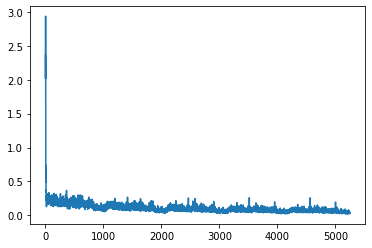

In [57]:
plt.plot(range(len(lossess)),lossess)

# Unet Validation and Visualization

In [9]:
icon_test =  ContourMaskDataset(img_size=512, phase='test', transform_it=True)









  0%|          | 0/100 [00:00<?, ?it/s]

x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
preds shape: torch.Size([4, 11, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


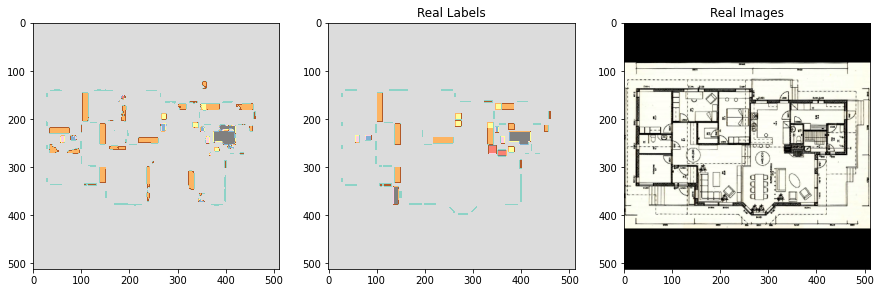

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


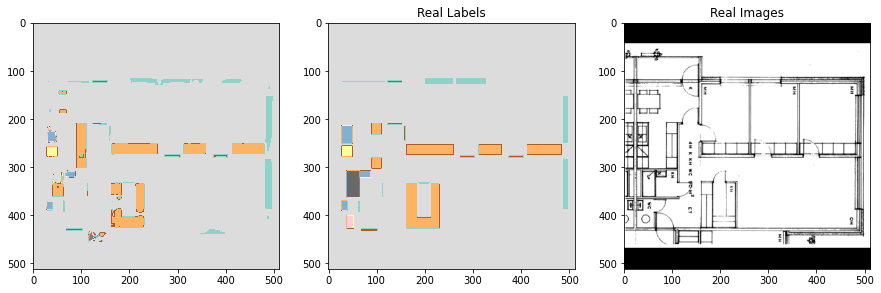

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


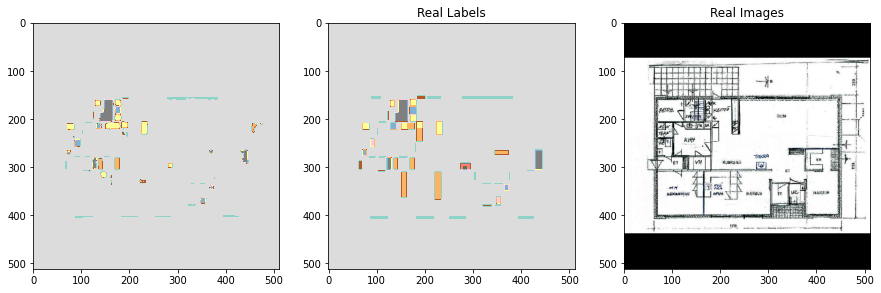

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


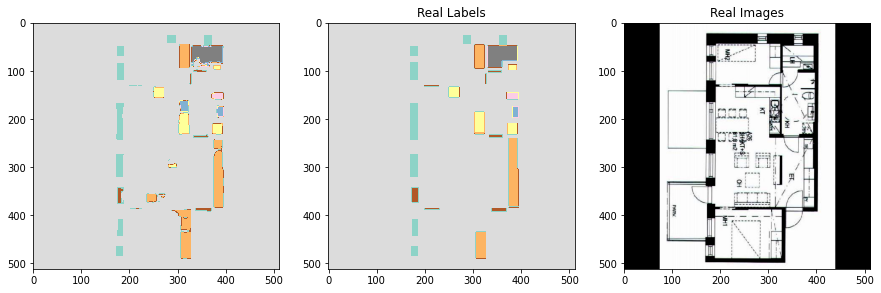

/n/home09/vsong/.conda/envs/ivf_seg/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).








  1%|          | 1/100 [00:09<16:13,  9.83s/it]

x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
preds shape: torch.Size([4, 11, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


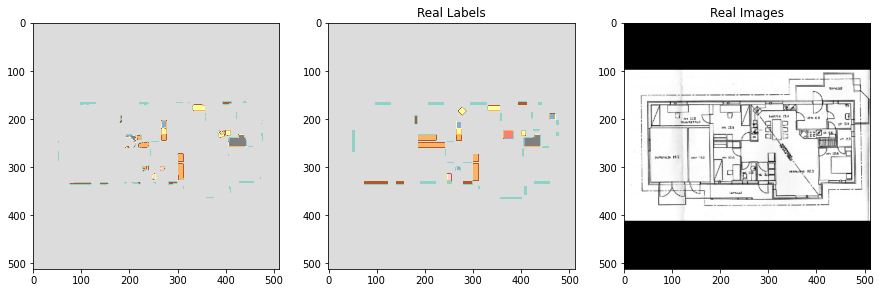

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


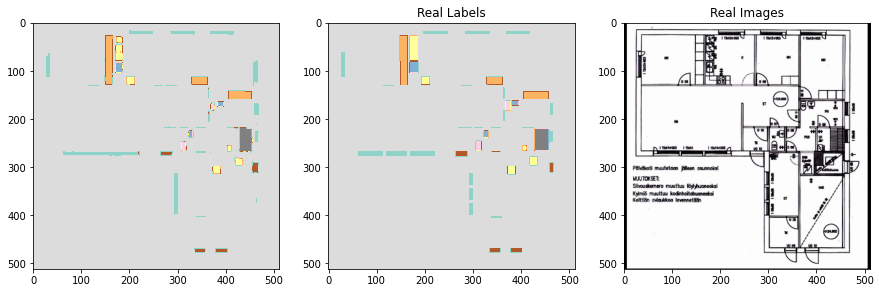

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


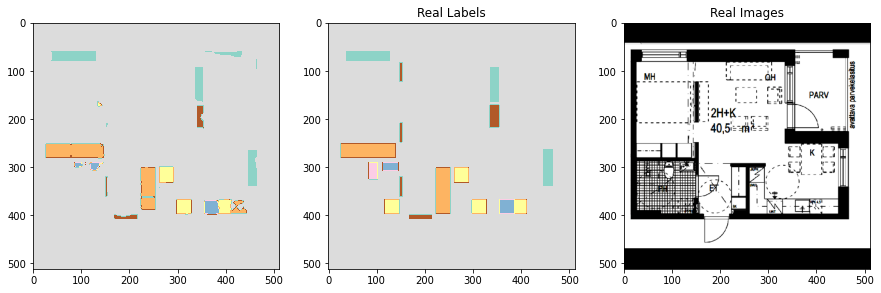

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


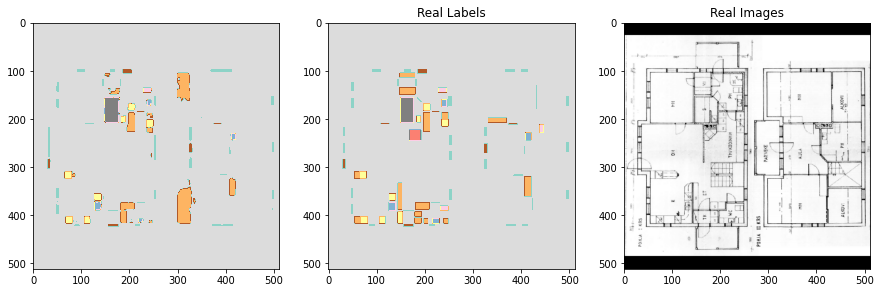









  2%|▏         | 2/100 [00:19<16:11,  9.92s/it]

x shape torch.Size([4, 3, 512, 512])
******xout size: torch.Size([4, 11, 512, 512])
preds shape: torch.Size([4, 11, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


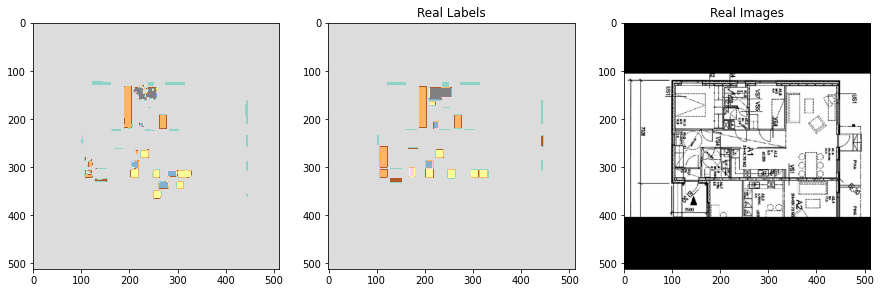

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


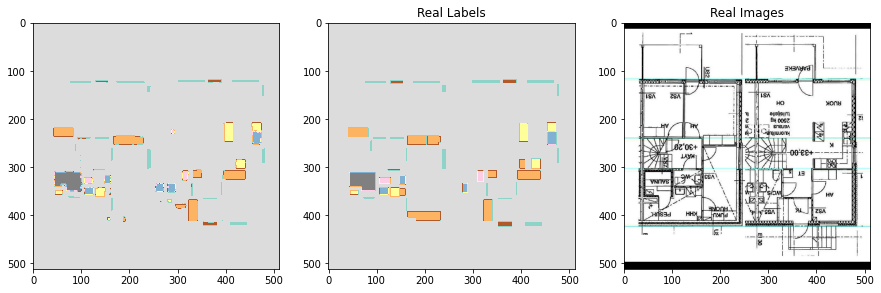

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


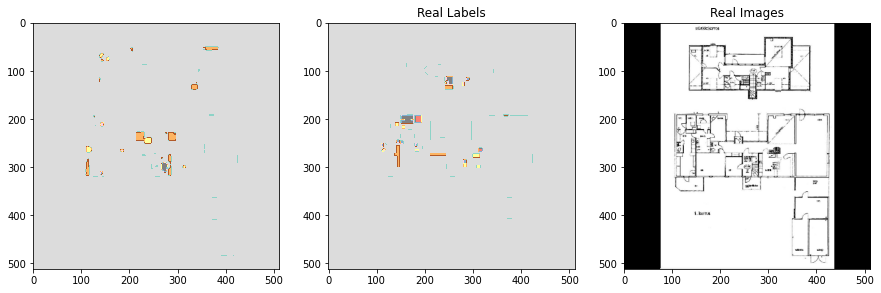

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512)


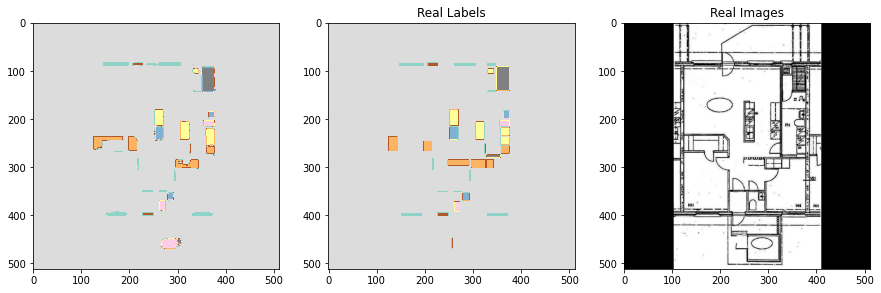

In [29]:
icon_model.eval()
test_count = 0
n_icons = 11
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
icon_model.cuda()
for i, samples in tqdm(enumerate(icon_test.dataloader), total=len(icon_test.dataloader)):
    test_count += 1
    images = samples['image'].cuda(non_blocking=True)
    labels = samples['label'].cuda(non_blocking=True)
    preds = icon_model(images)
    print("preds shape:", preds.shape)
    for idx, pred in enumerate(preds):
        
        icon_index_map = torch.argmax(pred, dim=0, keepdim=True)
        icon_index_map = icon_index_map.cpu().data.numpy()
        print(icon_index_map.shape)
#         icon_index_map = icon_index_map.normal_cuda()
#         icon_image = ToPILImage(icon_index_map)
#         plt.imshow(icon_image)
        plt.figure(figsize=(15,15))
        ax1 = plt.subplot(1,3,1)
        ax1.imshow(icon_index_map[0], cmap='icons', vmin=0, vmax=n_icons-0.1)
        ax2 = plt.subplot(1,3,2)
        label_np = labels[idx].cpu().data.numpy()
#         image_np = images[idx].cpu().data.numpy()
        image_np = images[idx].cpu()
        
        
        ax2.set_title("Real Labels")
        ax2.imshow(label_np[22], cmap='icons', vmin=0, vmax=n_icons-0.1)
        ax3 = plt.subplot(1,3,3)
        ax3.set_title("Real Images")
        ax3.imshow(image_np.permute(1,2,0))
        plt.pause(0.5)
        
#         plt.imshow(np.transpose(icon_image, (1,2,0)), cmap='icons', vmin=0, vmax=n_icons-0.1)
        
        
        
    labels = labels[:,22,:,:]  # Icon segmentations at index 22
    labels = torch.tensor(labels, dtype=torch.long, device=device)
    icon_model
    if test_count == 3:
        break

In [68]:
image_1 = None
label_1 = None
count = 0
for i, samples in tqdm(enumerate(ctmd.dataloader), total=len(ctmd.dataloader)):
    images = samples['image'].cuda(non_blocking=True)
    labels = samples['label'].cuda(non_blocking=True)
    image_1 = images[0]
    label_1 = labels[0]
    print("*************",images.shape)
    print("*************",labels.shape)
    
#     ax2 = plt.subplot(1, 1, 1)
#     plt.title('Actual image', fontsize=20)
#     im = ax2.imshow(torch.Tensor(images[0]).permute(1,2,0))
#     file = io.imread(images[0])
#     io.imshow(file)
#     plt.imshow(torch.Tensor(images[0]).permute(1,2,0))
    print(images)
    print(labels)
    count += 1
    
    if count == 5:break
    
    
    
    
    








  0%|          | 0/1050 [00:00<?, ?it/s]






  0%|          | 1/1050 [00:07<2:19:08,  7.96s/it]

************* torch.Size([4, 3, 512, 512])
************* torch.Size([4, 23, 512, 512])
tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9








  0%|          | 2/1050 [00:13<2:07:25,  7.30s/it]

************* torch.Size([4, 3, 512, 512])
************* torch.Size([4, 23, 512, 512])
tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9








  0%|          | 3/1050 [00:17<1:51:26,  6.39s/it]

************* torch.Size([4, 3, 512, 512])
************* torch.Size([4, 23, 512, 512])
tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9








  0%|          | 4/1050 [00:23<1:46:07,  6.09s/it]

************* torch.Size([4, 3, 512, 512])
************* torch.Size([4, 23, 512, 512])
tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9

************* torch.Size([4, 3, 512, 512])
************* torch.Size([4, 23, 512, 512])
tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9

In [69]:
label_np = label_1.data.numpy()
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
n_rooms = 12

# 21 : rooms and walls
# 22 : icons
print(label_np[21].shape)
rseg = ax.imshow(label_np[21], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

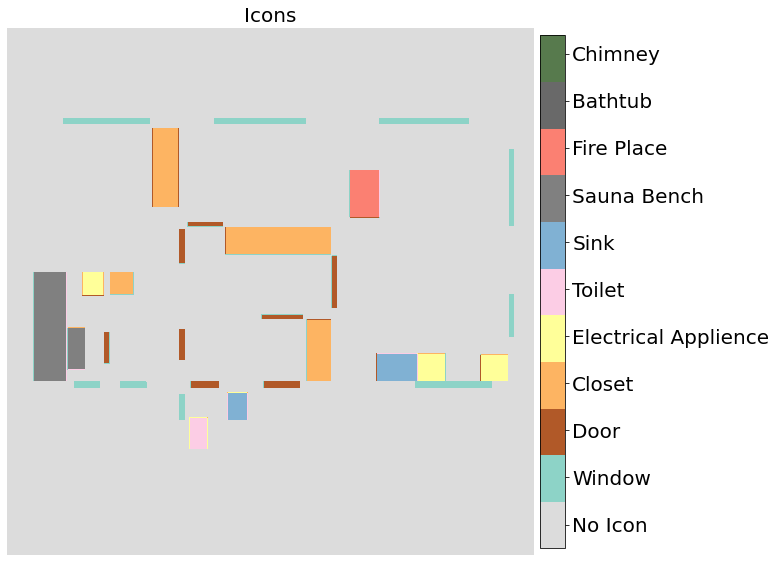

8.0
0.0


In [77]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[22], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()


print(np.max(label_np[22])) # Fireplace Index : 8
print(np.min(label_np[22]))

In [28]:
image_1 = ctmd.normal_set.__getitem__(3220)['image']
label_1 = ctmd.normal_set.__getitem__(3220)['label']



printing LABEL AT DICTTOTENSOR tensor([[[8.6380e-17, 8.4487e-17, 8.2322e-17,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
         [8.3827e-17, 8.6683e-17, 8.9661e-17,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
         [1.1934e-16, 1.2233e-16, 1.2388e-16,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
         ...,
         [0.0000e+00, -0.0000e+00, 0.0000e+00,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
         [0.0000e+00, -0.0000e+00, 0.0000e+00,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
         [0.0000e+00, -0.0000e+00, 0.0000e+00,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00]],

        [[0.0000e+00, -0.0000e+00, 0.0000e+00,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
         [0.0000e+00, -0.0000e+00, 0.0000e+00,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
         [0.0000e+00, -0.0000e+00, 0.0000e+00,  ..., -0.0000e+00,
          0.0000e+00, -0.0000e+00],
         ...,
         [0.0000e+00, -0

In [37]:
label_1.shape # 23 = 12 room types + 11 icon types ??
label_1[11].shape
label_2 = label_1[3][None, :,:] # expending the dim by adding None

# Label INDEX
# 0 : protuberant points
# 12 : Garage
# 13
# 16 : door / entry?

label_2.shape
# fig, ax = plt.subplots(figsize=(18, 18))
# plt.imshow(label_2[0].cpu().data, cmap='gray', alpha=0.5)

torch.Size([1, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


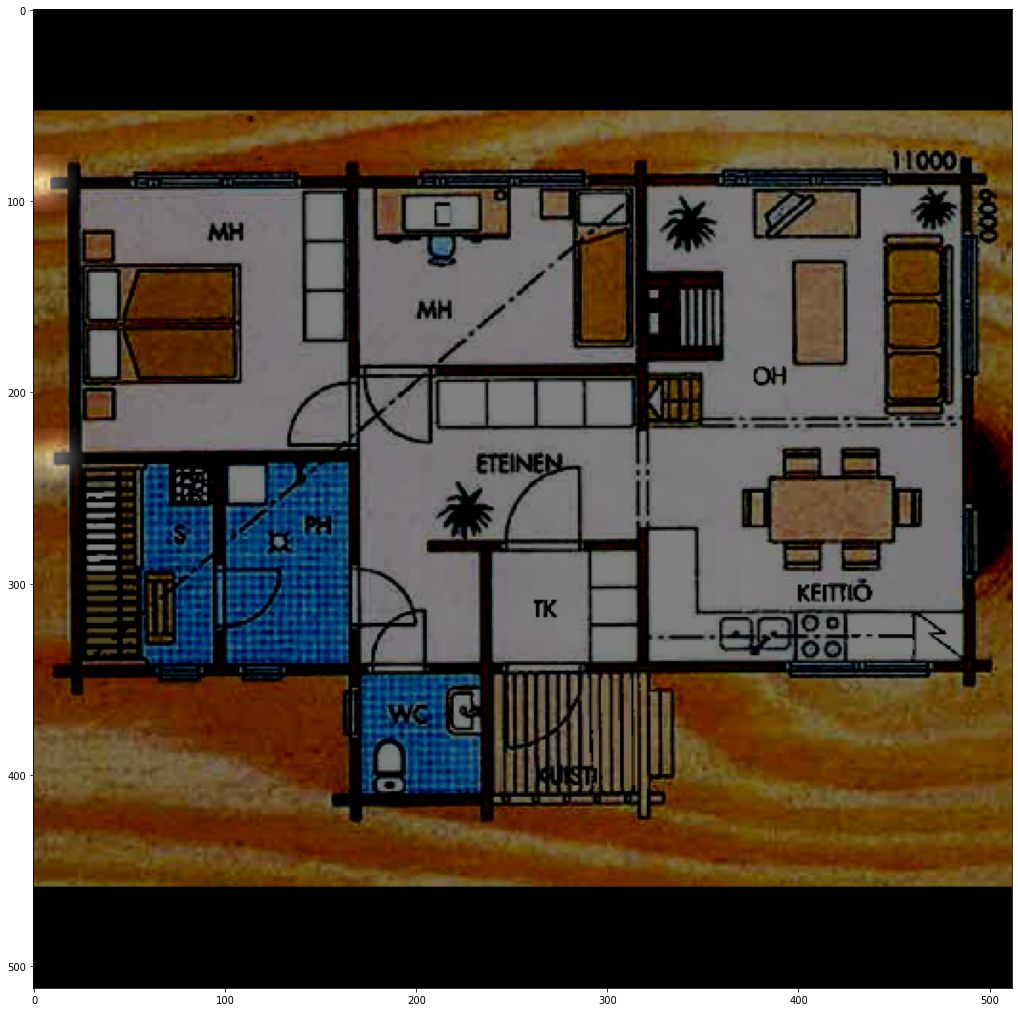

In [38]:
fig, ax = plt.subplots(figsize=(18, 18))
plt.imshow(image_1.cpu().data.permute(1,2,0))
plt.imshow(label_2[0].cpu().data, cmap='gray', alpha=0.5)



# NOW RETRIEVE THE DICTIONARY for label - dot match